# 2. PROGRAMMING

In [1]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
import random
import math

from sklearn.model_selection import train_test_split

In [3]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


1. Implement a Feed Forward Neural Network in Python, with an input layer with S1 units, one hidden layer with S2 units, and an output layer with S3 units. Implement backpropagation algorithm for training this feed-forward neural network, by using log-loss as discussed in class. The network will be trained using data {(xi,yi)} N_i=1 for x_i ∈ R^S1 and y_i ∈{0,1}. The code must allow specifying the following activation functions:
*   Sigmoid
*   Hyperbolic Tangent
*   Rectifier Linear Unit
The code must output all the learned weights and biasses of all layers as well as the activations of the last layer. 

## a) Download the dataset. What should be the value of S1 and S3 for this data? 

In [2]:
!cp /content/drive/MyDrive/HW4.csv /content/sample_data

In [3]:
df = pd.read_csv('/content/sample_data/HW4.csv')

In [4]:
X = df[['a','b']]
y = df['label']
X.shape

(5000, 2)

S1 = 2, since number of features in our dataset are 2 and S3 = 1 since it is a binary classification.

In [5]:
def sigmoid(z):
  #  sigmoid activation function
  return 1/(1 + np.exp(-1*z))

def del_sigmoid(z):
  # 1st derivative of sigmoid function
  return sigmoid(z)*np.subtract(np.ones_like(z),sigmoid(z))

In [6]:
def tan_hyp(z):
  # tanh activation function
  return (np.exp(z) - np.exp(-1*z))/(np.exp(z) + np.exp(-1*z))

def del_tan_hyp(z):
  # 1st derivative of tanh
  return 1 - np.square(tan_hyp(z))

In [7]:
def relu(z):
  # Rectifier linear unit activation function
  return np.maximum(np.zeros_like(z), z)

def del_relu(z):
  # 1st derivative of reLu
  res = np.zeros_like(z)
  for i in range(z.shape[0]):
    for j in range(z.shape[1]):
      if z[i,j] > 0:
        res[i,j] = 1
      elif z[i,j] < 0:
        res[i,j] = 0
      else:
        res[i,j] = None
  return res

In [8]:
def del_f(z, activation):
  '''
  retrieves derivative of specified activation function

  :params:
   z          : array whose activation is to be calculated
   activation : name of the activation function

  :returns:
   derivative of specified activation function
  '''
  if activation == 'sigmoid':
    return del_sigmoid(z)
  elif activation == 'tanh':
    return del_tan_hyp(z)
  elif activation == 'relu':
    return del_relu(z)

In [9]:
class layers:
  '''
  Defines layers of the Neural Network with their weights,
  biases, activation and functions to update the same
  '''
  def __init__(self, in_shape, out_shape, typel):
    '''
    constructor

    :params:
     in_shape : # of neurons in the current layer
     out_shape: # of neurons in the next layer
     typel    : type of layer (input/hidden/output)
    '''
    self.type_layer = typel

    if typel == 'input' or typel == 'hidden':
      # only input and hidden layers have weights and biases
      self.b = np.ones((out_shape, 1))
      self.w = np.random.normal(0, 0.01, in_shape*out_shape)
      self.w = self.w.reshape(out_shape, in_shape)

  def set_deltas(self):
    # intializes delta w and b
    self.delta_b = np.zeros_like(self.b)
    self.delta_w = np.zeros_like(self.w)

  def set_a(self, in_df, typel = 'input'):
    '''
    get activation

    :params:
     in_df : array whose activation is to be calculated
     typel : type of activation function(for input layer no activation function)
    '''
    if typel == 'input':
      self.a = np.array(in_df)
      self.a = np.transpose(self.a)
    elif typel == 'sigmoid':
      self.a = sigmoid(in_df)
    elif typel == 'tanh':
      self.a = tan_hyp(in_df)
    elif typel == 'relu':
      self.a = relu(in_df)

  def set_z(self, a, w, b):
    '''
    calculates  weighted sum

    :parmas:
     a : activation of previous layer
     w : weights of previous layer
     b : bias of previous layer
    '''
    mul = np.matmul(w, a)
    self.z = np.add(mul, b)

  def update_params(self, lambdaa, lr, N):
    # updates w and b
    self.w = np.subtract(self.w, lr*np.add((1/N)*self.delta_w, lambdaa*self.w))
    self.b = np.subtract(self.b, lr*np.add((1/N)*self.delta_b, lambdaa*self.b))

  def update_back_params(self, wgrad, bgrad):
    # sums derivatives of wrt w and b
    self.delta_w = np.add(self.delta_w, wgrad)
    self.delta_b = np.add(self.delta_b, bgrad)

In [10]:
def feed_forward(X, dnn, act_func):
  '''
  feed forward neural net

  :params:
   X        : data to train the NN
   dnn      : neural network
   act_func : activation function to be used at each  layer

  :returns:
   dnn : NN after feed forward
  '''
  for layer in dnn:
    # calculates activation and z for layers
    if layer.type_layer == 'input':
      layer.set_deltas()
      layer.set_a(X)
      a = layer.a
      w = layer.w
      b = layer.b
    elif layer.type_layer == 'hidden':
      layer.set_deltas()
      layer.set_z(a, w, b)
      layer.set_a(layer.z, act_func)
      a = layer.a
      w = layer.w
      b = layer.b
    elif layer.type_layer == 'output':
      layer.set_z(a, w, b)
      layer.set_a(layer.z, act_func)
  return dnn

In [11]:
def back_propagation(y, dnn, act_func, lambdaa, lr):
  '''
  back propagates the error

  :params:
   y        : labels of the dataset
   dnn      : neural network to do back propagation
   act_func : activation function
   lambdaa  : regularization constant lambda

  :returns:
   dnn      : NN after back propagation
  '''
  delta_n = None
  for layer in list(reversed(dnn)):
    if layer.type_layer == 'output':
      # calculates delta n
      dl_by_da = np.add(-1*(y.T/layer.a), (1 - y.T)/(1 - layer.a))
      delta_n = np.array(dl_by_da*del_f(layer.z, act_func))
      delta_next = delta_n
    elif layer.type_layer == 'input':
      # calculate dl/dw and dl/db
      wgrad = np.matmul(delta_next, layer.a.T)
      bgrad = np.mean(delta_next, axis=1).reshape(delta_next.shape[0],1)
      layer.update_back_params(wgrad, bgrad)
    else :
      wgrad = np.matmul(delta_next, layer.a.T)
      bgrad = np.mean(delta_next , axis = 1).reshape(delta_next.shape[0],1)
      layer.update_back_params(wgrad, bgrad)

      # calculate dz/dz
      delta_l = np.matmul(layer.w.T, delta_next)*del_f(layer.z, act_func)
      delta_next = delta_l

  return dnn

In [12]:
def grad(X, y, num_S2 = 2, activation = 'sigmoid', batch_size = 100, lr = 0.01, iterations = 100, lambdaa = 1):
  '''
  runs the epochs of SGD

  :params:
   X          : input dataset
   y          : labels of the dataset
   num_S2     : # of neurons in the hidden layer of the Neural network
   activation : activation function
   batch_size : batch size for SGD
   lr         : learning rate
   iterations : # of epochs to run
   lambdaa    : regularization constant lambda
  
  :returns:
   dnn        : trained neural netowrk
  '''
  iteration = 0
  # initialize the NN
  dnn = []
  S1 = layers(X.shape[1], num_S2, 'input')
  dnn.append(S1)
  S2 = layers(num_S2, 1, 'hidden')
  dnn.append(S2)
  S3 = layers(1, 1, 'output')
  dnn.append(S3)
  
  while iteration < iterations:
    print('Epoch :', iteration+1)
    # perform feed forward and backpropagation by SGD
    dnn = descent(X, y, dnn, activation, lambdaa, lr, batch_size)
    iteration = iteration + 1
  return dnn

In [13]:
def descent(X, y, dnn, act_func, lambdaa, lr, batch_size):
  '''
  performs feed forward and backpropagation in mini batches

  :params:
   X          : input dataset
   y          : labels for input date
   act_func   : activation function
   lambdaa    : regularization constant lambda
   lr         : learning rate
   batch_size : batch size for SGD

  :returns:
   dnn : after performing feed forward and back propagation
  '''

  num_batches = X.shape[0]//batch_size
  m = 0

  # shuffles the dataset
  dff = np.hstack((X, np.array(y).reshape(-1,1)))
  np.random.shuffle(dff)
  X = np.hsplit(df,df.shape[1])
  y = X[-1]
  X = np.hstack((X[:df.shape[1]-1]))

  for idx in tqdm(range(num_batches)):
    x_m = X[m:m+batch_size]
    y_m = y[m:m+batch_size]
    dnn = feed_forward(x_m, dnn, act_func)
    dnn = back_propagation(y_m, dnn, act_func, lambdaa, lr)
  
  for layer in dnn:
    # update weights and biases at each layer
    if layer.type_layer == 'input' or layer.type_layer == 'hidden':
      layer.update_params(lambdaa, lr, X.shape[0])

  return dnn

In [14]:
import math
def logloss(ytrue, ypred):
  # calculates log loss
  loss = np.add(np.dot(np.array(ytrue).T, np.log(ypred.T)), np.dot((1 - np.array(ytrue.T)),np.log(1-ypred.T)))
  return (-loss/ypred.shape[1])[0]

## (b) Let S2 = 2. Train the neural network on the provided training data for several values of the regularization λ. Report the classification error on the validation dataset for each λ and report the best λ that achieves the minimum validation error. For this λ, report the classification error on the training and also on the test datasets.

In [15]:
def train_NN(X, y, num_S2 = 2, activation = 'sigmoid', batch_size = 100, lr = 0.01, iterations = 500):
  '''
  driver function

  :params:
   X          : input dataset
   y          : labels for input data
   num_S2     : # neurons in hidden layer
   activation : activation function
   batch_size : batch size
   lr         : learning rate
   iterations : # of epochs

  :returns:
   key                      : most optimal lambda
   nets[key]                : neural net with optimal lambda
   lambda_val_errors[key]   : validation of best NN
   lambda_train_errors[key] : training error of best NN
   lambda_test_errors[key]  : test error of best NN
  '''

  # lambda values to be considered
  lambdaa = [0.001,0.01,0.1,1,10]
  lambda_val_errors = {}
  lambda_train_errors = {}
  lambda_test_errors = {}
  nets = {}

  # splits dataset into train, test and validation sets
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.4, random_state = 42)
  X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size = 0.5, random_state = 42)

  pd.set_option('display.width', 100)
  pd.set_option('display.max_colwidth',None)
  
  obs = pd.DataFrame(columns=['Lambda', 'Validation Error', 'Training Error', 'Test Error'])

  for lam in lambdaa:
    print()
    print('---------------------------------TRAINING FOR LAMBDA = ', lam,'---------------------------------------')
    dnn = grad(X_train, y_train, num_S2, activation, batch_size, lr, iterations, lambdaa = lam)
    for layer in dnn:
      # for each layer prints weights and biases
      if layer.type_layer == 'input' or layer.type_layer == 'hidden':
        print()
        print('Weights of ',layer.type_layer, ':',layer.w)
        print('Bias of ',layer.type_layer, ':',layer.b)

    # prints first 10 activations of last layer since dataset it large to show all the activations
    print('First 10 Activations of last layer: ', feed_forward(X_train, dnn, activation)[2].a[0,:10])

    # calculate validation, training and test errors
    eval = logloss(y_val, feed_forward(X_val, dnn, activation)[2].a)
    etrain = logloss(y_train, feed_forward(X_train, dnn, activation)[2].a)
    etest = logloss(y_test, feed_forward(X_test, dnn, activation)[2].a)
    
    lambda_val_errors[lam] = eval
    lambda_train_errors[lam] = etrain
    lambda_test_errors[lam] = etest
    nets[lam] = dnn
    
    row = {'Lambda':lam, 'Validation Error':eval, 'Training Error':etrain, 'Test Error':etest}
    obs = obs.append(row,ignore_index=True)

  print()
  print(obs)
  # calculate lambda with minimum validation error
  min_error = min(lambda_val_errors.values())
  lb = [key for key in lambda_val_errors if lambda_val_errors[key] == min_error]
  key = lb[0]

  return key, nets[key], lambda_val_errors[key], lambda_train_errors[key], lambda_test_errors[key]

In [16]:
act_function = 'sigmoid'
print('For ', act_function,' function and S2 = 2')
lam, dnn, eval, etrain, etest = train_NN(X, y, activation = act_function, batch_size = 20, lr = 0.01, iterations = 500)

For  sigmoid  function and S2 = 2

---------------------------------TRAINING FOR LAMBDA =  0.001 ---------------------------------------
Epoch : 1


100%|██████████| 150/150 [00:00<00:00, 436.54it/s]


Epoch : 2


100%|██████████| 150/150 [00:00<00:00, 429.65it/s]


Epoch : 3


100%|██████████| 150/150 [00:00<00:00, 460.10it/s]


Epoch : 4


100%|██████████| 150/150 [00:00<00:00, 454.70it/s]


Epoch : 5


100%|██████████| 150/150 [00:00<00:00, 438.45it/s]


Epoch : 6


100%|██████████| 150/150 [00:00<00:00, 427.14it/s]


Epoch : 7


100%|██████████| 150/150 [00:00<00:00, 496.81it/s]


Epoch : 8


100%|██████████| 150/150 [00:00<00:00, 450.16it/s]


Epoch : 9


100%|██████████| 150/150 [00:00<00:00, 439.09it/s]


Epoch : 10


100%|██████████| 150/150 [00:00<00:00, 452.59it/s]


Epoch : 11


100%|██████████| 150/150 [00:00<00:00, 426.26it/s]


Epoch : 12


100%|██████████| 150/150 [00:00<00:00, 410.21it/s]


Epoch : 13


100%|██████████| 150/150 [00:00<00:00, 449.36it/s]


Epoch : 14


100%|██████████| 150/150 [00:00<00:00, 473.70it/s]


Epoch : 15


100%|██████████| 150/150 [00:00<00:00, 444.41it/s]


Epoch : 16


100%|██████████| 150/150 [00:00<00:00, 509.59it/s]


Epoch : 17


100%|██████████| 150/150 [00:00<00:00, 446.59it/s]


Epoch : 18


100%|██████████| 150/150 [00:00<00:00, 453.35it/s]


Epoch : 19


100%|██████████| 150/150 [00:00<00:00, 476.81it/s]


Epoch : 20


100%|██████████| 150/150 [00:00<00:00, 462.41it/s]


Epoch : 21


100%|██████████| 150/150 [00:00<00:00, 454.28it/s]


Epoch : 22


100%|██████████| 150/150 [00:00<00:00, 457.21it/s]


Epoch : 23


100%|██████████| 150/150 [00:00<00:00, 470.41it/s]


Epoch : 24


100%|██████████| 150/150 [00:00<00:00, 435.12it/s]


Epoch : 25


100%|██████████| 150/150 [00:00<00:00, 482.92it/s]


Epoch : 26


100%|██████████| 150/150 [00:00<00:00, 430.54it/s]


Epoch : 27


100%|██████████| 150/150 [00:00<00:00, 439.49it/s]


Epoch : 28


100%|██████████| 150/150 [00:00<00:00, 471.47it/s]


Epoch : 29


100%|██████████| 150/150 [00:00<00:00, 503.28it/s]


Epoch : 30


100%|██████████| 150/150 [00:00<00:00, 435.11it/s]


Epoch : 31


100%|██████████| 150/150 [00:00<00:00, 419.56it/s]


Epoch : 32


100%|██████████| 150/150 [00:00<00:00, 478.97it/s]


Epoch : 33


100%|██████████| 150/150 [00:00<00:00, 454.73it/s]


Epoch : 34


100%|██████████| 150/150 [00:00<00:00, 439.41it/s]


Epoch : 35


100%|██████████| 150/150 [00:00<00:00, 501.68it/s]


Epoch : 36


100%|██████████| 150/150 [00:00<00:00, 439.00it/s]


Epoch : 37


100%|██████████| 150/150 [00:00<00:00, 435.26it/s]


Epoch : 38


100%|██████████| 150/150 [00:00<00:00, 425.63it/s]


Epoch : 39


100%|██████████| 150/150 [00:00<00:00, 436.40it/s]


Epoch : 40


100%|██████████| 150/150 [00:00<00:00, 442.75it/s]


Epoch : 41


100%|██████████| 150/150 [00:00<00:00, 439.45it/s]


Epoch : 42


100%|██████████| 150/150 [00:00<00:00, 475.00it/s]


Epoch : 43


100%|██████████| 150/150 [00:00<00:00, 470.82it/s]


Epoch : 44


100%|██████████| 150/150 [00:00<00:00, 470.46it/s]


Epoch : 45


100%|██████████| 150/150 [00:00<00:00, 444.48it/s]


Epoch : 46


100%|██████████| 150/150 [00:00<00:00, 429.42it/s]


Epoch : 47


100%|██████████| 150/150 [00:00<00:00, 446.70it/s]


Epoch : 48


100%|██████████| 150/150 [00:00<00:00, 473.03it/s]


Epoch : 49


100%|██████████| 150/150 [00:00<00:00, 476.01it/s]


Epoch : 50


100%|██████████| 150/150 [00:00<00:00, 492.53it/s]


Epoch : 51


100%|██████████| 150/150 [00:00<00:00, 476.30it/s]


Epoch : 52


100%|██████████| 150/150 [00:00<00:00, 429.24it/s]


Epoch : 53


100%|██████████| 150/150 [00:00<00:00, 488.47it/s]


Epoch : 54


100%|██████████| 150/150 [00:00<00:00, 446.70it/s]


Epoch : 55


100%|██████████| 150/150 [00:00<00:00, 490.47it/s]


Epoch : 56


100%|██████████| 150/150 [00:00<00:00, 477.84it/s]


Epoch : 57


100%|██████████| 150/150 [00:00<00:00, 442.06it/s]


Epoch : 58


100%|██████████| 150/150 [00:00<00:00, 461.94it/s]


Epoch : 59


100%|██████████| 150/150 [00:00<00:00, 432.08it/s]


Epoch : 60


100%|██████████| 150/150 [00:00<00:00, 414.70it/s]


Epoch : 61


100%|██████████| 150/150 [00:00<00:00, 442.91it/s]


Epoch : 62


100%|██████████| 150/150 [00:00<00:00, 461.26it/s]


Epoch : 63


100%|██████████| 150/150 [00:00<00:00, 432.28it/s]


Epoch : 64


100%|██████████| 150/150 [00:00<00:00, 423.85it/s]


Epoch : 65


100%|██████████| 150/150 [00:00<00:00, 494.48it/s]


Epoch : 66


100%|██████████| 150/150 [00:00<00:00, 428.20it/s]


Epoch : 67


100%|██████████| 150/150 [00:00<00:00, 437.62it/s]


Epoch : 68


100%|██████████| 150/150 [00:00<00:00, 483.86it/s]


Epoch : 69


100%|██████████| 150/150 [00:00<00:00, 435.30it/s]


Epoch : 70


100%|██████████| 150/150 [00:00<00:00, 464.82it/s]


Epoch : 71


100%|██████████| 150/150 [00:00<00:00, 445.59it/s]


Epoch : 72


100%|██████████| 150/150 [00:00<00:00, 455.45it/s]


Epoch : 73


100%|██████████| 150/150 [00:00<00:00, 414.48it/s]


Epoch : 74


100%|██████████| 150/150 [00:00<00:00, 437.91it/s]


Epoch : 75


100%|██████████| 150/150 [00:00<00:00, 449.11it/s]


Epoch : 76


100%|██████████| 150/150 [00:00<00:00, 412.52it/s]


Epoch : 77


100%|██████████| 150/150 [00:00<00:00, 441.03it/s]


Epoch : 78


100%|██████████| 150/150 [00:00<00:00, 442.65it/s]


Epoch : 79


100%|██████████| 150/150 [00:00<00:00, 407.52it/s]


Epoch : 80


100%|██████████| 150/150 [00:00<00:00, 445.91it/s]


Epoch : 81


100%|██████████| 150/150 [00:00<00:00, 445.40it/s]


Epoch : 82


100%|██████████| 150/150 [00:00<00:00, 461.65it/s]


Epoch : 83


100%|██████████| 150/150 [00:00<00:00, 446.21it/s]


Epoch : 84


100%|██████████| 150/150 [00:00<00:00, 442.98it/s]


Epoch : 85


100%|██████████| 150/150 [00:00<00:00, 431.57it/s]


Epoch : 86


100%|██████████| 150/150 [00:00<00:00, 460.55it/s]


Epoch : 87


100%|██████████| 150/150 [00:00<00:00, 428.48it/s]


Epoch : 88


100%|██████████| 150/150 [00:00<00:00, 453.12it/s]


Epoch : 89


100%|██████████| 150/150 [00:00<00:00, 425.91it/s]


Epoch : 90


100%|██████████| 150/150 [00:00<00:00, 421.62it/s]


Epoch : 91


100%|██████████| 150/150 [00:00<00:00, 461.52it/s]


Epoch : 92


100%|██████████| 150/150 [00:00<00:00, 476.12it/s]


Epoch : 93


100%|██████████| 150/150 [00:00<00:00, 466.64it/s]


Epoch : 94


100%|██████████| 150/150 [00:00<00:00, 434.86it/s]


Epoch : 95


100%|██████████| 150/150 [00:00<00:00, 451.92it/s]


Epoch : 96


100%|██████████| 150/150 [00:00<00:00, 417.12it/s]


Epoch : 97


100%|██████████| 150/150 [00:00<00:00, 439.52it/s]


Epoch : 98


100%|██████████| 150/150 [00:00<00:00, 459.91it/s]


Epoch : 99


100%|██████████| 150/150 [00:00<00:00, 443.24it/s]


Epoch : 100


100%|██████████| 150/150 [00:00<00:00, 430.20it/s]


Epoch : 101


100%|██████████| 150/150 [00:00<00:00, 399.10it/s]


Epoch : 102


100%|██████████| 150/150 [00:00<00:00, 428.28it/s]


Epoch : 103


100%|██████████| 150/150 [00:00<00:00, 444.88it/s]


Epoch : 104


100%|██████████| 150/150 [00:00<00:00, 397.51it/s]


Epoch : 105


100%|██████████| 150/150 [00:00<00:00, 432.03it/s]


Epoch : 106


100%|██████████| 150/150 [00:00<00:00, 451.53it/s]


Epoch : 107


100%|██████████| 150/150 [00:00<00:00, 429.08it/s]


Epoch : 108


100%|██████████| 150/150 [00:00<00:00, 432.52it/s]


Epoch : 109


100%|██████████| 150/150 [00:00<00:00, 413.74it/s]


Epoch : 110


100%|██████████| 150/150 [00:00<00:00, 446.70it/s]


Epoch : 111


100%|██████████| 150/150 [00:00<00:00, 413.15it/s]


Epoch : 112


100%|██████████| 150/150 [00:00<00:00, 414.73it/s]


Epoch : 113


100%|██████████| 150/150 [00:00<00:00, 409.38it/s]


Epoch : 114


100%|██████████| 150/150 [00:00<00:00, 403.83it/s]


Epoch : 115


100%|██████████| 150/150 [00:00<00:00, 394.67it/s]


Epoch : 116


100%|██████████| 150/150 [00:00<00:00, 452.88it/s]


Epoch : 117


100%|██████████| 150/150 [00:00<00:00, 415.24it/s]


Epoch : 118


100%|██████████| 150/150 [00:00<00:00, 423.69it/s]


Epoch : 119


100%|██████████| 150/150 [00:00<00:00, 434.23it/s]


Epoch : 120


100%|██████████| 150/150 [00:00<00:00, 443.97it/s]


Epoch : 121


100%|██████████| 150/150 [00:00<00:00, 450.16it/s]


Epoch : 122


100%|██████████| 150/150 [00:00<00:00, 421.27it/s]


Epoch : 123


100%|██████████| 150/150 [00:00<00:00, 417.75it/s]


Epoch : 124


100%|██████████| 150/150 [00:00<00:00, 506.45it/s]


Epoch : 125


100%|██████████| 150/150 [00:00<00:00, 436.01it/s]


Epoch : 126


100%|██████████| 150/150 [00:00<00:00, 451.04it/s]


Epoch : 127


100%|██████████| 150/150 [00:00<00:00, 483.27it/s]


Epoch : 128


100%|██████████| 150/150 [00:00<00:00, 404.03it/s]


Epoch : 129


100%|██████████| 150/150 [00:00<00:00, 444.15it/s]


Epoch : 130


100%|██████████| 150/150 [00:00<00:00, 430.39it/s]


Epoch : 131


100%|██████████| 150/150 [00:00<00:00, 426.00it/s]


Epoch : 132


100%|██████████| 150/150 [00:00<00:00, 443.44it/s]


Epoch : 133


100%|██████████| 150/150 [00:00<00:00, 432.21it/s]


Epoch : 134


100%|██████████| 150/150 [00:00<00:00, 407.14it/s]


Epoch : 135


100%|██████████| 150/150 [00:00<00:00, 437.40it/s]


Epoch : 136


100%|██████████| 150/150 [00:00<00:00, 481.79it/s]


Epoch : 137


100%|██████████| 150/150 [00:00<00:00, 473.15it/s]


Epoch : 138


100%|██████████| 150/150 [00:00<00:00, 474.74it/s]


Epoch : 139


100%|██████████| 150/150 [00:00<00:00, 448.31it/s]


Epoch : 140


100%|██████████| 150/150 [00:00<00:00, 413.16it/s]


Epoch : 141


100%|██████████| 150/150 [00:00<00:00, 458.76it/s]


Epoch : 142


100%|██████████| 150/150 [00:00<00:00, 401.42it/s]


Epoch : 143


100%|██████████| 150/150 [00:00<00:00, 389.07it/s]


Epoch : 144


100%|██████████| 150/150 [00:00<00:00, 435.11it/s]


Epoch : 145


100%|██████████| 150/150 [00:00<00:00, 440.76it/s]


Epoch : 146


100%|██████████| 150/150 [00:00<00:00, 462.68it/s]


Epoch : 147


100%|██████████| 150/150 [00:00<00:00, 463.15it/s]


Epoch : 148


100%|██████████| 150/150 [00:00<00:00, 429.16it/s]


Epoch : 149


100%|██████████| 150/150 [00:00<00:00, 427.54it/s]


Epoch : 150


100%|██████████| 150/150 [00:00<00:00, 435.22it/s]


Epoch : 151


100%|██████████| 150/150 [00:00<00:00, 441.48it/s]


Epoch : 152


100%|██████████| 150/150 [00:00<00:00, 434.41it/s]


Epoch : 153


100%|██████████| 150/150 [00:00<00:00, 425.95it/s]


Epoch : 154


100%|██████████| 150/150 [00:00<00:00, 466.25it/s]


Epoch : 155


100%|██████████| 150/150 [00:00<00:00, 462.87it/s]


Epoch : 156


100%|██████████| 150/150 [00:00<00:00, 444.81it/s]


Epoch : 157


100%|██████████| 150/150 [00:00<00:00, 423.69it/s]


Epoch : 158


100%|██████████| 150/150 [00:00<00:00, 455.44it/s]


Epoch : 159


100%|██████████| 150/150 [00:00<00:00, 496.81it/s]


Epoch : 160


100%|██████████| 150/150 [00:00<00:00, 428.62it/s]


Epoch : 161


100%|██████████| 150/150 [00:00<00:00, 471.06it/s]


Epoch : 162


100%|██████████| 150/150 [00:00<00:00, 411.31it/s]


Epoch : 163


100%|██████████| 150/150 [00:00<00:00, 427.61it/s]


Epoch : 164


100%|██████████| 150/150 [00:00<00:00, 450.34it/s]


Epoch : 165


100%|██████████| 150/150 [00:00<00:00, 443.29it/s]


Epoch : 166


100%|██████████| 150/150 [00:00<00:00, 420.15it/s]


Epoch : 167


100%|██████████| 150/150 [00:00<00:00, 438.43it/s]


Epoch : 168


100%|██████████| 150/150 [00:00<00:00, 455.85it/s]


Epoch : 169


100%|██████████| 150/150 [00:00<00:00, 454.78it/s]


Epoch : 170


100%|██████████| 150/150 [00:00<00:00, 459.34it/s]


Epoch : 171


100%|██████████| 150/150 [00:00<00:00, 419.54it/s]


Epoch : 172


100%|██████████| 150/150 [00:00<00:00, 432.51it/s]


Epoch : 173


100%|██████████| 150/150 [00:00<00:00, 425.10it/s]


Epoch : 174


100%|██████████| 150/150 [00:00<00:00, 472.26it/s]


Epoch : 175


100%|██████████| 150/150 [00:00<00:00, 415.53it/s]


Epoch : 176


100%|██████████| 150/150 [00:00<00:00, 457.61it/s]


Epoch : 177


100%|██████████| 150/150 [00:00<00:00, 431.51it/s]


Epoch : 178


100%|██████████| 150/150 [00:00<00:00, 426.46it/s]


Epoch : 179


100%|██████████| 150/150 [00:00<00:00, 474.62it/s]


Epoch : 180


100%|██████████| 150/150 [00:00<00:00, 465.32it/s]


Epoch : 181


100%|██████████| 150/150 [00:00<00:00, 423.74it/s]


Epoch : 182


100%|██████████| 150/150 [00:00<00:00, 444.51it/s]


Epoch : 183


100%|██████████| 150/150 [00:00<00:00, 415.58it/s]


Epoch : 184


100%|██████████| 150/150 [00:00<00:00, 442.63it/s]


Epoch : 185


100%|██████████| 150/150 [00:00<00:00, 497.34it/s]


Epoch : 186


100%|██████████| 150/150 [00:00<00:00, 455.29it/s]


Epoch : 187


100%|██████████| 150/150 [00:00<00:00, 455.16it/s]


Epoch : 188


100%|██████████| 150/150 [00:00<00:00, 400.78it/s]


Epoch : 189


100%|██████████| 150/150 [00:00<00:00, 409.46it/s]


Epoch : 190


100%|██████████| 150/150 [00:00<00:00, 424.13it/s]


Epoch : 191


100%|██████████| 150/150 [00:00<00:00, 462.76it/s]


Epoch : 192


100%|██████████| 150/150 [00:00<00:00, 424.79it/s]


Epoch : 193


100%|██████████| 150/150 [00:00<00:00, 468.25it/s]


Epoch : 194


100%|██████████| 150/150 [00:00<00:00, 415.28it/s]


Epoch : 195


100%|██████████| 150/150 [00:00<00:00, 449.51it/s]


Epoch : 196


100%|██████████| 150/150 [00:00<00:00, 509.04it/s]


Epoch : 197


100%|██████████| 150/150 [00:00<00:00, 455.13it/s]


Epoch : 198


100%|██████████| 150/150 [00:00<00:00, 462.28it/s]


Epoch : 199


100%|██████████| 150/150 [00:00<00:00, 383.09it/s]


Epoch : 200


100%|██████████| 150/150 [00:00<00:00, 432.83it/s]


Epoch : 201


100%|██████████| 150/150 [00:00<00:00, 422.22it/s]


Epoch : 202


100%|██████████| 150/150 [00:00<00:00, 458.21it/s]


Epoch : 203


100%|██████████| 150/150 [00:00<00:00, 454.72it/s]


Epoch : 204


100%|██████████| 150/150 [00:00<00:00, 421.95it/s]


Epoch : 205


100%|██████████| 150/150 [00:00<00:00, 424.01it/s]


Epoch : 206


100%|██████████| 150/150 [00:00<00:00, 426.04it/s]


Epoch : 207


100%|██████████| 150/150 [00:00<00:00, 422.58it/s]


Epoch : 208


100%|██████████| 150/150 [00:00<00:00, 429.23it/s]


Epoch : 209


100%|██████████| 150/150 [00:00<00:00, 460.26it/s]


Epoch : 210


100%|██████████| 150/150 [00:00<00:00, 453.83it/s]


Epoch : 211


100%|██████████| 150/150 [00:00<00:00, 433.72it/s]


Epoch : 212


100%|██████████| 150/150 [00:00<00:00, 455.85it/s]


Epoch : 213


100%|██████████| 150/150 [00:00<00:00, 441.47it/s]


Epoch : 214


100%|██████████| 150/150 [00:00<00:00, 381.53it/s]


Epoch : 215


100%|██████████| 150/150 [00:00<00:00, 422.65it/s]


Epoch : 216


100%|██████████| 150/150 [00:00<00:00, 445.85it/s]


Epoch : 217


100%|██████████| 150/150 [00:00<00:00, 457.94it/s]


Epoch : 218


100%|██████████| 150/150 [00:00<00:00, 442.05it/s]


Epoch : 219


100%|██████████| 150/150 [00:00<00:00, 458.78it/s]


Epoch : 220


100%|██████████| 150/150 [00:00<00:00, 426.41it/s]


Epoch : 221


100%|██████████| 150/150 [00:00<00:00, 423.32it/s]


Epoch : 222


100%|██████████| 150/150 [00:00<00:00, 453.53it/s]


Epoch : 223


100%|██████████| 150/150 [00:00<00:00, 459.47it/s]


Epoch : 224


100%|██████████| 150/150 [00:00<00:00, 463.89it/s]


Epoch : 225


100%|██████████| 150/150 [00:00<00:00, 458.07it/s]


Epoch : 226


100%|██████████| 150/150 [00:00<00:00, 437.90it/s]


Epoch : 227


100%|██████████| 150/150 [00:00<00:00, 447.93it/s]


Epoch : 228


100%|██████████| 150/150 [00:00<00:00, 412.30it/s]


Epoch : 229


100%|██████████| 150/150 [00:00<00:00, 422.09it/s]


Epoch : 230


100%|██████████| 150/150 [00:00<00:00, 400.57it/s]


Epoch : 231


100%|██████████| 150/150 [00:00<00:00, 404.55it/s]


Epoch : 232


100%|██████████| 150/150 [00:00<00:00, 400.79it/s]


Epoch : 233


100%|██████████| 150/150 [00:00<00:00, 398.09it/s]


Epoch : 234


100%|██████████| 150/150 [00:00<00:00, 411.34it/s]


Epoch : 235


100%|██████████| 150/150 [00:00<00:00, 388.33it/s]


Epoch : 236


100%|██████████| 150/150 [00:00<00:00, 405.10it/s]


Epoch : 237


100%|██████████| 150/150 [00:00<00:00, 455.12it/s]


Epoch : 238


100%|██████████| 150/150 [00:00<00:00, 384.48it/s]


Epoch : 239


100%|██████████| 150/150 [00:00<00:00, 410.57it/s]


Epoch : 240


100%|██████████| 150/150 [00:00<00:00, 406.94it/s]


Epoch : 241


100%|██████████| 150/150 [00:00<00:00, 431.47it/s]


Epoch : 242


100%|██████████| 150/150 [00:00<00:00, 453.10it/s]


Epoch : 243


100%|██████████| 150/150 [00:00<00:00, 465.93it/s]


Epoch : 244


100%|██████████| 150/150 [00:00<00:00, 413.47it/s]


Epoch : 245


100%|██████████| 150/150 [00:00<00:00, 425.04it/s]


Epoch : 246


100%|██████████| 150/150 [00:00<00:00, 395.60it/s]


Epoch : 247


100%|██████████| 150/150 [00:00<00:00, 453.21it/s]


Epoch : 248


100%|██████████| 150/150 [00:00<00:00, 414.39it/s]


Epoch : 249


100%|██████████| 150/150 [00:00<00:00, 431.13it/s]


Epoch : 250


100%|██████████| 150/150 [00:00<00:00, 417.16it/s]


Epoch : 251


100%|██████████| 150/150 [00:00<00:00, 412.52it/s]


Epoch : 252


100%|██████████| 150/150 [00:00<00:00, 425.34it/s]


Epoch : 253


100%|██████████| 150/150 [00:00<00:00, 467.39it/s]


Epoch : 254


100%|██████████| 150/150 [00:00<00:00, 384.11it/s]


Epoch : 255


100%|██████████| 150/150 [00:00<00:00, 418.61it/s]


Epoch : 256


100%|██████████| 150/150 [00:00<00:00, 402.93it/s]


Epoch : 257


100%|██████████| 150/150 [00:00<00:00, 376.92it/s]


Epoch : 258


100%|██████████| 150/150 [00:00<00:00, 428.08it/s]


Epoch : 259


100%|██████████| 150/150 [00:00<00:00, 389.77it/s]


Epoch : 260


100%|██████████| 150/150 [00:00<00:00, 447.68it/s]


Epoch : 261


100%|██████████| 150/150 [00:00<00:00, 432.75it/s]


Epoch : 262


100%|██████████| 150/150 [00:00<00:00, 449.70it/s]


Epoch : 263


100%|██████████| 150/150 [00:00<00:00, 414.66it/s]


Epoch : 264


100%|██████████| 150/150 [00:00<00:00, 413.63it/s]


Epoch : 265


100%|██████████| 150/150 [00:00<00:00, 418.50it/s]


Epoch : 266


100%|██████████| 150/150 [00:00<00:00, 425.66it/s]


Epoch : 267


100%|██████████| 150/150 [00:00<00:00, 405.46it/s]


Epoch : 268


100%|██████████| 150/150 [00:00<00:00, 459.15it/s]


Epoch : 269


100%|██████████| 150/150 [00:00<00:00, 416.79it/s]


Epoch : 270


100%|██████████| 150/150 [00:00<00:00, 423.16it/s]


Epoch : 271


100%|██████████| 150/150 [00:00<00:00, 458.11it/s]


Epoch : 272


100%|██████████| 150/150 [00:00<00:00, 462.58it/s]


Epoch : 273


100%|██████████| 150/150 [00:00<00:00, 418.96it/s]


Epoch : 274


100%|██████████| 150/150 [00:00<00:00, 435.34it/s]


Epoch : 275


100%|██████████| 150/150 [00:00<00:00, 430.29it/s]


Epoch : 276


100%|██████████| 150/150 [00:00<00:00, 431.43it/s]


Epoch : 277


100%|██████████| 150/150 [00:00<00:00, 450.75it/s]


Epoch : 278


100%|██████████| 150/150 [00:00<00:00, 432.80it/s]


Epoch : 279


100%|██████████| 150/150 [00:00<00:00, 429.51it/s]


Epoch : 280


100%|██████████| 150/150 [00:00<00:00, 437.14it/s]


Epoch : 281


100%|██████████| 150/150 [00:00<00:00, 415.21it/s]


Epoch : 282


100%|██████████| 150/150 [00:00<00:00, 453.90it/s]


Epoch : 283


100%|██████████| 150/150 [00:00<00:00, 402.77it/s]


Epoch : 284


100%|██████████| 150/150 [00:00<00:00, 411.24it/s]


Epoch : 285


100%|██████████| 150/150 [00:00<00:00, 423.03it/s]


Epoch : 286


100%|██████████| 150/150 [00:00<00:00, 444.16it/s]


Epoch : 287


100%|██████████| 150/150 [00:00<00:00, 481.92it/s]


Epoch : 288


100%|██████████| 150/150 [00:00<00:00, 413.49it/s]


Epoch : 289


100%|██████████| 150/150 [00:00<00:00, 421.88it/s]


Epoch : 290


100%|██████████| 150/150 [00:00<00:00, 438.79it/s]


Epoch : 291


100%|██████████| 150/150 [00:00<00:00, 423.57it/s]


Epoch : 292


100%|██████████| 150/150 [00:00<00:00, 422.57it/s]


Epoch : 293


100%|██████████| 150/150 [00:00<00:00, 408.93it/s]


Epoch : 294


100%|██████████| 150/150 [00:00<00:00, 457.37it/s]


Epoch : 295


100%|██████████| 150/150 [00:00<00:00, 426.59it/s]


Epoch : 296


100%|██████████| 150/150 [00:00<00:00, 416.44it/s]


Epoch : 297


100%|██████████| 150/150 [00:00<00:00, 397.54it/s]


Epoch : 298


100%|██████████| 150/150 [00:00<00:00, 426.00it/s]


Epoch : 299


100%|██████████| 150/150 [00:00<00:00, 419.35it/s]


Epoch : 300


100%|██████████| 150/150 [00:00<00:00, 407.88it/s]


Epoch : 301


100%|██████████| 150/150 [00:00<00:00, 420.79it/s]


Epoch : 302


100%|██████████| 150/150 [00:00<00:00, 422.56it/s]


Epoch : 303


100%|██████████| 150/150 [00:00<00:00, 443.20it/s]


Epoch : 304


100%|██████████| 150/150 [00:00<00:00, 422.70it/s]


Epoch : 305


100%|██████████| 150/150 [00:00<00:00, 418.22it/s]


Epoch : 306


100%|██████████| 150/150 [00:00<00:00, 419.80it/s]


Epoch : 307


100%|██████████| 150/150 [00:00<00:00, 416.58it/s]


Epoch : 308


100%|██████████| 150/150 [00:00<00:00, 431.66it/s]


Epoch : 309


100%|██████████| 150/150 [00:00<00:00, 454.26it/s]


Epoch : 310


100%|██████████| 150/150 [00:00<00:00, 411.03it/s]


Epoch : 311


100%|██████████| 150/150 [00:00<00:00, 441.76it/s]


Epoch : 312


100%|██████████| 150/150 [00:00<00:00, 396.48it/s]


Epoch : 313


100%|██████████| 150/150 [00:00<00:00, 422.36it/s]


Epoch : 314


100%|██████████| 150/150 [00:00<00:00, 476.57it/s]


Epoch : 315


100%|██████████| 150/150 [00:00<00:00, 456.69it/s]


Epoch : 316


100%|██████████| 150/150 [00:00<00:00, 452.47it/s]


Epoch : 317


100%|██████████| 150/150 [00:00<00:00, 445.14it/s]


Epoch : 318


100%|██████████| 150/150 [00:00<00:00, 403.39it/s]


Epoch : 319


100%|██████████| 150/150 [00:00<00:00, 420.05it/s]


Epoch : 320


100%|██████████| 150/150 [00:00<00:00, 417.41it/s]


Epoch : 321


100%|██████████| 150/150 [00:00<00:00, 419.64it/s]


Epoch : 322


100%|██████████| 150/150 [00:00<00:00, 441.03it/s]


Epoch : 323


100%|██████████| 150/150 [00:00<00:00, 405.91it/s]


Epoch : 324


100%|██████████| 150/150 [00:00<00:00, 455.83it/s]


Epoch : 325


100%|██████████| 150/150 [00:00<00:00, 470.94it/s]


Epoch : 326


100%|██████████| 150/150 [00:00<00:00, 436.36it/s]


Epoch : 327


100%|██████████| 150/150 [00:00<00:00, 439.37it/s]


Epoch : 328


100%|██████████| 150/150 [00:00<00:00, 479.19it/s]


Epoch : 329


100%|██████████| 150/150 [00:00<00:00, 448.79it/s]


Epoch : 330


100%|██████████| 150/150 [00:00<00:00, 435.17it/s]


Epoch : 331


100%|██████████| 150/150 [00:00<00:00, 414.52it/s]


Epoch : 332


100%|██████████| 150/150 [00:00<00:00, 452.23it/s]


Epoch : 333


100%|██████████| 150/150 [00:00<00:00, 416.19it/s]


Epoch : 334


100%|██████████| 150/150 [00:00<00:00, 434.61it/s]


Epoch : 335


100%|██████████| 150/150 [00:00<00:00, 421.38it/s]


Epoch : 336


100%|██████████| 150/150 [00:00<00:00, 449.90it/s]


Epoch : 337


100%|██████████| 150/150 [00:00<00:00, 435.09it/s]


Epoch : 338


100%|██████████| 150/150 [00:00<00:00, 416.27it/s]


Epoch : 339


100%|██████████| 150/150 [00:00<00:00, 413.35it/s]


Epoch : 340


100%|██████████| 150/150 [00:00<00:00, 398.89it/s]


Epoch : 341


100%|██████████| 150/150 [00:00<00:00, 460.52it/s]


Epoch : 342


100%|██████████| 150/150 [00:00<00:00, 417.84it/s]


Epoch : 343


100%|██████████| 150/150 [00:00<00:00, 425.28it/s]


Epoch : 344


100%|██████████| 150/150 [00:00<00:00, 491.02it/s]


Epoch : 345


100%|██████████| 150/150 [00:00<00:00, 450.01it/s]


Epoch : 346


100%|██████████| 150/150 [00:00<00:00, 441.24it/s]


Epoch : 347


100%|██████████| 150/150 [00:00<00:00, 437.90it/s]


Epoch : 348


100%|██████████| 150/150 [00:00<00:00, 438.91it/s]


Epoch : 349


100%|██████████| 150/150 [00:00<00:00, 422.73it/s]


Epoch : 350


100%|██████████| 150/150 [00:00<00:00, 409.46it/s]


Epoch : 351


100%|██████████| 150/150 [00:00<00:00, 394.13it/s]


Epoch : 352


100%|██████████| 150/150 [00:00<00:00, 439.62it/s]


Epoch : 353


100%|██████████| 150/150 [00:00<00:00, 433.60it/s]


Epoch : 354


100%|██████████| 150/150 [00:00<00:00, 405.61it/s]


Epoch : 355


100%|██████████| 150/150 [00:00<00:00, 479.22it/s]


Epoch : 356


100%|██████████| 150/150 [00:00<00:00, 437.52it/s]


Epoch : 357


100%|██████████| 150/150 [00:00<00:00, 445.76it/s]


Epoch : 358


100%|██████████| 150/150 [00:00<00:00, 430.04it/s]


Epoch : 359


100%|██████████| 150/150 [00:00<00:00, 415.36it/s]


Epoch : 360


100%|██████████| 150/150 [00:00<00:00, 463.33it/s]


Epoch : 361


100%|██████████| 150/150 [00:00<00:00, 415.40it/s]


Epoch : 362


100%|██████████| 150/150 [00:00<00:00, 408.91it/s]


Epoch : 363


100%|██████████| 150/150 [00:00<00:00, 462.65it/s]


Epoch : 364


100%|██████████| 150/150 [00:00<00:00, 414.46it/s]


Epoch : 365


100%|██████████| 150/150 [00:00<00:00, 445.78it/s]


Epoch : 366


100%|██████████| 150/150 [00:00<00:00, 455.35it/s]


Epoch : 367


100%|██████████| 150/150 [00:00<00:00, 423.51it/s]


Epoch : 368


100%|██████████| 150/150 [00:00<00:00, 395.40it/s]


Epoch : 369


100%|██████████| 150/150 [00:00<00:00, 408.92it/s]


Epoch : 370


100%|██████████| 150/150 [00:00<00:00, 381.31it/s]


Epoch : 371


100%|██████████| 150/150 [00:00<00:00, 424.53it/s]


Epoch : 372


100%|██████████| 150/150 [00:00<00:00, 397.34it/s]


Epoch : 373


100%|██████████| 150/150 [00:00<00:00, 411.87it/s]


Epoch : 374


100%|██████████| 150/150 [00:00<00:00, 444.57it/s]


Epoch : 375


100%|██████████| 150/150 [00:00<00:00, 400.99it/s]


Epoch : 376


100%|██████████| 150/150 [00:00<00:00, 429.08it/s]


Epoch : 377


100%|██████████| 150/150 [00:00<00:00, 429.50it/s]


Epoch : 378


100%|██████████| 150/150 [00:00<00:00, 408.12it/s]


Epoch : 379


100%|██████████| 150/150 [00:00<00:00, 438.05it/s]


Epoch : 380


100%|██████████| 150/150 [00:00<00:00, 429.80it/s]


Epoch : 381


100%|██████████| 150/150 [00:00<00:00, 370.32it/s]


Epoch : 382


100%|██████████| 150/150 [00:00<00:00, 403.63it/s]


Epoch : 383


100%|██████████| 150/150 [00:00<00:00, 380.70it/s]


Epoch : 384


100%|██████████| 150/150 [00:00<00:00, 483.48it/s]


Epoch : 385


100%|██████████| 150/150 [00:00<00:00, 407.26it/s]


Epoch : 386


100%|██████████| 150/150 [00:00<00:00, 401.20it/s]


Epoch : 387


100%|██████████| 150/150 [00:00<00:00, 442.85it/s]


Epoch : 388


100%|██████████| 150/150 [00:00<00:00, 406.36it/s]


Epoch : 389


100%|██████████| 150/150 [00:00<00:00, 415.33it/s]


Epoch : 390


100%|██████████| 150/150 [00:00<00:00, 427.35it/s]


Epoch : 391


100%|██████████| 150/150 [00:00<00:00, 378.55it/s]


Epoch : 392


100%|██████████| 150/150 [00:00<00:00, 439.12it/s]


Epoch : 393


100%|██████████| 150/150 [00:00<00:00, 425.34it/s]


Epoch : 394


100%|██████████| 150/150 [00:00<00:00, 412.75it/s]


Epoch : 395


100%|██████████| 150/150 [00:00<00:00, 442.64it/s]


Epoch : 396


100%|██████████| 150/150 [00:00<00:00, 452.55it/s]


Epoch : 397


100%|██████████| 150/150 [00:00<00:00, 402.90it/s]


Epoch : 398


100%|██████████| 150/150 [00:00<00:00, 415.07it/s]


Epoch : 399


100%|██████████| 150/150 [00:00<00:00, 436.97it/s]


Epoch : 400


100%|██████████| 150/150 [00:00<00:00, 453.84it/s]


Epoch : 401


100%|██████████| 150/150 [00:00<00:00, 430.91it/s]


Epoch : 402


100%|██████████| 150/150 [00:00<00:00, 406.12it/s]


Epoch : 403


100%|██████████| 150/150 [00:00<00:00, 403.86it/s]


Epoch : 404


100%|██████████| 150/150 [00:00<00:00, 393.42it/s]


Epoch : 405


100%|██████████| 150/150 [00:00<00:00, 430.26it/s]


Epoch : 406


100%|██████████| 150/150 [00:00<00:00, 410.09it/s]


Epoch : 407


100%|██████████| 150/150 [00:00<00:00, 406.19it/s]


Epoch : 408


100%|██████████| 150/150 [00:00<00:00, 414.20it/s]


Epoch : 409


100%|██████████| 150/150 [00:00<00:00, 399.72it/s]


Epoch : 410


100%|██████████| 150/150 [00:00<00:00, 447.41it/s]


Epoch : 411


100%|██████████| 150/150 [00:00<00:00, 418.90it/s]


Epoch : 412


100%|██████████| 150/150 [00:00<00:00, 411.88it/s]


Epoch : 413


100%|██████████| 150/150 [00:00<00:00, 404.50it/s]


Epoch : 414


100%|██████████| 150/150 [00:00<00:00, 431.81it/s]


Epoch : 415


100%|██████████| 150/150 [00:00<00:00, 430.89it/s]


Epoch : 416


100%|██████████| 150/150 [00:00<00:00, 423.84it/s]


Epoch : 417


100%|██████████| 150/150 [00:00<00:00, 399.18it/s]


Epoch : 418


100%|██████████| 150/150 [00:00<00:00, 405.69it/s]


Epoch : 419


100%|██████████| 150/150 [00:00<00:00, 429.39it/s]


Epoch : 420


100%|██████████| 150/150 [00:00<00:00, 457.91it/s]


Epoch : 421


100%|██████████| 150/150 [00:00<00:00, 439.78it/s]


Epoch : 422


100%|██████████| 150/150 [00:00<00:00, 449.37it/s]


Epoch : 423


100%|██████████| 150/150 [00:00<00:00, 422.21it/s]


Epoch : 424


100%|██████████| 150/150 [00:00<00:00, 433.55it/s]


Epoch : 425


100%|██████████| 150/150 [00:00<00:00, 437.50it/s]


Epoch : 426


100%|██████████| 150/150 [00:00<00:00, 457.05it/s]


Epoch : 427


100%|██████████| 150/150 [00:00<00:00, 431.36it/s]


Epoch : 428


100%|██████████| 150/150 [00:00<00:00, 444.62it/s]


Epoch : 429


100%|██████████| 150/150 [00:00<00:00, 455.92it/s]


Epoch : 430


100%|██████████| 150/150 [00:00<00:00, 420.02it/s]


Epoch : 431


100%|██████████| 150/150 [00:00<00:00, 447.01it/s]


Epoch : 432


100%|██████████| 150/150 [00:00<00:00, 437.02it/s]


Epoch : 433


100%|██████████| 150/150 [00:00<00:00, 422.20it/s]


Epoch : 434


100%|██████████| 150/150 [00:00<00:00, 477.13it/s]


Epoch : 435


100%|██████████| 150/150 [00:00<00:00, 442.17it/s]


Epoch : 436


100%|██████████| 150/150 [00:00<00:00, 428.85it/s]


Epoch : 437


100%|██████████| 150/150 [00:00<00:00, 409.06it/s]


Epoch : 438


100%|██████████| 150/150 [00:00<00:00, 405.71it/s]


Epoch : 439


100%|██████████| 150/150 [00:00<00:00, 407.85it/s]


Epoch : 440


100%|██████████| 150/150 [00:00<00:00, 451.84it/s]


Epoch : 441


100%|██████████| 150/150 [00:00<00:00, 407.21it/s]


Epoch : 442


100%|██████████| 150/150 [00:00<00:00, 408.12it/s]


Epoch : 443


100%|██████████| 150/150 [00:00<00:00, 405.45it/s]


Epoch : 444


100%|██████████| 150/150 [00:00<00:00, 431.47it/s]


Epoch : 445


100%|██████████| 150/150 [00:00<00:00, 409.41it/s]


Epoch : 446


100%|██████████| 150/150 [00:00<00:00, 446.49it/s]


Epoch : 447


100%|██████████| 150/150 [00:00<00:00, 407.68it/s]


Epoch : 448


100%|██████████| 150/150 [00:00<00:00, 453.14it/s]


Epoch : 449


100%|██████████| 150/150 [00:00<00:00, 406.17it/s]


Epoch : 450


100%|██████████| 150/150 [00:00<00:00, 426.63it/s]


Epoch : 451


100%|██████████| 150/150 [00:00<00:00, 407.59it/s]


Epoch : 452


100%|██████████| 150/150 [00:00<00:00, 437.14it/s]


Epoch : 453


100%|██████████| 150/150 [00:00<00:00, 437.38it/s]


Epoch : 454


100%|██████████| 150/150 [00:00<00:00, 400.83it/s]


Epoch : 455


100%|██████████| 150/150 [00:00<00:00, 441.00it/s]


Epoch : 456


100%|██████████| 150/150 [00:00<00:00, 409.86it/s]


Epoch : 457


100%|██████████| 150/150 [00:00<00:00, 419.33it/s]


Epoch : 458


100%|██████████| 150/150 [00:00<00:00, 445.23it/s]


Epoch : 459


100%|██████████| 150/150 [00:00<00:00, 446.96it/s]


Epoch : 460


100%|██████████| 150/150 [00:00<00:00, 406.82it/s]


Epoch : 461


100%|██████████| 150/150 [00:00<00:00, 416.30it/s]


Epoch : 462


100%|██████████| 150/150 [00:00<00:00, 426.11it/s]


Epoch : 463


100%|██████████| 150/150 [00:00<00:00, 402.22it/s]


Epoch : 464


100%|██████████| 150/150 [00:00<00:00, 490.26it/s]


Epoch : 465


100%|██████████| 150/150 [00:00<00:00, 387.86it/s]


Epoch : 466


100%|██████████| 150/150 [00:00<00:00, 429.54it/s]


Epoch : 467


100%|██████████| 150/150 [00:00<00:00, 421.90it/s]


Epoch : 468


100%|██████████| 150/150 [00:00<00:00, 431.21it/s]


Epoch : 469


100%|██████████| 150/150 [00:00<00:00, 434.32it/s]


Epoch : 470


100%|██████████| 150/150 [00:00<00:00, 392.26it/s]


Epoch : 471


100%|██████████| 150/150 [00:00<00:00, 422.71it/s]


Epoch : 472


100%|██████████| 150/150 [00:00<00:00, 447.90it/s]


Epoch : 473


100%|██████████| 150/150 [00:00<00:00, 409.07it/s]


Epoch : 474


100%|██████████| 150/150 [00:00<00:00, 434.35it/s]


Epoch : 475


100%|██████████| 150/150 [00:00<00:00, 415.11it/s]


Epoch : 476


100%|██████████| 150/150 [00:00<00:00, 400.76it/s]


Epoch : 477


100%|██████████| 150/150 [00:00<00:00, 402.44it/s]


Epoch : 478


100%|██████████| 150/150 [00:00<00:00, 379.43it/s]


Epoch : 479


100%|██████████| 150/150 [00:00<00:00, 405.73it/s]


Epoch : 480


100%|██████████| 150/150 [00:00<00:00, 423.44it/s]


Epoch : 481


100%|██████████| 150/150 [00:00<00:00, 401.19it/s]


Epoch : 482


100%|██████████| 150/150 [00:00<00:00, 395.64it/s]


Epoch : 483


100%|██████████| 150/150 [00:00<00:00, 404.70it/s]


Epoch : 484


100%|██████████| 150/150 [00:00<00:00, 415.35it/s]


Epoch : 485


100%|██████████| 150/150 [00:00<00:00, 459.13it/s]


Epoch : 486


100%|██████████| 150/150 [00:00<00:00, 412.00it/s]


Epoch : 487


100%|██████████| 150/150 [00:00<00:00, 448.07it/s]


Epoch : 488


100%|██████████| 150/150 [00:00<00:00, 453.40it/s]


Epoch : 489


100%|██████████| 150/150 [00:00<00:00, 412.84it/s]


Epoch : 490


100%|██████████| 150/150 [00:00<00:00, 436.93it/s]


Epoch : 491


100%|██████████| 150/150 [00:00<00:00, 440.99it/s]


Epoch : 492


100%|██████████| 150/150 [00:00<00:00, 415.88it/s]


Epoch : 493


100%|██████████| 150/150 [00:00<00:00, 420.03it/s]


Epoch : 494


100%|██████████| 150/150 [00:00<00:00, 406.91it/s]


Epoch : 495


100%|██████████| 150/150 [00:00<00:00, 400.65it/s]


Epoch : 496


100%|██████████| 150/150 [00:00<00:00, 431.43it/s]


Epoch : 497


100%|██████████| 150/150 [00:00<00:00, 397.60it/s]


Epoch : 498


100%|██████████| 150/150 [00:00<00:00, 432.05it/s]


Epoch : 499


100%|██████████| 150/150 [00:00<00:00, 406.81it/s]


Epoch : 500


100%|██████████| 150/150 [00:00<00:00, 438.31it/s]



Weights of  input : [[-0.01589228  0.00823503]
 [-0.00605932  0.0019957 ]]
Bias of  input : [[0.99501266]
 [0.99501289]]

Weights of  hidden : [[-0.00728013 -0.01390399]]
Bias of  hidden : [[0.9948351]]
First 10 Activations of last layer:  [0.72684621 0.72688504 0.72682615 0.72689347 0.72704056 0.72705531
 0.72703922 0.72679807 0.7268922  0.72693232]

---------------------------------TRAINING FOR LAMBDA =  0.01 ---------------------------------------
Epoch : 1


100%|██████████| 150/150 [00:00<00:00, 425.10it/s]


Epoch : 2


100%|██████████| 150/150 [00:00<00:00, 418.86it/s]


Epoch : 3


100%|██████████| 150/150 [00:00<00:00, 417.31it/s]


Epoch : 4


100%|██████████| 150/150 [00:00<00:00, 399.60it/s]


Epoch : 5


100%|██████████| 150/150 [00:00<00:00, 397.29it/s]


Epoch : 6


100%|██████████| 150/150 [00:00<00:00, 412.87it/s]


Epoch : 7


100%|██████████| 150/150 [00:00<00:00, 393.71it/s]


Epoch : 8


100%|██████████| 150/150 [00:00<00:00, 409.88it/s]


Epoch : 9


100%|██████████| 150/150 [00:00<00:00, 445.23it/s]


Epoch : 10


100%|██████████| 150/150 [00:00<00:00, 397.67it/s]


Epoch : 11


100%|██████████| 150/150 [00:00<00:00, 429.99it/s]


Epoch : 12


100%|██████████| 150/150 [00:00<00:00, 436.01it/s]


Epoch : 13


100%|██████████| 150/150 [00:00<00:00, 412.81it/s]


Epoch : 14


100%|██████████| 150/150 [00:00<00:00, 406.16it/s]


Epoch : 15


100%|██████████| 150/150 [00:00<00:00, 416.62it/s]


Epoch : 16


100%|██████████| 150/150 [00:00<00:00, 400.77it/s]


Epoch : 17


100%|██████████| 150/150 [00:00<00:00, 399.02it/s]


Epoch : 18


100%|██████████| 150/150 [00:00<00:00, 384.16it/s]


Epoch : 19


100%|██████████| 150/150 [00:00<00:00, 435.24it/s]


Epoch : 20


100%|██████████| 150/150 [00:00<00:00, 415.31it/s]


Epoch : 21


100%|██████████| 150/150 [00:00<00:00, 399.97it/s]


Epoch : 22


100%|██████████| 150/150 [00:00<00:00, 414.37it/s]


Epoch : 23


100%|██████████| 150/150 [00:00<00:00, 422.56it/s]


Epoch : 24


100%|██████████| 150/150 [00:00<00:00, 443.49it/s]


Epoch : 25


100%|██████████| 150/150 [00:00<00:00, 438.98it/s]


Epoch : 26


100%|██████████| 150/150 [00:00<00:00, 412.96it/s]


Epoch : 27


100%|██████████| 150/150 [00:00<00:00, 401.68it/s]


Epoch : 28


100%|██████████| 150/150 [00:00<00:00, 410.50it/s]


Epoch : 29


100%|██████████| 150/150 [00:00<00:00, 412.57it/s]


Epoch : 30


100%|██████████| 150/150 [00:00<00:00, 441.44it/s]


Epoch : 31


100%|██████████| 150/150 [00:00<00:00, 410.99it/s]


Epoch : 32


100%|██████████| 150/150 [00:00<00:00, 404.41it/s]


Epoch : 33


100%|██████████| 150/150 [00:00<00:00, 427.42it/s]


Epoch : 34


100%|██████████| 150/150 [00:00<00:00, 431.33it/s]


Epoch : 35


100%|██████████| 150/150 [00:00<00:00, 433.42it/s]


Epoch : 36


100%|██████████| 150/150 [00:00<00:00, 402.80it/s]


Epoch : 37


100%|██████████| 150/150 [00:00<00:00, 424.74it/s]


Epoch : 38


100%|██████████| 150/150 [00:00<00:00, 429.85it/s]


Epoch : 39


100%|██████████| 150/150 [00:00<00:00, 412.77it/s]


Epoch : 40


100%|██████████| 150/150 [00:00<00:00, 388.07it/s]


Epoch : 41


100%|██████████| 150/150 [00:00<00:00, 398.34it/s]


Epoch : 42


100%|██████████| 150/150 [00:00<00:00, 440.10it/s]


Epoch : 43


100%|██████████| 150/150 [00:00<00:00, 388.81it/s]


Epoch : 44


100%|██████████| 150/150 [00:00<00:00, 427.85it/s]


Epoch : 45


100%|██████████| 150/150 [00:00<00:00, 398.51it/s]


Epoch : 46


100%|██████████| 150/150 [00:00<00:00, 412.82it/s]


Epoch : 47


100%|██████████| 150/150 [00:00<00:00, 428.27it/s]


Epoch : 48


100%|██████████| 150/150 [00:00<00:00, 415.10it/s]


Epoch : 49


100%|██████████| 150/150 [00:00<00:00, 433.22it/s]


Epoch : 50


100%|██████████| 150/150 [00:00<00:00, 412.39it/s]


Epoch : 51


100%|██████████| 150/150 [00:00<00:00, 404.70it/s]


Epoch : 52


100%|██████████| 150/150 [00:00<00:00, 409.20it/s]


Epoch : 53


100%|██████████| 150/150 [00:00<00:00, 406.54it/s]


Epoch : 54


100%|██████████| 150/150 [00:00<00:00, 398.79it/s]


Epoch : 55


100%|██████████| 150/150 [00:00<00:00, 366.40it/s]


Epoch : 56


100%|██████████| 150/150 [00:00<00:00, 416.64it/s]


Epoch : 57


100%|██████████| 150/150 [00:00<00:00, 422.78it/s]


Epoch : 58


100%|██████████| 150/150 [00:00<00:00, 450.73it/s]


Epoch : 59


100%|██████████| 150/150 [00:00<00:00, 407.43it/s]


Epoch : 60


100%|██████████| 150/150 [00:00<00:00, 408.48it/s]


Epoch : 61


100%|██████████| 150/150 [00:00<00:00, 412.58it/s]


Epoch : 62


100%|██████████| 150/150 [00:00<00:00, 422.22it/s]


Epoch : 63


100%|██████████| 150/150 [00:00<00:00, 454.15it/s]


Epoch : 64


100%|██████████| 150/150 [00:00<00:00, 399.28it/s]


Epoch : 65


100%|██████████| 150/150 [00:00<00:00, 408.96it/s]


Epoch : 66


100%|██████████| 150/150 [00:00<00:00, 415.73it/s]


Epoch : 67


100%|██████████| 150/150 [00:00<00:00, 421.65it/s]


Epoch : 68


100%|██████████| 150/150 [00:00<00:00, 426.87it/s]


Epoch : 69


100%|██████████| 150/150 [00:00<00:00, 428.34it/s]


Epoch : 70


100%|██████████| 150/150 [00:00<00:00, 424.28it/s]


Epoch : 71


100%|██████████| 150/150 [00:00<00:00, 445.79it/s]


Epoch : 72


100%|██████████| 150/150 [00:00<00:00, 394.00it/s]


Epoch : 73


100%|██████████| 150/150 [00:00<00:00, 424.79it/s]


Epoch : 74


100%|██████████| 150/150 [00:00<00:00, 422.51it/s]


Epoch : 75


100%|██████████| 150/150 [00:00<00:00, 419.72it/s]


Epoch : 76


100%|██████████| 150/150 [00:00<00:00, 421.28it/s]


Epoch : 77


100%|██████████| 150/150 [00:00<00:00, 413.39it/s]


Epoch : 78


100%|██████████| 150/150 [00:00<00:00, 432.39it/s]


Epoch : 79


100%|██████████| 150/150 [00:00<00:00, 405.00it/s]


Epoch : 80


100%|██████████| 150/150 [00:00<00:00, 411.45it/s]


Epoch : 81


100%|██████████| 150/150 [00:00<00:00, 422.71it/s]


Epoch : 82


100%|██████████| 150/150 [00:00<00:00, 435.21it/s]


Epoch : 83


100%|██████████| 150/150 [00:00<00:00, 370.34it/s]


Epoch : 84


100%|██████████| 150/150 [00:00<00:00, 400.09it/s]


Epoch : 85


100%|██████████| 150/150 [00:00<00:00, 412.51it/s]


Epoch : 86


100%|██████████| 150/150 [00:00<00:00, 413.35it/s]


Epoch : 87


100%|██████████| 150/150 [00:00<00:00, 442.24it/s]


Epoch : 88


100%|██████████| 150/150 [00:00<00:00, 387.19it/s]


Epoch : 89


100%|██████████| 150/150 [00:00<00:00, 430.90it/s]


Epoch : 90


100%|██████████| 150/150 [00:00<00:00, 442.80it/s]


Epoch : 91


100%|██████████| 150/150 [00:00<00:00, 404.42it/s]


Epoch : 92


100%|██████████| 150/150 [00:00<00:00, 452.35it/s]


Epoch : 93


100%|██████████| 150/150 [00:00<00:00, 400.38it/s]


Epoch : 94


100%|██████████| 150/150 [00:00<00:00, 411.99it/s]


Epoch : 95


100%|██████████| 150/150 [00:00<00:00, 430.57it/s]


Epoch : 96


100%|██████████| 150/150 [00:00<00:00, 394.44it/s]


Epoch : 97


100%|██████████| 150/150 [00:00<00:00, 450.28it/s]


Epoch : 98


100%|██████████| 150/150 [00:00<00:00, 387.99it/s]


Epoch : 99


100%|██████████| 150/150 [00:00<00:00, 408.31it/s]


Epoch : 100


100%|██████████| 150/150 [00:00<00:00, 395.76it/s]


Epoch : 101


100%|██████████| 150/150 [00:00<00:00, 383.32it/s]


Epoch : 102


100%|██████████| 150/150 [00:00<00:00, 424.23it/s]


Epoch : 103


100%|██████████| 150/150 [00:00<00:00, 452.80it/s]


Epoch : 104


100%|██████████| 150/150 [00:00<00:00, 397.87it/s]


Epoch : 105


100%|██████████| 150/150 [00:00<00:00, 449.88it/s]


Epoch : 106


100%|██████████| 150/150 [00:00<00:00, 419.74it/s]


Epoch : 107


100%|██████████| 150/150 [00:00<00:00, 411.07it/s]


Epoch : 108


100%|██████████| 150/150 [00:00<00:00, 407.23it/s]


Epoch : 109


100%|██████████| 150/150 [00:00<00:00, 385.11it/s]


Epoch : 110


100%|██████████| 150/150 [00:00<00:00, 408.39it/s]


Epoch : 111


100%|██████████| 150/150 [00:00<00:00, 396.54it/s]


Epoch : 112


100%|██████████| 150/150 [00:00<00:00, 438.79it/s]


Epoch : 113


100%|██████████| 150/150 [00:00<00:00, 423.24it/s]


Epoch : 114


100%|██████████| 150/150 [00:00<00:00, 393.79it/s]


Epoch : 115


100%|██████████| 150/150 [00:00<00:00, 443.62it/s]


Epoch : 116


100%|██████████| 150/150 [00:00<00:00, 443.53it/s]


Epoch : 117


100%|██████████| 150/150 [00:00<00:00, 436.27it/s]


Epoch : 118


100%|██████████| 150/150 [00:00<00:00, 429.73it/s]


Epoch : 119


100%|██████████| 150/150 [00:00<00:00, 426.00it/s]


Epoch : 120


100%|██████████| 150/150 [00:00<00:00, 410.11it/s]


Epoch : 121


100%|██████████| 150/150 [00:00<00:00, 414.48it/s]


Epoch : 122


100%|██████████| 150/150 [00:00<00:00, 417.81it/s]


Epoch : 123


100%|██████████| 150/150 [00:00<00:00, 436.10it/s]


Epoch : 124


100%|██████████| 150/150 [00:00<00:00, 419.27it/s]


Epoch : 125


100%|██████████| 150/150 [00:00<00:00, 407.65it/s]


Epoch : 126


100%|██████████| 150/150 [00:00<00:00, 430.88it/s]


Epoch : 127


100%|██████████| 150/150 [00:00<00:00, 398.72it/s]


Epoch : 128


100%|██████████| 150/150 [00:00<00:00, 394.01it/s]


Epoch : 129


100%|██████████| 150/150 [00:00<00:00, 421.84it/s]


Epoch : 130


100%|██████████| 150/150 [00:00<00:00, 400.66it/s]


Epoch : 131


100%|██████████| 150/150 [00:00<00:00, 431.01it/s]


Epoch : 132


100%|██████████| 150/150 [00:00<00:00, 408.08it/s]


Epoch : 133


100%|██████████| 150/150 [00:00<00:00, 418.12it/s]


Epoch : 134


100%|██████████| 150/150 [00:00<00:00, 404.29it/s]


Epoch : 135


100%|██████████| 150/150 [00:00<00:00, 391.45it/s]


Epoch : 136


100%|██████████| 150/150 [00:00<00:00, 431.46it/s]


Epoch : 137


100%|██████████| 150/150 [00:00<00:00, 422.60it/s]


Epoch : 138


100%|██████████| 150/150 [00:00<00:00, 426.30it/s]


Epoch : 139


100%|██████████| 150/150 [00:00<00:00, 400.28it/s]


Epoch : 140


100%|██████████| 150/150 [00:00<00:00, 429.54it/s]


Epoch : 141


100%|██████████| 150/150 [00:00<00:00, 415.59it/s]


Epoch : 142


100%|██████████| 150/150 [00:00<00:00, 487.24it/s]


Epoch : 143


100%|██████████| 150/150 [00:00<00:00, 401.24it/s]


Epoch : 144


100%|██████████| 150/150 [00:00<00:00, 438.04it/s]


Epoch : 145


100%|██████████| 150/150 [00:00<00:00, 396.11it/s]


Epoch : 146


100%|██████████| 150/150 [00:00<00:00, 415.25it/s]


Epoch : 147


100%|██████████| 150/150 [00:00<00:00, 426.76it/s]


Epoch : 148


100%|██████████| 150/150 [00:00<00:00, 435.38it/s]


Epoch : 149


100%|██████████| 150/150 [00:00<00:00, 441.87it/s]


Epoch : 150


100%|██████████| 150/150 [00:00<00:00, 415.42it/s]


Epoch : 151


100%|██████████| 150/150 [00:00<00:00, 398.01it/s]


Epoch : 152


100%|██████████| 150/150 [00:00<00:00, 409.37it/s]


Epoch : 153


100%|██████████| 150/150 [00:00<00:00, 399.78it/s]


Epoch : 154


100%|██████████| 150/150 [00:00<00:00, 419.09it/s]


Epoch : 155


100%|██████████| 150/150 [00:00<00:00, 440.54it/s]


Epoch : 156


100%|██████████| 150/150 [00:00<00:00, 413.12it/s]


Epoch : 157


100%|██████████| 150/150 [00:00<00:00, 446.97it/s]


Epoch : 158


100%|██████████| 150/150 [00:00<00:00, 427.25it/s]


Epoch : 159


100%|██████████| 150/150 [00:00<00:00, 424.40it/s]


Epoch : 160


100%|██████████| 150/150 [00:00<00:00, 435.52it/s]


Epoch : 161


100%|██████████| 150/150 [00:00<00:00, 403.38it/s]


Epoch : 162


100%|██████████| 150/150 [00:00<00:00, 396.16it/s]


Epoch : 163


100%|██████████| 150/150 [00:00<00:00, 395.54it/s]


Epoch : 164


100%|██████████| 150/150 [00:00<00:00, 404.85it/s]


Epoch : 165


100%|██████████| 150/150 [00:00<00:00, 450.00it/s]


Epoch : 166


100%|██████████| 150/150 [00:00<00:00, 419.77it/s]


Epoch : 167


100%|██████████| 150/150 [00:00<00:00, 434.70it/s]


Epoch : 168


100%|██████████| 150/150 [00:00<00:00, 457.30it/s]


Epoch : 169


100%|██████████| 150/150 [00:00<00:00, 418.98it/s]


Epoch : 170


100%|██████████| 150/150 [00:00<00:00, 423.60it/s]


Epoch : 171


100%|██████████| 150/150 [00:00<00:00, 417.12it/s]


Epoch : 172


100%|██████████| 150/150 [00:00<00:00, 403.46it/s]


Epoch : 173


100%|██████████| 150/150 [00:00<00:00, 383.79it/s]


Epoch : 174


100%|██████████| 150/150 [00:00<00:00, 399.82it/s]


Epoch : 175


100%|██████████| 150/150 [00:00<00:00, 431.22it/s]


Epoch : 176


100%|██████████| 150/150 [00:00<00:00, 408.95it/s]


Epoch : 177


100%|██████████| 150/150 [00:00<00:00, 412.75it/s]


Epoch : 178


100%|██████████| 150/150 [00:00<00:00, 450.43it/s]


Epoch : 179


100%|██████████| 150/150 [00:00<00:00, 395.31it/s]


Epoch : 180


100%|██████████| 150/150 [00:00<00:00, 410.90it/s]


Epoch : 181


100%|██████████| 150/150 [00:00<00:00, 441.39it/s]


Epoch : 182


100%|██████████| 150/150 [00:00<00:00, 403.27it/s]


Epoch : 183


100%|██████████| 150/150 [00:00<00:00, 414.46it/s]


Epoch : 184


100%|██████████| 150/150 [00:00<00:00, 457.91it/s]


Epoch : 185


100%|██████████| 150/150 [00:00<00:00, 400.77it/s]


Epoch : 186


100%|██████████| 150/150 [00:00<00:00, 417.38it/s]


Epoch : 187


100%|██████████| 150/150 [00:00<00:00, 453.26it/s]


Epoch : 188


100%|██████████| 150/150 [00:00<00:00, 387.86it/s]


Epoch : 189


100%|██████████| 150/150 [00:00<00:00, 419.05it/s]


Epoch : 190


100%|██████████| 150/150 [00:00<00:00, 400.86it/s]


Epoch : 191


100%|██████████| 150/150 [00:00<00:00, 418.17it/s]


Epoch : 192


100%|██████████| 150/150 [00:00<00:00, 422.80it/s]


Epoch : 193


100%|██████████| 150/150 [00:00<00:00, 387.78it/s]


Epoch : 194


100%|██████████| 150/150 [00:00<00:00, 424.45it/s]


Epoch : 195


100%|██████████| 150/150 [00:00<00:00, 411.97it/s]


Epoch : 196


100%|██████████| 150/150 [00:00<00:00, 390.55it/s]


Epoch : 197


100%|██████████| 150/150 [00:00<00:00, 395.57it/s]


Epoch : 198


100%|██████████| 150/150 [00:00<00:00, 391.76it/s]


Epoch : 199


100%|██████████| 150/150 [00:00<00:00, 451.18it/s]


Epoch : 200


100%|██████████| 150/150 [00:00<00:00, 390.82it/s]


Epoch : 201


100%|██████████| 150/150 [00:00<00:00, 401.33it/s]


Epoch : 202


100%|██████████| 150/150 [00:00<00:00, 437.32it/s]


Epoch : 203


100%|██████████| 150/150 [00:00<00:00, 409.08it/s]


Epoch : 204


100%|██████████| 150/150 [00:00<00:00, 405.66it/s]


Epoch : 205


100%|██████████| 150/150 [00:00<00:00, 404.63it/s]


Epoch : 206


100%|██████████| 150/150 [00:00<00:00, 384.45it/s]


Epoch : 207


100%|██████████| 150/150 [00:00<00:00, 414.25it/s]


Epoch : 208


100%|██████████| 150/150 [00:00<00:00, 410.47it/s]


Epoch : 209


100%|██████████| 150/150 [00:00<00:00, 401.55it/s]


Epoch : 210


100%|██████████| 150/150 [00:00<00:00, 406.83it/s]


Epoch : 211


100%|██████████| 150/150 [00:00<00:00, 409.50it/s]


Epoch : 212


100%|██████████| 150/150 [00:00<00:00, 442.99it/s]


Epoch : 213


100%|██████████| 150/150 [00:00<00:00, 396.66it/s]


Epoch : 214


100%|██████████| 150/150 [00:00<00:00, 408.99it/s]


Epoch : 215


100%|██████████| 150/150 [00:00<00:00, 402.35it/s]


Epoch : 216


100%|██████████| 150/150 [00:00<00:00, 431.49it/s]


Epoch : 217


100%|██████████| 150/150 [00:00<00:00, 425.23it/s]


Epoch : 218


100%|██████████| 150/150 [00:00<00:00, 440.72it/s]


Epoch : 219


100%|██████████| 150/150 [00:00<00:00, 425.32it/s]


Epoch : 220


100%|██████████| 150/150 [00:00<00:00, 424.93it/s]


Epoch : 221


100%|██████████| 150/150 [00:00<00:00, 419.85it/s]


Epoch : 222


100%|██████████| 150/150 [00:00<00:00, 395.02it/s]


Epoch : 223


100%|██████████| 150/150 [00:00<00:00, 424.54it/s]


Epoch : 224


100%|██████████| 150/150 [00:00<00:00, 418.50it/s]


Epoch : 225


100%|██████████| 150/150 [00:00<00:00, 416.10it/s]


Epoch : 226


100%|██████████| 150/150 [00:00<00:00, 401.01it/s]


Epoch : 227


100%|██████████| 150/150 [00:00<00:00, 410.57it/s]


Epoch : 228


100%|██████████| 150/150 [00:00<00:00, 454.26it/s]


Epoch : 229


100%|██████████| 150/150 [00:00<00:00, 412.38it/s]


Epoch : 230


100%|██████████| 150/150 [00:00<00:00, 423.83it/s]


Epoch : 231


100%|██████████| 150/150 [00:00<00:00, 447.01it/s]


Epoch : 232


100%|██████████| 150/150 [00:00<00:00, 421.57it/s]


Epoch : 233


100%|██████████| 150/150 [00:00<00:00, 429.57it/s]


Epoch : 234


100%|██████████| 150/150 [00:00<00:00, 430.47it/s]


Epoch : 235


100%|██████████| 150/150 [00:00<00:00, 402.64it/s]


Epoch : 236


100%|██████████| 150/150 [00:00<00:00, 393.20it/s]


Epoch : 237


100%|██████████| 150/150 [00:00<00:00, 382.20it/s]


Epoch : 238


100%|██████████| 150/150 [00:00<00:00, 373.21it/s]


Epoch : 239


100%|██████████| 150/150 [00:00<00:00, 399.32it/s]


Epoch : 240


100%|██████████| 150/150 [00:00<00:00, 396.41it/s]


Epoch : 241


100%|██████████| 150/150 [00:00<00:00, 417.42it/s]


Epoch : 242


100%|██████████| 150/150 [00:00<00:00, 391.05it/s]


Epoch : 243


100%|██████████| 150/150 [00:00<00:00, 379.90it/s]


Epoch : 244


100%|██████████| 150/150 [00:00<00:00, 384.54it/s]


Epoch : 245


100%|██████████| 150/150 [00:00<00:00, 424.07it/s]


Epoch : 246


100%|██████████| 150/150 [00:00<00:00, 425.93it/s]


Epoch : 247


100%|██████████| 150/150 [00:00<00:00, 370.21it/s]


Epoch : 248


100%|██████████| 150/150 [00:00<00:00, 402.62it/s]


Epoch : 249


100%|██████████| 150/150 [00:00<00:00, 414.64it/s]


Epoch : 250


100%|██████████| 150/150 [00:00<00:00, 401.25it/s]


Epoch : 251


100%|██████████| 150/150 [00:00<00:00, 371.15it/s]


Epoch : 252


100%|██████████| 150/150 [00:00<00:00, 407.04it/s]


Epoch : 253


100%|██████████| 150/150 [00:00<00:00, 402.58it/s]


Epoch : 254


100%|██████████| 150/150 [00:00<00:00, 378.74it/s]


Epoch : 255


100%|██████████| 150/150 [00:00<00:00, 430.52it/s]


Epoch : 256


100%|██████████| 150/150 [00:00<00:00, 404.25it/s]


Epoch : 257


100%|██████████| 150/150 [00:00<00:00, 376.04it/s]


Epoch : 258


100%|██████████| 150/150 [00:00<00:00, 393.58it/s]


Epoch : 259


100%|██████████| 150/150 [00:00<00:00, 430.93it/s]


Epoch : 260


100%|██████████| 150/150 [00:00<00:00, 427.94it/s]


Epoch : 261


100%|██████████| 150/150 [00:00<00:00, 418.02it/s]


Epoch : 262


100%|██████████| 150/150 [00:00<00:00, 397.63it/s]


Epoch : 263


100%|██████████| 150/150 [00:00<00:00, 385.23it/s]


Epoch : 264


100%|██████████| 150/150 [00:00<00:00, 379.73it/s]


Epoch : 265


100%|██████████| 150/150 [00:00<00:00, 389.68it/s]


Epoch : 266


100%|██████████| 150/150 [00:00<00:00, 384.21it/s]


Epoch : 267


100%|██████████| 150/150 [00:00<00:00, 388.40it/s]


Epoch : 268


100%|██████████| 150/150 [00:00<00:00, 378.73it/s]


Epoch : 269


100%|██████████| 150/150 [00:00<00:00, 400.12it/s]


Epoch : 270


100%|██████████| 150/150 [00:00<00:00, 397.76it/s]


Epoch : 271


100%|██████████| 150/150 [00:00<00:00, 424.67it/s]


Epoch : 272


100%|██████████| 150/150 [00:00<00:00, 383.65it/s]


Epoch : 273


100%|██████████| 150/150 [00:00<00:00, 405.55it/s]


Epoch : 274


100%|██████████| 150/150 [00:00<00:00, 431.84it/s]


Epoch : 275


100%|██████████| 150/150 [00:00<00:00, 400.02it/s]


Epoch : 276


100%|██████████| 150/150 [00:00<00:00, 424.13it/s]


Epoch : 277


100%|██████████| 150/150 [00:00<00:00, 416.55it/s]


Epoch : 278


100%|██████████| 150/150 [00:00<00:00, 398.16it/s]


Epoch : 279


100%|██████████| 150/150 [00:00<00:00, 392.14it/s]


Epoch : 280


100%|██████████| 150/150 [00:00<00:00, 407.65it/s]


Epoch : 281


100%|██████████| 150/150 [00:00<00:00, 403.51it/s]


Epoch : 282


100%|██████████| 150/150 [00:00<00:00, 398.68it/s]


Epoch : 283


100%|██████████| 150/150 [00:00<00:00, 412.14it/s]


Epoch : 284


100%|██████████| 150/150 [00:00<00:00, 400.54it/s]


Epoch : 285


100%|██████████| 150/150 [00:00<00:00, 403.95it/s]


Epoch : 286


100%|██████████| 150/150 [00:00<00:00, 399.38it/s]


Epoch : 287


100%|██████████| 150/150 [00:00<00:00, 375.65it/s]


Epoch : 288


100%|██████████| 150/150 [00:00<00:00, 376.86it/s]


Epoch : 289


100%|██████████| 150/150 [00:00<00:00, 368.61it/s]


Epoch : 290


100%|██████████| 150/150 [00:00<00:00, 432.57it/s]


Epoch : 291


100%|██████████| 150/150 [00:00<00:00, 413.09it/s]


Epoch : 292


100%|██████████| 150/150 [00:00<00:00, 383.76it/s]


Epoch : 293


100%|██████████| 150/150 [00:00<00:00, 393.96it/s]


Epoch : 294


100%|██████████| 150/150 [00:00<00:00, 399.09it/s]


Epoch : 295


100%|██████████| 150/150 [00:00<00:00, 407.20it/s]


Epoch : 296


100%|██████████| 150/150 [00:00<00:00, 422.95it/s]


Epoch : 297


100%|██████████| 150/150 [00:00<00:00, 411.61it/s]


Epoch : 298


100%|██████████| 150/150 [00:00<00:00, 422.27it/s]


Epoch : 299


100%|██████████| 150/150 [00:00<00:00, 395.34it/s]


Epoch : 300


100%|██████████| 150/150 [00:00<00:00, 396.84it/s]


Epoch : 301


100%|██████████| 150/150 [00:00<00:00, 415.11it/s]


Epoch : 302


100%|██████████| 150/150 [00:00<00:00, 384.32it/s]


Epoch : 303


100%|██████████| 150/150 [00:00<00:00, 402.31it/s]


Epoch : 304


100%|██████████| 150/150 [00:00<00:00, 399.19it/s]


Epoch : 305


100%|██████████| 150/150 [00:00<00:00, 407.51it/s]


Epoch : 306


100%|██████████| 150/150 [00:00<00:00, 400.78it/s]


Epoch : 307


100%|██████████| 150/150 [00:00<00:00, 406.97it/s]


Epoch : 308


100%|██████████| 150/150 [00:00<00:00, 394.52it/s]


Epoch : 309


100%|██████████| 150/150 [00:00<00:00, 419.99it/s]


Epoch : 310


100%|██████████| 150/150 [00:00<00:00, 391.43it/s]


Epoch : 311


100%|██████████| 150/150 [00:00<00:00, 418.19it/s]


Epoch : 312


100%|██████████| 150/150 [00:00<00:00, 400.83it/s]


Epoch : 313


100%|██████████| 150/150 [00:00<00:00, 406.38it/s]


Epoch : 314


100%|██████████| 150/150 [00:00<00:00, 388.98it/s]


Epoch : 315


100%|██████████| 150/150 [00:00<00:00, 403.66it/s]


Epoch : 316


100%|██████████| 150/150 [00:00<00:00, 438.10it/s]


Epoch : 317


100%|██████████| 150/150 [00:00<00:00, 432.93it/s]


Epoch : 318


100%|██████████| 150/150 [00:00<00:00, 390.59it/s]


Epoch : 319


100%|██████████| 150/150 [00:00<00:00, 424.04it/s]


Epoch : 320


100%|██████████| 150/150 [00:00<00:00, 408.12it/s]


Epoch : 321


100%|██████████| 150/150 [00:00<00:00, 400.04it/s]


Epoch : 322


100%|██████████| 150/150 [00:00<00:00, 400.09it/s]


Epoch : 323


100%|██████████| 150/150 [00:00<00:00, 399.72it/s]


Epoch : 324


100%|██████████| 150/150 [00:00<00:00, 411.25it/s]


Epoch : 325


100%|██████████| 150/150 [00:00<00:00, 392.22it/s]


Epoch : 326


100%|██████████| 150/150 [00:00<00:00, 386.88it/s]


Epoch : 327


100%|██████████| 150/150 [00:00<00:00, 409.38it/s]


Epoch : 328


100%|██████████| 150/150 [00:00<00:00, 397.92it/s]


Epoch : 329


100%|██████████| 150/150 [00:00<00:00, 424.69it/s]


Epoch : 330


100%|██████████| 150/150 [00:00<00:00, 412.44it/s]


Epoch : 331


100%|██████████| 150/150 [00:00<00:00, 395.90it/s]


Epoch : 332


100%|██████████| 150/150 [00:00<00:00, 396.05it/s]


Epoch : 333


100%|██████████| 150/150 [00:00<00:00, 414.55it/s]


Epoch : 334


100%|██████████| 150/150 [00:00<00:00, 412.88it/s]


Epoch : 335


100%|██████████| 150/150 [00:00<00:00, 421.93it/s]


Epoch : 336


100%|██████████| 150/150 [00:00<00:00, 396.96it/s]


Epoch : 337


100%|██████████| 150/150 [00:00<00:00, 411.10it/s]


Epoch : 338


100%|██████████| 150/150 [00:00<00:00, 405.34it/s]


Epoch : 339


100%|██████████| 150/150 [00:00<00:00, 408.49it/s]


Epoch : 340


100%|██████████| 150/150 [00:00<00:00, 390.31it/s]


Epoch : 341


100%|██████████| 150/150 [00:00<00:00, 385.11it/s]


Epoch : 342


100%|██████████| 150/150 [00:00<00:00, 432.73it/s]


Epoch : 343


100%|██████████| 150/150 [00:00<00:00, 406.61it/s]


Epoch : 344


100%|██████████| 150/150 [00:00<00:00, 390.16it/s]


Epoch : 345


100%|██████████| 150/150 [00:00<00:00, 400.04it/s]


Epoch : 346


100%|██████████| 150/150 [00:00<00:00, 387.95it/s]


Epoch : 347


100%|██████████| 150/150 [00:00<00:00, 387.71it/s]


Epoch : 348


100%|██████████| 150/150 [00:00<00:00, 379.31it/s]


Epoch : 349


100%|██████████| 150/150 [00:00<00:00, 397.81it/s]


Epoch : 350


100%|██████████| 150/150 [00:00<00:00, 389.01it/s]


Epoch : 351


100%|██████████| 150/150 [00:00<00:00, 395.19it/s]


Epoch : 352


100%|██████████| 150/150 [00:00<00:00, 398.66it/s]


Epoch : 353


100%|██████████| 150/150 [00:00<00:00, 392.22it/s]


Epoch : 354


100%|██████████| 150/150 [00:00<00:00, 424.26it/s]


Epoch : 355


100%|██████████| 150/150 [00:00<00:00, 402.92it/s]


Epoch : 356


100%|██████████| 150/150 [00:00<00:00, 414.98it/s]


Epoch : 357


100%|██████████| 150/150 [00:00<00:00, 410.53it/s]


Epoch : 358


100%|██████████| 150/150 [00:00<00:00, 415.01it/s]


Epoch : 359


100%|██████████| 150/150 [00:00<00:00, 389.39it/s]


Epoch : 360


100%|██████████| 150/150 [00:00<00:00, 431.12it/s]


Epoch : 361


100%|██████████| 150/150 [00:00<00:00, 409.90it/s]


Epoch : 362


100%|██████████| 150/150 [00:00<00:00, 384.38it/s]


Epoch : 363


100%|██████████| 150/150 [00:00<00:00, 402.59it/s]


Epoch : 364


100%|██████████| 150/150 [00:00<00:00, 413.84it/s]


Epoch : 365


100%|██████████| 150/150 [00:00<00:00, 374.80it/s]


Epoch : 366


100%|██████████| 150/150 [00:00<00:00, 410.29it/s]


Epoch : 367


100%|██████████| 150/150 [00:00<00:00, 415.66it/s]


Epoch : 368


100%|██████████| 150/150 [00:00<00:00, 423.50it/s]


Epoch : 369


100%|██████████| 150/150 [00:00<00:00, 412.30it/s]


Epoch : 370


100%|██████████| 150/150 [00:00<00:00, 378.56it/s]


Epoch : 371


100%|██████████| 150/150 [00:00<00:00, 415.27it/s]


Epoch : 372


100%|██████████| 150/150 [00:00<00:00, 426.26it/s]


Epoch : 373


100%|██████████| 150/150 [00:00<00:00, 385.16it/s]


Epoch : 374


100%|██████████| 150/150 [00:00<00:00, 394.13it/s]


Epoch : 375


100%|██████████| 150/150 [00:00<00:00, 389.71it/s]


Epoch : 376


100%|██████████| 150/150 [00:00<00:00, 416.96it/s]


Epoch : 377


100%|██████████| 150/150 [00:00<00:00, 423.49it/s]


Epoch : 378


100%|██████████| 150/150 [00:00<00:00, 412.78it/s]


Epoch : 379


100%|██████████| 150/150 [00:00<00:00, 426.19it/s]


Epoch : 380


100%|██████████| 150/150 [00:00<00:00, 402.82it/s]


Epoch : 381


100%|██████████| 150/150 [00:00<00:00, 390.74it/s]


Epoch : 382


100%|██████████| 150/150 [00:00<00:00, 404.72it/s]


Epoch : 383


100%|██████████| 150/150 [00:00<00:00, 404.16it/s]


Epoch : 384


100%|██████████| 150/150 [00:00<00:00, 397.94it/s]


Epoch : 385


100%|██████████| 150/150 [00:00<00:00, 420.31it/s]


Epoch : 386


100%|██████████| 150/150 [00:00<00:00, 407.55it/s]


Epoch : 387


100%|██████████| 150/150 [00:00<00:00, 397.36it/s]


Epoch : 388


100%|██████████| 150/150 [00:00<00:00, 402.78it/s]


Epoch : 389


100%|██████████| 150/150 [00:00<00:00, 400.39it/s]


Epoch : 390


100%|██████████| 150/150 [00:00<00:00, 413.12it/s]


Epoch : 391


100%|██████████| 150/150 [00:00<00:00, 396.53it/s]


Epoch : 392


100%|██████████| 150/150 [00:00<00:00, 406.57it/s]


Epoch : 393


100%|██████████| 150/150 [00:00<00:00, 421.08it/s]


Epoch : 394


100%|██████████| 150/150 [00:00<00:00, 400.92it/s]


Epoch : 395


100%|██████████| 150/150 [00:00<00:00, 422.17it/s]


Epoch : 396


100%|██████████| 150/150 [00:00<00:00, 396.14it/s]


Epoch : 397


100%|██████████| 150/150 [00:00<00:00, 421.35it/s]


Epoch : 398


100%|██████████| 150/150 [00:00<00:00, 437.08it/s]


Epoch : 399


100%|██████████| 150/150 [00:00<00:00, 379.93it/s]


Epoch : 400


100%|██████████| 150/150 [00:00<00:00, 420.25it/s]


Epoch : 401


100%|██████████| 150/150 [00:00<00:00, 393.42it/s]


Epoch : 402


100%|██████████| 150/150 [00:00<00:00, 390.56it/s]


Epoch : 403


100%|██████████| 150/150 [00:00<00:00, 403.29it/s]


Epoch : 404


100%|██████████| 150/150 [00:00<00:00, 411.01it/s]


Epoch : 405


100%|██████████| 150/150 [00:00<00:00, 398.19it/s]


Epoch : 406


100%|██████████| 150/150 [00:00<00:00, 402.98it/s]


Epoch : 407


100%|██████████| 150/150 [00:00<00:00, 393.32it/s]


Epoch : 408


100%|██████████| 150/150 [00:00<00:00, 417.71it/s]


Epoch : 409


100%|██████████| 150/150 [00:00<00:00, 392.34it/s]


Epoch : 410


100%|██████████| 150/150 [00:00<00:00, 405.76it/s]


Epoch : 411


100%|██████████| 150/150 [00:00<00:00, 418.74it/s]


Epoch : 412


100%|██████████| 150/150 [00:00<00:00, 426.31it/s]


Epoch : 413


100%|██████████| 150/150 [00:00<00:00, 436.80it/s]


Epoch : 414


100%|██████████| 150/150 [00:00<00:00, 434.19it/s]


Epoch : 415


100%|██████████| 150/150 [00:00<00:00, 393.01it/s]


Epoch : 416


100%|██████████| 150/150 [00:00<00:00, 386.88it/s]


Epoch : 417


100%|██████████| 150/150 [00:00<00:00, 395.60it/s]


Epoch : 418


100%|██████████| 150/150 [00:00<00:00, 422.05it/s]


Epoch : 419


100%|██████████| 150/150 [00:00<00:00, 389.42it/s]


Epoch : 420


100%|██████████| 150/150 [00:00<00:00, 386.04it/s]


Epoch : 421


100%|██████████| 150/150 [00:00<00:00, 403.76it/s]


Epoch : 422


100%|██████████| 150/150 [00:00<00:00, 368.28it/s]


Epoch : 423


100%|██████████| 150/150 [00:00<00:00, 401.85it/s]


Epoch : 424


100%|██████████| 150/150 [00:00<00:00, 397.92it/s]


Epoch : 425


100%|██████████| 150/150 [00:00<00:00, 419.02it/s]


Epoch : 426


100%|██████████| 150/150 [00:00<00:00, 427.63it/s]


Epoch : 427


100%|██████████| 150/150 [00:00<00:00, 376.66it/s]


Epoch : 428


100%|██████████| 150/150 [00:00<00:00, 435.11it/s]


Epoch : 429


100%|██████████| 150/150 [00:00<00:00, 401.33it/s]


Epoch : 430


100%|██████████| 150/150 [00:00<00:00, 389.42it/s]


Epoch : 431


100%|██████████| 150/150 [00:00<00:00, 394.36it/s]


Epoch : 432


100%|██████████| 150/150 [00:00<00:00, 378.60it/s]


Epoch : 433


100%|██████████| 150/150 [00:00<00:00, 413.12it/s]


Epoch : 434


100%|██████████| 150/150 [00:00<00:00, 425.93it/s]


Epoch : 435


100%|██████████| 150/150 [00:00<00:00, 383.73it/s]


Epoch : 436


100%|██████████| 150/150 [00:00<00:00, 413.32it/s]


Epoch : 437


100%|██████████| 150/150 [00:00<00:00, 397.23it/s]


Epoch : 438


100%|██████████| 150/150 [00:00<00:00, 413.42it/s]


Epoch : 439


100%|██████████| 150/150 [00:00<00:00, 379.98it/s]


Epoch : 440


100%|██████████| 150/150 [00:00<00:00, 389.20it/s]


Epoch : 441


100%|██████████| 150/150 [00:00<00:00, 399.30it/s]


Epoch : 442


100%|██████████| 150/150 [00:00<00:00, 394.14it/s]


Epoch : 443


100%|██████████| 150/150 [00:00<00:00, 390.79it/s]


Epoch : 444


100%|██████████| 150/150 [00:00<00:00, 426.28it/s]


Epoch : 445


100%|██████████| 150/150 [00:00<00:00, 402.41it/s]


Epoch : 446


100%|██████████| 150/150 [00:00<00:00, 414.56it/s]


Epoch : 447


100%|██████████| 150/150 [00:00<00:00, 362.74it/s]


Epoch : 448


100%|██████████| 150/150 [00:00<00:00, 398.04it/s]


Epoch : 449


100%|██████████| 150/150 [00:00<00:00, 425.57it/s]


Epoch : 450


100%|██████████| 150/150 [00:00<00:00, 408.41it/s]


Epoch : 451


100%|██████████| 150/150 [00:00<00:00, 410.96it/s]


Epoch : 452


100%|██████████| 150/150 [00:00<00:00, 414.46it/s]


Epoch : 453


100%|██████████| 150/150 [00:00<00:00, 391.57it/s]


Epoch : 454


100%|██████████| 150/150 [00:00<00:00, 436.71it/s]


Epoch : 455


100%|██████████| 150/150 [00:00<00:00, 380.61it/s]


Epoch : 456


100%|██████████| 150/150 [00:00<00:00, 410.79it/s]


Epoch : 457


100%|██████████| 150/150 [00:00<00:00, 423.70it/s]


Epoch : 458


100%|██████████| 150/150 [00:00<00:00, 386.65it/s]


Epoch : 459


100%|██████████| 150/150 [00:00<00:00, 399.69it/s]


Epoch : 460


100%|██████████| 150/150 [00:00<00:00, 390.02it/s]


Epoch : 461


100%|██████████| 150/150 [00:00<00:00, 396.76it/s]


Epoch : 462


100%|██████████| 150/150 [00:00<00:00, 385.46it/s]


Epoch : 463


100%|██████████| 150/150 [00:00<00:00, 399.09it/s]


Epoch : 464


100%|██████████| 150/150 [00:00<00:00, 411.15it/s]


Epoch : 465


100%|██████████| 150/150 [00:00<00:00, 378.16it/s]


Epoch : 466


100%|██████████| 150/150 [00:00<00:00, 393.00it/s]


Epoch : 467


100%|██████████| 150/150 [00:00<00:00, 378.23it/s]


Epoch : 468


100%|██████████| 150/150 [00:00<00:00, 395.05it/s]


Epoch : 469


100%|██████████| 150/150 [00:00<00:00, 403.08it/s]


Epoch : 470


100%|██████████| 150/150 [00:00<00:00, 407.14it/s]


Epoch : 471


100%|██████████| 150/150 [00:00<00:00, 424.07it/s]


Epoch : 472


100%|██████████| 150/150 [00:00<00:00, 386.04it/s]


Epoch : 473


100%|██████████| 150/150 [00:00<00:00, 394.89it/s]


Epoch : 474


100%|██████████| 150/150 [00:00<00:00, 376.95it/s]


Epoch : 475


100%|██████████| 150/150 [00:00<00:00, 387.51it/s]


Epoch : 476


100%|██████████| 150/150 [00:00<00:00, 402.24it/s]


Epoch : 477


100%|██████████| 150/150 [00:00<00:00, 394.19it/s]


Epoch : 478


100%|██████████| 150/150 [00:00<00:00, 392.30it/s]


Epoch : 479


100%|██████████| 150/150 [00:00<00:00, 377.61it/s]


Epoch : 480


100%|██████████| 150/150 [00:00<00:00, 385.14it/s]


Epoch : 481


100%|██████████| 150/150 [00:00<00:00, 401.51it/s]


Epoch : 482


100%|██████████| 150/150 [00:00<00:00, 399.09it/s]


Epoch : 483


100%|██████████| 150/150 [00:00<00:00, 385.66it/s]


Epoch : 484


100%|██████████| 150/150 [00:00<00:00, 398.76it/s]


Epoch : 485


100%|██████████| 150/150 [00:00<00:00, 412.86it/s]


Epoch : 486


100%|██████████| 150/150 [00:00<00:00, 400.79it/s]


Epoch : 487


100%|██████████| 150/150 [00:00<00:00, 388.30it/s]


Epoch : 488


100%|██████████| 150/150 [00:00<00:00, 408.51it/s]


Epoch : 489


100%|██████████| 150/150 [00:00<00:00, 396.70it/s]


Epoch : 490


100%|██████████| 150/150 [00:00<00:00, 385.93it/s]


Epoch : 491


100%|██████████| 150/150 [00:00<00:00, 410.90it/s]


Epoch : 492


100%|██████████| 150/150 [00:00<00:00, 410.29it/s]


Epoch : 493


100%|██████████| 150/150 [00:00<00:00, 404.34it/s]


Epoch : 494


100%|██████████| 150/150 [00:00<00:00, 385.52it/s]


Epoch : 495


100%|██████████| 150/150 [00:00<00:00, 406.85it/s]


Epoch : 496


100%|██████████| 150/150 [00:00<00:00, 401.14it/s]


Epoch : 497


100%|██████████| 150/150 [00:00<00:00, 399.69it/s]


Epoch : 498


100%|██████████| 150/150 [00:00<00:00, 430.75it/s]


Epoch : 499


100%|██████████| 150/150 [00:00<00:00, 416.23it/s]


Epoch : 500


100%|██████████| 150/150 [00:00<00:00, 382.16it/s]



Weights of  input : [[-0.00247417  0.00618059]
 [-0.00154143 -0.00422852]]
Bias of  input : [[0.95122687]
 [0.9512275 ]]

Weights of  hidden : [[ 0.00353771 -0.01505464]]
Bias of  hidden : [[0.95105653]]
First 10 Activations of last layer:  [0.71970303 0.71970421 0.71969937 0.71971826 0.71966597 0.71966792
 0.71968977 0.71969536 0.71971119 0.71958502]

---------------------------------TRAINING FOR LAMBDA =  0.1 ---------------------------------------
Epoch : 1


100%|██████████| 150/150 [00:00<00:00, 430.55it/s]


Epoch : 2


100%|██████████| 150/150 [00:00<00:00, 410.49it/s]


Epoch : 3


100%|██████████| 150/150 [00:00<00:00, 415.30it/s]


Epoch : 4


100%|██████████| 150/150 [00:00<00:00, 391.74it/s]


Epoch : 5


100%|██████████| 150/150 [00:00<00:00, 401.13it/s]


Epoch : 6


100%|██████████| 150/150 [00:00<00:00, 424.37it/s]


Epoch : 7


100%|██████████| 150/150 [00:00<00:00, 397.94it/s]


Epoch : 8


100%|██████████| 150/150 [00:00<00:00, 424.28it/s]


Epoch : 9


100%|██████████| 150/150 [00:00<00:00, 418.40it/s]


Epoch : 10


100%|██████████| 150/150 [00:00<00:00, 398.65it/s]


Epoch : 11


100%|██████████| 150/150 [00:00<00:00, 420.07it/s]


Epoch : 12


100%|██████████| 150/150 [00:00<00:00, 413.36it/s]


Epoch : 13


100%|██████████| 150/150 [00:00<00:00, 383.49it/s]


Epoch : 14


100%|██████████| 150/150 [00:00<00:00, 428.04it/s]


Epoch : 15


100%|██████████| 150/150 [00:00<00:00, 390.29it/s]


Epoch : 16


100%|██████████| 150/150 [00:00<00:00, 416.20it/s]


Epoch : 17


100%|██████████| 150/150 [00:00<00:00, 418.38it/s]


Epoch : 18


100%|██████████| 150/150 [00:00<00:00, 395.78it/s]


Epoch : 19


100%|██████████| 150/150 [00:00<00:00, 417.69it/s]


Epoch : 20


100%|██████████| 150/150 [00:00<00:00, 402.51it/s]


Epoch : 21


100%|██████████| 150/150 [00:00<00:00, 401.62it/s]


Epoch : 22


100%|██████████| 150/150 [00:00<00:00, 388.80it/s]


Epoch : 23


100%|██████████| 150/150 [00:00<00:00, 376.88it/s]


Epoch : 24


100%|██████████| 150/150 [00:00<00:00, 413.47it/s]


Epoch : 25


100%|██████████| 150/150 [00:00<00:00, 402.92it/s]


Epoch : 26


100%|██████████| 150/150 [00:00<00:00, 421.06it/s]


Epoch : 27


100%|██████████| 150/150 [00:00<00:00, 419.81it/s]


Epoch : 28


100%|██████████| 150/150 [00:00<00:00, 409.09it/s]


Epoch : 29


100%|██████████| 150/150 [00:00<00:00, 407.08it/s]


Epoch : 30


100%|██████████| 150/150 [00:00<00:00, 409.94it/s]


Epoch : 31


100%|██████████| 150/150 [00:00<00:00, 383.08it/s]


Epoch : 32


100%|██████████| 150/150 [00:00<00:00, 427.17it/s]


Epoch : 33


100%|██████████| 150/150 [00:00<00:00, 399.63it/s]


Epoch : 34


100%|██████████| 150/150 [00:00<00:00, 397.06it/s]


Epoch : 35


100%|██████████| 150/150 [00:00<00:00, 425.18it/s]


Epoch : 36


100%|██████████| 150/150 [00:00<00:00, 410.52it/s]


Epoch : 37


100%|██████████| 150/150 [00:00<00:00, 414.21it/s]


Epoch : 38


100%|██████████| 150/150 [00:00<00:00, 401.46it/s]


Epoch : 39


100%|██████████| 150/150 [00:00<00:00, 403.13it/s]


Epoch : 40


100%|██████████| 150/150 [00:00<00:00, 422.68it/s]


Epoch : 41


100%|██████████| 150/150 [00:00<00:00, 370.85it/s]


Epoch : 42


100%|██████████| 150/150 [00:00<00:00, 384.99it/s]


Epoch : 43


100%|██████████| 150/150 [00:00<00:00, 362.27it/s]


Epoch : 44


100%|██████████| 150/150 [00:00<00:00, 363.99it/s]


Epoch : 45


100%|██████████| 150/150 [00:00<00:00, 411.29it/s]


Epoch : 46


100%|██████████| 150/150 [00:00<00:00, 393.34it/s]


Epoch : 47


100%|██████████| 150/150 [00:00<00:00, 399.42it/s]


Epoch : 48


100%|██████████| 150/150 [00:00<00:00, 395.74it/s]


Epoch : 49


100%|██████████| 150/150 [00:00<00:00, 421.39it/s]


Epoch : 50


100%|██████████| 150/150 [00:00<00:00, 406.70it/s]


Epoch : 51


100%|██████████| 150/150 [00:00<00:00, 407.67it/s]


Epoch : 52


100%|██████████| 150/150 [00:00<00:00, 424.71it/s]


Epoch : 53


100%|██████████| 150/150 [00:00<00:00, 372.60it/s]


Epoch : 54


100%|██████████| 150/150 [00:00<00:00, 394.11it/s]


Epoch : 55


100%|██████████| 150/150 [00:00<00:00, 364.72it/s]


Epoch : 56


100%|██████████| 150/150 [00:00<00:00, 394.72it/s]


Epoch : 57


100%|██████████| 150/150 [00:00<00:00, 399.79it/s]


Epoch : 58


100%|██████████| 150/150 [00:00<00:00, 377.51it/s]


Epoch : 59


100%|██████████| 150/150 [00:00<00:00, 399.57it/s]


Epoch : 60


100%|██████████| 150/150 [00:00<00:00, 383.78it/s]


Epoch : 61


100%|██████████| 150/150 [00:00<00:00, 405.36it/s]


Epoch : 62


100%|██████████| 150/150 [00:00<00:00, 420.58it/s]


Epoch : 63


100%|██████████| 150/150 [00:00<00:00, 421.99it/s]


Epoch : 64


100%|██████████| 150/150 [00:00<00:00, 408.14it/s]


Epoch : 65


100%|██████████| 150/150 [00:00<00:00, 395.70it/s]


Epoch : 66


100%|██████████| 150/150 [00:00<00:00, 395.20it/s]


Epoch : 67


100%|██████████| 150/150 [00:00<00:00, 404.52it/s]


Epoch : 68


100%|██████████| 150/150 [00:00<00:00, 413.01it/s]


Epoch : 69


100%|██████████| 150/150 [00:00<00:00, 384.21it/s]


Epoch : 70


100%|██████████| 150/150 [00:00<00:00, 403.37it/s]


Epoch : 71


100%|██████████| 150/150 [00:00<00:00, 405.10it/s]


Epoch : 72


100%|██████████| 150/150 [00:00<00:00, 395.77it/s]


Epoch : 73


100%|██████████| 150/150 [00:00<00:00, 384.18it/s]


Epoch : 74


100%|██████████| 150/150 [00:00<00:00, 397.66it/s]


Epoch : 75


100%|██████████| 150/150 [00:00<00:00, 398.82it/s]


Epoch : 76


100%|██████████| 150/150 [00:00<00:00, 393.07it/s]


Epoch : 77


100%|██████████| 150/150 [00:00<00:00, 425.16it/s]


Epoch : 78


100%|██████████| 150/150 [00:00<00:00, 413.80it/s]


Epoch : 79


100%|██████████| 150/150 [00:00<00:00, 384.10it/s]


Epoch : 80


100%|██████████| 150/150 [00:00<00:00, 383.55it/s]


Epoch : 81


100%|██████████| 150/150 [00:00<00:00, 403.86it/s]


Epoch : 82


100%|██████████| 150/150 [00:00<00:00, 396.82it/s]


Epoch : 83


100%|██████████| 150/150 [00:00<00:00, 423.63it/s]


Epoch : 84


100%|██████████| 150/150 [00:00<00:00, 391.91it/s]


Epoch : 85


100%|██████████| 150/150 [00:00<00:00, 406.06it/s]


Epoch : 86


100%|██████████| 150/150 [00:00<00:00, 397.45it/s]


Epoch : 87


100%|██████████| 150/150 [00:00<00:00, 413.69it/s]


Epoch : 88


100%|██████████| 150/150 [00:00<00:00, 391.64it/s]


Epoch : 89


100%|██████████| 150/150 [00:00<00:00, 390.70it/s]


Epoch : 90


100%|██████████| 150/150 [00:00<00:00, 397.55it/s]


Epoch : 91


100%|██████████| 150/150 [00:00<00:00, 393.52it/s]


Epoch : 92


100%|██████████| 150/150 [00:00<00:00, 428.07it/s]


Epoch : 93


100%|██████████| 150/150 [00:00<00:00, 389.87it/s]


Epoch : 94


100%|██████████| 150/150 [00:00<00:00, 385.67it/s]


Epoch : 95


100%|██████████| 150/150 [00:00<00:00, 414.05it/s]


Epoch : 96


100%|██████████| 150/150 [00:00<00:00, 366.11it/s]


Epoch : 97


100%|██████████| 150/150 [00:00<00:00, 403.22it/s]


Epoch : 98


100%|██████████| 150/150 [00:00<00:00, 377.47it/s]


Epoch : 99


100%|██████████| 150/150 [00:00<00:00, 405.83it/s]


Epoch : 100


100%|██████████| 150/150 [00:00<00:00, 403.27it/s]


Epoch : 101


100%|██████████| 150/150 [00:00<00:00, 396.37it/s]


Epoch : 102


100%|██████████| 150/150 [00:00<00:00, 394.63it/s]


Epoch : 103


100%|██████████| 150/150 [00:00<00:00, 399.59it/s]


Epoch : 104


100%|██████████| 150/150 [00:00<00:00, 422.01it/s]


Epoch : 105


100%|██████████| 150/150 [00:00<00:00, 420.59it/s]


Epoch : 106


100%|██████████| 150/150 [00:00<00:00, 392.98it/s]


Epoch : 107


100%|██████████| 150/150 [00:00<00:00, 424.55it/s]


Epoch : 108


100%|██████████| 150/150 [00:00<00:00, 399.90it/s]


Epoch : 109


100%|██████████| 150/150 [00:00<00:00, 392.07it/s]


Epoch : 110


100%|██████████| 150/150 [00:00<00:00, 413.81it/s]


Epoch : 111


100%|██████████| 150/150 [00:00<00:00, 387.40it/s]


Epoch : 112


100%|██████████| 150/150 [00:00<00:00, 398.83it/s]


Epoch : 113


100%|██████████| 150/150 [00:00<00:00, 422.50it/s]


Epoch : 114


100%|██████████| 150/150 [00:00<00:00, 394.19it/s]


Epoch : 115


100%|██████████| 150/150 [00:00<00:00, 434.30it/s]


Epoch : 116


100%|██████████| 150/150 [00:00<00:00, 410.99it/s]


Epoch : 117


100%|██████████| 150/150 [00:00<00:00, 397.64it/s]


Epoch : 118


100%|██████████| 150/150 [00:00<00:00, 393.86it/s]


Epoch : 119


100%|██████████| 150/150 [00:00<00:00, 368.47it/s]


Epoch : 120


100%|██████████| 150/150 [00:00<00:00, 418.92it/s]


Epoch : 121


100%|██████████| 150/150 [00:00<00:00, 397.83it/s]


Epoch : 122


100%|██████████| 150/150 [00:00<00:00, 410.79it/s]


Epoch : 123


100%|██████████| 150/150 [00:00<00:00, 424.65it/s]


Epoch : 124


100%|██████████| 150/150 [00:00<00:00, 373.89it/s]


Epoch : 125


100%|██████████| 150/150 [00:00<00:00, 390.46it/s]


Epoch : 126


100%|██████████| 150/150 [00:00<00:00, 376.82it/s]


Epoch : 127


100%|██████████| 150/150 [00:00<00:00, 388.35it/s]


Epoch : 128


100%|██████████| 150/150 [00:00<00:00, 406.56it/s]


Epoch : 129


100%|██████████| 150/150 [00:00<00:00, 401.06it/s]


Epoch : 130


100%|██████████| 150/150 [00:00<00:00, 406.32it/s]


Epoch : 131


100%|██████████| 150/150 [00:00<00:00, 401.02it/s]


Epoch : 132


100%|██████████| 150/150 [00:00<00:00, 391.61it/s]


Epoch : 133


100%|██████████| 150/150 [00:00<00:00, 424.69it/s]


Epoch : 134


100%|██████████| 150/150 [00:00<00:00, 406.13it/s]


Epoch : 135


100%|██████████| 150/150 [00:00<00:00, 402.43it/s]


Epoch : 136


100%|██████████| 150/150 [00:00<00:00, 393.79it/s]


Epoch : 137


100%|██████████| 150/150 [00:00<00:00, 393.95it/s]


Epoch : 138


100%|██████████| 150/150 [00:00<00:00, 378.09it/s]


Epoch : 139


100%|██████████| 150/150 [00:00<00:00, 418.44it/s]


Epoch : 140


100%|██████████| 150/150 [00:00<00:00, 375.16it/s]


Epoch : 141


100%|██████████| 150/150 [00:00<00:00, 401.50it/s]


Epoch : 142


100%|██████████| 150/150 [00:00<00:00, 391.16it/s]


Epoch : 143


100%|██████████| 150/150 [00:00<00:00, 417.55it/s]


Epoch : 144


100%|██████████| 150/150 [00:00<00:00, 377.37it/s]


Epoch : 145


100%|██████████| 150/150 [00:00<00:00, 390.39it/s]


Epoch : 146


100%|██████████| 150/150 [00:00<00:00, 408.55it/s]


Epoch : 147


100%|██████████| 150/150 [00:00<00:00, 383.19it/s]


Epoch : 148


100%|██████████| 150/150 [00:00<00:00, 388.79it/s]


Epoch : 149


100%|██████████| 150/150 [00:00<00:00, 422.25it/s]


Epoch : 150


100%|██████████| 150/150 [00:00<00:00, 389.92it/s]


Epoch : 151


100%|██████████| 150/150 [00:00<00:00, 398.11it/s]


Epoch : 152


100%|██████████| 150/150 [00:00<00:00, 389.02it/s]


Epoch : 153


100%|██████████| 150/150 [00:00<00:00, 413.64it/s]


Epoch : 154


100%|██████████| 150/150 [00:00<00:00, 405.11it/s]


Epoch : 155


100%|██████████| 150/150 [00:00<00:00, 402.29it/s]


Epoch : 156


100%|██████████| 150/150 [00:00<00:00, 373.15it/s]


Epoch : 157


100%|██████████| 150/150 [00:00<00:00, 380.80it/s]


Epoch : 158


100%|██████████| 150/150 [00:00<00:00, 424.24it/s]


Epoch : 159


100%|██████████| 150/150 [00:00<00:00, 402.31it/s]


Epoch : 160


100%|██████████| 150/150 [00:00<00:00, 397.29it/s]


Epoch : 161


100%|██████████| 150/150 [00:00<00:00, 386.17it/s]


Epoch : 162


100%|██████████| 150/150 [00:00<00:00, 387.11it/s]


Epoch : 163


100%|██████████| 150/150 [00:00<00:00, 391.04it/s]


Epoch : 164


100%|██████████| 150/150 [00:00<00:00, 401.03it/s]


Epoch : 165


100%|██████████| 150/150 [00:00<00:00, 398.72it/s]


Epoch : 166


100%|██████████| 150/150 [00:00<00:00, 410.79it/s]


Epoch : 167


100%|██████████| 150/150 [00:00<00:00, 392.82it/s]


Epoch : 168


100%|██████████| 150/150 [00:00<00:00, 396.93it/s]


Epoch : 169


100%|██████████| 150/150 [00:00<00:00, 362.89it/s]


Epoch : 170


100%|██████████| 150/150 [00:00<00:00, 419.92it/s]


Epoch : 171


100%|██████████| 150/150 [00:00<00:00, 390.59it/s]


Epoch : 172


100%|██████████| 150/150 [00:00<00:00, 403.20it/s]


Epoch : 173


100%|██████████| 150/150 [00:00<00:00, 414.94it/s]


Epoch : 174


100%|██████████| 150/150 [00:00<00:00, 378.13it/s]


Epoch : 175


100%|██████████| 150/150 [00:00<00:00, 388.21it/s]


Epoch : 176


100%|██████████| 150/150 [00:00<00:00, 399.07it/s]


Epoch : 177


100%|██████████| 150/150 [00:00<00:00, 408.67it/s]


Epoch : 178


100%|██████████| 150/150 [00:00<00:00, 385.69it/s]


Epoch : 179


100%|██████████| 150/150 [00:00<00:00, 385.24it/s]


Epoch : 180


100%|██████████| 150/150 [00:00<00:00, 411.51it/s]


Epoch : 181


100%|██████████| 150/150 [00:00<00:00, 406.89it/s]


Epoch : 182


100%|██████████| 150/150 [00:00<00:00, 406.35it/s]


Epoch : 183


100%|██████████| 150/150 [00:00<00:00, 371.84it/s]


Epoch : 184


100%|██████████| 150/150 [00:00<00:00, 391.43it/s]


Epoch : 185


100%|██████████| 150/150 [00:00<00:00, 395.92it/s]


Epoch : 186


100%|██████████| 150/150 [00:00<00:00, 361.97it/s]


Epoch : 187


100%|██████████| 150/150 [00:00<00:00, 415.85it/s]


Epoch : 188


100%|██████████| 150/150 [00:00<00:00, 391.27it/s]


Epoch : 189


100%|██████████| 150/150 [00:00<00:00, 418.50it/s]


Epoch : 190


100%|██████████| 150/150 [00:00<00:00, 413.49it/s]


Epoch : 191


100%|██████████| 150/150 [00:00<00:00, 369.99it/s]


Epoch : 192


100%|██████████| 150/150 [00:00<00:00, 420.18it/s]


Epoch : 193


100%|██████████| 150/150 [00:00<00:00, 393.41it/s]


Epoch : 194


100%|██████████| 150/150 [00:00<00:00, 379.37it/s]


Epoch : 195


100%|██████████| 150/150 [00:00<00:00, 401.58it/s]


Epoch : 196


100%|██████████| 150/150 [00:00<00:00, 393.40it/s]


Epoch : 197


100%|██████████| 150/150 [00:00<00:00, 406.05it/s]


Epoch : 198


100%|██████████| 150/150 [00:00<00:00, 403.69it/s]


Epoch : 199


100%|██████████| 150/150 [00:00<00:00, 377.77it/s]


Epoch : 200


100%|██████████| 150/150 [00:00<00:00, 410.41it/s]


Epoch : 201


100%|██████████| 150/150 [00:00<00:00, 398.21it/s]


Epoch : 202


100%|██████████| 150/150 [00:00<00:00, 385.95it/s]


Epoch : 203


100%|██████████| 150/150 [00:00<00:00, 387.11it/s]


Epoch : 204


100%|██████████| 150/150 [00:00<00:00, 389.33it/s]


Epoch : 205


100%|██████████| 150/150 [00:00<00:00, 401.54it/s]


Epoch : 206


100%|██████████| 150/150 [00:00<00:00, 374.80it/s]


Epoch : 207


100%|██████████| 150/150 [00:00<00:00, 410.83it/s]


Epoch : 208


100%|██████████| 150/150 [00:00<00:00, 386.11it/s]


Epoch : 209


100%|██████████| 150/150 [00:00<00:00, 400.87it/s]


Epoch : 210


100%|██████████| 150/150 [00:00<00:00, 410.33it/s]


Epoch : 211


100%|██████████| 150/150 [00:00<00:00, 365.46it/s]


Epoch : 212


100%|██████████| 150/150 [00:00<00:00, 405.37it/s]


Epoch : 213


100%|██████████| 150/150 [00:00<00:00, 365.90it/s]


Epoch : 214


100%|██████████| 150/150 [00:00<00:00, 404.07it/s]


Epoch : 215


100%|██████████| 150/150 [00:00<00:00, 417.27it/s]


Epoch : 216


100%|██████████| 150/150 [00:00<00:00, 373.13it/s]


Epoch : 217


100%|██████████| 150/150 [00:00<00:00, 398.76it/s]


Epoch : 218


100%|██████████| 150/150 [00:00<00:00, 387.38it/s]


Epoch : 219


100%|██████████| 150/150 [00:00<00:00, 393.37it/s]


Epoch : 220


100%|██████████| 150/150 [00:00<00:00, 408.48it/s]


Epoch : 221


100%|██████████| 150/150 [00:00<00:00, 363.21it/s]


Epoch : 222


100%|██████████| 150/150 [00:00<00:00, 383.38it/s]


Epoch : 223


100%|██████████| 150/150 [00:00<00:00, 392.14it/s]


Epoch : 224


100%|██████████| 150/150 [00:00<00:00, 394.51it/s]


Epoch : 225


100%|██████████| 150/150 [00:00<00:00, 393.70it/s]


Epoch : 226


100%|██████████| 150/150 [00:00<00:00, 405.98it/s]


Epoch : 227


100%|██████████| 150/150 [00:00<00:00, 421.39it/s]


Epoch : 228


100%|██████████| 150/150 [00:00<00:00, 415.86it/s]


Epoch : 229


100%|██████████| 150/150 [00:00<00:00, 424.05it/s]


Epoch : 230


100%|██████████| 150/150 [00:00<00:00, 408.01it/s]


Epoch : 231


100%|██████████| 150/150 [00:00<00:00, 364.67it/s]


Epoch : 232


100%|██████████| 150/150 [00:00<00:00, 403.69it/s]


Epoch : 233


100%|██████████| 150/150 [00:00<00:00, 379.16it/s]


Epoch : 234


100%|██████████| 150/150 [00:00<00:00, 396.65it/s]


Epoch : 235


100%|██████████| 150/150 [00:00<00:00, 406.60it/s]


Epoch : 236


100%|██████████| 150/150 [00:00<00:00, 374.41it/s]


Epoch : 237


100%|██████████| 150/150 [00:00<00:00, 396.32it/s]


Epoch : 238


100%|██████████| 150/150 [00:00<00:00, 369.66it/s]


Epoch : 239


100%|██████████| 150/150 [00:00<00:00, 405.75it/s]


Epoch : 240


100%|██████████| 150/150 [00:00<00:00, 398.43it/s]


Epoch : 241


100%|██████████| 150/150 [00:00<00:00, 379.46it/s]


Epoch : 242


100%|██████████| 150/150 [00:00<00:00, 389.79it/s]


Epoch : 243


100%|██████████| 150/150 [00:00<00:00, 379.03it/s]


Epoch : 244


100%|██████████| 150/150 [00:00<00:00, 393.64it/s]


Epoch : 245


100%|██████████| 150/150 [00:00<00:00, 369.12it/s]


Epoch : 246


100%|██████████| 150/150 [00:00<00:00, 405.16it/s]


Epoch : 247


100%|██████████| 150/150 [00:00<00:00, 405.05it/s]


Epoch : 248


100%|██████████| 150/150 [00:00<00:00, 391.61it/s]


Epoch : 249


100%|██████████| 150/150 [00:00<00:00, 400.33it/s]


Epoch : 250


100%|██████████| 150/150 [00:00<00:00, 395.08it/s]


Epoch : 251


100%|██████████| 150/150 [00:00<00:00, 400.60it/s]


Epoch : 252


100%|██████████| 150/150 [00:00<00:00, 397.99it/s]


Epoch : 253


100%|██████████| 150/150 [00:00<00:00, 369.73it/s]


Epoch : 254


100%|██████████| 150/150 [00:00<00:00, 390.43it/s]


Epoch : 255


100%|██████████| 150/150 [00:00<00:00, 400.83it/s]


Epoch : 256


100%|██████████| 150/150 [00:00<00:00, 380.13it/s]


Epoch : 257


100%|██████████| 150/150 [00:00<00:00, 398.43it/s]


Epoch : 258


100%|██████████| 150/150 [00:00<00:00, 385.97it/s]


Epoch : 259


100%|██████████| 150/150 [00:00<00:00, 385.29it/s]


Epoch : 260


100%|██████████| 150/150 [00:00<00:00, 372.07it/s]


Epoch : 261


100%|██████████| 150/150 [00:00<00:00, 400.88it/s]


Epoch : 262


100%|██████████| 150/150 [00:00<00:00, 393.36it/s]


Epoch : 263


100%|██████████| 150/150 [00:00<00:00, 377.65it/s]


Epoch : 264


100%|██████████| 150/150 [00:00<00:00, 406.36it/s]


Epoch : 265


100%|██████████| 150/150 [00:00<00:00, 391.26it/s]


Epoch : 266


100%|██████████| 150/150 [00:00<00:00, 407.18it/s]


Epoch : 267


100%|██████████| 150/150 [00:00<00:00, 374.95it/s]


Epoch : 268


100%|██████████| 150/150 [00:00<00:00, 378.57it/s]


Epoch : 269


100%|██████████| 150/150 [00:00<00:00, 404.90it/s]


Epoch : 270


100%|██████████| 150/150 [00:00<00:00, 410.06it/s]


Epoch : 271


100%|██████████| 150/150 [00:00<00:00, 387.43it/s]


Epoch : 272


100%|██████████| 150/150 [00:00<00:00, 392.50it/s]


Epoch : 273


100%|██████████| 150/150 [00:00<00:00, 388.31it/s]


Epoch : 274


100%|██████████| 150/150 [00:00<00:00, 394.07it/s]


Epoch : 275


100%|██████████| 150/150 [00:00<00:00, 389.20it/s]


Epoch : 276


100%|██████████| 150/150 [00:00<00:00, 400.28it/s]


Epoch : 277


100%|██████████| 150/150 [00:00<00:00, 385.63it/s]


Epoch : 278


100%|██████████| 150/150 [00:00<00:00, 400.73it/s]


Epoch : 279


100%|██████████| 150/150 [00:00<00:00, 407.80it/s]


Epoch : 280


100%|██████████| 150/150 [00:00<00:00, 415.05it/s]


Epoch : 281


100%|██████████| 150/150 [00:00<00:00, 407.37it/s]


Epoch : 282


100%|██████████| 150/150 [00:00<00:00, 409.13it/s]


Epoch : 283


100%|██████████| 150/150 [00:00<00:00, 394.85it/s]


Epoch : 284


100%|██████████| 150/150 [00:00<00:00, 412.29it/s]


Epoch : 285


100%|██████████| 150/150 [00:00<00:00, 374.46it/s]


Epoch : 286


100%|██████████| 150/150 [00:00<00:00, 389.40it/s]


Epoch : 287


100%|██████████| 150/150 [00:00<00:00, 388.78it/s]


Epoch : 288


100%|██████████| 150/150 [00:00<00:00, 396.27it/s]


Epoch : 289


100%|██████████| 150/150 [00:00<00:00, 395.87it/s]


Epoch : 290


100%|██████████| 150/150 [00:00<00:00, 374.26it/s]


Epoch : 291


100%|██████████| 150/150 [00:00<00:00, 403.47it/s]


Epoch : 292


100%|██████████| 150/150 [00:00<00:00, 371.13it/s]


Epoch : 293


100%|██████████| 150/150 [00:00<00:00, 392.81it/s]


Epoch : 294


100%|██████████| 150/150 [00:00<00:00, 411.63it/s]


Epoch : 295


100%|██████████| 150/150 [00:00<00:00, 373.48it/s]


Epoch : 296


100%|██████████| 150/150 [00:00<00:00, 420.22it/s]


Epoch : 297


100%|██████████| 150/150 [00:00<00:00, 387.75it/s]


Epoch : 298


100%|██████████| 150/150 [00:00<00:00, 395.61it/s]


Epoch : 299


100%|██████████| 150/150 [00:00<00:00, 399.60it/s]


Epoch : 300


100%|██████████| 150/150 [00:00<00:00, 367.12it/s]


Epoch : 301


100%|██████████| 150/150 [00:00<00:00, 421.79it/s]


Epoch : 302


100%|██████████| 150/150 [00:00<00:00, 405.74it/s]


Epoch : 303


100%|██████████| 150/150 [00:00<00:00, 367.32it/s]


Epoch : 304


100%|██████████| 150/150 [00:00<00:00, 396.00it/s]


Epoch : 305


100%|██████████| 150/150 [00:00<00:00, 393.50it/s]


Epoch : 306


100%|██████████| 150/150 [00:00<00:00, 388.41it/s]


Epoch : 307


100%|██████████| 150/150 [00:00<00:00, 384.77it/s]


Epoch : 308


100%|██████████| 150/150 [00:00<00:00, 382.47it/s]


Epoch : 309


100%|██████████| 150/150 [00:00<00:00, 412.43it/s]


Epoch : 310


100%|██████████| 150/150 [00:00<00:00, 376.43it/s]


Epoch : 311


100%|██████████| 150/150 [00:00<00:00, 405.68it/s]


Epoch : 312


100%|██████████| 150/150 [00:00<00:00, 372.54it/s]


Epoch : 313


100%|██████████| 150/150 [00:00<00:00, 402.32it/s]


Epoch : 314


100%|██████████| 150/150 [00:00<00:00, 393.86it/s]


Epoch : 315


100%|██████████| 150/150 [00:00<00:00, 406.63it/s]


Epoch : 316


100%|██████████| 150/150 [00:00<00:00, 415.14it/s]


Epoch : 317


100%|██████████| 150/150 [00:00<00:00, 383.84it/s]


Epoch : 318


100%|██████████| 150/150 [00:00<00:00, 378.61it/s]


Epoch : 319


100%|██████████| 150/150 [00:00<00:00, 402.01it/s]


Epoch : 320


100%|██████████| 150/150 [00:00<00:00, 356.18it/s]


Epoch : 321


100%|██████████| 150/150 [00:00<00:00, 382.78it/s]


Epoch : 322


100%|██████████| 150/150 [00:00<00:00, 393.92it/s]


Epoch : 323


100%|██████████| 150/150 [00:00<00:00, 392.89it/s]


Epoch : 324


100%|██████████| 150/150 [00:00<00:00, 392.92it/s]


Epoch : 325


100%|██████████| 150/150 [00:00<00:00, 356.79it/s]


Epoch : 326


100%|██████████| 150/150 [00:00<00:00, 415.27it/s]


Epoch : 327


100%|██████████| 150/150 [00:00<00:00, 405.51it/s]


Epoch : 328


100%|██████████| 150/150 [00:00<00:00, 399.16it/s]


Epoch : 329


100%|██████████| 150/150 [00:00<00:00, 399.42it/s]


Epoch : 330


100%|██████████| 150/150 [00:00<00:00, 399.49it/s]


Epoch : 331


100%|██████████| 150/150 [00:00<00:00, 417.13it/s]


Epoch : 332


100%|██████████| 150/150 [00:00<00:00, 378.85it/s]


Epoch : 333


100%|██████████| 150/150 [00:00<00:00, 376.68it/s]


Epoch : 334


100%|██████████| 150/150 [00:00<00:00, 377.82it/s]


Epoch : 335


100%|██████████| 150/150 [00:00<00:00, 378.84it/s]


Epoch : 336


100%|██████████| 150/150 [00:00<00:00, 399.78it/s]


Epoch : 337


100%|██████████| 150/150 [00:00<00:00, 388.28it/s]


Epoch : 338


100%|██████████| 150/150 [00:00<00:00, 407.87it/s]


Epoch : 339


100%|██████████| 150/150 [00:00<00:00, 401.50it/s]


Epoch : 340


100%|██████████| 150/150 [00:00<00:00, 395.12it/s]


Epoch : 341


100%|██████████| 150/150 [00:00<00:00, 389.67it/s]


Epoch : 342


100%|██████████| 150/150 [00:00<00:00, 404.15it/s]


Epoch : 343


100%|██████████| 150/150 [00:00<00:00, 386.98it/s]


Epoch : 344


100%|██████████| 150/150 [00:00<00:00, 382.22it/s]


Epoch : 345


100%|██████████| 150/150 [00:00<00:00, 402.88it/s]


Epoch : 346


100%|██████████| 150/150 [00:00<00:00, 384.24it/s]


Epoch : 347


100%|██████████| 150/150 [00:00<00:00, 378.92it/s]


Epoch : 348


100%|██████████| 150/150 [00:00<00:00, 389.38it/s]


Epoch : 349


100%|██████████| 150/150 [00:00<00:00, 387.82it/s]


Epoch : 350


100%|██████████| 150/150 [00:00<00:00, 390.19it/s]


Epoch : 351


100%|██████████| 150/150 [00:00<00:00, 388.02it/s]


Epoch : 352


100%|██████████| 150/150 [00:00<00:00, 376.89it/s]


Epoch : 353


100%|██████████| 150/150 [00:00<00:00, 383.86it/s]


Epoch : 354


100%|██████████| 150/150 [00:00<00:00, 397.97it/s]


Epoch : 355


100%|██████████| 150/150 [00:00<00:00, 395.37it/s]


Epoch : 356


100%|██████████| 150/150 [00:00<00:00, 396.86it/s]


Epoch : 357


100%|██████████| 150/150 [00:00<00:00, 407.11it/s]


Epoch : 358


100%|██████████| 150/150 [00:00<00:00, 381.83it/s]


Epoch : 359


100%|██████████| 150/150 [00:00<00:00, 383.52it/s]


Epoch : 360


100%|██████████| 150/150 [00:00<00:00, 390.58it/s]


Epoch : 361


100%|██████████| 150/150 [00:00<00:00, 374.28it/s]


Epoch : 362


100%|██████████| 150/150 [00:00<00:00, 372.94it/s]


Epoch : 363


100%|██████████| 150/150 [00:00<00:00, 397.80it/s]


Epoch : 364


100%|██████████| 150/150 [00:00<00:00, 386.35it/s]


Epoch : 365


100%|██████████| 150/150 [00:00<00:00, 411.98it/s]


Epoch : 366


100%|██████████| 150/150 [00:00<00:00, 391.38it/s]


Epoch : 367


100%|██████████| 150/150 [00:00<00:00, 383.54it/s]


Epoch : 368


100%|██████████| 150/150 [00:00<00:00, 386.23it/s]


Epoch : 369


100%|██████████| 150/150 [00:00<00:00, 395.96it/s]


Epoch : 370


100%|██████████| 150/150 [00:00<00:00, 388.70it/s]


Epoch : 371


100%|██████████| 150/150 [00:00<00:00, 389.23it/s]


Epoch : 372


100%|██████████| 150/150 [00:00<00:00, 397.53it/s]


Epoch : 373


100%|██████████| 150/150 [00:00<00:00, 403.72it/s]


Epoch : 374


100%|██████████| 150/150 [00:00<00:00, 393.78it/s]


Epoch : 375


100%|██████████| 150/150 [00:00<00:00, 393.64it/s]


Epoch : 376


100%|██████████| 150/150 [00:00<00:00, 367.37it/s]


Epoch : 377


100%|██████████| 150/150 [00:00<00:00, 372.38it/s]


Epoch : 378


100%|██████████| 150/150 [00:00<00:00, 391.16it/s]


Epoch : 379


100%|██████████| 150/150 [00:00<00:00, 375.66it/s]


Epoch : 380


100%|██████████| 150/150 [00:00<00:00, 372.15it/s]


Epoch : 381


100%|██████████| 150/150 [00:00<00:00, 384.93it/s]


Epoch : 382


100%|██████████| 150/150 [00:00<00:00, 397.36it/s]


Epoch : 383


100%|██████████| 150/150 [00:00<00:00, 403.08it/s]


Epoch : 384


100%|██████████| 150/150 [00:00<00:00, 401.18it/s]


Epoch : 385


100%|██████████| 150/150 [00:00<00:00, 388.30it/s]


Epoch : 386


100%|██████████| 150/150 [00:00<00:00, 382.18it/s]


Epoch : 387


100%|██████████| 150/150 [00:00<00:00, 413.50it/s]


Epoch : 388


100%|██████████| 150/150 [00:00<00:00, 401.79it/s]


Epoch : 389


100%|██████████| 150/150 [00:00<00:00, 401.88it/s]


Epoch : 390


100%|██████████| 150/150 [00:00<00:00, 390.16it/s]


Epoch : 391


100%|██████████| 150/150 [00:00<00:00, 401.66it/s]


Epoch : 392


100%|██████████| 150/150 [00:00<00:00, 371.55it/s]


Epoch : 393


100%|██████████| 150/150 [00:00<00:00, 392.18it/s]


Epoch : 394


100%|██████████| 150/150 [00:00<00:00, 390.14it/s]


Epoch : 395


100%|██████████| 150/150 [00:00<00:00, 406.99it/s]


Epoch : 396


100%|██████████| 150/150 [00:00<00:00, 400.61it/s]


Epoch : 397


100%|██████████| 150/150 [00:00<00:00, 390.45it/s]


Epoch : 398


100%|██████████| 150/150 [00:00<00:00, 381.78it/s]


Epoch : 399


100%|██████████| 150/150 [00:00<00:00, 400.13it/s]


Epoch : 400


100%|██████████| 150/150 [00:00<00:00, 418.12it/s]


Epoch : 401


100%|██████████| 150/150 [00:00<00:00, 389.50it/s]


Epoch : 402


100%|██████████| 150/150 [00:00<00:00, 407.13it/s]


Epoch : 403


100%|██████████| 150/150 [00:00<00:00, 375.47it/s]


Epoch : 404


100%|██████████| 150/150 [00:00<00:00, 385.00it/s]


Epoch : 405


100%|██████████| 150/150 [00:00<00:00, 412.20it/s]


Epoch : 406


100%|██████████| 150/150 [00:00<00:00, 373.13it/s]


Epoch : 407


100%|██████████| 150/150 [00:00<00:00, 388.63it/s]


Epoch : 408


100%|██████████| 150/150 [00:00<00:00, 407.94it/s]


Epoch : 409


100%|██████████| 150/150 [00:00<00:00, 396.67it/s]


Epoch : 410


100%|██████████| 150/150 [00:00<00:00, 414.86it/s]


Epoch : 411


100%|██████████| 150/150 [00:00<00:00, 395.16it/s]


Epoch : 412


100%|██████████| 150/150 [00:00<00:00, 395.98it/s]


Epoch : 413


100%|██████████| 150/150 [00:00<00:00, 428.19it/s]


Epoch : 414


100%|██████████| 150/150 [00:00<00:00, 374.78it/s]


Epoch : 415


100%|██████████| 150/150 [00:00<00:00, 404.30it/s]


Epoch : 416


100%|██████████| 150/150 [00:00<00:00, 387.73it/s]


Epoch : 417


100%|██████████| 150/150 [00:00<00:00, 383.72it/s]


Epoch : 418


100%|██████████| 150/150 [00:00<00:00, 383.44it/s]


Epoch : 419


100%|██████████| 150/150 [00:00<00:00, 387.68it/s]


Epoch : 420


100%|██████████| 150/150 [00:00<00:00, 421.39it/s]


Epoch : 421


100%|██████████| 150/150 [00:00<00:00, 403.52it/s]


Epoch : 422


100%|██████████| 150/150 [00:00<00:00, 405.86it/s]


Epoch : 423


100%|██████████| 150/150 [00:00<00:00, 409.63it/s]


Epoch : 424


100%|██████████| 150/150 [00:00<00:00, 396.61it/s]


Epoch : 425


100%|██████████| 150/150 [00:00<00:00, 392.76it/s]


Epoch : 426


100%|██████████| 150/150 [00:00<00:00, 387.66it/s]


Epoch : 427


100%|██████████| 150/150 [00:00<00:00, 383.62it/s]


Epoch : 428


100%|██████████| 150/150 [00:00<00:00, 361.59it/s]


Epoch : 429


100%|██████████| 150/150 [00:00<00:00, 393.61it/s]


Epoch : 430


100%|██████████| 150/150 [00:00<00:00, 389.98it/s]


Epoch : 431


100%|██████████| 150/150 [00:00<00:00, 387.60it/s]


Epoch : 432


100%|██████████| 150/150 [00:00<00:00, 383.98it/s]


Epoch : 433


100%|██████████| 150/150 [00:00<00:00, 405.93it/s]


Epoch : 434


100%|██████████| 150/150 [00:00<00:00, 380.04it/s]


Epoch : 435


100%|██████████| 150/150 [00:00<00:00, 388.70it/s]


Epoch : 436


100%|██████████| 150/150 [00:00<00:00, 390.58it/s]


Epoch : 437


100%|██████████| 150/150 [00:00<00:00, 398.13it/s]


Epoch : 438


100%|██████████| 150/150 [00:00<00:00, 406.52it/s]


Epoch : 439


100%|██████████| 150/150 [00:00<00:00, 375.50it/s]


Epoch : 440


100%|██████████| 150/150 [00:00<00:00, 396.20it/s]


Epoch : 441


100%|██████████| 150/150 [00:00<00:00, 373.74it/s]


Epoch : 442


100%|██████████| 150/150 [00:00<00:00, 398.47it/s]


Epoch : 443


100%|██████████| 150/150 [00:00<00:00, 384.54it/s]


Epoch : 444


100%|██████████| 150/150 [00:00<00:00, 412.18it/s]


Epoch : 445


100%|██████████| 150/150 [00:00<00:00, 384.07it/s]


Epoch : 446


100%|██████████| 150/150 [00:00<00:00, 395.87it/s]


Epoch : 447


100%|██████████| 150/150 [00:00<00:00, 387.72it/s]


Epoch : 448


100%|██████████| 150/150 [00:00<00:00, 425.78it/s]


Epoch : 449


100%|██████████| 150/150 [00:00<00:00, 366.18it/s]


Epoch : 450


100%|██████████| 150/150 [00:00<00:00, 352.67it/s]


Epoch : 451


100%|██████████| 150/150 [00:00<00:00, 381.10it/s]


Epoch : 452


100%|██████████| 150/150 [00:00<00:00, 391.57it/s]


Epoch : 453


100%|██████████| 150/150 [00:00<00:00, 356.50it/s]


Epoch : 454


100%|██████████| 150/150 [00:00<00:00, 359.92it/s]


Epoch : 455


100%|██████████| 150/150 [00:00<00:00, 389.26it/s]


Epoch : 456


100%|██████████| 150/150 [00:00<00:00, 379.17it/s]


Epoch : 457


100%|██████████| 150/150 [00:00<00:00, 363.02it/s]


Epoch : 458


100%|██████████| 150/150 [00:00<00:00, 355.46it/s]


Epoch : 459


100%|██████████| 150/150 [00:00<00:00, 379.99it/s]


Epoch : 460


100%|██████████| 150/150 [00:00<00:00, 392.00it/s]


Epoch : 461


100%|██████████| 150/150 [00:00<00:00, 387.34it/s]


Epoch : 462


100%|██████████| 150/150 [00:00<00:00, 388.30it/s]


Epoch : 463


100%|██████████| 150/150 [00:00<00:00, 399.09it/s]


Epoch : 464


100%|██████████| 150/150 [00:00<00:00, 414.47it/s]


Epoch : 465


100%|██████████| 150/150 [00:00<00:00, 385.44it/s]


Epoch : 466


100%|██████████| 150/150 [00:00<00:00, 384.10it/s]


Epoch : 467


100%|██████████| 150/150 [00:00<00:00, 365.12it/s]


Epoch : 468


100%|██████████| 150/150 [00:00<00:00, 365.10it/s]


Epoch : 469


100%|██████████| 150/150 [00:00<00:00, 374.11it/s]


Epoch : 470


100%|██████████| 150/150 [00:00<00:00, 379.27it/s]


Epoch : 471


100%|██████████| 150/150 [00:00<00:00, 386.63it/s]


Epoch : 472


100%|██████████| 150/150 [00:00<00:00, 361.27it/s]


Epoch : 473


100%|██████████| 150/150 [00:00<00:00, 380.57it/s]


Epoch : 474


100%|██████████| 150/150 [00:00<00:00, 388.03it/s]


Epoch : 475


100%|██████████| 150/150 [00:00<00:00, 392.30it/s]


Epoch : 476


100%|██████████| 150/150 [00:00<00:00, 383.38it/s]


Epoch : 477


100%|██████████| 150/150 [00:00<00:00, 373.73it/s]


Epoch : 478


100%|██████████| 150/150 [00:00<00:00, 405.34it/s]


Epoch : 479


100%|██████████| 150/150 [00:00<00:00, 378.79it/s]


Epoch : 480


100%|██████████| 150/150 [00:00<00:00, 385.91it/s]


Epoch : 481


100%|██████████| 150/150 [00:00<00:00, 421.06it/s]


Epoch : 482


100%|██████████| 150/150 [00:00<00:00, 358.48it/s]


Epoch : 483


100%|██████████| 150/150 [00:00<00:00, 373.44it/s]


Epoch : 484


100%|██████████| 150/150 [00:00<00:00, 392.88it/s]


Epoch : 485


100%|██████████| 150/150 [00:00<00:00, 380.48it/s]


Epoch : 486


100%|██████████| 150/150 [00:00<00:00, 376.34it/s]


Epoch : 487


100%|██████████| 150/150 [00:00<00:00, 380.39it/s]


Epoch : 488


100%|██████████| 150/150 [00:00<00:00, 404.41it/s]


Epoch : 489


100%|██████████| 150/150 [00:00<00:00, 385.34it/s]


Epoch : 490


100%|██████████| 150/150 [00:00<00:00, 367.62it/s]


Epoch : 491


100%|██████████| 150/150 [00:00<00:00, 384.47it/s]


Epoch : 492


100%|██████████| 150/150 [00:00<00:00, 387.64it/s]


Epoch : 493


100%|██████████| 150/150 [00:00<00:00, 377.70it/s]


Epoch : 494


100%|██████████| 150/150 [00:00<00:00, 378.36it/s]


Epoch : 495


100%|██████████| 150/150 [00:00<00:00, 384.78it/s]


Epoch : 496


100%|██████████| 150/150 [00:00<00:00, 384.00it/s]


Epoch : 497


100%|██████████| 150/150 [00:00<00:00, 378.85it/s]


Epoch : 498


100%|██████████| 150/150 [00:00<00:00, 410.05it/s]


Epoch : 499


100%|██████████| 150/150 [00:00<00:00, 377.77it/s]


Epoch : 500


100%|██████████| 150/150 [00:00<00:00, 396.25it/s]



Weights of  input : [[-4.08792596e-05 -1.82834408e-04]
 [ 5.63185456e-03 -2.63480375e-03]]
Bias of  input : [[0.60637898]
 [0.6063791 ]]

Weights of  hidden : [[-0.00213122 -0.00597838]]
Bias of  hidden : [[0.60627504]]
First 10 Activations of last layer:  [0.64592542 0.64591554 0.64593062 0.64591375 0.64587883 0.64587571
 0.64587956 0.64593813 0.64591391 0.64590155]

---------------------------------TRAINING FOR LAMBDA =  1 ---------------------------------------
Epoch : 1


100%|██████████| 150/150 [00:00<00:00, 381.91it/s]


Epoch : 2


100%|██████████| 150/150 [00:00<00:00, 365.46it/s]


Epoch : 3


100%|██████████| 150/150 [00:00<00:00, 350.14it/s]


Epoch : 4


100%|██████████| 150/150 [00:00<00:00, 378.05it/s]


Epoch : 5


100%|██████████| 150/150 [00:00<00:00, 396.27it/s]


Epoch : 6


100%|██████████| 150/150 [00:00<00:00, 357.98it/s]


Epoch : 7


100%|██████████| 150/150 [00:00<00:00, 348.66it/s]


Epoch : 8


100%|██████████| 150/150 [00:00<00:00, 374.09it/s]


Epoch : 9


100%|██████████| 150/150 [00:00<00:00, 385.36it/s]


Epoch : 10


100%|██████████| 150/150 [00:00<00:00, 404.42it/s]


Epoch : 11


100%|██████████| 150/150 [00:00<00:00, 373.50it/s]


Epoch : 12


100%|██████████| 150/150 [00:00<00:00, 403.81it/s]


Epoch : 13


100%|██████████| 150/150 [00:00<00:00, 388.84it/s]


Epoch : 14


100%|██████████| 150/150 [00:00<00:00, 400.83it/s]


Epoch : 15


100%|██████████| 150/150 [00:00<00:00, 387.21it/s]


Epoch : 16


100%|██████████| 150/150 [00:00<00:00, 385.14it/s]


Epoch : 17


100%|██████████| 150/150 [00:00<00:00, 410.71it/s]


Epoch : 18


100%|██████████| 150/150 [00:00<00:00, 391.25it/s]


Epoch : 19


100%|██████████| 150/150 [00:00<00:00, 383.81it/s]


Epoch : 20


100%|██████████| 150/150 [00:00<00:00, 389.29it/s]


Epoch : 21


100%|██████████| 150/150 [00:00<00:00, 363.38it/s]


Epoch : 22


100%|██████████| 150/150 [00:00<00:00, 371.96it/s]


Epoch : 23


100%|██████████| 150/150 [00:00<00:00, 380.94it/s]


Epoch : 24


100%|██████████| 150/150 [00:00<00:00, 389.89it/s]


Epoch : 25


100%|██████████| 150/150 [00:00<00:00, 378.66it/s]


Epoch : 26


100%|██████████| 150/150 [00:00<00:00, 374.39it/s]


Epoch : 27


100%|██████████| 150/150 [00:00<00:00, 413.92it/s]


Epoch : 28


100%|██████████| 150/150 [00:00<00:00, 400.23it/s]


Epoch : 29


100%|██████████| 150/150 [00:00<00:00, 396.11it/s]


Epoch : 30


100%|██████████| 150/150 [00:00<00:00, 379.91it/s]


Epoch : 31


100%|██████████| 150/150 [00:00<00:00, 375.34it/s]


Epoch : 32


100%|██████████| 150/150 [00:00<00:00, 369.30it/s]


Epoch : 33


100%|██████████| 150/150 [00:00<00:00, 375.12it/s]


Epoch : 34


100%|██████████| 150/150 [00:00<00:00, 398.95it/s]


Epoch : 35


100%|██████████| 150/150 [00:00<00:00, 373.95it/s]


Epoch : 36


100%|██████████| 150/150 [00:00<00:00, 400.96it/s]


Epoch : 37


100%|██████████| 150/150 [00:00<00:00, 376.08it/s]


Epoch : 38


100%|██████████| 150/150 [00:00<00:00, 380.75it/s]


Epoch : 39


100%|██████████| 150/150 [00:00<00:00, 377.26it/s]


Epoch : 40


100%|██████████| 150/150 [00:00<00:00, 392.44it/s]


Epoch : 41


100%|██████████| 150/150 [00:00<00:00, 403.21it/s]


Epoch : 42


100%|██████████| 150/150 [00:00<00:00, 397.13it/s]


Epoch : 43


100%|██████████| 150/150 [00:00<00:00, 395.14it/s]


Epoch : 44


100%|██████████| 150/150 [00:00<00:00, 399.94it/s]


Epoch : 45


100%|██████████| 150/150 [00:00<00:00, 341.25it/s]


Epoch : 46


100%|██████████| 150/150 [00:00<00:00, 362.13it/s]


Epoch : 47


100%|██████████| 150/150 [00:00<00:00, 380.92it/s]


Epoch : 48


100%|██████████| 150/150 [00:00<00:00, 389.83it/s]


Epoch : 49


100%|██████████| 150/150 [00:00<00:00, 374.77it/s]


Epoch : 50


100%|██████████| 150/150 [00:00<00:00, 394.62it/s]


Epoch : 51


100%|██████████| 150/150 [00:00<00:00, 398.82it/s]


Epoch : 52


100%|██████████| 150/150 [00:00<00:00, 398.28it/s]


Epoch : 53


100%|██████████| 150/150 [00:00<00:00, 404.73it/s]


Epoch : 54


100%|██████████| 150/150 [00:00<00:00, 364.34it/s]


Epoch : 55


100%|██████████| 150/150 [00:00<00:00, 383.80it/s]


Epoch : 56


100%|██████████| 150/150 [00:00<00:00, 377.68it/s]


Epoch : 57


100%|██████████| 150/150 [00:00<00:00, 368.27it/s]


Epoch : 58


100%|██████████| 150/150 [00:00<00:00, 385.21it/s]


Epoch : 59


100%|██████████| 150/150 [00:00<00:00, 373.52it/s]


Epoch : 60


100%|██████████| 150/150 [00:00<00:00, 381.19it/s]


Epoch : 61


100%|██████████| 150/150 [00:00<00:00, 376.76it/s]


Epoch : 62


100%|██████████| 150/150 [00:00<00:00, 387.87it/s]


Epoch : 63


100%|██████████| 150/150 [00:00<00:00, 382.40it/s]


Epoch : 64


100%|██████████| 150/150 [00:00<00:00, 368.99it/s]


Epoch : 65


100%|██████████| 150/150 [00:00<00:00, 387.74it/s]


Epoch : 66


100%|██████████| 150/150 [00:00<00:00, 371.23it/s]


Epoch : 67


100%|██████████| 150/150 [00:00<00:00, 378.35it/s]


Epoch : 68


100%|██████████| 150/150 [00:00<00:00, 385.14it/s]


Epoch : 69


100%|██████████| 150/150 [00:00<00:00, 392.83it/s]


Epoch : 70


100%|██████████| 150/150 [00:00<00:00, 396.28it/s]


Epoch : 71


100%|██████████| 150/150 [00:00<00:00, 358.03it/s]


Epoch : 72


100%|██████████| 150/150 [00:00<00:00, 361.26it/s]


Epoch : 73


100%|██████████| 150/150 [00:00<00:00, 337.51it/s]


Epoch : 74


100%|██████████| 150/150 [00:00<00:00, 359.31it/s]


Epoch : 75


100%|██████████| 150/150 [00:00<00:00, 387.42it/s]


Epoch : 76


100%|██████████| 150/150 [00:00<00:00, 372.91it/s]


Epoch : 77


100%|██████████| 150/150 [00:00<00:00, 406.53it/s]


Epoch : 78


100%|██████████| 150/150 [00:00<00:00, 363.61it/s]


Epoch : 79


100%|██████████| 150/150 [00:00<00:00, 384.25it/s]


Epoch : 80


100%|██████████| 150/150 [00:00<00:00, 412.22it/s]


Epoch : 81


100%|██████████| 150/150 [00:00<00:00, 368.99it/s]


Epoch : 82


100%|██████████| 150/150 [00:00<00:00, 381.66it/s]


Epoch : 83


100%|██████████| 150/150 [00:00<00:00, 339.21it/s]


Epoch : 84


100%|██████████| 150/150 [00:00<00:00, 392.06it/s]


Epoch : 85


100%|██████████| 150/150 [00:00<00:00, 364.71it/s]


Epoch : 86


100%|██████████| 150/150 [00:00<00:00, 384.45it/s]


Epoch : 87


100%|██████████| 150/150 [00:00<00:00, 400.13it/s]


Epoch : 88


100%|██████████| 150/150 [00:00<00:00, 354.70it/s]


Epoch : 89


100%|██████████| 150/150 [00:00<00:00, 379.79it/s]


Epoch : 90


100%|██████████| 150/150 [00:00<00:00, 373.99it/s]


Epoch : 91


100%|██████████| 150/150 [00:00<00:00, 398.48it/s]


Epoch : 92


100%|██████████| 150/150 [00:00<00:00, 381.69it/s]


Epoch : 93


100%|██████████| 150/150 [00:00<00:00, 371.53it/s]


Epoch : 94


100%|██████████| 150/150 [00:00<00:00, 412.74it/s]


Epoch : 95


100%|██████████| 150/150 [00:00<00:00, 354.13it/s]


Epoch : 96


100%|██████████| 150/150 [00:00<00:00, 398.05it/s]


Epoch : 97


100%|██████████| 150/150 [00:00<00:00, 377.64it/s]


Epoch : 98


100%|██████████| 150/150 [00:00<00:00, 371.38it/s]


Epoch : 99


100%|██████████| 150/150 [00:00<00:00, 358.37it/s]


Epoch : 100


100%|██████████| 150/150 [00:00<00:00, 347.63it/s]


Epoch : 101


100%|██████████| 150/150 [00:00<00:00, 392.23it/s]


Epoch : 102


100%|██████████| 150/150 [00:00<00:00, 384.12it/s]


Epoch : 103


100%|██████████| 150/150 [00:00<00:00, 358.73it/s]


Epoch : 104


100%|██████████| 150/150 [00:00<00:00, 384.53it/s]


Epoch : 105


100%|██████████| 150/150 [00:00<00:00, 378.07it/s]


Epoch : 106


100%|██████████| 150/150 [00:00<00:00, 397.71it/s]


Epoch : 107


100%|██████████| 150/150 [00:00<00:00, 355.01it/s]


Epoch : 108


100%|██████████| 150/150 [00:00<00:00, 387.20it/s]


Epoch : 109


100%|██████████| 150/150 [00:00<00:00, 396.18it/s]


Epoch : 110


100%|██████████| 150/150 [00:00<00:00, 355.29it/s]


Epoch : 111


100%|██████████| 150/150 [00:00<00:00, 370.78it/s]


Epoch : 112


100%|██████████| 150/150 [00:00<00:00, 359.58it/s]


Epoch : 113


100%|██████████| 150/150 [00:00<00:00, 389.42it/s]


Epoch : 114


100%|██████████| 150/150 [00:00<00:00, 383.34it/s]


Epoch : 115


100%|██████████| 150/150 [00:00<00:00, 389.37it/s]


Epoch : 116


100%|██████████| 150/150 [00:00<00:00, 405.48it/s]


Epoch : 117


100%|██████████| 150/150 [00:00<00:00, 385.05it/s]


Epoch : 118


100%|██████████| 150/150 [00:00<00:00, 409.12it/s]


Epoch : 119


100%|██████████| 150/150 [00:00<00:00, 359.86it/s]


Epoch : 120


100%|██████████| 150/150 [00:00<00:00, 387.12it/s]


Epoch : 121


100%|██████████| 150/150 [00:00<00:00, 378.77it/s]


Epoch : 122


100%|██████████| 150/150 [00:00<00:00, 398.37it/s]


Epoch : 123


100%|██████████| 150/150 [00:00<00:00, 371.24it/s]


Epoch : 124


100%|██████████| 150/150 [00:00<00:00, 395.05it/s]


Epoch : 125


100%|██████████| 150/150 [00:00<00:00, 375.09it/s]


Epoch : 126


100%|██████████| 150/150 [00:00<00:00, 358.87it/s]


Epoch : 127


100%|██████████| 150/150 [00:00<00:00, 367.72it/s]


Epoch : 128


100%|██████████| 150/150 [00:00<00:00, 361.36it/s]


Epoch : 129


100%|██████████| 150/150 [00:00<00:00, 367.49it/s]


Epoch : 130


100%|██████████| 150/150 [00:00<00:00, 388.97it/s]


Epoch : 131


100%|██████████| 150/150 [00:00<00:00, 387.00it/s]


Epoch : 132


100%|██████████| 150/150 [00:00<00:00, 402.50it/s]


Epoch : 133


100%|██████████| 150/150 [00:00<00:00, 378.67it/s]


Epoch : 134


100%|██████████| 150/150 [00:00<00:00, 397.58it/s]


Epoch : 135


100%|██████████| 150/150 [00:00<00:00, 379.90it/s]


Epoch : 136


100%|██████████| 150/150 [00:00<00:00, 379.54it/s]


Epoch : 137


100%|██████████| 150/150 [00:00<00:00, 365.70it/s]


Epoch : 138


100%|██████████| 150/150 [00:00<00:00, 347.85it/s]


Epoch : 139


100%|██████████| 150/150 [00:00<00:00, 351.77it/s]


Epoch : 140


100%|██████████| 150/150 [00:00<00:00, 352.27it/s]


Epoch : 141


100%|██████████| 150/150 [00:00<00:00, 370.38it/s]


Epoch : 142


100%|██████████| 150/150 [00:00<00:00, 400.06it/s]


Epoch : 143


100%|██████████| 150/150 [00:00<00:00, 354.80it/s]


Epoch : 144


100%|██████████| 150/150 [00:00<00:00, 373.11it/s]


Epoch : 145


100%|██████████| 150/150 [00:00<00:00, 371.97it/s]


Epoch : 146


100%|██████████| 150/150 [00:00<00:00, 369.12it/s]


Epoch : 147


100%|██████████| 150/150 [00:00<00:00, 382.80it/s]


Epoch : 148


100%|██████████| 150/150 [00:00<00:00, 399.69it/s]


Epoch : 149


100%|██████████| 150/150 [00:00<00:00, 340.25it/s]


Epoch : 150


100%|██████████| 150/150 [00:00<00:00, 345.13it/s]


Epoch : 151


100%|██████████| 150/150 [00:00<00:00, 342.57it/s]


Epoch : 152


100%|██████████| 150/150 [00:00<00:00, 390.36it/s]


Epoch : 153


100%|██████████| 150/150 [00:00<00:00, 396.12it/s]


Epoch : 154


100%|██████████| 150/150 [00:00<00:00, 359.77it/s]


Epoch : 155


100%|██████████| 150/150 [00:00<00:00, 372.05it/s]


Epoch : 156


100%|██████████| 150/150 [00:00<00:00, 353.92it/s]


Epoch : 157


100%|██████████| 150/150 [00:00<00:00, 358.99it/s]


Epoch : 158


100%|██████████| 150/150 [00:00<00:00, 351.96it/s]


Epoch : 159


100%|██████████| 150/150 [00:00<00:00, 377.82it/s]


Epoch : 160


100%|██████████| 150/150 [00:00<00:00, 343.55it/s]


Epoch : 161


100%|██████████| 150/150 [00:00<00:00, 344.47it/s]


Epoch : 162


100%|██████████| 150/150 [00:00<00:00, 352.65it/s]


Epoch : 163


100%|██████████| 150/150 [00:00<00:00, 362.48it/s]


Epoch : 164


100%|██████████| 150/150 [00:00<00:00, 371.72it/s]


Epoch : 165


100%|██████████| 150/150 [00:00<00:00, 380.52it/s]


Epoch : 166


100%|██████████| 150/150 [00:00<00:00, 380.99it/s]


Epoch : 167


100%|██████████| 150/150 [00:00<00:00, 379.63it/s]


Epoch : 168


100%|██████████| 150/150 [00:00<00:00, 365.44it/s]


Epoch : 169


100%|██████████| 150/150 [00:00<00:00, 376.69it/s]


Epoch : 170


100%|██████████| 150/150 [00:00<00:00, 376.07it/s]


Epoch : 171


100%|██████████| 150/150 [00:00<00:00, 392.90it/s]


Epoch : 172


100%|██████████| 150/150 [00:00<00:00, 357.90it/s]


Epoch : 173


100%|██████████| 150/150 [00:00<00:00, 347.61it/s]


Epoch : 174


100%|██████████| 150/150 [00:00<00:00, 374.61it/s]


Epoch : 175


100%|██████████| 150/150 [00:00<00:00, 378.01it/s]


Epoch : 176


100%|██████████| 150/150 [00:00<00:00, 397.46it/s]


Epoch : 177


100%|██████████| 150/150 [00:00<00:00, 351.92it/s]


Epoch : 178


100%|██████████| 150/150 [00:00<00:00, 375.28it/s]


Epoch : 179


100%|██████████| 150/150 [00:00<00:00, 379.53it/s]


Epoch : 180


100%|██████████| 150/150 [00:00<00:00, 365.03it/s]


Epoch : 181


100%|██████████| 150/150 [00:00<00:00, 376.29it/s]


Epoch : 182


100%|██████████| 150/150 [00:00<00:00, 359.79it/s]


Epoch : 183


100%|██████████| 150/150 [00:00<00:00, 351.40it/s]


Epoch : 184


100%|██████████| 150/150 [00:00<00:00, 383.33it/s]


Epoch : 185


100%|██████████| 150/150 [00:00<00:00, 355.87it/s]


Epoch : 186


100%|██████████| 150/150 [00:00<00:00, 383.51it/s]


Epoch : 187


100%|██████████| 150/150 [00:00<00:00, 385.00it/s]


Epoch : 188


100%|██████████| 150/150 [00:00<00:00, 390.97it/s]


Epoch : 189


100%|██████████| 150/150 [00:00<00:00, 406.00it/s]


Epoch : 190


100%|██████████| 150/150 [00:00<00:00, 383.50it/s]


Epoch : 191


100%|██████████| 150/150 [00:00<00:00, 393.12it/s]


Epoch : 192


100%|██████████| 150/150 [00:00<00:00, 383.74it/s]


Epoch : 193


100%|██████████| 150/150 [00:00<00:00, 389.56it/s]


Epoch : 194


100%|██████████| 150/150 [00:00<00:00, 359.33it/s]


Epoch : 195


100%|██████████| 150/150 [00:00<00:00, 377.23it/s]


Epoch : 196


100%|██████████| 150/150 [00:00<00:00, 368.94it/s]


Epoch : 197


100%|██████████| 150/150 [00:00<00:00, 383.33it/s]


Epoch : 198


100%|██████████| 150/150 [00:00<00:00, 375.74it/s]


Epoch : 199


100%|██████████| 150/150 [00:00<00:00, 375.90it/s]


Epoch : 200


100%|██████████| 150/150 [00:00<00:00, 372.41it/s]


Epoch : 201


100%|██████████| 150/150 [00:00<00:00, 378.54it/s]


Epoch : 202


100%|██████████| 150/150 [00:00<00:00, 375.44it/s]


Epoch : 203


100%|██████████| 150/150 [00:00<00:00, 376.68it/s]


Epoch : 204


100%|██████████| 150/150 [00:00<00:00, 332.27it/s]


Epoch : 205


100%|██████████| 150/150 [00:00<00:00, 387.83it/s]


Epoch : 206


100%|██████████| 150/150 [00:00<00:00, 354.86it/s]


Epoch : 207


100%|██████████| 150/150 [00:00<00:00, 351.27it/s]


Epoch : 208


100%|██████████| 150/150 [00:00<00:00, 351.33it/s]


Epoch : 209


100%|██████████| 150/150 [00:00<00:00, 370.18it/s]


Epoch : 210


100%|██████████| 150/150 [00:00<00:00, 392.66it/s]


Epoch : 211


100%|██████████| 150/150 [00:00<00:00, 356.77it/s]


Epoch : 212


100%|██████████| 150/150 [00:00<00:00, 376.64it/s]


Epoch : 213


100%|██████████| 150/150 [00:00<00:00, 353.48it/s]


Epoch : 214


100%|██████████| 150/150 [00:00<00:00, 352.27it/s]


Epoch : 215


100%|██████████| 150/150 [00:00<00:00, 360.18it/s]


Epoch : 216


100%|██████████| 150/150 [00:00<00:00, 360.94it/s]


Epoch : 217


100%|██████████| 150/150 [00:00<00:00, 374.08it/s]


Epoch : 218


100%|██████████| 150/150 [00:00<00:00, 377.63it/s]


Epoch : 219


100%|██████████| 150/150 [00:00<00:00, 368.93it/s]


Epoch : 220


100%|██████████| 150/150 [00:00<00:00, 380.00it/s]


Epoch : 221


100%|██████████| 150/150 [00:00<00:00, 367.54it/s]


Epoch : 222


100%|██████████| 150/150 [00:00<00:00, 347.12it/s]


Epoch : 223


100%|██████████| 150/150 [00:00<00:00, 369.90it/s]


Epoch : 224


100%|██████████| 150/150 [00:00<00:00, 355.72it/s]


Epoch : 225


100%|██████████| 150/150 [00:00<00:00, 384.03it/s]


Epoch : 226


100%|██████████| 150/150 [00:00<00:00, 381.92it/s]


Epoch : 227


100%|██████████| 150/150 [00:00<00:00, 385.79it/s]


Epoch : 228


100%|██████████| 150/150 [00:00<00:00, 372.64it/s]


Epoch : 229


100%|██████████| 150/150 [00:00<00:00, 367.28it/s]


Epoch : 230


100%|██████████| 150/150 [00:00<00:00, 388.66it/s]


Epoch : 231


100%|██████████| 150/150 [00:00<00:00, 374.76it/s]


Epoch : 232


100%|██████████| 150/150 [00:00<00:00, 395.03it/s]


Epoch : 233


100%|██████████| 150/150 [00:00<00:00, 378.93it/s]


Epoch : 234


100%|██████████| 150/150 [00:00<00:00, 363.45it/s]


Epoch : 235


100%|██████████| 150/150 [00:00<00:00, 364.10it/s]


Epoch : 236


100%|██████████| 150/150 [00:00<00:00, 390.56it/s]


Epoch : 237


100%|██████████| 150/150 [00:00<00:00, 385.02it/s]


Epoch : 238


100%|██████████| 150/150 [00:00<00:00, 381.86it/s]


Epoch : 239


100%|██████████| 150/150 [00:00<00:00, 375.64it/s]


Epoch : 240


100%|██████████| 150/150 [00:00<00:00, 389.55it/s]


Epoch : 241


100%|██████████| 150/150 [00:00<00:00, 385.49it/s]


Epoch : 242


100%|██████████| 150/150 [00:00<00:00, 391.30it/s]


Epoch : 243


100%|██████████| 150/150 [00:00<00:00, 370.47it/s]


Epoch : 244


100%|██████████| 150/150 [00:00<00:00, 353.01it/s]


Epoch : 245


100%|██████████| 150/150 [00:00<00:00, 363.28it/s]


Epoch : 246


100%|██████████| 150/150 [00:00<00:00, 340.52it/s]


Epoch : 247


100%|██████████| 150/150 [00:00<00:00, 409.63it/s]


Epoch : 248


100%|██████████| 150/150 [00:00<00:00, 348.88it/s]


Epoch : 249


100%|██████████| 150/150 [00:00<00:00, 384.82it/s]


Epoch : 250


100%|██████████| 150/150 [00:00<00:00, 357.51it/s]


Epoch : 251


100%|██████████| 150/150 [00:00<00:00, 382.28it/s]


Epoch : 252


100%|██████████| 150/150 [00:00<00:00, 381.16it/s]


Epoch : 253


100%|██████████| 150/150 [00:00<00:00, 343.81it/s]


Epoch : 254


100%|██████████| 150/150 [00:00<00:00, 375.47it/s]


Epoch : 255


100%|██████████| 150/150 [00:00<00:00, 353.71it/s]


Epoch : 256


100%|██████████| 150/150 [00:00<00:00, 381.16it/s]


Epoch : 257


100%|██████████| 150/150 [00:00<00:00, 384.85it/s]


Epoch : 258


100%|██████████| 150/150 [00:00<00:00, 365.35it/s]


Epoch : 259


100%|██████████| 150/150 [00:00<00:00, 387.96it/s]


Epoch : 260


100%|██████████| 150/150 [00:00<00:00, 360.28it/s]


Epoch : 261


100%|██████████| 150/150 [00:00<00:00, 378.48it/s]


Epoch : 262


100%|██████████| 150/150 [00:00<00:00, 360.35it/s]


Epoch : 263


100%|██████████| 150/150 [00:00<00:00, 352.24it/s]


Epoch : 264


100%|██████████| 150/150 [00:00<00:00, 341.83it/s]


Epoch : 265


100%|██████████| 150/150 [00:00<00:00, 383.76it/s]


Epoch : 266


100%|██████████| 150/150 [00:00<00:00, 371.66it/s]


Epoch : 267


100%|██████████| 150/150 [00:00<00:00, 371.66it/s]


Epoch : 268


100%|██████████| 150/150 [00:00<00:00, 381.28it/s]


Epoch : 269


100%|██████████| 150/150 [00:00<00:00, 369.54it/s]


Epoch : 270


100%|██████████| 150/150 [00:00<00:00, 380.56it/s]


Epoch : 271


100%|██████████| 150/150 [00:00<00:00, 355.09it/s]


Epoch : 272


100%|██████████| 150/150 [00:00<00:00, 348.73it/s]


Epoch : 273


100%|██████████| 150/150 [00:00<00:00, 362.21it/s]


Epoch : 274


100%|██████████| 150/150 [00:00<00:00, 355.98it/s]


Epoch : 275


100%|██████████| 150/150 [00:00<00:00, 368.38it/s]


Epoch : 276


100%|██████████| 150/150 [00:00<00:00, 357.65it/s]


Epoch : 277


100%|██████████| 150/150 [00:00<00:00, 391.94it/s]


Epoch : 278


100%|██████████| 150/150 [00:00<00:00, 389.35it/s]


Epoch : 279


100%|██████████| 150/150 [00:00<00:00, 381.73it/s]


Epoch : 280


100%|██████████| 150/150 [00:00<00:00, 372.07it/s]


Epoch : 281


100%|██████████| 150/150 [00:00<00:00, 345.91it/s]


Epoch : 282


100%|██████████| 150/150 [00:00<00:00, 369.10it/s]


Epoch : 283


100%|██████████| 150/150 [00:00<00:00, 367.31it/s]


Epoch : 284


100%|██████████| 150/150 [00:00<00:00, 373.27it/s]


Epoch : 285


100%|██████████| 150/150 [00:00<00:00, 360.60it/s]


Epoch : 286


100%|██████████| 150/150 [00:00<00:00, 354.96it/s]


Epoch : 287


100%|██████████| 150/150 [00:00<00:00, 376.79it/s]


Epoch : 288


100%|██████████| 150/150 [00:00<00:00, 373.26it/s]


Epoch : 289


100%|██████████| 150/150 [00:00<00:00, 359.79it/s]


Epoch : 290


100%|██████████| 150/150 [00:00<00:00, 357.61it/s]


Epoch : 291


100%|██████████| 150/150 [00:00<00:00, 360.81it/s]


Epoch : 292


100%|██████████| 150/150 [00:00<00:00, 376.01it/s]


Epoch : 293


100%|██████████| 150/150 [00:00<00:00, 378.98it/s]


Epoch : 294


100%|██████████| 150/150 [00:00<00:00, 380.42it/s]


Epoch : 295


100%|██████████| 150/150 [00:00<00:00, 377.59it/s]


Epoch : 296


100%|██████████| 150/150 [00:00<00:00, 366.29it/s]


Epoch : 297


100%|██████████| 150/150 [00:00<00:00, 326.36it/s]


Epoch : 298


100%|██████████| 150/150 [00:00<00:00, 361.70it/s]


Epoch : 299


100%|██████████| 150/150 [00:00<00:00, 346.87it/s]


Epoch : 300


100%|██████████| 150/150 [00:00<00:00, 348.27it/s]


Epoch : 301


100%|██████████| 150/150 [00:00<00:00, 373.10it/s]


Epoch : 302


100%|██████████| 150/150 [00:00<00:00, 393.94it/s]


Epoch : 303


100%|██████████| 150/150 [00:00<00:00, 353.06it/s]


Epoch : 304


100%|██████████| 150/150 [00:00<00:00, 376.02it/s]


Epoch : 305


100%|██████████| 150/150 [00:00<00:00, 358.53it/s]


Epoch : 306


100%|██████████| 150/150 [00:00<00:00, 355.31it/s]


Epoch : 307


100%|██████████| 150/150 [00:00<00:00, 360.63it/s]


Epoch : 308


100%|██████████| 150/150 [00:00<00:00, 335.27it/s]


Epoch : 309


100%|██████████| 150/150 [00:00<00:00, 373.41it/s]


Epoch : 310


100%|██████████| 150/150 [00:00<00:00, 393.05it/s]


Epoch : 311


100%|██████████| 150/150 [00:00<00:00, 368.12it/s]


Epoch : 312


100%|██████████| 150/150 [00:00<00:00, 380.62it/s]


Epoch : 313


100%|██████████| 150/150 [00:00<00:00, 368.76it/s]


Epoch : 314


100%|██████████| 150/150 [00:00<00:00, 393.35it/s]


Epoch : 315


100%|██████████| 150/150 [00:00<00:00, 351.92it/s]


Epoch : 316


100%|██████████| 150/150 [00:00<00:00, 370.72it/s]


Epoch : 317


100%|██████████| 150/150 [00:00<00:00, 346.05it/s]


Epoch : 318


100%|██████████| 150/150 [00:00<00:00, 371.41it/s]


Epoch : 319


100%|██████████| 150/150 [00:00<00:00, 377.09it/s]


Epoch : 320


100%|██████████| 150/150 [00:00<00:00, 372.02it/s]


Epoch : 321


100%|██████████| 150/150 [00:00<00:00, 415.29it/s]


Epoch : 322


100%|██████████| 150/150 [00:00<00:00, 361.79it/s]


Epoch : 323


100%|██████████| 150/150 [00:00<00:00, 381.25it/s]


Epoch : 324


100%|██████████| 150/150 [00:00<00:00, 356.00it/s]


Epoch : 325


100%|██████████| 150/150 [00:00<00:00, 366.60it/s]


Epoch : 326


100%|██████████| 150/150 [00:00<00:00, 370.72it/s]


Epoch : 327


100%|██████████| 150/150 [00:00<00:00, 359.45it/s]


Epoch : 328


100%|██████████| 150/150 [00:00<00:00, 380.58it/s]


Epoch : 329


100%|██████████| 150/150 [00:00<00:00, 342.67it/s]


Epoch : 330


100%|██████████| 150/150 [00:00<00:00, 392.69it/s]


Epoch : 331


100%|██████████| 150/150 [00:00<00:00, 370.38it/s]


Epoch : 332


100%|██████████| 150/150 [00:00<00:00, 374.70it/s]


Epoch : 333


100%|██████████| 150/150 [00:00<00:00, 370.79it/s]


Epoch : 334


100%|██████████| 150/150 [00:00<00:00, 349.19it/s]


Epoch : 335


100%|██████████| 150/150 [00:00<00:00, 380.64it/s]


Epoch : 336


100%|██████████| 150/150 [00:00<00:00, 349.48it/s]


Epoch : 337


100%|██████████| 150/150 [00:00<00:00, 337.65it/s]


Epoch : 338


100%|██████████| 150/150 [00:00<00:00, 391.00it/s]


Epoch : 339


100%|██████████| 150/150 [00:00<00:00, 370.50it/s]


Epoch : 340


100%|██████████| 150/150 [00:00<00:00, 388.57it/s]


Epoch : 341


100%|██████████| 150/150 [00:00<00:00, 354.74it/s]


Epoch : 342


100%|██████████| 150/150 [00:00<00:00, 384.33it/s]


Epoch : 343


100%|██████████| 150/150 [00:00<00:00, 348.77it/s]


Epoch : 344


100%|██████████| 150/150 [00:00<00:00, 365.06it/s]


Epoch : 345


100%|██████████| 150/150 [00:00<00:00, 359.76it/s]


Epoch : 346


100%|██████████| 150/150 [00:00<00:00, 333.81it/s]


Epoch : 347


100%|██████████| 150/150 [00:00<00:00, 371.93it/s]


Epoch : 348


100%|██████████| 150/150 [00:00<00:00, 371.67it/s]


Epoch : 349


100%|██████████| 150/150 [00:00<00:00, 395.55it/s]


Epoch : 350


100%|██████████| 150/150 [00:00<00:00, 377.32it/s]


Epoch : 351


100%|██████████| 150/150 [00:00<00:00, 384.73it/s]


Epoch : 352


100%|██████████| 150/150 [00:00<00:00, 394.90it/s]


Epoch : 353


100%|██████████| 150/150 [00:00<00:00, 363.62it/s]


Epoch : 354


100%|██████████| 150/150 [00:00<00:00, 376.12it/s]


Epoch : 355


100%|██████████| 150/150 [00:00<00:00, 356.09it/s]


Epoch : 356


100%|██████████| 150/150 [00:00<00:00, 354.51it/s]


Epoch : 357


100%|██████████| 150/150 [00:00<00:00, 355.90it/s]


Epoch : 358


100%|██████████| 150/150 [00:00<00:00, 352.49it/s]


Epoch : 359


100%|██████████| 150/150 [00:00<00:00, 369.83it/s]


Epoch : 360


100%|██████████| 150/150 [00:00<00:00, 352.62it/s]


Epoch : 361


100%|██████████| 150/150 [00:00<00:00, 381.53it/s]


Epoch : 362


100%|██████████| 150/150 [00:00<00:00, 342.69it/s]


Epoch : 363


100%|██████████| 150/150 [00:00<00:00, 368.60it/s]


Epoch : 364


100%|██████████| 150/150 [00:00<00:00, 356.97it/s]


Epoch : 365


100%|██████████| 150/150 [00:00<00:00, 337.05it/s]


Epoch : 366


100%|██████████| 150/150 [00:00<00:00, 347.48it/s]


Epoch : 367


100%|██████████| 150/150 [00:00<00:00, 367.53it/s]


Epoch : 368


100%|██████████| 150/150 [00:00<00:00, 375.88it/s]


Epoch : 369


100%|██████████| 150/150 [00:00<00:00, 379.36it/s]


Epoch : 370


100%|██████████| 150/150 [00:00<00:00, 382.80it/s]


Epoch : 371


100%|██████████| 150/150 [00:00<00:00, 362.29it/s]


Epoch : 372


100%|██████████| 150/150 [00:00<00:00, 360.79it/s]


Epoch : 373


100%|██████████| 150/150 [00:00<00:00, 372.57it/s]


Epoch : 374


100%|██████████| 150/150 [00:00<00:00, 333.94it/s]


Epoch : 375


100%|██████████| 150/150 [00:00<00:00, 348.27it/s]


Epoch : 376


100%|██████████| 150/150 [00:00<00:00, 333.17it/s]


Epoch : 377


100%|██████████| 150/150 [00:00<00:00, 373.97it/s]


Epoch : 378


100%|██████████| 150/150 [00:00<00:00, 373.98it/s]


Epoch : 379


100%|██████████| 150/150 [00:00<00:00, 377.99it/s]


Epoch : 380


100%|██████████| 150/150 [00:00<00:00, 374.24it/s]


Epoch : 381


100%|██████████| 150/150 [00:00<00:00, 360.99it/s]


Epoch : 382


100%|██████████| 150/150 [00:00<00:00, 333.42it/s]


Epoch : 383


100%|██████████| 150/150 [00:00<00:00, 364.67it/s]


Epoch : 384


100%|██████████| 150/150 [00:00<00:00, 370.40it/s]


Epoch : 385


100%|██████████| 150/150 [00:00<00:00, 358.20it/s]


Epoch : 386


100%|██████████| 150/150 [00:00<00:00, 371.18it/s]


Epoch : 387


100%|██████████| 150/150 [00:00<00:00, 382.89it/s]


Epoch : 388


100%|██████████| 150/150 [00:00<00:00, 348.51it/s]


Epoch : 389


100%|██████████| 150/150 [00:00<00:00, 355.53it/s]


Epoch : 390


100%|██████████| 150/150 [00:00<00:00, 380.82it/s]


Epoch : 391


100%|██████████| 150/150 [00:00<00:00, 362.51it/s]


Epoch : 392


100%|██████████| 150/150 [00:00<00:00, 353.91it/s]


Epoch : 393


100%|██████████| 150/150 [00:00<00:00, 353.93it/s]


Epoch : 394


100%|██████████| 150/150 [00:00<00:00, 340.84it/s]


Epoch : 395


100%|██████████| 150/150 [00:00<00:00, 383.50it/s]


Epoch : 396


100%|██████████| 150/150 [00:00<00:00, 354.35it/s]


Epoch : 397


100%|██████████| 150/150 [00:00<00:00, 358.44it/s]


Epoch : 398


100%|██████████| 150/150 [00:00<00:00, 324.38it/s]


Epoch : 399


100%|██████████| 150/150 [00:00<00:00, 379.33it/s]


Epoch : 400


100%|██████████| 150/150 [00:00<00:00, 364.65it/s]


Epoch : 401


100%|██████████| 150/150 [00:00<00:00, 380.70it/s]


Epoch : 402


100%|██████████| 150/150 [00:00<00:00, 368.81it/s]


Epoch : 403


100%|██████████| 150/150 [00:00<00:00, 360.66it/s]


Epoch : 404


100%|██████████| 150/150 [00:00<00:00, 379.14it/s]


Epoch : 405


100%|██████████| 150/150 [00:00<00:00, 360.56it/s]


Epoch : 406


100%|██████████| 150/150 [00:00<00:00, 351.01it/s]


Epoch : 407


100%|██████████| 150/150 [00:00<00:00, 347.13it/s]


Epoch : 408


100%|██████████| 150/150 [00:00<00:00, 378.12it/s]


Epoch : 409


100%|██████████| 150/150 [00:00<00:00, 356.73it/s]


Epoch : 410


100%|██████████| 150/150 [00:00<00:00, 352.62it/s]


Epoch : 411


100%|██████████| 150/150 [00:00<00:00, 363.03it/s]


Epoch : 412


100%|██████████| 150/150 [00:00<00:00, 344.10it/s]


Epoch : 413


100%|██████████| 150/150 [00:00<00:00, 376.65it/s]


Epoch : 414


100%|██████████| 150/150 [00:00<00:00, 358.09it/s]


Epoch : 415


100%|██████████| 150/150 [00:00<00:00, 371.45it/s]


Epoch : 416


100%|██████████| 150/150 [00:00<00:00, 380.53it/s]


Epoch : 417


100%|██████████| 150/150 [00:00<00:00, 388.58it/s]


Epoch : 418


100%|██████████| 150/150 [00:00<00:00, 374.49it/s]


Epoch : 419


100%|██████████| 150/150 [00:00<00:00, 341.88it/s]


Epoch : 420


100%|██████████| 150/150 [00:00<00:00, 367.29it/s]


Epoch : 421


100%|██████████| 150/150 [00:00<00:00, 355.76it/s]


Epoch : 422


100%|██████████| 150/150 [00:00<00:00, 349.15it/s]


Epoch : 423


100%|██████████| 150/150 [00:00<00:00, 356.66it/s]


Epoch : 424


100%|██████████| 150/150 [00:00<00:00, 392.52it/s]


Epoch : 425


100%|██████████| 150/150 [00:00<00:00, 371.74it/s]


Epoch : 426


100%|██████████| 150/150 [00:00<00:00, 359.12it/s]


Epoch : 427


100%|██████████| 150/150 [00:00<00:00, 365.69it/s]


Epoch : 428


100%|██████████| 150/150 [00:00<00:00, 327.49it/s]


Epoch : 429


100%|██████████| 150/150 [00:00<00:00, 356.27it/s]


Epoch : 430


100%|██████████| 150/150 [00:00<00:00, 333.56it/s]


Epoch : 431


100%|██████████| 150/150 [00:00<00:00, 378.42it/s]


Epoch : 432


100%|██████████| 150/150 [00:00<00:00, 352.03it/s]


Epoch : 433


100%|██████████| 150/150 [00:00<00:00, 359.28it/s]


Epoch : 434


100%|██████████| 150/150 [00:00<00:00, 379.29it/s]


Epoch : 435


100%|██████████| 150/150 [00:00<00:00, 349.46it/s]


Epoch : 436


100%|██████████| 150/150 [00:00<00:00, 346.69it/s]


Epoch : 437


100%|██████████| 150/150 [00:00<00:00, 366.27it/s]


Epoch : 438


100%|██████████| 150/150 [00:00<00:00, 366.61it/s]


Epoch : 439


100%|██████████| 150/150 [00:00<00:00, 349.02it/s]


Epoch : 440


100%|██████████| 150/150 [00:00<00:00, 359.25it/s]


Epoch : 441


100%|██████████| 150/150 [00:00<00:00, 370.83it/s]


Epoch : 442


100%|██████████| 150/150 [00:00<00:00, 374.03it/s]


Epoch : 443


100%|██████████| 150/150 [00:00<00:00, 344.97it/s]


Epoch : 444


100%|██████████| 150/150 [00:00<00:00, 342.87it/s]


Epoch : 445


100%|██████████| 150/150 [00:00<00:00, 360.87it/s]


Epoch : 446


100%|██████████| 150/150 [00:00<00:00, 358.60it/s]


Epoch : 447


100%|██████████| 150/150 [00:00<00:00, 347.70it/s]


Epoch : 448


100%|██████████| 150/150 [00:00<00:00, 371.44it/s]


Epoch : 449


100%|██████████| 150/150 [00:00<00:00, 378.50it/s]


Epoch : 450


100%|██████████| 150/150 [00:00<00:00, 364.59it/s]


Epoch : 451


100%|██████████| 150/150 [00:00<00:00, 338.05it/s]


Epoch : 452


100%|██████████| 150/150 [00:00<00:00, 389.41it/s]


Epoch : 453


100%|██████████| 150/150 [00:00<00:00, 374.61it/s]


Epoch : 454


100%|██████████| 150/150 [00:00<00:00, 375.69it/s]


Epoch : 455


100%|██████████| 150/150 [00:00<00:00, 366.00it/s]


Epoch : 456


100%|██████████| 150/150 [00:00<00:00, 337.49it/s]


Epoch : 457


100%|██████████| 150/150 [00:00<00:00, 349.90it/s]


Epoch : 458


100%|██████████| 150/150 [00:00<00:00, 332.88it/s]


Epoch : 459


100%|██████████| 150/150 [00:00<00:00, 369.63it/s]


Epoch : 460


100%|██████████| 150/150 [00:00<00:00, 341.41it/s]


Epoch : 461


100%|██████████| 150/150 [00:00<00:00, 365.67it/s]


Epoch : 462


100%|██████████| 150/150 [00:00<00:00, 368.14it/s]


Epoch : 463


100%|██████████| 150/150 [00:00<00:00, 352.29it/s]


Epoch : 464


100%|██████████| 150/150 [00:00<00:00, 342.37it/s]


Epoch : 465


100%|██████████| 150/150 [00:00<00:00, 372.30it/s]


Epoch : 466


100%|██████████| 150/150 [00:00<00:00, 380.69it/s]


Epoch : 467


100%|██████████| 150/150 [00:00<00:00, 349.85it/s]


Epoch : 468


100%|██████████| 150/150 [00:00<00:00, 338.19it/s]


Epoch : 469


100%|██████████| 150/150 [00:00<00:00, 329.43it/s]


Epoch : 470


100%|██████████| 150/150 [00:00<00:00, 369.84it/s]


Epoch : 471


100%|██████████| 150/150 [00:00<00:00, 380.40it/s]


Epoch : 472


100%|██████████| 150/150 [00:00<00:00, 378.57it/s]


Epoch : 473


100%|██████████| 150/150 [00:00<00:00, 358.97it/s]


Epoch : 474


100%|██████████| 150/150 [00:00<00:00, 350.79it/s]


Epoch : 475


100%|██████████| 150/150 [00:00<00:00, 329.68it/s]


Epoch : 476


100%|██████████| 150/150 [00:00<00:00, 371.46it/s]


Epoch : 477


100%|██████████| 150/150 [00:00<00:00, 362.80it/s]


Epoch : 478


100%|██████████| 150/150 [00:00<00:00, 370.50it/s]


Epoch : 479


100%|██████████| 150/150 [00:00<00:00, 385.69it/s]


Epoch : 480


100%|██████████| 150/150 [00:00<00:00, 353.46it/s]


Epoch : 481


100%|██████████| 150/150 [00:00<00:00, 359.17it/s]


Epoch : 482


100%|██████████| 150/150 [00:00<00:00, 341.51it/s]


Epoch : 483


100%|██████████| 150/150 [00:00<00:00, 379.61it/s]


Epoch : 484


100%|██████████| 150/150 [00:00<00:00, 377.53it/s]


Epoch : 485


100%|██████████| 150/150 [00:00<00:00, 367.30it/s]


Epoch : 486


100%|██████████| 150/150 [00:00<00:00, 395.74it/s]


Epoch : 487


100%|██████████| 150/150 [00:00<00:00, 354.13it/s]


Epoch : 488


100%|██████████| 150/150 [00:00<00:00, 372.03it/s]


Epoch : 489


100%|██████████| 150/150 [00:00<00:00, 387.08it/s]


Epoch : 490


100%|██████████| 150/150 [00:00<00:00, 357.72it/s]


Epoch : 491


100%|██████████| 150/150 [00:00<00:00, 359.98it/s]


Epoch : 492


100%|██████████| 150/150 [00:00<00:00, 335.32it/s]


Epoch : 493


100%|██████████| 150/150 [00:00<00:00, 366.30it/s]


Epoch : 494


100%|██████████| 150/150 [00:00<00:00, 357.02it/s]


Epoch : 495


100%|██████████| 150/150 [00:00<00:00, 339.21it/s]


Epoch : 496


100%|██████████| 150/150 [00:00<00:00, 346.59it/s]


Epoch : 497


100%|██████████| 150/150 [00:00<00:00, 345.67it/s]


Epoch : 498


100%|██████████| 150/150 [00:00<00:00, 373.89it/s]


Epoch : 499


100%|██████████| 150/150 [00:00<00:00, 360.83it/s]


Epoch : 500


100%|██████████| 150/150 [00:00<00:00, 368.62it/s]



Weights of  input : [[-3.16816427e-05  1.06184034e-04]
 [ 8.59151826e-05 -2.44837677e-05]]
Bias of  input : [[0.00657048]
 [0.00657048]]

Weights of  hidden : [[ 1.25472885e-04 -5.39706587e-06]]
Bias of  hidden : [[0.00657877]]
First 10 Activations of last layer:  [0.50165976 0.50165976 0.50165976 0.50165976 0.50165975 0.50165975
 0.50165975 0.50165976 0.50165976 0.50165974]

---------------------------------TRAINING FOR LAMBDA =  10 ---------------------------------------
Epoch : 1


100%|██████████| 150/150 [00:00<00:00, 348.29it/s]


Epoch : 2


100%|██████████| 150/150 [00:00<00:00, 356.28it/s]


Epoch : 3


100%|██████████| 150/150 [00:00<00:00, 342.96it/s]


Epoch : 4


100%|██████████| 150/150 [00:00<00:00, 353.20it/s]


Epoch : 5


100%|██████████| 150/150 [00:00<00:00, 343.83it/s]


Epoch : 6


100%|██████████| 150/150 [00:00<00:00, 362.74it/s]


Epoch : 7


100%|██████████| 150/150 [00:00<00:00, 330.27it/s]


Epoch : 8


100%|██████████| 150/150 [00:00<00:00, 366.19it/s]


Epoch : 9


100%|██████████| 150/150 [00:00<00:00, 353.79it/s]


Epoch : 10


100%|██████████| 150/150 [00:00<00:00, 350.30it/s]


Epoch : 11


100%|██████████| 150/150 [00:00<00:00, 366.79it/s]


Epoch : 12


100%|██████████| 150/150 [00:00<00:00, 335.34it/s]


Epoch : 13


100%|██████████| 150/150 [00:00<00:00, 380.79it/s]


Epoch : 14


100%|██████████| 150/150 [00:00<00:00, 350.14it/s]


Epoch : 15


100%|██████████| 150/150 [00:00<00:00, 324.44it/s]


Epoch : 16


100%|██████████| 150/150 [00:00<00:00, 376.16it/s]


Epoch : 17


100%|██████████| 150/150 [00:00<00:00, 362.28it/s]


Epoch : 18


100%|██████████| 150/150 [00:00<00:00, 360.19it/s]


Epoch : 19


100%|██████████| 150/150 [00:00<00:00, 364.79it/s]


Epoch : 20


100%|██████████| 150/150 [00:00<00:00, 351.87it/s]


Epoch : 21


100%|██████████| 150/150 [00:00<00:00, 346.83it/s]


Epoch : 22


100%|██████████| 150/150 [00:00<00:00, 352.29it/s]


Epoch : 23


100%|██████████| 150/150 [00:00<00:00, 383.95it/s]


Epoch : 24


100%|██████████| 150/150 [00:00<00:00, 333.13it/s]


Epoch : 25


100%|██████████| 150/150 [00:00<00:00, 340.65it/s]


Epoch : 26


100%|██████████| 150/150 [00:00<00:00, 344.17it/s]


Epoch : 27


100%|██████████| 150/150 [00:00<00:00, 349.20it/s]


Epoch : 28


100%|██████████| 150/150 [00:00<00:00, 316.22it/s]


Epoch : 29


100%|██████████| 150/150 [00:00<00:00, 376.67it/s]


Epoch : 30


100%|██████████| 150/150 [00:00<00:00, 352.37it/s]


Epoch : 31


100%|██████████| 150/150 [00:00<00:00, 366.32it/s]


Epoch : 32


100%|██████████| 150/150 [00:00<00:00, 363.98it/s]


Epoch : 33


100%|██████████| 150/150 [00:00<00:00, 335.41it/s]


Epoch : 34


100%|██████████| 150/150 [00:00<00:00, 367.30it/s]


Epoch : 35


100%|██████████| 150/150 [00:00<00:00, 373.38it/s]


Epoch : 36


100%|██████████| 150/150 [00:00<00:00, 385.99it/s]


Epoch : 37


100%|██████████| 150/150 [00:00<00:00, 373.97it/s]


Epoch : 38


100%|██████████| 150/150 [00:00<00:00, 371.97it/s]


Epoch : 39


100%|██████████| 150/150 [00:00<00:00, 358.83it/s]


Epoch : 40


100%|██████████| 150/150 [00:00<00:00, 353.79it/s]


Epoch : 41


100%|██████████| 150/150 [00:00<00:00, 344.29it/s]


Epoch : 42


100%|██████████| 150/150 [00:00<00:00, 355.82it/s]


Epoch : 43


100%|██████████| 150/150 [00:00<00:00, 382.29it/s]


Epoch : 44


100%|██████████| 150/150 [00:00<00:00, 375.65it/s]


Epoch : 45


100%|██████████| 150/150 [00:00<00:00, 379.41it/s]


Epoch : 46


100%|██████████| 150/150 [00:00<00:00, 374.14it/s]


Epoch : 47


100%|██████████| 150/150 [00:00<00:00, 353.13it/s]


Epoch : 48


100%|██████████| 150/150 [00:00<00:00, 351.06it/s]


Epoch : 49


100%|██████████| 150/150 [00:00<00:00, 350.07it/s]


Epoch : 50


100%|██████████| 150/150 [00:00<00:00, 357.79it/s]


Epoch : 51


100%|██████████| 150/150 [00:00<00:00, 360.93it/s]


Epoch : 52


100%|██████████| 150/150 [00:00<00:00, 350.25it/s]


Epoch : 53


100%|██████████| 150/150 [00:00<00:00, 362.97it/s]


Epoch : 54


100%|██████████| 150/150 [00:00<00:00, 361.09it/s]


Epoch : 55


100%|██████████| 150/150 [00:00<00:00, 347.52it/s]


Epoch : 56


100%|██████████| 150/150 [00:00<00:00, 362.73it/s]


Epoch : 57


100%|██████████| 150/150 [00:00<00:00, 376.17it/s]


Epoch : 58


100%|██████████| 150/150 [00:00<00:00, 343.25it/s]


Epoch : 59


100%|██████████| 150/150 [00:00<00:00, 345.66it/s]


Epoch : 60


100%|██████████| 150/150 [00:00<00:00, 350.12it/s]


Epoch : 61


100%|██████████| 150/150 [00:00<00:00, 341.23it/s]


Epoch : 62


100%|██████████| 150/150 [00:00<00:00, 358.04it/s]


Epoch : 63


100%|██████████| 150/150 [00:00<00:00, 368.36it/s]


Epoch : 64


100%|██████████| 150/150 [00:00<00:00, 328.36it/s]


Epoch : 65


100%|██████████| 150/150 [00:00<00:00, 357.24it/s]


Epoch : 66


100%|██████████| 150/150 [00:00<00:00, 333.58it/s]


Epoch : 67


100%|██████████| 150/150 [00:00<00:00, 357.52it/s]


Epoch : 68


100%|██████████| 150/150 [00:00<00:00, 356.77it/s]


Epoch : 69


100%|██████████| 150/150 [00:00<00:00, 335.83it/s]


Epoch : 70


100%|██████████| 150/150 [00:00<00:00, 376.18it/s]


Epoch : 71


100%|██████████| 150/150 [00:00<00:00, 356.47it/s]


Epoch : 72


100%|██████████| 150/150 [00:00<00:00, 384.85it/s]


Epoch : 73


100%|██████████| 150/150 [00:00<00:00, 352.52it/s]


Epoch : 74


100%|██████████| 150/150 [00:00<00:00, 373.79it/s]


Epoch : 75


100%|██████████| 150/150 [00:00<00:00, 346.10it/s]


Epoch : 76


100%|██████████| 150/150 [00:00<00:00, 353.54it/s]


Epoch : 77


100%|██████████| 150/150 [00:00<00:00, 328.70it/s]


Epoch : 78


100%|██████████| 150/150 [00:00<00:00, 367.92it/s]


Epoch : 79


100%|██████████| 150/150 [00:00<00:00, 360.59it/s]


Epoch : 80


100%|██████████| 150/150 [00:00<00:00, 319.94it/s]


Epoch : 81


100%|██████████| 150/150 [00:00<00:00, 363.69it/s]


Epoch : 82


100%|██████████| 150/150 [00:00<00:00, 357.77it/s]


Epoch : 83


100%|██████████| 150/150 [00:00<00:00, 379.82it/s]


Epoch : 84


100%|██████████| 150/150 [00:00<00:00, 340.90it/s]


Epoch : 85


100%|██████████| 150/150 [00:00<00:00, 368.63it/s]


Epoch : 86


100%|██████████| 150/150 [00:00<00:00, 361.11it/s]


Epoch : 87


100%|██████████| 150/150 [00:00<00:00, 340.20it/s]


Epoch : 88


100%|██████████| 150/150 [00:00<00:00, 359.53it/s]


Epoch : 89


100%|██████████| 150/150 [00:00<00:00, 325.52it/s]


Epoch : 90


100%|██████████| 150/150 [00:00<00:00, 384.67it/s]


Epoch : 91


100%|██████████| 150/150 [00:00<00:00, 368.01it/s]


Epoch : 92


100%|██████████| 150/150 [00:00<00:00, 377.73it/s]


Epoch : 93


100%|██████████| 150/150 [00:00<00:00, 373.17it/s]


Epoch : 94


100%|██████████| 150/150 [00:00<00:00, 331.68it/s]


Epoch : 95


100%|██████████| 150/150 [00:00<00:00, 363.88it/s]


Epoch : 96


100%|██████████| 150/150 [00:00<00:00, 332.17it/s]


Epoch : 97


100%|██████████| 150/150 [00:00<00:00, 344.33it/s]


Epoch : 98


100%|██████████| 150/150 [00:00<00:00, 327.24it/s]


Epoch : 99


100%|██████████| 150/150 [00:00<00:00, 362.71it/s]


Epoch : 100


100%|██████████| 150/150 [00:00<00:00, 353.77it/s]


Epoch : 101


100%|██████████| 150/150 [00:00<00:00, 355.91it/s]


Epoch : 102


100%|██████████| 150/150 [00:00<00:00, 365.50it/s]


Epoch : 103


100%|██████████| 150/150 [00:00<00:00, 363.44it/s]


Epoch : 104


100%|██████████| 150/150 [00:00<00:00, 390.31it/s]


Epoch : 105


100%|██████████| 150/150 [00:00<00:00, 365.38it/s]


Epoch : 106


100%|██████████| 150/150 [00:00<00:00, 400.30it/s]


Epoch : 107


100%|██████████| 150/150 [00:00<00:00, 355.31it/s]


Epoch : 108


100%|██████████| 150/150 [00:00<00:00, 337.17it/s]


Epoch : 109


100%|██████████| 150/150 [00:00<00:00, 372.86it/s]


Epoch : 110


100%|██████████| 150/150 [00:00<00:00, 356.64it/s]


Epoch : 111


100%|██████████| 150/150 [00:00<00:00, 334.31it/s]


Epoch : 112


100%|██████████| 150/150 [00:00<00:00, 363.90it/s]


Epoch : 113


100%|██████████| 150/150 [00:00<00:00, 368.02it/s]


Epoch : 114


100%|██████████| 150/150 [00:00<00:00, 350.10it/s]


Epoch : 115


100%|██████████| 150/150 [00:00<00:00, 349.16it/s]


Epoch : 116


100%|██████████| 150/150 [00:00<00:00, 336.37it/s]


Epoch : 117


100%|██████████| 150/150 [00:00<00:00, 334.06it/s]


Epoch : 118


100%|██████████| 150/150 [00:00<00:00, 347.94it/s]


Epoch : 119


100%|██████████| 150/150 [00:00<00:00, 344.98it/s]


Epoch : 120


100%|██████████| 150/150 [00:00<00:00, 351.72it/s]


Epoch : 121


100%|██████████| 150/150 [00:00<00:00, 338.33it/s]


Epoch : 122


100%|██████████| 150/150 [00:00<00:00, 358.64it/s]


Epoch : 123


100%|██████████| 150/150 [00:00<00:00, 344.01it/s]


Epoch : 124


100%|██████████| 150/150 [00:00<00:00, 367.85it/s]


Epoch : 125


100%|██████████| 150/150 [00:00<00:00, 349.43it/s]


Epoch : 126


100%|██████████| 150/150 [00:00<00:00, 360.30it/s]


Epoch : 127


100%|██████████| 150/150 [00:00<00:00, 344.44it/s]


Epoch : 128


100%|██████████| 150/150 [00:00<00:00, 361.50it/s]


Epoch : 129


100%|██████████| 150/150 [00:00<00:00, 350.95it/s]


Epoch : 130


100%|██████████| 150/150 [00:00<00:00, 362.05it/s]


Epoch : 131


100%|██████████| 150/150 [00:00<00:00, 352.39it/s]


Epoch : 132


100%|██████████| 150/150 [00:00<00:00, 336.95it/s]


Epoch : 133


100%|██████████| 150/150 [00:00<00:00, 348.70it/s]


Epoch : 134


100%|██████████| 150/150 [00:00<00:00, 337.19it/s]


Epoch : 135


100%|██████████| 150/150 [00:00<00:00, 373.61it/s]


Epoch : 136


100%|██████████| 150/150 [00:00<00:00, 354.62it/s]


Epoch : 137


100%|██████████| 150/150 [00:00<00:00, 350.59it/s]


Epoch : 138


100%|██████████| 150/150 [00:00<00:00, 338.25it/s]


Epoch : 139


100%|██████████| 150/150 [00:00<00:00, 359.18it/s]


Epoch : 140


100%|██████████| 150/150 [00:00<00:00, 355.82it/s]


Epoch : 141


100%|██████████| 150/150 [00:00<00:00, 351.65it/s]


Epoch : 142


100%|██████████| 150/150 [00:00<00:00, 351.40it/s]


Epoch : 143


100%|██████████| 150/150 [00:00<00:00, 339.68it/s]


Epoch : 144


100%|██████████| 150/150 [00:00<00:00, 337.70it/s]


Epoch : 145


100%|██████████| 150/150 [00:00<00:00, 324.70it/s]


Epoch : 146


100%|██████████| 150/150 [00:00<00:00, 361.96it/s]


Epoch : 147


100%|██████████| 150/150 [00:00<00:00, 345.95it/s]


Epoch : 148


100%|██████████| 150/150 [00:00<00:00, 361.93it/s]


Epoch : 149


100%|██████████| 150/150 [00:00<00:00, 333.11it/s]


Epoch : 150


100%|██████████| 150/150 [00:00<00:00, 337.08it/s]


Epoch : 151


100%|██████████| 150/150 [00:00<00:00, 341.66it/s]


Epoch : 152


100%|██████████| 150/150 [00:00<00:00, 347.97it/s]


Epoch : 153


100%|██████████| 150/150 [00:00<00:00, 358.39it/s]


Epoch : 154


100%|██████████| 150/150 [00:00<00:00, 340.39it/s]


Epoch : 155


100%|██████████| 150/150 [00:00<00:00, 373.90it/s]


Epoch : 156


100%|██████████| 150/150 [00:00<00:00, 358.27it/s]


Epoch : 157


100%|██████████| 150/150 [00:00<00:00, 370.67it/s]


Epoch : 158


100%|██████████| 150/150 [00:00<00:00, 372.31it/s]


Epoch : 159


100%|██████████| 150/150 [00:00<00:00, 346.77it/s]


Epoch : 160


100%|██████████| 150/150 [00:00<00:00, 328.98it/s]


Epoch : 161


100%|██████████| 150/150 [00:00<00:00, 335.55it/s]


Epoch : 162


100%|██████████| 150/150 [00:00<00:00, 365.92it/s]


Epoch : 163


100%|██████████| 150/150 [00:00<00:00, 342.00it/s]


Epoch : 164


100%|██████████| 150/150 [00:00<00:00, 364.13it/s]


Epoch : 165


100%|██████████| 150/150 [00:00<00:00, 363.35it/s]


Epoch : 166


100%|██████████| 150/150 [00:00<00:00, 377.17it/s]


Epoch : 167


100%|██████████| 150/150 [00:00<00:00, 356.06it/s]


Epoch : 168


100%|██████████| 150/150 [00:00<00:00, 338.93it/s]


Epoch : 169


100%|██████████| 150/150 [00:00<00:00, 368.96it/s]


Epoch : 170


100%|██████████| 150/150 [00:00<00:00, 353.77it/s]


Epoch : 171


100%|██████████| 150/150 [00:00<00:00, 369.69it/s]


Epoch : 172


100%|██████████| 150/150 [00:00<00:00, 341.21it/s]


Epoch : 173


100%|██████████| 150/150 [00:00<00:00, 377.67it/s]


Epoch : 174


100%|██████████| 150/150 [00:00<00:00, 381.48it/s]


Epoch : 175


100%|██████████| 150/150 [00:00<00:00, 346.97it/s]


Epoch : 176


100%|██████████| 150/150 [00:00<00:00, 360.88it/s]


Epoch : 177


100%|██████████| 150/150 [00:00<00:00, 352.82it/s]


Epoch : 178


100%|██████████| 150/150 [00:00<00:00, 344.73it/s]


Epoch : 179


100%|██████████| 150/150 [00:00<00:00, 365.48it/s]


Epoch : 180


100%|██████████| 150/150 [00:00<00:00, 357.60it/s]


Epoch : 181


100%|██████████| 150/150 [00:00<00:00, 369.22it/s]


Epoch : 182


100%|██████████| 150/150 [00:00<00:00, 366.84it/s]


Epoch : 183


100%|██████████| 150/150 [00:00<00:00, 312.47it/s]


Epoch : 184


100%|██████████| 150/150 [00:00<00:00, 347.03it/s]


Epoch : 185


100%|██████████| 150/150 [00:00<00:00, 360.66it/s]


Epoch : 186


100%|██████████| 150/150 [00:00<00:00, 339.14it/s]


Epoch : 187


100%|██████████| 150/150 [00:00<00:00, 356.94it/s]


Epoch : 188


100%|██████████| 150/150 [00:00<00:00, 316.55it/s]


Epoch : 189


100%|██████████| 150/150 [00:00<00:00, 355.20it/s]


Epoch : 190


100%|██████████| 150/150 [00:00<00:00, 328.27it/s]


Epoch : 191


100%|██████████| 150/150 [00:00<00:00, 356.98it/s]


Epoch : 192


100%|██████████| 150/150 [00:00<00:00, 337.36it/s]


Epoch : 193


100%|██████████| 150/150 [00:00<00:00, 345.80it/s]


Epoch : 194


100%|██████████| 150/150 [00:00<00:00, 367.68it/s]


Epoch : 195


100%|██████████| 150/150 [00:00<00:00, 355.72it/s]


Epoch : 196


100%|██████████| 150/150 [00:00<00:00, 335.99it/s]


Epoch : 197


100%|██████████| 150/150 [00:00<00:00, 336.64it/s]


Epoch : 198


100%|██████████| 150/150 [00:00<00:00, 323.77it/s]


Epoch : 199


100%|██████████| 150/150 [00:00<00:00, 359.31it/s]


Epoch : 200


100%|██████████| 150/150 [00:00<00:00, 356.59it/s]


Epoch : 201


100%|██████████| 150/150 [00:00<00:00, 331.14it/s]


Epoch : 202


100%|██████████| 150/150 [00:00<00:00, 348.58it/s]


Epoch : 203


100%|██████████| 150/150 [00:00<00:00, 352.36it/s]


Epoch : 204


100%|██████████| 150/150 [00:00<00:00, 325.50it/s]


Epoch : 205


100%|██████████| 150/150 [00:00<00:00, 316.57it/s]


Epoch : 206


100%|██████████| 150/150 [00:00<00:00, 341.25it/s]


Epoch : 207


100%|██████████| 150/150 [00:00<00:00, 341.04it/s]


Epoch : 208


100%|██████████| 150/150 [00:00<00:00, 324.92it/s]


Epoch : 209


100%|██████████| 150/150 [00:00<00:00, 356.89it/s]


Epoch : 210


100%|██████████| 150/150 [00:00<00:00, 364.35it/s]


Epoch : 211


100%|██████████| 150/150 [00:00<00:00, 363.15it/s]


Epoch : 212


100%|██████████| 150/150 [00:00<00:00, 342.55it/s]


Epoch : 213


100%|██████████| 150/150 [00:00<00:00, 322.46it/s]


Epoch : 214


100%|██████████| 150/150 [00:00<00:00, 364.51it/s]


Epoch : 215


100%|██████████| 150/150 [00:00<00:00, 353.18it/s]


Epoch : 216


100%|██████████| 150/150 [00:00<00:00, 338.04it/s]


Epoch : 217


100%|██████████| 150/150 [00:00<00:00, 370.87it/s]


Epoch : 218


100%|██████████| 150/150 [00:00<00:00, 363.21it/s]


Epoch : 219


100%|██████████| 150/150 [00:00<00:00, 329.77it/s]


Epoch : 220


100%|██████████| 150/150 [00:00<00:00, 333.58it/s]


Epoch : 221


100%|██████████| 150/150 [00:00<00:00, 358.14it/s]


Epoch : 222


100%|██████████| 150/150 [00:00<00:00, 353.44it/s]


Epoch : 223


100%|██████████| 150/150 [00:00<00:00, 356.23it/s]


Epoch : 224


100%|██████████| 150/150 [00:00<00:00, 354.64it/s]


Epoch : 225


100%|██████████| 150/150 [00:00<00:00, 349.41it/s]


Epoch : 226


100%|██████████| 150/150 [00:00<00:00, 326.50it/s]


Epoch : 227


100%|██████████| 150/150 [00:00<00:00, 337.33it/s]


Epoch : 228


100%|██████████| 150/150 [00:00<00:00, 365.43it/s]


Epoch : 229


100%|██████████| 150/150 [00:00<00:00, 319.16it/s]


Epoch : 230


100%|██████████| 150/150 [00:00<00:00, 350.39it/s]


Epoch : 231


100%|██████████| 150/150 [00:00<00:00, 314.57it/s]


Epoch : 232


100%|██████████| 150/150 [00:00<00:00, 349.92it/s]


Epoch : 233


100%|██████████| 150/150 [00:00<00:00, 331.80it/s]


Epoch : 234


100%|██████████| 150/150 [00:00<00:00, 371.29it/s]


Epoch : 235


100%|██████████| 150/150 [00:00<00:00, 349.32it/s]


Epoch : 236


100%|██████████| 150/150 [00:00<00:00, 317.23it/s]


Epoch : 237


100%|██████████| 150/150 [00:00<00:00, 353.45it/s]


Epoch : 238


100%|██████████| 150/150 [00:00<00:00, 329.03it/s]


Epoch : 239


100%|██████████| 150/150 [00:00<00:00, 376.33it/s]


Epoch : 240


100%|██████████| 150/150 [00:00<00:00, 375.79it/s]


Epoch : 241


100%|██████████| 150/150 [00:00<00:00, 356.76it/s]


Epoch : 242


100%|██████████| 150/150 [00:00<00:00, 356.66it/s]


Epoch : 243


100%|██████████| 150/150 [00:00<00:00, 323.54it/s]


Epoch : 244


100%|██████████| 150/150 [00:00<00:00, 380.92it/s]


Epoch : 245


100%|██████████| 150/150 [00:00<00:00, 336.92it/s]


Epoch : 246


100%|██████████| 150/150 [00:00<00:00, 350.52it/s]


Epoch : 247


100%|██████████| 150/150 [00:00<00:00, 328.54it/s]


Epoch : 248


100%|██████████| 150/150 [00:00<00:00, 375.23it/s]


Epoch : 249


100%|██████████| 150/150 [00:00<00:00, 357.68it/s]


Epoch : 250


100%|██████████| 150/150 [00:00<00:00, 348.21it/s]


Epoch : 251


100%|██████████| 150/150 [00:00<00:00, 369.02it/s]


Epoch : 252


100%|██████████| 150/150 [00:00<00:00, 342.30it/s]


Epoch : 253


100%|██████████| 150/150 [00:00<00:00, 364.56it/s]


Epoch : 254


100%|██████████| 150/150 [00:00<00:00, 348.10it/s]


Epoch : 255


100%|██████████| 150/150 [00:00<00:00, 367.71it/s]


Epoch : 256


100%|██████████| 150/150 [00:00<00:00, 353.28it/s]


Epoch : 257


100%|██████████| 150/150 [00:00<00:00, 352.73it/s]


Epoch : 258


100%|██████████| 150/150 [00:00<00:00, 336.00it/s]


Epoch : 259


100%|██████████| 150/150 [00:00<00:00, 333.88it/s]


Epoch : 260


100%|██████████| 150/150 [00:00<00:00, 351.96it/s]


Epoch : 261


100%|██████████| 150/150 [00:00<00:00, 341.87it/s]


Epoch : 262


100%|██████████| 150/150 [00:00<00:00, 348.66it/s]


Epoch : 263


100%|██████████| 150/150 [00:00<00:00, 340.44it/s]


Epoch : 264


100%|██████████| 150/150 [00:00<00:00, 372.90it/s]


Epoch : 265


100%|██████████| 150/150 [00:00<00:00, 365.46it/s]


Epoch : 266


100%|██████████| 150/150 [00:00<00:00, 342.81it/s]


Epoch : 267


100%|██████████| 150/150 [00:00<00:00, 340.10it/s]


Epoch : 268


100%|██████████| 150/150 [00:00<00:00, 357.14it/s]


Epoch : 269


100%|██████████| 150/150 [00:00<00:00, 353.51it/s]


Epoch : 270


100%|██████████| 150/150 [00:00<00:00, 332.44it/s]


Epoch : 271


100%|██████████| 150/150 [00:00<00:00, 355.73it/s]


Epoch : 272


100%|██████████| 150/150 [00:00<00:00, 347.49it/s]


Epoch : 273


100%|██████████| 150/150 [00:00<00:00, 365.39it/s]


Epoch : 274


100%|██████████| 150/150 [00:00<00:00, 348.38it/s]


Epoch : 275


100%|██████████| 150/150 [00:00<00:00, 338.44it/s]


Epoch : 276


100%|██████████| 150/150 [00:00<00:00, 319.78it/s]


Epoch : 277


100%|██████████| 150/150 [00:00<00:00, 355.34it/s]


Epoch : 278


100%|██████████| 150/150 [00:00<00:00, 333.82it/s]


Epoch : 279


100%|██████████| 150/150 [00:00<00:00, 343.99it/s]


Epoch : 280


100%|██████████| 150/150 [00:00<00:00, 336.53it/s]


Epoch : 281


100%|██████████| 150/150 [00:00<00:00, 325.75it/s]


Epoch : 282


100%|██████████| 150/150 [00:00<00:00, 320.05it/s]


Epoch : 283


100%|██████████| 150/150 [00:00<00:00, 342.32it/s]


Epoch : 284


100%|██████████| 150/150 [00:00<00:00, 355.59it/s]


Epoch : 285


100%|██████████| 150/150 [00:00<00:00, 354.57it/s]


Epoch : 286


100%|██████████| 150/150 [00:00<00:00, 345.30it/s]


Epoch : 287


100%|██████████| 150/150 [00:00<00:00, 336.17it/s]


Epoch : 288


100%|██████████| 150/150 [00:00<00:00, 344.11it/s]


Epoch : 289


100%|██████████| 150/150 [00:00<00:00, 342.46it/s]


Epoch : 290


100%|██████████| 150/150 [00:00<00:00, 341.76it/s]


Epoch : 291


100%|██████████| 150/150 [00:00<00:00, 353.91it/s]


Epoch : 292


100%|██████████| 150/150 [00:00<00:00, 325.81it/s]


Epoch : 293


100%|██████████| 150/150 [00:00<00:00, 352.48it/s]


Epoch : 294


100%|██████████| 150/150 [00:00<00:00, 327.86it/s]


Epoch : 295


100%|██████████| 150/150 [00:00<00:00, 339.29it/s]


Epoch : 296


100%|██████████| 150/150 [00:00<00:00, 370.09it/s]


Epoch : 297


100%|██████████| 150/150 [00:00<00:00, 306.75it/s]


Epoch : 298


100%|██████████| 150/150 [00:00<00:00, 363.68it/s]


Epoch : 299


100%|██████████| 150/150 [00:00<00:00, 343.31it/s]


Epoch : 300


100%|██████████| 150/150 [00:00<00:00, 351.38it/s]


Epoch : 301


100%|██████████| 150/150 [00:00<00:00, 349.35it/s]


Epoch : 302


100%|██████████| 150/150 [00:00<00:00, 343.20it/s]


Epoch : 303


100%|██████████| 150/150 [00:00<00:00, 338.42it/s]


Epoch : 304


100%|██████████| 150/150 [00:00<00:00, 338.70it/s]


Epoch : 305


100%|██████████| 150/150 [00:00<00:00, 344.56it/s]


Epoch : 306


100%|██████████| 150/150 [00:00<00:00, 345.39it/s]


Epoch : 307


100%|██████████| 150/150 [00:00<00:00, 343.35it/s]


Epoch : 308


100%|██████████| 150/150 [00:00<00:00, 350.31it/s]


Epoch : 309


100%|██████████| 150/150 [00:00<00:00, 355.62it/s]


Epoch : 310


100%|██████████| 150/150 [00:00<00:00, 358.41it/s]


Epoch : 311


100%|██████████| 150/150 [00:00<00:00, 328.28it/s]


Epoch : 312


100%|██████████| 150/150 [00:00<00:00, 371.27it/s]


Epoch : 313


100%|██████████| 150/150 [00:00<00:00, 356.89it/s]


Epoch : 314


100%|██████████| 150/150 [00:00<00:00, 351.61it/s]


Epoch : 315


100%|██████████| 150/150 [00:00<00:00, 311.99it/s]


Epoch : 316


100%|██████████| 150/150 [00:00<00:00, 335.72it/s]


Epoch : 317


100%|██████████| 150/150 [00:00<00:00, 325.02it/s]


Epoch : 318


100%|██████████| 150/150 [00:00<00:00, 373.05it/s]


Epoch : 319


100%|██████████| 150/150 [00:00<00:00, 371.65it/s]


Epoch : 320


100%|██████████| 150/150 [00:00<00:00, 371.65it/s]


Epoch : 321


100%|██████████| 150/150 [00:00<00:00, 316.18it/s]


Epoch : 322


100%|██████████| 150/150 [00:00<00:00, 345.91it/s]


Epoch : 323


100%|██████████| 150/150 [00:00<00:00, 346.38it/s]


Epoch : 324


100%|██████████| 150/150 [00:00<00:00, 347.80it/s]


Epoch : 325


100%|██████████| 150/150 [00:00<00:00, 374.40it/s]


Epoch : 326


100%|██████████| 150/150 [00:00<00:00, 327.45it/s]


Epoch : 327


100%|██████████| 150/150 [00:00<00:00, 342.57it/s]


Epoch : 328


100%|██████████| 150/150 [00:00<00:00, 348.19it/s]


Epoch : 329


100%|██████████| 150/150 [00:00<00:00, 332.73it/s]


Epoch : 330


100%|██████████| 150/150 [00:00<00:00, 363.72it/s]


Epoch : 331


100%|██████████| 150/150 [00:00<00:00, 354.05it/s]


Epoch : 332


100%|██████████| 150/150 [00:00<00:00, 341.50it/s]


Epoch : 333


100%|██████████| 150/150 [00:00<00:00, 338.92it/s]


Epoch : 334


100%|██████████| 150/150 [00:00<00:00, 357.33it/s]


Epoch : 335


100%|██████████| 150/150 [00:00<00:00, 343.52it/s]


Epoch : 336


100%|██████████| 150/150 [00:00<00:00, 343.73it/s]


Epoch : 337


100%|██████████| 150/150 [00:00<00:00, 370.66it/s]


Epoch : 338


100%|██████████| 150/150 [00:00<00:00, 340.49it/s]


Epoch : 339


100%|██████████| 150/150 [00:00<00:00, 370.05it/s]


Epoch : 340


100%|██████████| 150/150 [00:00<00:00, 358.05it/s]


Epoch : 341


100%|██████████| 150/150 [00:00<00:00, 355.10it/s]


Epoch : 342


100%|██████████| 150/150 [00:00<00:00, 346.70it/s]


Epoch : 343


100%|██████████| 150/150 [00:00<00:00, 296.31it/s]


Epoch : 344


100%|██████████| 150/150 [00:00<00:00, 361.46it/s]


Epoch : 345


100%|██████████| 150/150 [00:00<00:00, 329.87it/s]


Epoch : 346


100%|██████████| 150/150 [00:00<00:00, 340.85it/s]


Epoch : 347


100%|██████████| 150/150 [00:00<00:00, 346.44it/s]


Epoch : 348


100%|██████████| 150/150 [00:00<00:00, 323.91it/s]


Epoch : 349


100%|██████████| 150/150 [00:00<00:00, 319.67it/s]


Epoch : 350


100%|██████████| 150/150 [00:00<00:00, 365.52it/s]


Epoch : 351


100%|██████████| 150/150 [00:00<00:00, 340.90it/s]


Epoch : 352


100%|██████████| 150/150 [00:00<00:00, 357.75it/s]


Epoch : 353


100%|██████████| 150/150 [00:00<00:00, 347.68it/s]


Epoch : 354


100%|██████████| 150/150 [00:00<00:00, 332.12it/s]


Epoch : 355


100%|██████████| 150/150 [00:00<00:00, 351.06it/s]


Epoch : 356


100%|██████████| 150/150 [00:00<00:00, 354.47it/s]


Epoch : 357


100%|██████████| 150/150 [00:00<00:00, 333.27it/s]


Epoch : 358


100%|██████████| 150/150 [00:00<00:00, 347.66it/s]


Epoch : 359


100%|██████████| 150/150 [00:00<00:00, 336.67it/s]


Epoch : 360


100%|██████████| 150/150 [00:00<00:00, 344.91it/s]


Epoch : 361


100%|██████████| 150/150 [00:00<00:00, 328.95it/s]


Epoch : 362


100%|██████████| 150/150 [00:00<00:00, 335.70it/s]


Epoch : 363


100%|██████████| 150/150 [00:00<00:00, 338.57it/s]


Epoch : 364


100%|██████████| 150/150 [00:00<00:00, 343.64it/s]


Epoch : 365


100%|██████████| 150/150 [00:00<00:00, 359.26it/s]


Epoch : 366


100%|██████████| 150/150 [00:00<00:00, 341.29it/s]


Epoch : 367


100%|██████████| 150/150 [00:00<00:00, 344.88it/s]


Epoch : 368


100%|██████████| 150/150 [00:00<00:00, 353.58it/s]


Epoch : 369


100%|██████████| 150/150 [00:00<00:00, 356.77it/s]


Epoch : 370


100%|██████████| 150/150 [00:00<00:00, 333.25it/s]


Epoch : 371


100%|██████████| 150/150 [00:00<00:00, 359.78it/s]


Epoch : 372


100%|██████████| 150/150 [00:00<00:00, 331.05it/s]


Epoch : 373


100%|██████████| 150/150 [00:00<00:00, 346.03it/s]


Epoch : 374


100%|██████████| 150/150 [00:00<00:00, 334.97it/s]


Epoch : 375


100%|██████████| 150/150 [00:00<00:00, 356.05it/s]


Epoch : 376


100%|██████████| 150/150 [00:00<00:00, 346.23it/s]


Epoch : 377


100%|██████████| 150/150 [00:00<00:00, 322.09it/s]


Epoch : 378


100%|██████████| 150/150 [00:00<00:00, 333.19it/s]


Epoch : 379


100%|██████████| 150/150 [00:00<00:00, 340.74it/s]


Epoch : 380


100%|██████████| 150/150 [00:00<00:00, 363.88it/s]


Epoch : 381


100%|██████████| 150/150 [00:00<00:00, 319.18it/s]


Epoch : 382


100%|██████████| 150/150 [00:00<00:00, 342.46it/s]


Epoch : 383


100%|██████████| 150/150 [00:00<00:00, 308.54it/s]


Epoch : 384


100%|██████████| 150/150 [00:00<00:00, 335.86it/s]


Epoch : 385


100%|██████████| 150/150 [00:00<00:00, 343.42it/s]


Epoch : 386


100%|██████████| 150/150 [00:00<00:00, 344.84it/s]


Epoch : 387


100%|██████████| 150/150 [00:00<00:00, 354.29it/s]


Epoch : 388


100%|██████████| 150/150 [00:00<00:00, 332.68it/s]


Epoch : 389


100%|██████████| 150/150 [00:00<00:00, 329.61it/s]


Epoch : 390


100%|██████████| 150/150 [00:00<00:00, 339.47it/s]


Epoch : 391


100%|██████████| 150/150 [00:00<00:00, 365.23it/s]


Epoch : 392


100%|██████████| 150/150 [00:00<00:00, 323.13it/s]


Epoch : 393


100%|██████████| 150/150 [00:00<00:00, 333.98it/s]


Epoch : 394


100%|██████████| 150/150 [00:00<00:00, 341.48it/s]


Epoch : 395


100%|██████████| 150/150 [00:00<00:00, 355.37it/s]


Epoch : 396


100%|██████████| 150/150 [00:00<00:00, 323.88it/s]


Epoch : 397


100%|██████████| 150/150 [00:00<00:00, 352.85it/s]


Epoch : 398


100%|██████████| 150/150 [00:00<00:00, 329.30it/s]


Epoch : 399


100%|██████████| 150/150 [00:00<00:00, 345.39it/s]


Epoch : 400


100%|██████████| 150/150 [00:00<00:00, 345.39it/s]


Epoch : 401


100%|██████████| 150/150 [00:00<00:00, 326.56it/s]


Epoch : 402


100%|██████████| 150/150 [00:00<00:00, 338.81it/s]


Epoch : 403


100%|██████████| 150/150 [00:00<00:00, 339.25it/s]


Epoch : 404


100%|██████████| 150/150 [00:00<00:00, 322.92it/s]


Epoch : 405


100%|██████████| 150/150 [00:00<00:00, 360.15it/s]


Epoch : 406


100%|██████████| 150/150 [00:00<00:00, 374.65it/s]


Epoch : 407


100%|██████████| 150/150 [00:00<00:00, 322.86it/s]


Epoch : 408


100%|██████████| 150/150 [00:00<00:00, 372.05it/s]


Epoch : 409


100%|██████████| 150/150 [00:00<00:00, 373.38it/s]


Epoch : 410


100%|██████████| 150/150 [00:00<00:00, 332.83it/s]


Epoch : 411


100%|██████████| 150/150 [00:00<00:00, 353.39it/s]


Epoch : 412


100%|██████████| 150/150 [00:00<00:00, 332.06it/s]


Epoch : 413


100%|██████████| 150/150 [00:00<00:00, 355.07it/s]


Epoch : 414


100%|██████████| 150/150 [00:00<00:00, 342.07it/s]


Epoch : 415


100%|██████████| 150/150 [00:00<00:00, 356.97it/s]


Epoch : 416


100%|██████████| 150/150 [00:00<00:00, 342.80it/s]


Epoch : 417


100%|██████████| 150/150 [00:00<00:00, 339.84it/s]


Epoch : 418


100%|██████████| 150/150 [00:00<00:00, 348.08it/s]


Epoch : 419


100%|██████████| 150/150 [00:00<00:00, 329.71it/s]


Epoch : 420


100%|██████████| 150/150 [00:00<00:00, 344.47it/s]


Epoch : 421


100%|██████████| 150/150 [00:00<00:00, 335.86it/s]


Epoch : 422


100%|██████████| 150/150 [00:00<00:00, 346.84it/s]


Epoch : 423


100%|██████████| 150/150 [00:00<00:00, 331.91it/s]


Epoch : 424


100%|██████████| 150/150 [00:00<00:00, 350.30it/s]


Epoch : 425


100%|██████████| 150/150 [00:00<00:00, 326.78it/s]


Epoch : 426


100%|██████████| 150/150 [00:00<00:00, 345.83it/s]


Epoch : 427


100%|██████████| 150/150 [00:00<00:00, 339.33it/s]


Epoch : 428


100%|██████████| 150/150 [00:00<00:00, 328.33it/s]


Epoch : 429


100%|██████████| 150/150 [00:00<00:00, 347.07it/s]


Epoch : 430


100%|██████████| 150/150 [00:00<00:00, 333.92it/s]


Epoch : 431


100%|██████████| 150/150 [00:00<00:00, 339.39it/s]


Epoch : 432


100%|██████████| 150/150 [00:00<00:00, 366.90it/s]


Epoch : 433


100%|██████████| 150/150 [00:00<00:00, 336.51it/s]


Epoch : 434


100%|██████████| 150/150 [00:00<00:00, 326.89it/s]


Epoch : 435


100%|██████████| 150/150 [00:00<00:00, 350.50it/s]


Epoch : 436


100%|██████████| 150/150 [00:00<00:00, 350.79it/s]


Epoch : 437


100%|██████████| 150/150 [00:00<00:00, 318.93it/s]


Epoch : 438


100%|██████████| 150/150 [00:00<00:00, 333.64it/s]


Epoch : 439


100%|██████████| 150/150 [00:00<00:00, 327.76it/s]


Epoch : 440


100%|██████████| 150/150 [00:00<00:00, 348.74it/s]


Epoch : 441


100%|██████████| 150/150 [00:00<00:00, 352.70it/s]


Epoch : 442


100%|██████████| 150/150 [00:00<00:00, 344.22it/s]


Epoch : 443


100%|██████████| 150/150 [00:00<00:00, 331.15it/s]


Epoch : 444


100%|██████████| 150/150 [00:00<00:00, 341.82it/s]


Epoch : 445


100%|██████████| 150/150 [00:00<00:00, 351.34it/s]


Epoch : 446


100%|██████████| 150/150 [00:00<00:00, 327.33it/s]


Epoch : 447


100%|██████████| 150/150 [00:00<00:00, 350.19it/s]


Epoch : 448


100%|██████████| 150/150 [00:00<00:00, 342.48it/s]


Epoch : 449


100%|██████████| 150/150 [00:00<00:00, 324.17it/s]


Epoch : 450


100%|██████████| 150/150 [00:00<00:00, 331.83it/s]


Epoch : 451


100%|██████████| 150/150 [00:00<00:00, 350.41it/s]


Epoch : 452


100%|██████████| 150/150 [00:00<00:00, 341.50it/s]


Epoch : 453


100%|██████████| 150/150 [00:00<00:00, 337.05it/s]


Epoch : 454


100%|██████████| 150/150 [00:00<00:00, 352.75it/s]


Epoch : 455


100%|██████████| 150/150 [00:00<00:00, 318.49it/s]


Epoch : 456


100%|██████████| 150/150 [00:00<00:00, 345.85it/s]


Epoch : 457


100%|██████████| 150/150 [00:00<00:00, 336.67it/s]


Epoch : 458


100%|██████████| 150/150 [00:00<00:00, 339.48it/s]


Epoch : 459


100%|██████████| 150/150 [00:00<00:00, 318.16it/s]


Epoch : 460


100%|██████████| 150/150 [00:00<00:00, 355.64it/s]


Epoch : 461


100%|██████████| 150/150 [00:00<00:00, 330.87it/s]


Epoch : 462


100%|██████████| 150/150 [00:00<00:00, 331.20it/s]


Epoch : 463


100%|██████████| 150/150 [00:00<00:00, 321.05it/s]


Epoch : 464


100%|██████████| 150/150 [00:00<00:00, 355.68it/s]


Epoch : 465


100%|██████████| 150/150 [00:00<00:00, 334.70it/s]


Epoch : 466


100%|██████████| 150/150 [00:00<00:00, 341.57it/s]


Epoch : 467


100%|██████████| 150/150 [00:00<00:00, 326.05it/s]


Epoch : 468


100%|██████████| 150/150 [00:00<00:00, 334.20it/s]


Epoch : 469


100%|██████████| 150/150 [00:00<00:00, 343.50it/s]


Epoch : 470


100%|██████████| 150/150 [00:00<00:00, 337.79it/s]


Epoch : 471


100%|██████████| 150/150 [00:00<00:00, 342.69it/s]


Epoch : 472


100%|██████████| 150/150 [00:00<00:00, 333.08it/s]


Epoch : 473


100%|██████████| 150/150 [00:00<00:00, 348.89it/s]


Epoch : 474


100%|██████████| 150/150 [00:00<00:00, 344.93it/s]


Epoch : 475


100%|██████████| 150/150 [00:00<00:00, 340.18it/s]


Epoch : 476


100%|██████████| 150/150 [00:00<00:00, 327.81it/s]


Epoch : 477


100%|██████████| 150/150 [00:00<00:00, 329.35it/s]


Epoch : 478


100%|██████████| 150/150 [00:00<00:00, 335.86it/s]


Epoch : 479


100%|██████████| 150/150 [00:00<00:00, 341.42it/s]


Epoch : 480


100%|██████████| 150/150 [00:00<00:00, 340.15it/s]


Epoch : 481


100%|██████████| 150/150 [00:00<00:00, 318.24it/s]


Epoch : 482


100%|██████████| 150/150 [00:00<00:00, 339.21it/s]


Epoch : 483


100%|██████████| 150/150 [00:00<00:00, 322.99it/s]


Epoch : 484


100%|██████████| 150/150 [00:00<00:00, 332.87it/s]


Epoch : 485


100%|██████████| 150/150 [00:00<00:00, 345.32it/s]


Epoch : 486


100%|██████████| 150/150 [00:00<00:00, 349.40it/s]


Epoch : 487


100%|██████████| 150/150 [00:00<00:00, 348.28it/s]


Epoch : 488


100%|██████████| 150/150 [00:00<00:00, 359.20it/s]


Epoch : 489


100%|██████████| 150/150 [00:00<00:00, 334.46it/s]


Epoch : 490


100%|██████████| 150/150 [00:00<00:00, 321.37it/s]


Epoch : 491


100%|██████████| 150/150 [00:00<00:00, 351.40it/s]


Epoch : 492


100%|██████████| 150/150 [00:00<00:00, 326.37it/s]


Epoch : 493


100%|██████████| 150/150 [00:00<00:00, 345.97it/s]


Epoch : 494


100%|██████████| 150/150 [00:00<00:00, 330.07it/s]


Epoch : 495


100%|██████████| 150/150 [00:00<00:00, 312.48it/s]


Epoch : 496


100%|██████████| 150/150 [00:00<00:00, 329.13it/s]


Epoch : 497


100%|██████████| 150/150 [00:00<00:00, 337.99it/s]


Epoch : 498


100%|██████████| 150/150 [00:00<00:00, 314.52it/s]


Epoch : 499


100%|██████████| 150/150 [00:00<00:00, 337.05it/s]


Epoch : 500


100%|██████████| 150/150 [00:00<00:00, 332.67it/s]


Weights of  input : [[4.35558974e-10 4.52900816e-09]
 [4.35558974e-10 4.52900816e-09]]
Bias of  input : [[2.49972554e-12]
 [2.49972554e-12]]

Weights of  hidden : [[9.9994521e-06 9.9994521e-06]]
Bias of  hidden : [[9.99945003e-07]]
First 10 Activations of last layer:  [0.50000275 0.50000275 0.50000275 0.50000275 0.50000275 0.50000275
 0.50000275 0.50000275 0.50000275 0.50000275]

   Lambda  Validation Error  Training Error  Test Error
0   0.001          0.805498        0.816265    0.787872
1   0.010          0.797506        0.807886    0.780545
2   0.100          0.735848        0.742460    0.725029
3   1.000          0.693133        0.693206    0.693013
4  10.000          0.693147        0.693147    0.693147


In [17]:
print('Best lambda :', lam)
print('Validation Error :', eval)
print('Training Error:', etrain)
print('Test Error:', etest)

Best lambda : 1
Validation Error : 0.6931327675702189
Training Error: 0.6932057980754617
Test Error: 0.6930132661511322


## (c) Repeat part 2 for S2 = 10.

In [18]:
act_function = 'sigmoid'
print('For ', act_function,' function and S2 = 10')
lam, dnn, eval, etrain, etest = train_NN(X, y, num_S2=10, activation = act_function, batch_size = 20, lr = 0.01, iterations = 500)

For  sigmoid  function and S2 = 10

---------------------------------TRAINING FOR LAMBDA =  0.001 ---------------------------------------
Epoch : 1


100%|██████████| 150/150 [00:00<00:00, 437.65it/s]


Epoch : 2


100%|██████████| 150/150 [00:00<00:00, 423.37it/s]


Epoch : 3


100%|██████████| 150/150 [00:00<00:00, 439.23it/s]


Epoch : 4


100%|██████████| 150/150 [00:00<00:00, 398.10it/s]


Epoch : 5


100%|██████████| 150/150 [00:00<00:00, 415.07it/s]


Epoch : 6


100%|██████████| 150/150 [00:00<00:00, 406.28it/s]


Epoch : 7


100%|██████████| 150/150 [00:00<00:00, 403.05it/s]


Epoch : 8


100%|██████████| 150/150 [00:00<00:00, 431.07it/s]


Epoch : 9


100%|██████████| 150/150 [00:00<00:00, 404.07it/s]


Epoch : 10


100%|██████████| 150/150 [00:00<00:00, 419.66it/s]


Epoch : 11


100%|██████████| 150/150 [00:00<00:00, 433.36it/s]


Epoch : 12


100%|██████████| 150/150 [00:00<00:00, 388.36it/s]


Epoch : 13


100%|██████████| 150/150 [00:00<00:00, 438.85it/s]


Epoch : 14


100%|██████████| 150/150 [00:00<00:00, 435.10it/s]


Epoch : 15


100%|██████████| 150/150 [00:00<00:00, 433.53it/s]


Epoch : 16


100%|██████████| 150/150 [00:00<00:00, 407.11it/s]


Epoch : 17


100%|██████████| 150/150 [00:00<00:00, 422.34it/s]


Epoch : 18


100%|██████████| 150/150 [00:00<00:00, 434.50it/s]


Epoch : 19


100%|██████████| 150/150 [00:00<00:00, 435.20it/s]


Epoch : 20


100%|██████████| 150/150 [00:00<00:00, 401.54it/s]


Epoch : 21


100%|██████████| 150/150 [00:00<00:00, 435.03it/s]


Epoch : 22


100%|██████████| 150/150 [00:00<00:00, 438.21it/s]


Epoch : 23


100%|██████████| 150/150 [00:00<00:00, 409.57it/s]


Epoch : 24


100%|██████████| 150/150 [00:00<00:00, 427.91it/s]


Epoch : 25


100%|██████████| 150/150 [00:00<00:00, 425.09it/s]


Epoch : 26


100%|██████████| 150/150 [00:00<00:00, 423.76it/s]


Epoch : 27


100%|██████████| 150/150 [00:00<00:00, 439.55it/s]


Epoch : 28


100%|██████████| 150/150 [00:00<00:00, 433.42it/s]


Epoch : 29


100%|██████████| 150/150 [00:00<00:00, 418.39it/s]


Epoch : 30


100%|██████████| 150/150 [00:00<00:00, 425.05it/s]


Epoch : 31


100%|██████████| 150/150 [00:00<00:00, 416.54it/s]


Epoch : 32


100%|██████████| 150/150 [00:00<00:00, 448.70it/s]


Epoch : 33


100%|██████████| 150/150 [00:00<00:00, 406.19it/s]


Epoch : 34


100%|██████████| 150/150 [00:00<00:00, 444.60it/s]


Epoch : 35


100%|██████████| 150/150 [00:00<00:00, 396.10it/s]


Epoch : 36


100%|██████████| 150/150 [00:00<00:00, 423.94it/s]


Epoch : 37


100%|██████████| 150/150 [00:00<00:00, 418.26it/s]


Epoch : 38


100%|██████████| 150/150 [00:00<00:00, 400.17it/s]


Epoch : 39


100%|██████████| 150/150 [00:00<00:00, 388.45it/s]


Epoch : 40


100%|██████████| 150/150 [00:00<00:00, 420.57it/s]


Epoch : 41


100%|██████████| 150/150 [00:00<00:00, 414.13it/s]


Epoch : 42


100%|██████████| 150/150 [00:00<00:00, 428.44it/s]


Epoch : 43


100%|██████████| 150/150 [00:00<00:00, 451.69it/s]


Epoch : 44


100%|██████████| 150/150 [00:00<00:00, 427.57it/s]


Epoch : 45


100%|██████████| 150/150 [00:00<00:00, 453.74it/s]


Epoch : 46


100%|██████████| 150/150 [00:00<00:00, 433.26it/s]


Epoch : 47


100%|██████████| 150/150 [00:00<00:00, 451.43it/s]


Epoch : 48


100%|██████████| 150/150 [00:00<00:00, 448.39it/s]


Epoch : 49


100%|██████████| 150/150 [00:00<00:00, 426.14it/s]


Epoch : 50


100%|██████████| 150/150 [00:00<00:00, 420.06it/s]


Epoch : 51


100%|██████████| 150/150 [00:00<00:00, 411.48it/s]


Epoch : 52


100%|██████████| 150/150 [00:00<00:00, 427.94it/s]


Epoch : 53


100%|██████████| 150/150 [00:00<00:00, 409.75it/s]


Epoch : 54


100%|██████████| 150/150 [00:00<00:00, 411.08it/s]


Epoch : 55


100%|██████████| 150/150 [00:00<00:00, 417.07it/s]


Epoch : 56


100%|██████████| 150/150 [00:00<00:00, 442.97it/s]


Epoch : 57


100%|██████████| 150/150 [00:00<00:00, 386.30it/s]


Epoch : 58


100%|██████████| 150/150 [00:00<00:00, 432.54it/s]


Epoch : 59


100%|██████████| 150/150 [00:00<00:00, 438.55it/s]


Epoch : 60


100%|██████████| 150/150 [00:00<00:00, 410.65it/s]


Epoch : 61


100%|██████████| 150/150 [00:00<00:00, 460.61it/s]


Epoch : 62


100%|██████████| 150/150 [00:00<00:00, 419.93it/s]


Epoch : 63


100%|██████████| 150/150 [00:00<00:00, 406.57it/s]


Epoch : 64


100%|██████████| 150/150 [00:00<00:00, 432.69it/s]


Epoch : 65


100%|██████████| 150/150 [00:00<00:00, 442.61it/s]


Epoch : 66


100%|██████████| 150/150 [00:00<00:00, 440.21it/s]


Epoch : 67


100%|██████████| 150/150 [00:00<00:00, 423.55it/s]


Epoch : 68


100%|██████████| 150/150 [00:00<00:00, 409.26it/s]


Epoch : 69


100%|██████████| 150/150 [00:00<00:00, 440.88it/s]


Epoch : 70


100%|██████████| 150/150 [00:00<00:00, 426.75it/s]


Epoch : 71


100%|██████████| 150/150 [00:00<00:00, 437.07it/s]


Epoch : 72


100%|██████████| 150/150 [00:00<00:00, 458.92it/s]


Epoch : 73


100%|██████████| 150/150 [00:00<00:00, 423.01it/s]


Epoch : 74


100%|██████████| 150/150 [00:00<00:00, 420.00it/s]


Epoch : 75


100%|██████████| 150/150 [00:00<00:00, 418.28it/s]


Epoch : 76


100%|██████████| 150/150 [00:00<00:00, 390.04it/s]


Epoch : 77


100%|██████████| 150/150 [00:00<00:00, 444.68it/s]


Epoch : 78


100%|██████████| 150/150 [00:00<00:00, 411.31it/s]


Epoch : 79


100%|██████████| 150/150 [00:00<00:00, 427.17it/s]


Epoch : 80


100%|██████████| 150/150 [00:00<00:00, 432.49it/s]


Epoch : 81


100%|██████████| 150/150 [00:00<00:00, 435.26it/s]


Epoch : 82


100%|██████████| 150/150 [00:00<00:00, 430.02it/s]


Epoch : 83


100%|██████████| 150/150 [00:00<00:00, 448.46it/s]


Epoch : 84


100%|██████████| 150/150 [00:00<00:00, 427.09it/s]


Epoch : 85


100%|██████████| 150/150 [00:00<00:00, 418.82it/s]


Epoch : 86


100%|██████████| 150/150 [00:00<00:00, 457.28it/s]


Epoch : 87


100%|██████████| 150/150 [00:00<00:00, 438.38it/s]


Epoch : 88


100%|██████████| 150/150 [00:00<00:00, 435.96it/s]


Epoch : 89


100%|██████████| 150/150 [00:00<00:00, 456.53it/s]


Epoch : 90


100%|██████████| 150/150 [00:00<00:00, 423.55it/s]


Epoch : 91


100%|██████████| 150/150 [00:00<00:00, 456.57it/s]


Epoch : 92


100%|██████████| 150/150 [00:00<00:00, 401.10it/s]


Epoch : 93


100%|██████████| 150/150 [00:00<00:00, 436.51it/s]


Epoch : 94


100%|██████████| 150/150 [00:00<00:00, 424.30it/s]


Epoch : 95


100%|██████████| 150/150 [00:00<00:00, 405.22it/s]


Epoch : 96


100%|██████████| 150/150 [00:00<00:00, 439.71it/s]


Epoch : 97


100%|██████████| 150/150 [00:00<00:00, 428.81it/s]


Epoch : 98


100%|██████████| 150/150 [00:00<00:00, 454.56it/s]


Epoch : 99


100%|██████████| 150/150 [00:00<00:00, 433.63it/s]


Epoch : 100


100%|██████████| 150/150 [00:00<00:00, 392.70it/s]


Epoch : 101


100%|██████████| 150/150 [00:00<00:00, 425.70it/s]


Epoch : 102


100%|██████████| 150/150 [00:00<00:00, 417.01it/s]


Epoch : 103


100%|██████████| 150/150 [00:00<00:00, 410.42it/s]


Epoch : 104


100%|██████████| 150/150 [00:00<00:00, 440.46it/s]


Epoch : 105


100%|██████████| 150/150 [00:00<00:00, 451.21it/s]


Epoch : 106


100%|██████████| 150/150 [00:00<00:00, 410.53it/s]


Epoch : 107


100%|██████████| 150/150 [00:00<00:00, 440.51it/s]


Epoch : 108


100%|██████████| 150/150 [00:00<00:00, 408.00it/s]


Epoch : 109


100%|██████████| 150/150 [00:00<00:00, 414.36it/s]


Epoch : 110


100%|██████████| 150/150 [00:00<00:00, 417.17it/s]


Epoch : 111


100%|██████████| 150/150 [00:00<00:00, 401.75it/s]


Epoch : 112


100%|██████████| 150/150 [00:00<00:00, 410.17it/s]


Epoch : 113


100%|██████████| 150/150 [00:00<00:00, 405.32it/s]


Epoch : 114


100%|██████████| 150/150 [00:00<00:00, 396.49it/s]


Epoch : 115


100%|██████████| 150/150 [00:00<00:00, 409.02it/s]


Epoch : 116


100%|██████████| 150/150 [00:00<00:00, 401.75it/s]


Epoch : 117


100%|██████████| 150/150 [00:00<00:00, 428.94it/s]


Epoch : 118


100%|██████████| 150/150 [00:00<00:00, 422.75it/s]


Epoch : 119


100%|██████████| 150/150 [00:00<00:00, 392.45it/s]


Epoch : 120


100%|██████████| 150/150 [00:00<00:00, 403.08it/s]


Epoch : 121


100%|██████████| 150/150 [00:00<00:00, 429.83it/s]


Epoch : 122


100%|██████████| 150/150 [00:00<00:00, 407.70it/s]


Epoch : 123


100%|██████████| 150/150 [00:00<00:00, 417.54it/s]


Epoch : 124


100%|██████████| 150/150 [00:00<00:00, 394.50it/s]


Epoch : 125


100%|██████████| 150/150 [00:00<00:00, 406.84it/s]


Epoch : 126


100%|██████████| 150/150 [00:00<00:00, 384.97it/s]


Epoch : 127


100%|██████████| 150/150 [00:00<00:00, 420.71it/s]


Epoch : 128


100%|██████████| 150/150 [00:00<00:00, 436.59it/s]


Epoch : 129


100%|██████████| 150/150 [00:00<00:00, 399.71it/s]


Epoch : 130


100%|██████████| 150/150 [00:00<00:00, 451.67it/s]


Epoch : 131


100%|██████████| 150/150 [00:00<00:00, 421.06it/s]


Epoch : 132


100%|██████████| 150/150 [00:00<00:00, 420.08it/s]


Epoch : 133


100%|██████████| 150/150 [00:00<00:00, 420.05it/s]


Epoch : 134


100%|██████████| 150/150 [00:00<00:00, 424.76it/s]


Epoch : 135


100%|██████████| 150/150 [00:00<00:00, 409.29it/s]


Epoch : 136


100%|██████████| 150/150 [00:00<00:00, 432.42it/s]


Epoch : 137


100%|██████████| 150/150 [00:00<00:00, 376.77it/s]


Epoch : 138


100%|██████████| 150/150 [00:00<00:00, 420.08it/s]


Epoch : 139


100%|██████████| 150/150 [00:00<00:00, 411.95it/s]


Epoch : 140


100%|██████████| 150/150 [00:00<00:00, 411.29it/s]


Epoch : 141


100%|██████████| 150/150 [00:00<00:00, 426.61it/s]


Epoch : 142


100%|██████████| 150/150 [00:00<00:00, 402.61it/s]


Epoch : 143


100%|██████████| 150/150 [00:00<00:00, 412.21it/s]


Epoch : 144


100%|██████████| 150/150 [00:00<00:00, 393.44it/s]


Epoch : 145


100%|██████████| 150/150 [00:00<00:00, 407.16it/s]


Epoch : 146


100%|██████████| 150/150 [00:00<00:00, 432.22it/s]


Epoch : 147


100%|██████████| 150/150 [00:00<00:00, 394.57it/s]


Epoch : 148


100%|██████████| 150/150 [00:00<00:00, 397.86it/s]


Epoch : 149


100%|██████████| 150/150 [00:00<00:00, 431.77it/s]


Epoch : 150


100%|██████████| 150/150 [00:00<00:00, 388.04it/s]


Epoch : 151


100%|██████████| 150/150 [00:00<00:00, 435.55it/s]


Epoch : 152


100%|██████████| 150/150 [00:00<00:00, 430.82it/s]


Epoch : 153


100%|██████████| 150/150 [00:00<00:00, 410.18it/s]


Epoch : 154


100%|██████████| 150/150 [00:00<00:00, 407.48it/s]


Epoch : 155


100%|██████████| 150/150 [00:00<00:00, 404.79it/s]


Epoch : 156


100%|██████████| 150/150 [00:00<00:00, 437.47it/s]


Epoch : 157


100%|██████████| 150/150 [00:00<00:00, 414.56it/s]


Epoch : 158


100%|██████████| 150/150 [00:00<00:00, 421.12it/s]


Epoch : 159


100%|██████████| 150/150 [00:00<00:00, 410.05it/s]


Epoch : 160


100%|██████████| 150/150 [00:00<00:00, 415.41it/s]


Epoch : 161


100%|██████████| 150/150 [00:00<00:00, 398.62it/s]


Epoch : 162


100%|██████████| 150/150 [00:00<00:00, 429.60it/s]


Epoch : 163


100%|██████████| 150/150 [00:00<00:00, 407.59it/s]


Epoch : 164


100%|██████████| 150/150 [00:00<00:00, 409.60it/s]


Epoch : 165


100%|██████████| 150/150 [00:00<00:00, 442.46it/s]


Epoch : 166


100%|██████████| 150/150 [00:00<00:00, 434.48it/s]


Epoch : 167


100%|██████████| 150/150 [00:00<00:00, 430.42it/s]


Epoch : 168


100%|██████████| 150/150 [00:00<00:00, 400.69it/s]


Epoch : 169


100%|██████████| 150/150 [00:00<00:00, 404.98it/s]


Epoch : 170


100%|██████████| 150/150 [00:00<00:00, 392.63it/s]


Epoch : 171


100%|██████████| 150/150 [00:00<00:00, 449.76it/s]


Epoch : 172


100%|██████████| 150/150 [00:00<00:00, 424.72it/s]


Epoch : 173


100%|██████████| 150/150 [00:00<00:00, 430.00it/s]


Epoch : 174


100%|██████████| 150/150 [00:00<00:00, 441.17it/s]


Epoch : 175


100%|██████████| 150/150 [00:00<00:00, 425.26it/s]


Epoch : 176


100%|██████████| 150/150 [00:00<00:00, 444.55it/s]


Epoch : 177


100%|██████████| 150/150 [00:00<00:00, 445.39it/s]


Epoch : 178


100%|██████████| 150/150 [00:00<00:00, 438.78it/s]


Epoch : 179


100%|██████████| 150/150 [00:00<00:00, 437.50it/s]


Epoch : 180


100%|██████████| 150/150 [00:00<00:00, 448.22it/s]


Epoch : 181


100%|██████████| 150/150 [00:00<00:00, 431.02it/s]


Epoch : 182


100%|██████████| 150/150 [00:00<00:00, 416.00it/s]


Epoch : 183


100%|██████████| 150/150 [00:00<00:00, 423.38it/s]


Epoch : 184


100%|██████████| 150/150 [00:00<00:00, 401.92it/s]


Epoch : 185


100%|██████████| 150/150 [00:00<00:00, 418.52it/s]


Epoch : 186


100%|██████████| 150/150 [00:00<00:00, 420.49it/s]


Epoch : 187


100%|██████████| 150/150 [00:00<00:00, 419.28it/s]


Epoch : 188


100%|██████████| 150/150 [00:00<00:00, 423.38it/s]


Epoch : 189


100%|██████████| 150/150 [00:00<00:00, 429.41it/s]


Epoch : 190


100%|██████████| 150/150 [00:00<00:00, 426.63it/s]


Epoch : 191


100%|██████████| 150/150 [00:00<00:00, 417.66it/s]


Epoch : 192


100%|██████████| 150/150 [00:00<00:00, 428.57it/s]


Epoch : 193


100%|██████████| 150/150 [00:00<00:00, 424.35it/s]


Epoch : 194


100%|██████████| 150/150 [00:00<00:00, 431.12it/s]


Epoch : 195


100%|██████████| 150/150 [00:00<00:00, 416.12it/s]


Epoch : 196


100%|██████████| 150/150 [00:00<00:00, 454.51it/s]


Epoch : 197


100%|██████████| 150/150 [00:00<00:00, 420.30it/s]


Epoch : 198


100%|██████████| 150/150 [00:00<00:00, 415.69it/s]


Epoch : 199


100%|██████████| 150/150 [00:00<00:00, 416.50it/s]


Epoch : 200


100%|██████████| 150/150 [00:00<00:00, 425.16it/s]


Epoch : 201


100%|██████████| 150/150 [00:00<00:00, 436.19it/s]


Epoch : 202


100%|██████████| 150/150 [00:00<00:00, 413.74it/s]


Epoch : 203


100%|██████████| 150/150 [00:00<00:00, 444.00it/s]


Epoch : 204


100%|██████████| 150/150 [00:00<00:00, 437.70it/s]


Epoch : 205


100%|██████████| 150/150 [00:00<00:00, 404.67it/s]


Epoch : 206


100%|██████████| 150/150 [00:00<00:00, 437.74it/s]


Epoch : 207


100%|██████████| 150/150 [00:00<00:00, 430.32it/s]


Epoch : 208


100%|██████████| 150/150 [00:00<00:00, 421.51it/s]


Epoch : 209


100%|██████████| 150/150 [00:00<00:00, 414.25it/s]


Epoch : 210


100%|██████████| 150/150 [00:00<00:00, 397.06it/s]


Epoch : 211


100%|██████████| 150/150 [00:00<00:00, 419.04it/s]


Epoch : 212


100%|██████████| 150/150 [00:00<00:00, 428.96it/s]


Epoch : 213


100%|██████████| 150/150 [00:00<00:00, 418.29it/s]


Epoch : 214


100%|██████████| 150/150 [00:00<00:00, 442.36it/s]


Epoch : 215


100%|██████████| 150/150 [00:00<00:00, 407.40it/s]


Epoch : 216


100%|██████████| 150/150 [00:00<00:00, 432.87it/s]


Epoch : 217


100%|██████████| 150/150 [00:00<00:00, 429.34it/s]


Epoch : 218


100%|██████████| 150/150 [00:00<00:00, 414.47it/s]


Epoch : 219


100%|██████████| 150/150 [00:00<00:00, 420.20it/s]


Epoch : 220


100%|██████████| 150/150 [00:00<00:00, 435.35it/s]


Epoch : 221


100%|██████████| 150/150 [00:00<00:00, 409.28it/s]


Epoch : 222


100%|██████████| 150/150 [00:00<00:00, 390.61it/s]


Epoch : 223


100%|██████████| 150/150 [00:00<00:00, 433.92it/s]


Epoch : 224


100%|██████████| 150/150 [00:00<00:00, 403.23it/s]


Epoch : 225


100%|██████████| 150/150 [00:00<00:00, 416.39it/s]


Epoch : 226


100%|██████████| 150/150 [00:00<00:00, 448.13it/s]


Epoch : 227


100%|██████████| 150/150 [00:00<00:00, 449.73it/s]


Epoch : 228


100%|██████████| 150/150 [00:00<00:00, 440.45it/s]


Epoch : 229


100%|██████████| 150/150 [00:00<00:00, 426.73it/s]


Epoch : 230


100%|██████████| 150/150 [00:00<00:00, 418.21it/s]


Epoch : 231


100%|██████████| 150/150 [00:00<00:00, 427.74it/s]


Epoch : 232


100%|██████████| 150/150 [00:00<00:00, 407.24it/s]


Epoch : 233


100%|██████████| 150/150 [00:00<00:00, 436.29it/s]


Epoch : 234


100%|██████████| 150/150 [00:00<00:00, 439.11it/s]


Epoch : 235


100%|██████████| 150/150 [00:00<00:00, 416.34it/s]


Epoch : 236


100%|██████████| 150/150 [00:00<00:00, 411.10it/s]


Epoch : 237


100%|██████████| 150/150 [00:00<00:00, 393.13it/s]


Epoch : 238


100%|██████████| 150/150 [00:00<00:00, 424.84it/s]


Epoch : 239


100%|██████████| 150/150 [00:00<00:00, 437.44it/s]


Epoch : 240


100%|██████████| 150/150 [00:00<00:00, 411.04it/s]


Epoch : 241


100%|██████████| 150/150 [00:00<00:00, 449.46it/s]


Epoch : 242


100%|██████████| 150/150 [00:00<00:00, 396.52it/s]


Epoch : 243


100%|██████████| 150/150 [00:00<00:00, 429.03it/s]


Epoch : 244


100%|██████████| 150/150 [00:00<00:00, 431.78it/s]


Epoch : 245


100%|██████████| 150/150 [00:00<00:00, 432.13it/s]


Epoch : 246


100%|██████████| 150/150 [00:00<00:00, 419.65it/s]


Epoch : 247


100%|██████████| 150/150 [00:00<00:00, 445.14it/s]


Epoch : 248


100%|██████████| 150/150 [00:00<00:00, 419.65it/s]


Epoch : 249


100%|██████████| 150/150 [00:00<00:00, 417.06it/s]


Epoch : 250


100%|██████████| 150/150 [00:00<00:00, 437.13it/s]


Epoch : 251


100%|██████████| 150/150 [00:00<00:00, 426.56it/s]


Epoch : 252


100%|██████████| 150/150 [00:00<00:00, 453.95it/s]


Epoch : 253


100%|██████████| 150/150 [00:00<00:00, 425.83it/s]


Epoch : 254


100%|██████████| 150/150 [00:00<00:00, 416.26it/s]


Epoch : 255


100%|██████████| 150/150 [00:00<00:00, 445.77it/s]


Epoch : 256


100%|██████████| 150/150 [00:00<00:00, 428.12it/s]


Epoch : 257


100%|██████████| 150/150 [00:00<00:00, 447.73it/s]


Epoch : 258


100%|██████████| 150/150 [00:00<00:00, 472.06it/s]


Epoch : 259


100%|██████████| 150/150 [00:00<00:00, 432.24it/s]


Epoch : 260


100%|██████████| 150/150 [00:00<00:00, 388.27it/s]


Epoch : 261


100%|██████████| 150/150 [00:00<00:00, 409.81it/s]


Epoch : 262


100%|██████████| 150/150 [00:00<00:00, 416.16it/s]


Epoch : 263


100%|██████████| 150/150 [00:00<00:00, 429.47it/s]


Epoch : 264


100%|██████████| 150/150 [00:00<00:00, 428.03it/s]


Epoch : 265


100%|██████████| 150/150 [00:00<00:00, 403.55it/s]


Epoch : 266


100%|██████████| 150/150 [00:00<00:00, 435.48it/s]


Epoch : 267


100%|██████████| 150/150 [00:00<00:00, 404.94it/s]


Epoch : 268


100%|██████████| 150/150 [00:00<00:00, 413.91it/s]


Epoch : 269


100%|██████████| 150/150 [00:00<00:00, 429.87it/s]


Epoch : 270


100%|██████████| 150/150 [00:00<00:00, 423.87it/s]


Epoch : 271


100%|██████████| 150/150 [00:00<00:00, 454.53it/s]


Epoch : 272


100%|██████████| 150/150 [00:00<00:00, 415.78it/s]


Epoch : 273


100%|██████████| 150/150 [00:00<00:00, 413.40it/s]


Epoch : 274


100%|██████████| 150/150 [00:00<00:00, 424.50it/s]


Epoch : 275


100%|██████████| 150/150 [00:00<00:00, 416.84it/s]


Epoch : 276


100%|██████████| 150/150 [00:00<00:00, 415.49it/s]


Epoch : 277


100%|██████████| 150/150 [00:00<00:00, 405.34it/s]


Epoch : 278


100%|██████████| 150/150 [00:00<00:00, 412.21it/s]


Epoch : 279


100%|██████████| 150/150 [00:00<00:00, 406.94it/s]


Epoch : 280


100%|██████████| 150/150 [00:00<00:00, 416.44it/s]


Epoch : 281


100%|██████████| 150/150 [00:00<00:00, 410.13it/s]


Epoch : 282


100%|██████████| 150/150 [00:00<00:00, 445.08it/s]


Epoch : 283


100%|██████████| 150/150 [00:00<00:00, 414.58it/s]


Epoch : 284


100%|██████████| 150/150 [00:00<00:00, 412.94it/s]


Epoch : 285


100%|██████████| 150/150 [00:00<00:00, 439.31it/s]


Epoch : 286


100%|██████████| 150/150 [00:00<00:00, 425.00it/s]


Epoch : 287


100%|██████████| 150/150 [00:00<00:00, 405.25it/s]


Epoch : 288


100%|██████████| 150/150 [00:00<00:00, 418.96it/s]


Epoch : 289


100%|██████████| 150/150 [00:00<00:00, 419.54it/s]


Epoch : 290


100%|██████████| 150/150 [00:00<00:00, 404.47it/s]


Epoch : 291


100%|██████████| 150/150 [00:00<00:00, 416.65it/s]


Epoch : 292


100%|██████████| 150/150 [00:00<00:00, 415.04it/s]


Epoch : 293


100%|██████████| 150/150 [00:00<00:00, 420.82it/s]


Epoch : 294


100%|██████████| 150/150 [00:00<00:00, 406.97it/s]


Epoch : 295


100%|██████████| 150/150 [00:00<00:00, 425.43it/s]


Epoch : 296


100%|██████████| 150/150 [00:00<00:00, 416.15it/s]


Epoch : 297


100%|██████████| 150/150 [00:00<00:00, 418.68it/s]


Epoch : 298


100%|██████████| 150/150 [00:00<00:00, 407.92it/s]


Epoch : 299


100%|██████████| 150/150 [00:00<00:00, 422.76it/s]


Epoch : 300


100%|██████████| 150/150 [00:00<00:00, 439.79it/s]


Epoch : 301


100%|██████████| 150/150 [00:00<00:00, 424.96it/s]


Epoch : 302


100%|██████████| 150/150 [00:00<00:00, 427.47it/s]


Epoch : 303


100%|██████████| 150/150 [00:00<00:00, 398.91it/s]


Epoch : 304


100%|██████████| 150/150 [00:00<00:00, 425.02it/s]


Epoch : 305


100%|██████████| 150/150 [00:00<00:00, 415.34it/s]


Epoch : 306


100%|██████████| 150/150 [00:00<00:00, 411.26it/s]


Epoch : 307


100%|██████████| 150/150 [00:00<00:00, 409.14it/s]


Epoch : 308


100%|██████████| 150/150 [00:00<00:00, 439.16it/s]


Epoch : 309


100%|██████████| 150/150 [00:00<00:00, 436.35it/s]


Epoch : 310


100%|██████████| 150/150 [00:00<00:00, 431.02it/s]


Epoch : 311


100%|██████████| 150/150 [00:00<00:00, 425.63it/s]


Epoch : 312


100%|██████████| 150/150 [00:00<00:00, 449.93it/s]


Epoch : 313


100%|██████████| 150/150 [00:00<00:00, 430.84it/s]


Epoch : 314


100%|██████████| 150/150 [00:00<00:00, 416.65it/s]


Epoch : 315


100%|██████████| 150/150 [00:00<00:00, 423.79it/s]


Epoch : 316


100%|██████████| 150/150 [00:00<00:00, 425.12it/s]


Epoch : 317


100%|██████████| 150/150 [00:00<00:00, 435.26it/s]


Epoch : 318


100%|██████████| 150/150 [00:00<00:00, 441.21it/s]


Epoch : 319


100%|██████████| 150/150 [00:00<00:00, 428.47it/s]


Epoch : 320


100%|██████████| 150/150 [00:00<00:00, 417.37it/s]


Epoch : 321


100%|██████████| 150/150 [00:00<00:00, 442.40it/s]


Epoch : 322


100%|██████████| 150/150 [00:00<00:00, 415.88it/s]


Epoch : 323


100%|██████████| 150/150 [00:00<00:00, 426.62it/s]


Epoch : 324


100%|██████████| 150/150 [00:00<00:00, 416.00it/s]


Epoch : 325


100%|██████████| 150/150 [00:00<00:00, 388.73it/s]


Epoch : 326


100%|██████████| 150/150 [00:00<00:00, 450.73it/s]


Epoch : 327


100%|██████████| 150/150 [00:00<00:00, 400.53it/s]


Epoch : 328


100%|██████████| 150/150 [00:00<00:00, 428.16it/s]


Epoch : 329


100%|██████████| 150/150 [00:00<00:00, 414.42it/s]


Epoch : 330


100%|██████████| 150/150 [00:00<00:00, 394.94it/s]


Epoch : 331


100%|██████████| 150/150 [00:00<00:00, 418.34it/s]


Epoch : 332


100%|██████████| 150/150 [00:00<00:00, 404.38it/s]


Epoch : 333


100%|██████████| 150/150 [00:00<00:00, 415.51it/s]


Epoch : 334


100%|██████████| 150/150 [00:00<00:00, 414.49it/s]


Epoch : 335


100%|██████████| 150/150 [00:00<00:00, 417.80it/s]


Epoch : 336


100%|██████████| 150/150 [00:00<00:00, 422.46it/s]


Epoch : 337


100%|██████████| 150/150 [00:00<00:00, 431.72it/s]


Epoch : 338


100%|██████████| 150/150 [00:00<00:00, 405.05it/s]


Epoch : 339


100%|██████████| 150/150 [00:00<00:00, 412.75it/s]


Epoch : 340


100%|██████████| 150/150 [00:00<00:00, 399.80it/s]


Epoch : 341


100%|██████████| 150/150 [00:00<00:00, 444.00it/s]


Epoch : 342


100%|██████████| 150/150 [00:00<00:00, 400.49it/s]


Epoch : 343


100%|██████████| 150/150 [00:00<00:00, 410.56it/s]


Epoch : 344


100%|██████████| 150/150 [00:00<00:00, 423.55it/s]


Epoch : 345


100%|██████████| 150/150 [00:00<00:00, 412.79it/s]


Epoch : 346


100%|██████████| 150/150 [00:00<00:00, 422.05it/s]


Epoch : 347


100%|██████████| 150/150 [00:00<00:00, 422.44it/s]


Epoch : 348


100%|██████████| 150/150 [00:00<00:00, 416.55it/s]


Epoch : 349


100%|██████████| 150/150 [00:00<00:00, 427.98it/s]


Epoch : 350


100%|██████████| 150/150 [00:00<00:00, 445.93it/s]


Epoch : 351


100%|██████████| 150/150 [00:00<00:00, 406.59it/s]


Epoch : 352


100%|██████████| 150/150 [00:00<00:00, 410.03it/s]


Epoch : 353


100%|██████████| 150/150 [00:00<00:00, 428.50it/s]


Epoch : 354


100%|██████████| 150/150 [00:00<00:00, 428.09it/s]


Epoch : 355


100%|██████████| 150/150 [00:00<00:00, 454.61it/s]


Epoch : 356


100%|██████████| 150/150 [00:00<00:00, 407.58it/s]


Epoch : 357


100%|██████████| 150/150 [00:00<00:00, 399.23it/s]


Epoch : 358


100%|██████████| 150/150 [00:00<00:00, 420.64it/s]


Epoch : 359


100%|██████████| 150/150 [00:00<00:00, 423.08it/s]


Epoch : 360


100%|██████████| 150/150 [00:00<00:00, 415.06it/s]


Epoch : 361


100%|██████████| 150/150 [00:00<00:00, 447.43it/s]


Epoch : 362


100%|██████████| 150/150 [00:00<00:00, 399.66it/s]


Epoch : 363


100%|██████████| 150/150 [00:00<00:00, 415.87it/s]


Epoch : 364


100%|██████████| 150/150 [00:00<00:00, 419.24it/s]


Epoch : 365


100%|██████████| 150/150 [00:00<00:00, 414.01it/s]


Epoch : 366


100%|██████████| 150/150 [00:00<00:00, 455.98it/s]


Epoch : 367


100%|██████████| 150/150 [00:00<00:00, 403.66it/s]


Epoch : 368


100%|██████████| 150/150 [00:00<00:00, 433.33it/s]


Epoch : 369


100%|██████████| 150/150 [00:00<00:00, 435.99it/s]


Epoch : 370


100%|██████████| 150/150 [00:00<00:00, 394.49it/s]


Epoch : 371


100%|██████████| 150/150 [00:00<00:00, 412.68it/s]


Epoch : 372


100%|██████████| 150/150 [00:00<00:00, 435.60it/s]


Epoch : 373


100%|██████████| 150/150 [00:00<00:00, 434.60it/s]


Epoch : 374


100%|██████████| 150/150 [00:00<00:00, 420.20it/s]


Epoch : 375


100%|██████████| 150/150 [00:00<00:00, 401.72it/s]


Epoch : 376


100%|██████████| 150/150 [00:00<00:00, 427.69it/s]


Epoch : 377


100%|██████████| 150/150 [00:00<00:00, 435.28it/s]


Epoch : 378


100%|██████████| 150/150 [00:00<00:00, 417.74it/s]


Epoch : 379


100%|██████████| 150/150 [00:00<00:00, 428.99it/s]


Epoch : 380


100%|██████████| 150/150 [00:00<00:00, 430.27it/s]


Epoch : 381


100%|██████████| 150/150 [00:00<00:00, 414.43it/s]


Epoch : 382


100%|██████████| 150/150 [00:00<00:00, 439.29it/s]


Epoch : 383


100%|██████████| 150/150 [00:00<00:00, 395.12it/s]


Epoch : 384


100%|██████████| 150/150 [00:00<00:00, 418.26it/s]


Epoch : 385


100%|██████████| 150/150 [00:00<00:00, 442.84it/s]


Epoch : 386


100%|██████████| 150/150 [00:00<00:00, 438.43it/s]


Epoch : 387


100%|██████████| 150/150 [00:00<00:00, 423.85it/s]


Epoch : 388


100%|██████████| 150/150 [00:00<00:00, 405.22it/s]


Epoch : 389


100%|██████████| 150/150 [00:00<00:00, 394.06it/s]


Epoch : 390


100%|██████████| 150/150 [00:00<00:00, 419.31it/s]


Epoch : 391


100%|██████████| 150/150 [00:00<00:00, 416.31it/s]


Epoch : 392


100%|██████████| 150/150 [00:00<00:00, 422.63it/s]


Epoch : 393


100%|██████████| 150/150 [00:00<00:00, 409.07it/s]


Epoch : 394


100%|██████████| 150/150 [00:00<00:00, 411.49it/s]


Epoch : 395


100%|██████████| 150/150 [00:00<00:00, 399.24it/s]


Epoch : 396


100%|██████████| 150/150 [00:00<00:00, 434.52it/s]


Epoch : 397


100%|██████████| 150/150 [00:00<00:00, 411.94it/s]


Epoch : 398


100%|██████████| 150/150 [00:00<00:00, 404.81it/s]


Epoch : 399


100%|██████████| 150/150 [00:00<00:00, 416.32it/s]


Epoch : 400


100%|██████████| 150/150 [00:00<00:00, 426.19it/s]


Epoch : 401


100%|██████████| 150/150 [00:00<00:00, 427.62it/s]


Epoch : 402


100%|██████████| 150/150 [00:00<00:00, 413.92it/s]


Epoch : 403


100%|██████████| 150/150 [00:00<00:00, 424.43it/s]


Epoch : 404


100%|██████████| 150/150 [00:00<00:00, 417.57it/s]


Epoch : 405


100%|██████████| 150/150 [00:00<00:00, 394.89it/s]


Epoch : 406


100%|██████████| 150/150 [00:00<00:00, 429.25it/s]


Epoch : 407


100%|██████████| 150/150 [00:00<00:00, 407.38it/s]


Epoch : 408


100%|██████████| 150/150 [00:00<00:00, 423.84it/s]


Epoch : 409


100%|██████████| 150/150 [00:00<00:00, 397.10it/s]


Epoch : 410


100%|██████████| 150/150 [00:00<00:00, 408.79it/s]


Epoch : 411


100%|██████████| 150/150 [00:00<00:00, 405.92it/s]


Epoch : 412


100%|██████████| 150/150 [00:00<00:00, 404.29it/s]


Epoch : 413


100%|██████████| 150/150 [00:00<00:00, 421.96it/s]


Epoch : 414


100%|██████████| 150/150 [00:00<00:00, 410.14it/s]


Epoch : 415


100%|██████████| 150/150 [00:00<00:00, 400.47it/s]


Epoch : 416


100%|██████████| 150/150 [00:00<00:00, 407.91it/s]


Epoch : 417


100%|██████████| 150/150 [00:00<00:00, 391.54it/s]


Epoch : 418


100%|██████████| 150/150 [00:00<00:00, 408.81it/s]


Epoch : 419


100%|██████████| 150/150 [00:00<00:00, 415.91it/s]


Epoch : 420


100%|██████████| 150/150 [00:00<00:00, 394.50it/s]


Epoch : 421


100%|██████████| 150/150 [00:00<00:00, 411.17it/s]


Epoch : 422


100%|██████████| 150/150 [00:00<00:00, 386.44it/s]


Epoch : 423


100%|██████████| 150/150 [00:00<00:00, 427.83it/s]


Epoch : 424


100%|██████████| 150/150 [00:00<00:00, 389.24it/s]


Epoch : 425


100%|██████████| 150/150 [00:00<00:00, 396.18it/s]


Epoch : 426


100%|██████████| 150/150 [00:00<00:00, 387.54it/s]


Epoch : 427


100%|██████████| 150/150 [00:00<00:00, 416.76it/s]


Epoch : 428


100%|██████████| 150/150 [00:00<00:00, 434.63it/s]


Epoch : 429


100%|██████████| 150/150 [00:00<00:00, 400.86it/s]


Epoch : 430


100%|██████████| 150/150 [00:00<00:00, 423.10it/s]


Epoch : 431


100%|██████████| 150/150 [00:00<00:00, 436.56it/s]


Epoch : 432


100%|██████████| 150/150 [00:00<00:00, 420.44it/s]


Epoch : 433


100%|██████████| 150/150 [00:00<00:00, 424.07it/s]


Epoch : 434


100%|██████████| 150/150 [00:00<00:00, 407.06it/s]


Epoch : 435


100%|██████████| 150/150 [00:00<00:00, 377.16it/s]


Epoch : 436


100%|██████████| 150/150 [00:00<00:00, 382.84it/s]


Epoch : 437


100%|██████████| 150/150 [00:00<00:00, 397.97it/s]


Epoch : 438


100%|██████████| 150/150 [00:00<00:00, 410.48it/s]


Epoch : 439


100%|██████████| 150/150 [00:00<00:00, 404.67it/s]


Epoch : 440


100%|██████████| 150/150 [00:00<00:00, 403.44it/s]


Epoch : 441


100%|██████████| 150/150 [00:00<00:00, 408.24it/s]


Epoch : 442


100%|██████████| 150/150 [00:00<00:00, 393.70it/s]


Epoch : 443


100%|██████████| 150/150 [00:00<00:00, 399.58it/s]


Epoch : 444


100%|██████████| 150/150 [00:00<00:00, 400.44it/s]


Epoch : 445


100%|██████████| 150/150 [00:00<00:00, 420.52it/s]


Epoch : 446


100%|██████████| 150/150 [00:00<00:00, 416.23it/s]


Epoch : 447


100%|██████████| 150/150 [00:00<00:00, 386.57it/s]


Epoch : 448


100%|██████████| 150/150 [00:00<00:00, 401.04it/s]


Epoch : 449


100%|██████████| 150/150 [00:00<00:00, 433.94it/s]


Epoch : 450


100%|██████████| 150/150 [00:00<00:00, 403.39it/s]


Epoch : 451


100%|██████████| 150/150 [00:00<00:00, 367.49it/s]


Epoch : 452


100%|██████████| 150/150 [00:00<00:00, 365.74it/s]


Epoch : 453


100%|██████████| 150/150 [00:00<00:00, 416.25it/s]


Epoch : 454


100%|██████████| 150/150 [00:00<00:00, 430.19it/s]


Epoch : 455


100%|██████████| 150/150 [00:00<00:00, 409.39it/s]


Epoch : 456


100%|██████████| 150/150 [00:00<00:00, 435.89it/s]


Epoch : 457


100%|██████████| 150/150 [00:00<00:00, 387.85it/s]


Epoch : 458


100%|██████████| 150/150 [00:00<00:00, 417.76it/s]


Epoch : 459


100%|██████████| 150/150 [00:00<00:00, 405.01it/s]


Epoch : 460


100%|██████████| 150/150 [00:00<00:00, 396.65it/s]


Epoch : 461


100%|██████████| 150/150 [00:00<00:00, 417.24it/s]


Epoch : 462


100%|██████████| 150/150 [00:00<00:00, 397.63it/s]


Epoch : 463


100%|██████████| 150/150 [00:00<00:00, 413.61it/s]


Epoch : 464


100%|██████████| 150/150 [00:00<00:00, 449.95it/s]


Epoch : 465


100%|██████████| 150/150 [00:00<00:00, 384.15it/s]


Epoch : 466


100%|██████████| 150/150 [00:00<00:00, 401.34it/s]


Epoch : 467


100%|██████████| 150/150 [00:00<00:00, 406.57it/s]


Epoch : 468


100%|██████████| 150/150 [00:00<00:00, 407.22it/s]


Epoch : 469


100%|██████████| 150/150 [00:00<00:00, 437.39it/s]


Epoch : 470


100%|██████████| 150/150 [00:00<00:00, 401.77it/s]


Epoch : 471


100%|██████████| 150/150 [00:00<00:00, 407.31it/s]


Epoch : 472


100%|██████████| 150/150 [00:00<00:00, 430.19it/s]


Epoch : 473


100%|██████████| 150/150 [00:00<00:00, 411.73it/s]


Epoch : 474


100%|██████████| 150/150 [00:00<00:00, 429.13it/s]


Epoch : 475


100%|██████████| 150/150 [00:00<00:00, 380.74it/s]


Epoch : 476


100%|██████████| 150/150 [00:00<00:00, 386.92it/s]


Epoch : 477


100%|██████████| 150/150 [00:00<00:00, 411.05it/s]


Epoch : 478


100%|██████████| 150/150 [00:00<00:00, 417.84it/s]


Epoch : 479


100%|██████████| 150/150 [00:00<00:00, 395.67it/s]


Epoch : 480


100%|██████████| 150/150 [00:00<00:00, 407.05it/s]


Epoch : 481


100%|██████████| 150/150 [00:00<00:00, 395.24it/s]


Epoch : 482


100%|██████████| 150/150 [00:00<00:00, 399.45it/s]


Epoch : 483


100%|██████████| 150/150 [00:00<00:00, 395.47it/s]


Epoch : 484


100%|██████████| 150/150 [00:00<00:00, 406.51it/s]


Epoch : 485


100%|██████████| 150/150 [00:00<00:00, 404.97it/s]


Epoch : 486


100%|██████████| 150/150 [00:00<00:00, 405.22it/s]


Epoch : 487


100%|██████████| 150/150 [00:00<00:00, 442.12it/s]


Epoch : 488


100%|██████████| 150/150 [00:00<00:00, 374.96it/s]


Epoch : 489


100%|██████████| 150/150 [00:00<00:00, 402.93it/s]


Epoch : 490


100%|██████████| 150/150 [00:00<00:00, 434.81it/s]


Epoch : 491


100%|██████████| 150/150 [00:00<00:00, 381.81it/s]


Epoch : 492


100%|██████████| 150/150 [00:00<00:00, 434.69it/s]


Epoch : 493


100%|██████████| 150/150 [00:00<00:00, 410.30it/s]


Epoch : 494


100%|██████████| 150/150 [00:00<00:00, 416.26it/s]


Epoch : 495


100%|██████████| 150/150 [00:00<00:00, 398.89it/s]


Epoch : 496


100%|██████████| 150/150 [00:00<00:00, 411.02it/s]


Epoch : 497


100%|██████████| 150/150 [00:00<00:00, 407.26it/s]


Epoch : 498


100%|██████████| 150/150 [00:00<00:00, 408.84it/s]


Epoch : 499


100%|██████████| 150/150 [00:00<00:00, 417.13it/s]


Epoch : 500


100%|██████████| 150/150 [00:00<00:00, 417.18it/s]



Weights of  input : [[ 0.00873643  0.0196032 ]
 [-0.00210556  0.00248291]
 [ 0.01815814 -0.00228261]
 [-0.00056693  0.00210284]
 [ 0.00638125  0.00722158]
 [-0.01063745 -0.006394  ]
 [ 0.02067376 -0.00098472]
 [ 0.00119433  0.00767445]
 [-0.00082028  0.00725108]
 [-0.00549055  0.00137106]]
Bias of  input : [[0.99501243]
 [0.99501194]
 [0.9950129 ]
 [0.99501215]
 [0.9950127 ]
 [0.99501237]
 [0.99501242]
 [0.99501253]
 [0.99501253]
 [0.99501233]]

Weights of  hidden : [[-0.00052742  0.01293791 -0.01258903  0.00707518 -0.00741284  0.00141958
  -0.00038503 -0.00315779 -0.00330686  0.00219379]]
Bias of  hidden : [[0.99483094]]
First 10 Activations of last layer:  [0.7296374  0.72956429 0.72968315 0.72952187 0.72939115 0.72936627
 0.72934764 0.72974723 0.72953792 0.72973519]

---------------------------------TRAINING FOR LAMBDA =  0.01 ---------------------------------------
Epoch : 1


100%|██████████| 150/150 [00:00<00:00, 405.58it/s]


Epoch : 2


100%|██████████| 150/150 [00:00<00:00, 402.46it/s]


Epoch : 3


100%|██████████| 150/150 [00:00<00:00, 447.67it/s]


Epoch : 4


100%|██████████| 150/150 [00:00<00:00, 383.73it/s]


Epoch : 5


100%|██████████| 150/150 [00:00<00:00, 396.93it/s]


Epoch : 6


100%|██████████| 150/150 [00:00<00:00, 393.37it/s]


Epoch : 7


100%|██████████| 150/150 [00:00<00:00, 381.57it/s]


Epoch : 8


100%|██████████| 150/150 [00:00<00:00, 431.05it/s]


Epoch : 9


100%|██████████| 150/150 [00:00<00:00, 412.02it/s]


Epoch : 10


100%|██████████| 150/150 [00:00<00:00, 416.63it/s]


Epoch : 11


100%|██████████| 150/150 [00:00<00:00, 409.49it/s]


Epoch : 12


100%|██████████| 150/150 [00:00<00:00, 395.56it/s]


Epoch : 13


100%|██████████| 150/150 [00:00<00:00, 411.43it/s]


Epoch : 14


100%|██████████| 150/150 [00:00<00:00, 373.41it/s]


Epoch : 15


100%|██████████| 150/150 [00:00<00:00, 382.88it/s]


Epoch : 16


100%|██████████| 150/150 [00:00<00:00, 377.93it/s]


Epoch : 17


100%|██████████| 150/150 [00:00<00:00, 379.33it/s]


Epoch : 18


100%|██████████| 150/150 [00:00<00:00, 430.87it/s]


Epoch : 19


100%|██████████| 150/150 [00:00<00:00, 413.75it/s]


Epoch : 20


100%|██████████| 150/150 [00:00<00:00, 380.40it/s]


Epoch : 21


100%|██████████| 150/150 [00:00<00:00, 414.46it/s]


Epoch : 22


100%|██████████| 150/150 [00:00<00:00, 397.36it/s]


Epoch : 23


100%|██████████| 150/150 [00:00<00:00, 389.19it/s]


Epoch : 24


100%|██████████| 150/150 [00:00<00:00, 405.84it/s]


Epoch : 25


100%|██████████| 150/150 [00:00<00:00, 411.68it/s]


Epoch : 26


100%|██████████| 150/150 [00:00<00:00, 425.42it/s]


Epoch : 27


100%|██████████| 150/150 [00:00<00:00, 391.62it/s]


Epoch : 28


100%|██████████| 150/150 [00:00<00:00, 397.36it/s]


Epoch : 29


100%|██████████| 150/150 [00:00<00:00, 406.02it/s]


Epoch : 30


100%|██████████| 150/150 [00:00<00:00, 385.09it/s]


Epoch : 31


100%|██████████| 150/150 [00:00<00:00, 416.46it/s]


Epoch : 32


100%|██████████| 150/150 [00:00<00:00, 420.92it/s]


Epoch : 33


100%|██████████| 150/150 [00:00<00:00, 405.19it/s]


Epoch : 34


100%|██████████| 150/150 [00:00<00:00, 398.77it/s]


Epoch : 35


100%|██████████| 150/150 [00:00<00:00, 380.84it/s]


Epoch : 36


100%|██████████| 150/150 [00:00<00:00, 418.95it/s]


Epoch : 37


100%|██████████| 150/150 [00:00<00:00, 419.26it/s]


Epoch : 38


100%|██████████| 150/150 [00:00<00:00, 402.72it/s]


Epoch : 39


100%|██████████| 150/150 [00:00<00:00, 388.89it/s]


Epoch : 40


100%|██████████| 150/150 [00:00<00:00, 379.15it/s]


Epoch : 41


100%|██████████| 150/150 [00:00<00:00, 418.27it/s]


Epoch : 42


100%|██████████| 150/150 [00:00<00:00, 405.88it/s]


Epoch : 43


100%|██████████| 150/150 [00:00<00:00, 415.77it/s]


Epoch : 44


100%|██████████| 150/150 [00:00<00:00, 409.33it/s]


Epoch : 45


100%|██████████| 150/150 [00:00<00:00, 409.30it/s]


Epoch : 46


100%|██████████| 150/150 [00:00<00:00, 415.46it/s]


Epoch : 47


100%|██████████| 150/150 [00:00<00:00, 401.48it/s]


Epoch : 48


100%|██████████| 150/150 [00:00<00:00, 434.16it/s]


Epoch : 49


100%|██████████| 150/150 [00:00<00:00, 381.65it/s]


Epoch : 50


100%|██████████| 150/150 [00:00<00:00, 402.62it/s]


Epoch : 51


100%|██████████| 150/150 [00:00<00:00, 409.03it/s]


Epoch : 52


100%|██████████| 150/150 [00:00<00:00, 381.76it/s]


Epoch : 53


100%|██████████| 150/150 [00:00<00:00, 411.91it/s]


Epoch : 54


100%|██████████| 150/150 [00:00<00:00, 411.97it/s]


Epoch : 55


100%|██████████| 150/150 [00:00<00:00, 416.39it/s]


Epoch : 56


100%|██████████| 150/150 [00:00<00:00, 406.30it/s]


Epoch : 57


100%|██████████| 150/150 [00:00<00:00, 395.05it/s]


Epoch : 58


100%|██████████| 150/150 [00:00<00:00, 412.10it/s]


Epoch : 59


100%|██████████| 150/150 [00:00<00:00, 415.25it/s]


Epoch : 60


100%|██████████| 150/150 [00:00<00:00, 410.47it/s]


Epoch : 61


100%|██████████| 150/150 [00:00<00:00, 421.55it/s]


Epoch : 62


100%|██████████| 150/150 [00:00<00:00, 368.49it/s]


Epoch : 63


100%|██████████| 150/150 [00:00<00:00, 419.18it/s]


Epoch : 64


100%|██████████| 150/150 [00:00<00:00, 410.46it/s]


Epoch : 65


100%|██████████| 150/150 [00:00<00:00, 409.11it/s]


Epoch : 66


100%|██████████| 150/150 [00:00<00:00, 377.37it/s]


Epoch : 67


100%|██████████| 150/150 [00:00<00:00, 381.01it/s]


Epoch : 68


100%|██████████| 150/150 [00:00<00:00, 428.54it/s]


Epoch : 69


100%|██████████| 150/150 [00:00<00:00, 405.87it/s]


Epoch : 70


100%|██████████| 150/150 [00:00<00:00, 409.99it/s]


Epoch : 71


100%|██████████| 150/150 [00:00<00:00, 395.69it/s]


Epoch : 72


100%|██████████| 150/150 [00:00<00:00, 410.59it/s]


Epoch : 73


100%|██████████| 150/150 [00:00<00:00, 430.68it/s]


Epoch : 74


100%|██████████| 150/150 [00:00<00:00, 405.05it/s]


Epoch : 75


100%|██████████| 150/150 [00:00<00:00, 422.48it/s]


Epoch : 76


100%|██████████| 150/150 [00:00<00:00, 431.53it/s]


Epoch : 77


100%|██████████| 150/150 [00:00<00:00, 408.85it/s]


Epoch : 78


100%|██████████| 150/150 [00:00<00:00, 415.80it/s]


Epoch : 79


100%|██████████| 150/150 [00:00<00:00, 406.51it/s]


Epoch : 80


100%|██████████| 150/150 [00:00<00:00, 367.82it/s]


Epoch : 81


100%|██████████| 150/150 [00:00<00:00, 406.03it/s]


Epoch : 82


100%|██████████| 150/150 [00:00<00:00, 401.82it/s]


Epoch : 83


100%|██████████| 150/150 [00:00<00:00, 385.71it/s]


Epoch : 84


100%|██████████| 150/150 [00:00<00:00, 420.90it/s]


Epoch : 85


100%|██████████| 150/150 [00:00<00:00, 389.18it/s]


Epoch : 86


100%|██████████| 150/150 [00:00<00:00, 390.79it/s]


Epoch : 87


100%|██████████| 150/150 [00:00<00:00, 382.11it/s]


Epoch : 88


100%|██████████| 150/150 [00:00<00:00, 375.72it/s]


Epoch : 89


100%|██████████| 150/150 [00:00<00:00, 422.01it/s]


Epoch : 90


100%|██████████| 150/150 [00:00<00:00, 384.41it/s]


Epoch : 91


100%|██████████| 150/150 [00:00<00:00, 399.37it/s]


Epoch : 92


100%|██████████| 150/150 [00:00<00:00, 406.27it/s]


Epoch : 93


100%|██████████| 150/150 [00:00<00:00, 400.49it/s]


Epoch : 94


100%|██████████| 150/150 [00:00<00:00, 415.24it/s]


Epoch : 95


100%|██████████| 150/150 [00:00<00:00, 374.35it/s]


Epoch : 96


100%|██████████| 150/150 [00:00<00:00, 407.93it/s]


Epoch : 97


100%|██████████| 150/150 [00:00<00:00, 429.44it/s]


Epoch : 98


100%|██████████| 150/150 [00:00<00:00, 420.79it/s]


Epoch : 99


100%|██████████| 150/150 [00:00<00:00, 421.18it/s]


Epoch : 100


100%|██████████| 150/150 [00:00<00:00, 409.72it/s]


Epoch : 101


100%|██████████| 150/150 [00:00<00:00, 423.62it/s]


Epoch : 102


100%|██████████| 150/150 [00:00<00:00, 403.89it/s]


Epoch : 103


100%|██████████| 150/150 [00:00<00:00, 402.52it/s]


Epoch : 104


100%|██████████| 150/150 [00:00<00:00, 414.33it/s]


Epoch : 105


100%|██████████| 150/150 [00:00<00:00, 387.39it/s]


Epoch : 106


100%|██████████| 150/150 [00:00<00:00, 376.13it/s]


Epoch : 107


100%|██████████| 150/150 [00:00<00:00, 401.71it/s]


Epoch : 108


100%|██████████| 150/150 [00:00<00:00, 405.98it/s]


Epoch : 109


100%|██████████| 150/150 [00:00<00:00, 434.15it/s]


Epoch : 110


100%|██████████| 150/150 [00:00<00:00, 406.21it/s]


Epoch : 111


100%|██████████| 150/150 [00:00<00:00, 401.54it/s]


Epoch : 112


100%|██████████| 150/150 [00:00<00:00, 410.42it/s]


Epoch : 113


100%|██████████| 150/150 [00:00<00:00, 393.74it/s]


Epoch : 114


100%|██████████| 150/150 [00:00<00:00, 407.81it/s]


Epoch : 115


100%|██████████| 150/150 [00:00<00:00, 405.50it/s]


Epoch : 116


100%|██████████| 150/150 [00:00<00:00, 380.54it/s]


Epoch : 117


100%|██████████| 150/150 [00:00<00:00, 405.98it/s]


Epoch : 118


100%|██████████| 150/150 [00:00<00:00, 401.30it/s]


Epoch : 119


100%|██████████| 150/150 [00:00<00:00, 400.86it/s]


Epoch : 120


100%|██████████| 150/150 [00:00<00:00, 409.41it/s]


Epoch : 121


100%|██████████| 150/150 [00:00<00:00, 377.83it/s]


Epoch : 122


100%|██████████| 150/150 [00:00<00:00, 407.39it/s]


Epoch : 123


100%|██████████| 150/150 [00:00<00:00, 399.50it/s]


Epoch : 124


100%|██████████| 150/150 [00:00<00:00, 393.28it/s]


Epoch : 125


100%|██████████| 150/150 [00:00<00:00, 404.98it/s]


Epoch : 126


100%|██████████| 150/150 [00:00<00:00, 394.64it/s]


Epoch : 127


100%|██████████| 150/150 [00:00<00:00, 408.96it/s]


Epoch : 128


100%|██████████| 150/150 [00:00<00:00, 413.41it/s]


Epoch : 129


100%|██████████| 150/150 [00:00<00:00, 417.19it/s]


Epoch : 130


100%|██████████| 150/150 [00:00<00:00, 409.88it/s]


Epoch : 131


100%|██████████| 150/150 [00:00<00:00, 420.58it/s]


Epoch : 132


100%|██████████| 150/150 [00:00<00:00, 410.56it/s]


Epoch : 133


100%|██████████| 150/150 [00:00<00:00, 431.62it/s]


Epoch : 134


100%|██████████| 150/150 [00:00<00:00, 391.59it/s]


Epoch : 135


100%|██████████| 150/150 [00:00<00:00, 431.93it/s]


Epoch : 136


100%|██████████| 150/150 [00:00<00:00, 386.30it/s]


Epoch : 137


100%|██████████| 150/150 [00:00<00:00, 390.32it/s]


Epoch : 138


100%|██████████| 150/150 [00:00<00:00, 365.22it/s]


Epoch : 139


100%|██████████| 150/150 [00:00<00:00, 408.80it/s]


Epoch : 140


100%|██████████| 150/150 [00:00<00:00, 422.71it/s]


Epoch : 141


100%|██████████| 150/150 [00:00<00:00, 391.78it/s]


Epoch : 142


100%|██████████| 150/150 [00:00<00:00, 386.69it/s]


Epoch : 143


100%|██████████| 150/150 [00:00<00:00, 364.97it/s]


Epoch : 144


100%|██████████| 150/150 [00:00<00:00, 415.97it/s]


Epoch : 145


100%|██████████| 150/150 [00:00<00:00, 416.82it/s]


Epoch : 146


100%|██████████| 150/150 [00:00<00:00, 409.37it/s]


Epoch : 147


100%|██████████| 150/150 [00:00<00:00, 404.14it/s]


Epoch : 148


100%|██████████| 150/150 [00:00<00:00, 409.50it/s]


Epoch : 149


100%|██████████| 150/150 [00:00<00:00, 403.96it/s]


Epoch : 150


100%|██████████| 150/150 [00:00<00:00, 406.47it/s]


Epoch : 151


100%|██████████| 150/150 [00:00<00:00, 412.14it/s]


Epoch : 152


100%|██████████| 150/150 [00:00<00:00, 404.42it/s]


Epoch : 153


100%|██████████| 150/150 [00:00<00:00, 414.70it/s]


Epoch : 154


100%|██████████| 150/150 [00:00<00:00, 413.65it/s]


Epoch : 155


100%|██████████| 150/150 [00:00<00:00, 387.77it/s]


Epoch : 156


100%|██████████| 150/150 [00:00<00:00, 419.24it/s]


Epoch : 157


100%|██████████| 150/150 [00:00<00:00, 420.03it/s]


Epoch : 158


100%|██████████| 150/150 [00:00<00:00, 393.76it/s]


Epoch : 159


100%|██████████| 150/150 [00:00<00:00, 403.22it/s]


Epoch : 160


100%|██████████| 150/150 [00:00<00:00, 422.01it/s]


Epoch : 161


100%|██████████| 150/150 [00:00<00:00, 387.73it/s]


Epoch : 162


100%|██████████| 150/150 [00:00<00:00, 377.73it/s]


Epoch : 163


100%|██████████| 150/150 [00:00<00:00, 361.19it/s]


Epoch : 164


100%|██████████| 150/150 [00:00<00:00, 410.24it/s]


Epoch : 165


100%|██████████| 150/150 [00:00<00:00, 422.82it/s]


Epoch : 166


100%|██████████| 150/150 [00:00<00:00, 417.36it/s]


Epoch : 167


100%|██████████| 150/150 [00:00<00:00, 428.78it/s]


Epoch : 168


100%|██████████| 150/150 [00:00<00:00, 401.51it/s]


Epoch : 169


100%|██████████| 150/150 [00:00<00:00, 390.79it/s]


Epoch : 170


100%|██████████| 150/150 [00:00<00:00, 439.00it/s]


Epoch : 171


100%|██████████| 150/150 [00:00<00:00, 419.27it/s]


Epoch : 172


100%|██████████| 150/150 [00:00<00:00, 428.39it/s]


Epoch : 173


100%|██████████| 150/150 [00:00<00:00, 417.27it/s]


Epoch : 174


100%|██████████| 150/150 [00:00<00:00, 396.93it/s]


Epoch : 175


100%|██████████| 150/150 [00:00<00:00, 435.23it/s]


Epoch : 176


100%|██████████| 150/150 [00:00<00:00, 411.61it/s]


Epoch : 177


100%|██████████| 150/150 [00:00<00:00, 419.62it/s]


Epoch : 178


100%|██████████| 150/150 [00:00<00:00, 419.73it/s]


Epoch : 179


100%|██████████| 150/150 [00:00<00:00, 386.87it/s]


Epoch : 180


100%|██████████| 150/150 [00:00<00:00, 403.27it/s]


Epoch : 181


100%|██████████| 150/150 [00:00<00:00, 405.74it/s]


Epoch : 182


100%|██████████| 150/150 [00:00<00:00, 389.34it/s]


Epoch : 183


100%|██████████| 150/150 [00:00<00:00, 434.53it/s]


Epoch : 184


100%|██████████| 150/150 [00:00<00:00, 410.81it/s]


Epoch : 185


100%|██████████| 150/150 [00:00<00:00, 400.25it/s]


Epoch : 186


100%|██████████| 150/150 [00:00<00:00, 411.37it/s]


Epoch : 187


100%|██████████| 150/150 [00:00<00:00, 399.19it/s]


Epoch : 188


100%|██████████| 150/150 [00:00<00:00, 433.87it/s]


Epoch : 189


100%|██████████| 150/150 [00:00<00:00, 378.82it/s]


Epoch : 190


100%|██████████| 150/150 [00:00<00:00, 411.45it/s]


Epoch : 191


100%|██████████| 150/150 [00:00<00:00, 386.44it/s]


Epoch : 192


100%|██████████| 150/150 [00:00<00:00, 411.70it/s]


Epoch : 193


100%|██████████| 150/150 [00:00<00:00, 389.06it/s]


Epoch : 194


100%|██████████| 150/150 [00:00<00:00, 399.09it/s]


Epoch : 195


100%|██████████| 150/150 [00:00<00:00, 381.44it/s]


Epoch : 196


100%|██████████| 150/150 [00:00<00:00, 391.93it/s]


Epoch : 197


100%|██████████| 150/150 [00:00<00:00, 408.33it/s]


Epoch : 198


100%|██████████| 150/150 [00:00<00:00, 408.88it/s]


Epoch : 199


100%|██████████| 150/150 [00:00<00:00, 374.40it/s]


Epoch : 200


100%|██████████| 150/150 [00:00<00:00, 410.57it/s]


Epoch : 201


100%|██████████| 150/150 [00:00<00:00, 393.08it/s]


Epoch : 202


100%|██████████| 150/150 [00:00<00:00, 402.43it/s]


Epoch : 203


100%|██████████| 150/150 [00:00<00:00, 411.27it/s]


Epoch : 204


100%|██████████| 150/150 [00:00<00:00, 395.31it/s]


Epoch : 205


100%|██████████| 150/150 [00:00<00:00, 394.44it/s]


Epoch : 206


100%|██████████| 150/150 [00:00<00:00, 407.62it/s]


Epoch : 207


100%|██████████| 150/150 [00:00<00:00, 418.87it/s]


Epoch : 208


100%|██████████| 150/150 [00:00<00:00, 418.55it/s]


Epoch : 209


100%|██████████| 150/150 [00:00<00:00, 395.18it/s]


Epoch : 210


100%|██████████| 150/150 [00:00<00:00, 394.31it/s]


Epoch : 211


100%|██████████| 150/150 [00:00<00:00, 392.02it/s]


Epoch : 212


100%|██████████| 150/150 [00:00<00:00, 435.61it/s]


Epoch : 213


100%|██████████| 150/150 [00:00<00:00, 419.12it/s]


Epoch : 214


100%|██████████| 150/150 [00:00<00:00, 393.85it/s]


Epoch : 215


100%|██████████| 150/150 [00:00<00:00, 395.04it/s]


Epoch : 216


100%|██████████| 150/150 [00:00<00:00, 434.30it/s]


Epoch : 217


100%|██████████| 150/150 [00:00<00:00, 399.90it/s]


Epoch : 218


100%|██████████| 150/150 [00:00<00:00, 395.17it/s]


Epoch : 219


100%|██████████| 150/150 [00:00<00:00, 383.64it/s]


Epoch : 220


100%|██████████| 150/150 [00:00<00:00, 395.51it/s]


Epoch : 221


100%|██████████| 150/150 [00:00<00:00, 411.80it/s]


Epoch : 222


100%|██████████| 150/150 [00:00<00:00, 409.22it/s]


Epoch : 223


100%|██████████| 150/150 [00:00<00:00, 401.93it/s]


Epoch : 224


100%|██████████| 150/150 [00:00<00:00, 396.13it/s]


Epoch : 225


100%|██████████| 150/150 [00:00<00:00, 412.05it/s]


Epoch : 226


100%|██████████| 150/150 [00:00<00:00, 426.38it/s]


Epoch : 227


100%|██████████| 150/150 [00:00<00:00, 377.64it/s]


Epoch : 228


100%|██████████| 150/150 [00:00<00:00, 429.59it/s]


Epoch : 229


100%|██████████| 150/150 [00:00<00:00, 396.49it/s]


Epoch : 230


100%|██████████| 150/150 [00:00<00:00, 415.99it/s]


Epoch : 231


100%|██████████| 150/150 [00:00<00:00, 392.23it/s]


Epoch : 232


100%|██████████| 150/150 [00:00<00:00, 400.19it/s]


Epoch : 233


100%|██████████| 150/150 [00:00<00:00, 420.72it/s]


Epoch : 234


100%|██████████| 150/150 [00:00<00:00, 406.12it/s]


Epoch : 235


100%|██████████| 150/150 [00:00<00:00, 397.00it/s]


Epoch : 236


100%|██████████| 150/150 [00:00<00:00, 416.06it/s]


Epoch : 237


100%|██████████| 150/150 [00:00<00:00, 385.42it/s]


Epoch : 238


100%|██████████| 150/150 [00:00<00:00, 396.72it/s]


Epoch : 239


100%|██████████| 150/150 [00:00<00:00, 394.92it/s]


Epoch : 240


100%|██████████| 150/150 [00:00<00:00, 369.88it/s]


Epoch : 241


100%|██████████| 150/150 [00:00<00:00, 389.82it/s]


Epoch : 242


100%|██████████| 150/150 [00:00<00:00, 396.44it/s]


Epoch : 243


100%|██████████| 150/150 [00:00<00:00, 388.18it/s]


Epoch : 244


100%|██████████| 150/150 [00:00<00:00, 413.82it/s]


Epoch : 245


100%|██████████| 150/150 [00:00<00:00, 413.88it/s]


Epoch : 246


100%|██████████| 150/150 [00:00<00:00, 387.58it/s]


Epoch : 247


100%|██████████| 150/150 [00:00<00:00, 387.49it/s]


Epoch : 248


100%|██████████| 150/150 [00:00<00:00, 384.88it/s]


Epoch : 249


100%|██████████| 150/150 [00:00<00:00, 413.66it/s]


Epoch : 250


100%|██████████| 150/150 [00:00<00:00, 399.05it/s]


Epoch : 251


100%|██████████| 150/150 [00:00<00:00, 393.17it/s]


Epoch : 252


100%|██████████| 150/150 [00:00<00:00, 406.04it/s]


Epoch : 253


100%|██████████| 150/150 [00:00<00:00, 422.61it/s]


Epoch : 254


100%|██████████| 150/150 [00:00<00:00, 407.07it/s]


Epoch : 255


100%|██████████| 150/150 [00:00<00:00, 415.77it/s]


Epoch : 256


100%|██████████| 150/150 [00:00<00:00, 402.35it/s]


Epoch : 257


100%|██████████| 150/150 [00:00<00:00, 393.44it/s]


Epoch : 258


100%|██████████| 150/150 [00:00<00:00, 400.88it/s]


Epoch : 259


100%|██████████| 150/150 [00:00<00:00, 417.80it/s]


Epoch : 260


100%|██████████| 150/150 [00:00<00:00, 394.14it/s]


Epoch : 261


100%|██████████| 150/150 [00:00<00:00, 416.15it/s]


Epoch : 262


100%|██████████| 150/150 [00:00<00:00, 386.96it/s]


Epoch : 263


100%|██████████| 150/150 [00:00<00:00, 410.47it/s]


Epoch : 264


100%|██████████| 150/150 [00:00<00:00, 394.90it/s]


Epoch : 265


100%|██████████| 150/150 [00:00<00:00, 378.26it/s]


Epoch : 266


100%|██████████| 150/150 [00:00<00:00, 416.29it/s]


Epoch : 267


100%|██████████| 150/150 [00:00<00:00, 394.24it/s]


Epoch : 268


100%|██████████| 150/150 [00:00<00:00, 422.96it/s]


Epoch : 269


100%|██████████| 150/150 [00:00<00:00, 416.48it/s]


Epoch : 270


100%|██████████| 150/150 [00:00<00:00, 414.60it/s]


Epoch : 271


100%|██████████| 150/150 [00:00<00:00, 411.95it/s]


Epoch : 272


100%|██████████| 150/150 [00:00<00:00, 405.08it/s]


Epoch : 273


100%|██████████| 150/150 [00:00<00:00, 390.60it/s]


Epoch : 274


100%|██████████| 150/150 [00:00<00:00, 404.51it/s]


Epoch : 275


100%|██████████| 150/150 [00:00<00:00, 380.62it/s]


Epoch : 276


100%|██████████| 150/150 [00:00<00:00, 417.66it/s]


Epoch : 277


100%|██████████| 150/150 [00:00<00:00, 394.95it/s]


Epoch : 278


100%|██████████| 150/150 [00:00<00:00, 388.78it/s]


Epoch : 279


100%|██████████| 150/150 [00:00<00:00, 423.51it/s]


Epoch : 280


100%|██████████| 150/150 [00:00<00:00, 390.55it/s]


Epoch : 281


100%|██████████| 150/150 [00:00<00:00, 419.70it/s]


Epoch : 282


100%|██████████| 150/150 [00:00<00:00, 395.42it/s]


Epoch : 283


100%|██████████| 150/150 [00:00<00:00, 403.79it/s]


Epoch : 284


100%|██████████| 150/150 [00:00<00:00, 415.78it/s]


Epoch : 285


100%|██████████| 150/150 [00:00<00:00, 366.97it/s]


Epoch : 286


100%|██████████| 150/150 [00:00<00:00, 413.20it/s]


Epoch : 287


100%|██████████| 150/150 [00:00<00:00, 438.67it/s]


Epoch : 288


100%|██████████| 150/150 [00:00<00:00, 389.97it/s]


Epoch : 289


100%|██████████| 150/150 [00:00<00:00, 410.00it/s]


Epoch : 290


100%|██████████| 150/150 [00:00<00:00, 380.24it/s]


Epoch : 291


100%|██████████| 150/150 [00:00<00:00, 396.82it/s]


Epoch : 292


100%|██████████| 150/150 [00:00<00:00, 393.25it/s]


Epoch : 293


100%|██████████| 150/150 [00:00<00:00, 386.63it/s]


Epoch : 294


100%|██████████| 150/150 [00:00<00:00, 404.90it/s]


Epoch : 295


100%|██████████| 150/150 [00:00<00:00, 343.55it/s]


Epoch : 296


100%|██████████| 150/150 [00:00<00:00, 396.25it/s]


Epoch : 297


100%|██████████| 150/150 [00:00<00:00, 385.46it/s]


Epoch : 298


100%|██████████| 150/150 [00:00<00:00, 374.56it/s]


Epoch : 299


100%|██████████| 150/150 [00:00<00:00, 411.53it/s]


Epoch : 300


100%|██████████| 150/150 [00:00<00:00, 399.26it/s]


Epoch : 301


100%|██████████| 150/150 [00:00<00:00, 400.93it/s]


Epoch : 302


100%|██████████| 150/150 [00:00<00:00, 405.61it/s]


Epoch : 303


100%|██████████| 150/150 [00:00<00:00, 377.15it/s]


Epoch : 304


100%|██████████| 150/150 [00:00<00:00, 399.17it/s]


Epoch : 305


100%|██████████| 150/150 [00:00<00:00, 407.34it/s]


Epoch : 306


100%|██████████| 150/150 [00:00<00:00, 403.19it/s]


Epoch : 307


100%|██████████| 150/150 [00:00<00:00, 386.62it/s]


Epoch : 308


100%|██████████| 150/150 [00:00<00:00, 373.87it/s]


Epoch : 309


100%|██████████| 150/150 [00:00<00:00, 403.49it/s]


Epoch : 310


100%|██████████| 150/150 [00:00<00:00, 389.91it/s]


Epoch : 311


100%|██████████| 150/150 [00:00<00:00, 382.24it/s]


Epoch : 312


100%|██████████| 150/150 [00:00<00:00, 398.56it/s]


Epoch : 313


100%|██████████| 150/150 [00:00<00:00, 368.36it/s]


Epoch : 314


100%|██████████| 150/150 [00:00<00:00, 415.42it/s]


Epoch : 315


100%|██████████| 150/150 [00:00<00:00, 376.26it/s]


Epoch : 316


100%|██████████| 150/150 [00:00<00:00, 401.30it/s]


Epoch : 317


100%|██████████| 150/150 [00:00<00:00, 409.43it/s]


Epoch : 318


100%|██████████| 150/150 [00:00<00:00, 409.17it/s]


Epoch : 319


100%|██████████| 150/150 [00:00<00:00, 412.39it/s]


Epoch : 320


100%|██████████| 150/150 [00:00<00:00, 386.79it/s]


Epoch : 321


100%|██████████| 150/150 [00:00<00:00, 372.79it/s]


Epoch : 322


100%|██████████| 150/150 [00:00<00:00, 404.31it/s]


Epoch : 323


100%|██████████| 150/150 [00:00<00:00, 364.11it/s]


Epoch : 324


100%|██████████| 150/150 [00:00<00:00, 428.35it/s]


Epoch : 325


100%|██████████| 150/150 [00:00<00:00, 416.77it/s]


Epoch : 326


100%|██████████| 150/150 [00:00<00:00, 402.26it/s]


Epoch : 327


100%|██████████| 150/150 [00:00<00:00, 398.11it/s]


Epoch : 328


100%|██████████| 150/150 [00:00<00:00, 381.58it/s]


Epoch : 329


100%|██████████| 150/150 [00:00<00:00, 402.45it/s]


Epoch : 330


100%|██████████| 150/150 [00:00<00:00, 377.99it/s]


Epoch : 331


100%|██████████| 150/150 [00:00<00:00, 415.08it/s]


Epoch : 332


100%|██████████| 150/150 [00:00<00:00, 382.69it/s]


Epoch : 333


100%|██████████| 150/150 [00:00<00:00, 386.48it/s]


Epoch : 334


100%|██████████| 150/150 [00:00<00:00, 417.49it/s]


Epoch : 335


100%|██████████| 150/150 [00:00<00:00, 390.26it/s]


Epoch : 336


100%|██████████| 150/150 [00:00<00:00, 388.07it/s]


Epoch : 337


100%|██████████| 150/150 [00:00<00:00, 401.71it/s]


Epoch : 338


100%|██████████| 150/150 [00:00<00:00, 390.76it/s]


Epoch : 339


100%|██████████| 150/150 [00:00<00:00, 382.12it/s]


Epoch : 340


100%|██████████| 150/150 [00:00<00:00, 386.96it/s]


Epoch : 341


100%|██████████| 150/150 [00:00<00:00, 374.66it/s]


Epoch : 342


100%|██████████| 150/150 [00:00<00:00, 389.96it/s]


Epoch : 343


100%|██████████| 150/150 [00:00<00:00, 384.38it/s]


Epoch : 344


100%|██████████| 150/150 [00:00<00:00, 401.13it/s]


Epoch : 345


100%|██████████| 150/150 [00:00<00:00, 399.85it/s]


Epoch : 346


100%|██████████| 150/150 [00:00<00:00, 398.90it/s]


Epoch : 347


100%|██████████| 150/150 [00:00<00:00, 388.44it/s]


Epoch : 348


100%|██████████| 150/150 [00:00<00:00, 368.37it/s]


Epoch : 349


100%|██████████| 150/150 [00:00<00:00, 393.40it/s]


Epoch : 350


100%|██████████| 150/150 [00:00<00:00, 381.39it/s]


Epoch : 351


100%|██████████| 150/150 [00:00<00:00, 394.13it/s]


Epoch : 352


100%|██████████| 150/150 [00:00<00:00, 388.22it/s]


Epoch : 353


100%|██████████| 150/150 [00:00<00:00, 370.92it/s]


Epoch : 354


100%|██████████| 150/150 [00:00<00:00, 428.32it/s]


Epoch : 355


100%|██████████| 150/150 [00:00<00:00, 386.89it/s]


Epoch : 356


100%|██████████| 150/150 [00:00<00:00, 386.87it/s]


Epoch : 357


100%|██████████| 150/150 [00:00<00:00, 403.59it/s]


Epoch : 358


100%|██████████| 150/150 [00:00<00:00, 381.30it/s]


Epoch : 359


100%|██████████| 150/150 [00:00<00:00, 387.80it/s]


Epoch : 360


100%|██████████| 150/150 [00:00<00:00, 379.60it/s]


Epoch : 361


100%|██████████| 150/150 [00:00<00:00, 395.43it/s]


Epoch : 362


100%|██████████| 150/150 [00:00<00:00, 390.24it/s]


Epoch : 363


100%|██████████| 150/150 [00:00<00:00, 361.50it/s]


Epoch : 364


100%|██████████| 150/150 [00:00<00:00, 374.48it/s]


Epoch : 365


100%|██████████| 150/150 [00:00<00:00, 393.44it/s]


Epoch : 366


100%|██████████| 150/150 [00:00<00:00, 400.89it/s]


Epoch : 367


100%|██████████| 150/150 [00:00<00:00, 417.31it/s]


Epoch : 368


100%|██████████| 150/150 [00:00<00:00, 376.18it/s]


Epoch : 369


100%|██████████| 150/150 [00:00<00:00, 380.31it/s]


Epoch : 370


100%|██████████| 150/150 [00:00<00:00, 409.54it/s]


Epoch : 371


100%|██████████| 150/150 [00:00<00:00, 403.97it/s]


Epoch : 372


100%|██████████| 150/150 [00:00<00:00, 399.43it/s]


Epoch : 373


100%|██████████| 150/150 [00:00<00:00, 378.36it/s]


Epoch : 374


100%|██████████| 150/150 [00:00<00:00, 399.86it/s]


Epoch : 375


100%|██████████| 150/150 [00:00<00:00, 410.83it/s]


Epoch : 376


100%|██████████| 150/150 [00:00<00:00, 390.28it/s]


Epoch : 377


100%|██████████| 150/150 [00:00<00:00, 409.57it/s]


Epoch : 378


100%|██████████| 150/150 [00:00<00:00, 400.15it/s]


Epoch : 379


100%|██████████| 150/150 [00:00<00:00, 379.47it/s]


Epoch : 380


100%|██████████| 150/150 [00:00<00:00, 398.72it/s]


Epoch : 381


100%|██████████| 150/150 [00:00<00:00, 390.01it/s]


Epoch : 382


100%|██████████| 150/150 [00:00<00:00, 410.19it/s]


Epoch : 383


100%|██████████| 150/150 [00:00<00:00, 391.04it/s]


Epoch : 384


100%|██████████| 150/150 [00:00<00:00, 394.99it/s]


Epoch : 385


100%|██████████| 150/150 [00:00<00:00, 397.69it/s]


Epoch : 386


100%|██████████| 150/150 [00:00<00:00, 391.78it/s]


Epoch : 387


100%|██████████| 150/150 [00:00<00:00, 395.10it/s]


Epoch : 388


100%|██████████| 150/150 [00:00<00:00, 388.79it/s]


Epoch : 389


100%|██████████| 150/150 [00:00<00:00, 359.27it/s]


Epoch : 390


100%|██████████| 150/150 [00:00<00:00, 416.22it/s]


Epoch : 391


100%|██████████| 150/150 [00:00<00:00, 394.99it/s]


Epoch : 392


100%|██████████| 150/150 [00:00<00:00, 393.26it/s]


Epoch : 393


100%|██████████| 150/150 [00:00<00:00, 400.92it/s]


Epoch : 394


100%|██████████| 150/150 [00:00<00:00, 394.38it/s]


Epoch : 395


100%|██████████| 150/150 [00:00<00:00, 401.18it/s]


Epoch : 396


100%|██████████| 150/150 [00:00<00:00, 373.49it/s]


Epoch : 397


100%|██████████| 150/150 [00:00<00:00, 421.91it/s]


Epoch : 398


100%|██████████| 150/150 [00:00<00:00, 402.82it/s]


Epoch : 399


100%|██████████| 150/150 [00:00<00:00, 391.98it/s]


Epoch : 400


100%|██████████| 150/150 [00:00<00:00, 387.43it/s]


Epoch : 401


100%|██████████| 150/150 [00:00<00:00, 390.41it/s]


Epoch : 402


100%|██████████| 150/150 [00:00<00:00, 395.64it/s]


Epoch : 403


100%|██████████| 150/150 [00:00<00:00, 389.06it/s]


Epoch : 404


100%|██████████| 150/150 [00:00<00:00, 384.51it/s]


Epoch : 405


100%|██████████| 150/150 [00:00<00:00, 393.12it/s]


Epoch : 406


100%|██████████| 150/150 [00:00<00:00, 389.84it/s]


Epoch : 407


100%|██████████| 150/150 [00:00<00:00, 369.83it/s]


Epoch : 408


100%|██████████| 150/150 [00:00<00:00, 379.15it/s]


Epoch : 409


100%|██████████| 150/150 [00:00<00:00, 397.12it/s]


Epoch : 410


100%|██████████| 150/150 [00:00<00:00, 409.90it/s]


Epoch : 411


100%|██████████| 150/150 [00:00<00:00, 398.22it/s]


Epoch : 412


100%|██████████| 150/150 [00:00<00:00, 397.00it/s]


Epoch : 413


100%|██████████| 150/150 [00:00<00:00, 412.01it/s]


Epoch : 414


100%|██████████| 150/150 [00:00<00:00, 381.96it/s]


Epoch : 415


100%|██████████| 150/150 [00:00<00:00, 429.82it/s]


Epoch : 416


100%|██████████| 150/150 [00:00<00:00, 403.32it/s]


Epoch : 417


100%|██████████| 150/150 [00:00<00:00, 369.26it/s]


Epoch : 418


100%|██████████| 150/150 [00:00<00:00, 400.26it/s]


Epoch : 419


100%|██████████| 150/150 [00:00<00:00, 419.78it/s]


Epoch : 420


100%|██████████| 150/150 [00:00<00:00, 424.70it/s]


Epoch : 421


100%|██████████| 150/150 [00:00<00:00, 410.30it/s]


Epoch : 422


100%|██████████| 150/150 [00:00<00:00, 405.93it/s]


Epoch : 423


100%|██████████| 150/150 [00:00<00:00, 401.70it/s]


Epoch : 424


100%|██████████| 150/150 [00:00<00:00, 367.29it/s]


Epoch : 425


100%|██████████| 150/150 [00:00<00:00, 400.18it/s]


Epoch : 426


100%|██████████| 150/150 [00:00<00:00, 392.89it/s]


Epoch : 427


100%|██████████| 150/150 [00:00<00:00, 354.42it/s]


Epoch : 428


100%|██████████| 150/150 [00:00<00:00, 412.51it/s]


Epoch : 429


100%|██████████| 150/150 [00:00<00:00, 378.72it/s]


Epoch : 430


100%|██████████| 150/150 [00:00<00:00, 407.66it/s]


Epoch : 431


100%|██████████| 150/150 [00:00<00:00, 386.45it/s]


Epoch : 432


100%|██████████| 150/150 [00:00<00:00, 399.69it/s]


Epoch : 433


100%|██████████| 150/150 [00:00<00:00, 390.24it/s]


Epoch : 434


100%|██████████| 150/150 [00:00<00:00, 396.94it/s]


Epoch : 435


100%|██████████| 150/150 [00:00<00:00, 396.78it/s]


Epoch : 436


100%|██████████| 150/150 [00:00<00:00, 398.20it/s]


Epoch : 437


100%|██████████| 150/150 [00:00<00:00, 375.41it/s]


Epoch : 438


100%|██████████| 150/150 [00:00<00:00, 387.62it/s]


Epoch : 439


100%|██████████| 150/150 [00:00<00:00, 396.55it/s]


Epoch : 440


100%|██████████| 150/150 [00:00<00:00, 418.52it/s]


Epoch : 441


100%|██████████| 150/150 [00:00<00:00, 372.97it/s]


Epoch : 442


100%|██████████| 150/150 [00:00<00:00, 384.92it/s]


Epoch : 443


100%|██████████| 150/150 [00:00<00:00, 381.57it/s]


Epoch : 444


100%|██████████| 150/150 [00:00<00:00, 391.53it/s]


Epoch : 445


100%|██████████| 150/150 [00:00<00:00, 393.49it/s]


Epoch : 446


100%|██████████| 150/150 [00:00<00:00, 400.58it/s]


Epoch : 447


100%|██████████| 150/150 [00:00<00:00, 389.53it/s]


Epoch : 448


100%|██████████| 150/150 [00:00<00:00, 383.54it/s]


Epoch : 449


100%|██████████| 150/150 [00:00<00:00, 354.42it/s]


Epoch : 450


100%|██████████| 150/150 [00:00<00:00, 385.72it/s]


Epoch : 451


100%|██████████| 150/150 [00:00<00:00, 407.46it/s]


Epoch : 452


100%|██████████| 150/150 [00:00<00:00, 378.65it/s]


Epoch : 453


100%|██████████| 150/150 [00:00<00:00, 399.93it/s]


Epoch : 454


100%|██████████| 150/150 [00:00<00:00, 416.18it/s]


Epoch : 455


100%|██████████| 150/150 [00:00<00:00, 406.36it/s]


Epoch : 456


100%|██████████| 150/150 [00:00<00:00, 386.74it/s]


Epoch : 457


100%|██████████| 150/150 [00:00<00:00, 412.17it/s]


Epoch : 458


100%|██████████| 150/150 [00:00<00:00, 410.81it/s]


Epoch : 459


100%|██████████| 150/150 [00:00<00:00, 410.56it/s]


Epoch : 460


100%|██████████| 150/150 [00:00<00:00, 404.31it/s]


Epoch : 461


100%|██████████| 150/150 [00:00<00:00, 365.59it/s]


Epoch : 462


100%|██████████| 150/150 [00:00<00:00, 402.56it/s]


Epoch : 463


100%|██████████| 150/150 [00:00<00:00, 378.61it/s]


Epoch : 464


100%|██████████| 150/150 [00:00<00:00, 377.80it/s]


Epoch : 465


100%|██████████| 150/150 [00:00<00:00, 372.60it/s]


Epoch : 466


100%|██████████| 150/150 [00:00<00:00, 382.75it/s]


Epoch : 467


100%|██████████| 150/150 [00:00<00:00, 401.21it/s]


Epoch : 468


100%|██████████| 150/150 [00:00<00:00, 380.53it/s]


Epoch : 469


100%|██████████| 150/150 [00:00<00:00, 409.11it/s]


Epoch : 470


100%|██████████| 150/150 [00:00<00:00, 390.69it/s]


Epoch : 471


100%|██████████| 150/150 [00:00<00:00, 387.52it/s]


Epoch : 472


100%|██████████| 150/150 [00:00<00:00, 405.09it/s]


Epoch : 473


100%|██████████| 150/150 [00:00<00:00, 377.47it/s]


Epoch : 474


100%|██████████| 150/150 [00:00<00:00, 406.80it/s]


Epoch : 475


100%|██████████| 150/150 [00:00<00:00, 386.99it/s]


Epoch : 476


100%|██████████| 150/150 [00:00<00:00, 379.95it/s]


Epoch : 477


100%|██████████| 150/150 [00:00<00:00, 390.81it/s]


Epoch : 478


100%|██████████| 150/150 [00:00<00:00, 390.89it/s]


Epoch : 479


100%|██████████| 150/150 [00:00<00:00, 401.25it/s]


Epoch : 480


100%|██████████| 150/150 [00:00<00:00, 366.23it/s]


Epoch : 481


100%|██████████| 150/150 [00:00<00:00, 398.28it/s]


Epoch : 482


100%|██████████| 150/150 [00:00<00:00, 407.52it/s]


Epoch : 483


100%|██████████| 150/150 [00:00<00:00, 384.59it/s]


Epoch : 484


100%|██████████| 150/150 [00:00<00:00, 401.42it/s]


Epoch : 485


100%|██████████| 150/150 [00:00<00:00, 397.34it/s]


Epoch : 486


100%|██████████| 150/150 [00:00<00:00, 397.53it/s]


Epoch : 487


100%|██████████| 150/150 [00:00<00:00, 420.72it/s]


Epoch : 488


100%|██████████| 150/150 [00:00<00:00, 392.76it/s]


Epoch : 489


100%|██████████| 150/150 [00:00<00:00, 417.92it/s]


Epoch : 490


100%|██████████| 150/150 [00:00<00:00, 399.68it/s]


Epoch : 491


100%|██████████| 150/150 [00:00<00:00, 396.45it/s]


Epoch : 492


100%|██████████| 150/150 [00:00<00:00, 403.85it/s]


Epoch : 493


100%|██████████| 150/150 [00:00<00:00, 387.44it/s]


Epoch : 494


100%|██████████| 150/150 [00:00<00:00, 396.81it/s]


Epoch : 495


100%|██████████| 150/150 [00:00<00:00, 394.48it/s]


Epoch : 496


100%|██████████| 150/150 [00:00<00:00, 393.08it/s]


Epoch : 497


100%|██████████| 150/150 [00:00<00:00, 403.99it/s]


Epoch : 498


100%|██████████| 150/150 [00:00<00:00, 367.20it/s]


Epoch : 499


100%|██████████| 150/150 [00:00<00:00, 388.81it/s]


Epoch : 500


100%|██████████| 150/150 [00:00<00:00, 382.11it/s]



Weights of  input : [[ 0.01960176  0.00071059]
 [-0.00805316  0.0085739 ]
 [-0.00996339  0.00230157]
 [ 0.01578698  0.00245671]
 [-0.00343181  0.00665137]
 [ 0.00087826 -0.00856387]
 [-0.00350291  0.00203489]
 [-0.00177176  0.01019423]
 [-0.00961933 -0.00628028]
 [-0.00808497  0.00749979]]
Bias of  input : [[0.95122662]
 [0.95122728]
 [0.95122678]
 [0.9512271 ]
 [0.95122753]
 [0.95122718]
 [0.9512265 ]
 [0.95122642]
 [0.95122726]
 [0.95122697]]

Weights of  hidden : [[ 0.0093156  -0.00754188  0.00642604 -0.00256878 -0.01419171 -0.00555158
   0.014201    0.01493858 -0.00830429  0.00084827]]
Bias of  hidden : [[0.95105241]]
First 10 Activations of last layer:  [0.72242971 0.72246597 0.72240265 0.72250674 0.72249128 0.7225057
 0.72254603 0.72236632 0.72248871 0.72221269]

---------------------------------TRAINING FOR LAMBDA =  0.1 ---------------------------------------
Epoch : 1


100%|██████████| 150/150 [00:00<00:00, 371.18it/s]


Epoch : 2


100%|██████████| 150/150 [00:00<00:00, 372.94it/s]


Epoch : 3


100%|██████████| 150/150 [00:00<00:00, 384.55it/s]


Epoch : 4


100%|██████████| 150/150 [00:00<00:00, 402.04it/s]


Epoch : 5


100%|██████████| 150/150 [00:00<00:00, 384.43it/s]


Epoch : 6


100%|██████████| 150/150 [00:00<00:00, 383.67it/s]


Epoch : 7


100%|██████████| 150/150 [00:00<00:00, 421.76it/s]


Epoch : 8


100%|██████████| 150/150 [00:00<00:00, 382.98it/s]


Epoch : 9


100%|██████████| 150/150 [00:00<00:00, 417.96it/s]


Epoch : 10


100%|██████████| 150/150 [00:00<00:00, 378.37it/s]


Epoch : 11


100%|██████████| 150/150 [00:00<00:00, 384.23it/s]


Epoch : 12


100%|██████████| 150/150 [00:00<00:00, 396.02it/s]


Epoch : 13


100%|██████████| 150/150 [00:00<00:00, 387.96it/s]


Epoch : 14


100%|██████████| 150/150 [00:00<00:00, 412.34it/s]


Epoch : 15


100%|██████████| 150/150 [00:00<00:00, 414.97it/s]


Epoch : 16


100%|██████████| 150/150 [00:00<00:00, 404.58it/s]


Epoch : 17


100%|██████████| 150/150 [00:00<00:00, 398.67it/s]


Epoch : 18


100%|██████████| 150/150 [00:00<00:00, 382.99it/s]


Epoch : 19


100%|██████████| 150/150 [00:00<00:00, 406.99it/s]


Epoch : 20


100%|██████████| 150/150 [00:00<00:00, 397.66it/s]


Epoch : 21


100%|██████████| 150/150 [00:00<00:00, 387.37it/s]


Epoch : 22


100%|██████████| 150/150 [00:00<00:00, 403.25it/s]


Epoch : 23


100%|██████████| 150/150 [00:00<00:00, 371.82it/s]


Epoch : 24


100%|██████████| 150/150 [00:00<00:00, 371.73it/s]


Epoch : 25


100%|██████████| 150/150 [00:00<00:00, 397.64it/s]


Epoch : 26


100%|██████████| 150/150 [00:00<00:00, 388.26it/s]


Epoch : 27


100%|██████████| 150/150 [00:00<00:00, 381.25it/s]


Epoch : 28


100%|██████████| 150/150 [00:00<00:00, 392.17it/s]


Epoch : 29


100%|██████████| 150/150 [00:00<00:00, 394.15it/s]


Epoch : 30


100%|██████████| 150/150 [00:00<00:00, 396.78it/s]


Epoch : 31


100%|██████████| 150/150 [00:00<00:00, 385.93it/s]


Epoch : 32


100%|██████████| 150/150 [00:00<00:00, 374.05it/s]


Epoch : 33


100%|██████████| 150/150 [00:00<00:00, 389.32it/s]


Epoch : 34


100%|██████████| 150/150 [00:00<00:00, 420.36it/s]


Epoch : 35


100%|██████████| 150/150 [00:00<00:00, 384.58it/s]


Epoch : 36


100%|██████████| 150/150 [00:00<00:00, 392.47it/s]


Epoch : 37


100%|██████████| 150/150 [00:00<00:00, 377.57it/s]


Epoch : 38


100%|██████████| 150/150 [00:00<00:00, 370.81it/s]


Epoch : 39


100%|██████████| 150/150 [00:00<00:00, 378.53it/s]


Epoch : 40


100%|██████████| 150/150 [00:00<00:00, 396.92it/s]


Epoch : 41


100%|██████████| 150/150 [00:00<00:00, 403.81it/s]


Epoch : 42


100%|██████████| 150/150 [00:00<00:00, 406.12it/s]


Epoch : 43


100%|██████████| 150/150 [00:00<00:00, 378.97it/s]


Epoch : 44


100%|██████████| 150/150 [00:00<00:00, 404.90it/s]


Epoch : 45


100%|██████████| 150/150 [00:00<00:00, 391.39it/s]


Epoch : 46


100%|██████████| 150/150 [00:00<00:00, 393.53it/s]


Epoch : 47


100%|██████████| 150/150 [00:00<00:00, 384.88it/s]


Epoch : 48


100%|██████████| 150/150 [00:00<00:00, 408.63it/s]


Epoch : 49


100%|██████████| 150/150 [00:00<00:00, 386.27it/s]


Epoch : 50


100%|██████████| 150/150 [00:00<00:00, 388.33it/s]


Epoch : 51


100%|██████████| 150/150 [00:00<00:00, 371.79it/s]


Epoch : 52


100%|██████████| 150/150 [00:00<00:00, 399.13it/s]


Epoch : 53


100%|██████████| 150/150 [00:00<00:00, 382.76it/s]


Epoch : 54


100%|██████████| 150/150 [00:00<00:00, 401.17it/s]


Epoch : 55


100%|██████████| 150/150 [00:00<00:00, 360.41it/s]


Epoch : 56


100%|██████████| 150/150 [00:00<00:00, 396.88it/s]


Epoch : 57


100%|██████████| 150/150 [00:00<00:00, 389.64it/s]


Epoch : 58


100%|██████████| 150/150 [00:00<00:00, 386.66it/s]


Epoch : 59


100%|██████████| 150/150 [00:00<00:00, 387.69it/s]


Epoch : 60


100%|██████████| 150/150 [00:00<00:00, 381.21it/s]


Epoch : 61


100%|██████████| 150/150 [00:00<00:00, 373.08it/s]


Epoch : 62


100%|██████████| 150/150 [00:00<00:00, 391.86it/s]


Epoch : 63


100%|██████████| 150/150 [00:00<00:00, 380.10it/s]


Epoch : 64


100%|██████████| 150/150 [00:00<00:00, 391.23it/s]


Epoch : 65


100%|██████████| 150/150 [00:00<00:00, 396.55it/s]


Epoch : 66


100%|██████████| 150/150 [00:00<00:00, 391.37it/s]


Epoch : 67


100%|██████████| 150/150 [00:00<00:00, 382.33it/s]


Epoch : 68


100%|██████████| 150/150 [00:00<00:00, 395.55it/s]


Epoch : 69


100%|██████████| 150/150 [00:00<00:00, 395.79it/s]


Epoch : 70


100%|██████████| 150/150 [00:00<00:00, 397.49it/s]


Epoch : 71


100%|██████████| 150/150 [00:00<00:00, 389.20it/s]


Epoch : 72


100%|██████████| 150/150 [00:00<00:00, 379.75it/s]


Epoch : 73


100%|██████████| 150/150 [00:00<00:00, 419.97it/s]


Epoch : 74


100%|██████████| 150/150 [00:00<00:00, 343.42it/s]


Epoch : 75


100%|██████████| 150/150 [00:00<00:00, 373.95it/s]


Epoch : 76


100%|██████████| 150/150 [00:00<00:00, 367.03it/s]


Epoch : 77


100%|██████████| 150/150 [00:00<00:00, 375.33it/s]


Epoch : 78


100%|██████████| 150/150 [00:00<00:00, 386.04it/s]


Epoch : 79


100%|██████████| 150/150 [00:00<00:00, 390.49it/s]


Epoch : 80


100%|██████████| 150/150 [00:00<00:00, 402.99it/s]


Epoch : 81


100%|██████████| 150/150 [00:00<00:00, 359.16it/s]


Epoch : 82


100%|██████████| 150/150 [00:00<00:00, 368.16it/s]


Epoch : 83


100%|██████████| 150/150 [00:00<00:00, 405.09it/s]


Epoch : 84


100%|██████████| 150/150 [00:00<00:00, 391.40it/s]


Epoch : 85


100%|██████████| 150/150 [00:00<00:00, 393.15it/s]


Epoch : 86


100%|██████████| 150/150 [00:00<00:00, 377.93it/s]


Epoch : 87


100%|██████████| 150/150 [00:00<00:00, 393.61it/s]


Epoch : 88


100%|██████████| 150/150 [00:00<00:00, 381.69it/s]


Epoch : 89


100%|██████████| 150/150 [00:00<00:00, 383.63it/s]


Epoch : 90


100%|██████████| 150/150 [00:00<00:00, 403.85it/s]


Epoch : 91


100%|██████████| 150/150 [00:00<00:00, 379.27it/s]


Epoch : 92


100%|██████████| 150/150 [00:00<00:00, 415.13it/s]


Epoch : 93


100%|██████████| 150/150 [00:00<00:00, 365.90it/s]


Epoch : 94


100%|██████████| 150/150 [00:00<00:00, 375.87it/s]


Epoch : 95


100%|██████████| 150/150 [00:00<00:00, 400.35it/s]


Epoch : 96


100%|██████████| 150/150 [00:00<00:00, 391.19it/s]


Epoch : 97


100%|██████████| 150/150 [00:00<00:00, 419.38it/s]


Epoch : 98


100%|██████████| 150/150 [00:00<00:00, 387.48it/s]


Epoch : 99


100%|██████████| 150/150 [00:00<00:00, 353.12it/s]


Epoch : 100


100%|██████████| 150/150 [00:00<00:00, 400.14it/s]


Epoch : 101


100%|██████████| 150/150 [00:00<00:00, 361.94it/s]


Epoch : 102


100%|██████████| 150/150 [00:00<00:00, 393.71it/s]


Epoch : 103


100%|██████████| 150/150 [00:00<00:00, 370.07it/s]


Epoch : 104


100%|██████████| 150/150 [00:00<00:00, 396.29it/s]


Epoch : 105


100%|██████████| 150/150 [00:00<00:00, 396.50it/s]


Epoch : 106


100%|██████████| 150/150 [00:00<00:00, 391.90it/s]


Epoch : 107


100%|██████████| 150/150 [00:00<00:00, 405.97it/s]


Epoch : 108


100%|██████████| 150/150 [00:00<00:00, 384.42it/s]


Epoch : 109


100%|██████████| 150/150 [00:00<00:00, 413.54it/s]


Epoch : 110


100%|██████████| 150/150 [00:00<00:00, 393.27it/s]


Epoch : 111


100%|██████████| 150/150 [00:00<00:00, 388.14it/s]


Epoch : 112


100%|██████████| 150/150 [00:00<00:00, 387.59it/s]


Epoch : 113


100%|██████████| 150/150 [00:00<00:00, 374.20it/s]


Epoch : 114


100%|██████████| 150/150 [00:00<00:00, 376.37it/s]


Epoch : 115


100%|██████████| 150/150 [00:00<00:00, 395.62it/s]


Epoch : 116


100%|██████████| 150/150 [00:00<00:00, 384.23it/s]


Epoch : 117


100%|██████████| 150/150 [00:00<00:00, 395.77it/s]


Epoch : 118


100%|██████████| 150/150 [00:00<00:00, 382.77it/s]


Epoch : 119


100%|██████████| 150/150 [00:00<00:00, 383.18it/s]


Epoch : 120


100%|██████████| 150/150 [00:00<00:00, 380.37it/s]


Epoch : 121


100%|██████████| 150/150 [00:00<00:00, 366.11it/s]


Epoch : 122


100%|██████████| 150/150 [00:00<00:00, 355.13it/s]


Epoch : 123


100%|██████████| 150/150 [00:00<00:00, 378.82it/s]


Epoch : 124


100%|██████████| 150/150 [00:00<00:00, 380.82it/s]


Epoch : 125


100%|██████████| 150/150 [00:00<00:00, 387.95it/s]


Epoch : 126


100%|██████████| 150/150 [00:00<00:00, 392.35it/s]


Epoch : 127


100%|██████████| 150/150 [00:00<00:00, 389.36it/s]


Epoch : 128


100%|██████████| 150/150 [00:00<00:00, 383.33it/s]


Epoch : 129


100%|██████████| 150/150 [00:00<00:00, 378.17it/s]


Epoch : 130


100%|██████████| 150/150 [00:00<00:00, 369.86it/s]


Epoch : 131


100%|██████████| 150/150 [00:00<00:00, 377.07it/s]


Epoch : 132


100%|██████████| 150/150 [00:00<00:00, 369.38it/s]


Epoch : 133


100%|██████████| 150/150 [00:00<00:00, 373.20it/s]


Epoch : 134


100%|██████████| 150/150 [00:00<00:00, 391.93it/s]


Epoch : 135


100%|██████████| 150/150 [00:00<00:00, 387.16it/s]


Epoch : 136


100%|██████████| 150/150 [00:00<00:00, 396.64it/s]


Epoch : 137


100%|██████████| 150/150 [00:00<00:00, 358.88it/s]


Epoch : 138


100%|██████████| 150/150 [00:00<00:00, 365.37it/s]


Epoch : 139


100%|██████████| 150/150 [00:00<00:00, 388.87it/s]


Epoch : 140


100%|██████████| 150/150 [00:00<00:00, 383.05it/s]


Epoch : 141


100%|██████████| 150/150 [00:00<00:00, 369.11it/s]


Epoch : 142


100%|██████████| 150/150 [00:00<00:00, 397.06it/s]


Epoch : 143


100%|██████████| 150/150 [00:00<00:00, 402.17it/s]


Epoch : 144


100%|██████████| 150/150 [00:00<00:00, 408.44it/s]


Epoch : 145


100%|██████████| 150/150 [00:00<00:00, 381.66it/s]


Epoch : 146


100%|██████████| 150/150 [00:00<00:00, 401.92it/s]


Epoch : 147


100%|██████████| 150/150 [00:00<00:00, 383.82it/s]


Epoch : 148


100%|██████████| 150/150 [00:00<00:00, 397.52it/s]


Epoch : 149


100%|██████████| 150/150 [00:00<00:00, 378.55it/s]


Epoch : 150


100%|██████████| 150/150 [00:00<00:00, 383.27it/s]


Epoch : 151


100%|██████████| 150/150 [00:00<00:00, 385.69it/s]


Epoch : 152


100%|██████████| 150/150 [00:00<00:00, 391.17it/s]


Epoch : 153


100%|██████████| 150/150 [00:00<00:00, 369.03it/s]


Epoch : 154


100%|██████████| 150/150 [00:00<00:00, 374.65it/s]


Epoch : 155


100%|██████████| 150/150 [00:00<00:00, 406.16it/s]


Epoch : 156


100%|██████████| 150/150 [00:00<00:00, 375.24it/s]


Epoch : 157


100%|██████████| 150/150 [00:00<00:00, 391.40it/s]


Epoch : 158


100%|██████████| 150/150 [00:00<00:00, 376.21it/s]


Epoch : 159


100%|██████████| 150/150 [00:00<00:00, 382.40it/s]


Epoch : 160


100%|██████████| 150/150 [00:00<00:00, 378.84it/s]


Epoch : 161


100%|██████████| 150/150 [00:00<00:00, 414.73it/s]


Epoch : 162


100%|██████████| 150/150 [00:00<00:00, 378.73it/s]


Epoch : 163


100%|██████████| 150/150 [00:00<00:00, 380.97it/s]


Epoch : 164


100%|██████████| 150/150 [00:00<00:00, 377.41it/s]


Epoch : 165


100%|██████████| 150/150 [00:00<00:00, 409.53it/s]


Epoch : 166


100%|██████████| 150/150 [00:00<00:00, 368.65it/s]


Epoch : 167


100%|██████████| 150/150 [00:00<00:00, 386.79it/s]


Epoch : 168


100%|██████████| 150/150 [00:00<00:00, 375.75it/s]


Epoch : 169


100%|██████████| 150/150 [00:00<00:00, 377.48it/s]


Epoch : 170


100%|██████████| 150/150 [00:00<00:00, 403.57it/s]


Epoch : 171


100%|██████████| 150/150 [00:00<00:00, 370.79it/s]


Epoch : 172


100%|██████████| 150/150 [00:00<00:00, 379.44it/s]


Epoch : 173


100%|██████████| 150/150 [00:00<00:00, 385.34it/s]


Epoch : 174


100%|██████████| 150/150 [00:00<00:00, 391.06it/s]


Epoch : 175


100%|██████████| 150/150 [00:00<00:00, 386.30it/s]


Epoch : 176


100%|██████████| 150/150 [00:00<00:00, 361.80it/s]


Epoch : 177


100%|██████████| 150/150 [00:00<00:00, 383.67it/s]


Epoch : 178


100%|██████████| 150/150 [00:00<00:00, 377.22it/s]


Epoch : 179


100%|██████████| 150/150 [00:00<00:00, 397.12it/s]


Epoch : 180


100%|██████████| 150/150 [00:00<00:00, 385.70it/s]


Epoch : 181


100%|██████████| 150/150 [00:00<00:00, 382.56it/s]


Epoch : 182


100%|██████████| 150/150 [00:00<00:00, 403.34it/s]


Epoch : 183


100%|██████████| 150/150 [00:00<00:00, 377.03it/s]


Epoch : 184


100%|██████████| 150/150 [00:00<00:00, 386.78it/s]


Epoch : 185


100%|██████████| 150/150 [00:00<00:00, 384.30it/s]


Epoch : 186


100%|██████████| 150/150 [00:00<00:00, 397.44it/s]


Epoch : 187


100%|██████████| 150/150 [00:00<00:00, 382.53it/s]


Epoch : 188


100%|██████████| 150/150 [00:00<00:00, 374.61it/s]


Epoch : 189


100%|██████████| 150/150 [00:00<00:00, 391.13it/s]


Epoch : 190


100%|██████████| 150/150 [00:00<00:00, 376.27it/s]


Epoch : 191


100%|██████████| 150/150 [00:00<00:00, 387.66it/s]


Epoch : 192


100%|██████████| 150/150 [00:00<00:00, 385.66it/s]


Epoch : 193


100%|██████████| 150/150 [00:00<00:00, 388.96it/s]


Epoch : 194


100%|██████████| 150/150 [00:00<00:00, 399.83it/s]


Epoch : 195


100%|██████████| 150/150 [00:00<00:00, 363.85it/s]


Epoch : 196


100%|██████████| 150/150 [00:00<00:00, 386.51it/s]


Epoch : 197


100%|██████████| 150/150 [00:00<00:00, 393.34it/s]


Epoch : 198


100%|██████████| 150/150 [00:00<00:00, 338.30it/s]


Epoch : 199


100%|██████████| 150/150 [00:00<00:00, 407.72it/s]


Epoch : 200


100%|██████████| 150/150 [00:00<00:00, 372.60it/s]


Epoch : 201


100%|██████████| 150/150 [00:00<00:00, 395.82it/s]


Epoch : 202


100%|██████████| 150/150 [00:00<00:00, 381.12it/s]


Epoch : 203


100%|██████████| 150/150 [00:00<00:00, 359.34it/s]


Epoch : 204


100%|██████████| 150/150 [00:00<00:00, 392.25it/s]


Epoch : 205


100%|██████████| 150/150 [00:00<00:00, 360.98it/s]


Epoch : 206


100%|██████████| 150/150 [00:00<00:00, 394.55it/s]


Epoch : 207


100%|██████████| 150/150 [00:00<00:00, 342.78it/s]


Epoch : 208


100%|██████████| 150/150 [00:00<00:00, 384.65it/s]


Epoch : 209


100%|██████████| 150/150 [00:00<00:00, 382.53it/s]


Epoch : 210


100%|██████████| 150/150 [00:00<00:00, 373.72it/s]


Epoch : 211


100%|██████████| 150/150 [00:00<00:00, 386.72it/s]


Epoch : 212


100%|██████████| 150/150 [00:00<00:00, 381.92it/s]


Epoch : 213


100%|██████████| 150/150 [00:00<00:00, 415.37it/s]


Epoch : 214


100%|██████████| 150/150 [00:00<00:00, 391.67it/s]


Epoch : 215


100%|██████████| 150/150 [00:00<00:00, 367.03it/s]


Epoch : 216


100%|██████████| 150/150 [00:00<00:00, 378.17it/s]


Epoch : 217


100%|██████████| 150/150 [00:00<00:00, 378.95it/s]


Epoch : 218


100%|██████████| 150/150 [00:00<00:00, 407.71it/s]


Epoch : 219


100%|██████████| 150/150 [00:00<00:00, 384.40it/s]


Epoch : 220


100%|██████████| 150/150 [00:00<00:00, 333.49it/s]


Epoch : 221


100%|██████████| 150/150 [00:00<00:00, 399.52it/s]


Epoch : 222


100%|██████████| 150/150 [00:00<00:00, 346.88it/s]


Epoch : 223


100%|██████████| 150/150 [00:00<00:00, 381.00it/s]


Epoch : 224


100%|██████████| 150/150 [00:00<00:00, 374.50it/s]


Epoch : 225


100%|██████████| 150/150 [00:00<00:00, 363.36it/s]


Epoch : 226


100%|██████████| 150/150 [00:00<00:00, 384.07it/s]


Epoch : 227


100%|██████████| 150/150 [00:00<00:00, 366.13it/s]


Epoch : 228


100%|██████████| 150/150 [00:00<00:00, 381.04it/s]


Epoch : 229


100%|██████████| 150/150 [00:00<00:00, 383.30it/s]


Epoch : 230


100%|██████████| 150/150 [00:00<00:00, 386.60it/s]


Epoch : 231


100%|██████████| 150/150 [00:00<00:00, 380.48it/s]


Epoch : 232


100%|██████████| 150/150 [00:00<00:00, 385.85it/s]


Epoch : 233


100%|██████████| 150/150 [00:00<00:00, 397.94it/s]


Epoch : 234


100%|██████████| 150/150 [00:00<00:00, 367.03it/s]


Epoch : 235


100%|██████████| 150/150 [00:00<00:00, 394.93it/s]


Epoch : 236


100%|██████████| 150/150 [00:00<00:00, 376.98it/s]


Epoch : 237


100%|██████████| 150/150 [00:00<00:00, 404.11it/s]


Epoch : 238


100%|██████████| 150/150 [00:00<00:00, 363.50it/s]


Epoch : 239


100%|██████████| 150/150 [00:00<00:00, 378.27it/s]


Epoch : 240


100%|██████████| 150/150 [00:00<00:00, 384.81it/s]


Epoch : 241


100%|██████████| 150/150 [00:00<00:00, 373.18it/s]


Epoch : 242


100%|██████████| 150/150 [00:00<00:00, 393.79it/s]


Epoch : 243


100%|██████████| 150/150 [00:00<00:00, 386.28it/s]


Epoch : 244


100%|██████████| 150/150 [00:00<00:00, 375.11it/s]


Epoch : 245


100%|██████████| 150/150 [00:00<00:00, 373.98it/s]


Epoch : 246


100%|██████████| 150/150 [00:00<00:00, 381.60it/s]


Epoch : 247


100%|██████████| 150/150 [00:00<00:00, 350.44it/s]


Epoch : 248


100%|██████████| 150/150 [00:00<00:00, 371.34it/s]


Epoch : 249


100%|██████████| 150/150 [00:00<00:00, 382.82it/s]


Epoch : 250


100%|██████████| 150/150 [00:00<00:00, 352.88it/s]


Epoch : 251


100%|██████████| 150/150 [00:00<00:00, 377.77it/s]


Epoch : 252


100%|██████████| 150/150 [00:00<00:00, 364.79it/s]


Epoch : 253


100%|██████████| 150/150 [00:00<00:00, 393.72it/s]


Epoch : 254


100%|██████████| 150/150 [00:00<00:00, 373.38it/s]


Epoch : 255


100%|██████████| 150/150 [00:00<00:00, 341.37it/s]


Epoch : 256


100%|██████████| 150/150 [00:00<00:00, 355.98it/s]


Epoch : 257


100%|██████████| 150/150 [00:00<00:00, 383.06it/s]


Epoch : 258


100%|██████████| 150/150 [00:00<00:00, 385.42it/s]


Epoch : 259


100%|██████████| 150/150 [00:00<00:00, 401.32it/s]


Epoch : 260


100%|██████████| 150/150 [00:00<00:00, 378.19it/s]


Epoch : 261


100%|██████████| 150/150 [00:00<00:00, 379.32it/s]


Epoch : 262


100%|██████████| 150/150 [00:00<00:00, 351.59it/s]


Epoch : 263


100%|██████████| 150/150 [00:00<00:00, 394.93it/s]


Epoch : 264


100%|██████████| 150/150 [00:00<00:00, 360.36it/s]


Epoch : 265


100%|██████████| 150/150 [00:00<00:00, 360.36it/s]


Epoch : 266


100%|██████████| 150/150 [00:00<00:00, 382.40it/s]


Epoch : 267


100%|██████████| 150/150 [00:00<00:00, 374.23it/s]


Epoch : 268


100%|██████████| 150/150 [00:00<00:00, 379.13it/s]


Epoch : 269


100%|██████████| 150/150 [00:00<00:00, 371.32it/s]


Epoch : 270


100%|██████████| 150/150 [00:00<00:00, 372.19it/s]


Epoch : 271


100%|██████████| 150/150 [00:00<00:00, 322.41it/s]


Epoch : 272


100%|██████████| 150/150 [00:00<00:00, 378.88it/s]


Epoch : 273


100%|██████████| 150/150 [00:00<00:00, 407.17it/s]


Epoch : 274


100%|██████████| 150/150 [00:00<00:00, 379.15it/s]


Epoch : 275


100%|██████████| 150/150 [00:00<00:00, 356.36it/s]


Epoch : 276


100%|██████████| 150/150 [00:00<00:00, 351.12it/s]


Epoch : 277


100%|██████████| 150/150 [00:00<00:00, 375.00it/s]


Epoch : 278


100%|██████████| 150/150 [00:00<00:00, 361.02it/s]


Epoch : 279


100%|██████████| 150/150 [00:00<00:00, 380.92it/s]


Epoch : 280


100%|██████████| 150/150 [00:00<00:00, 408.58it/s]


Epoch : 281


100%|██████████| 150/150 [00:00<00:00, 367.62it/s]


Epoch : 282


100%|██████████| 150/150 [00:00<00:00, 384.12it/s]


Epoch : 283


100%|██████████| 150/150 [00:00<00:00, 380.68it/s]


Epoch : 284


100%|██████████| 150/150 [00:00<00:00, 388.23it/s]


Epoch : 285


100%|██████████| 150/150 [00:00<00:00, 372.15it/s]


Epoch : 286


100%|██████████| 150/150 [00:00<00:00, 387.46it/s]


Epoch : 287


100%|██████████| 150/150 [00:00<00:00, 375.71it/s]


Epoch : 288


100%|██████████| 150/150 [00:00<00:00, 366.32it/s]


Epoch : 289


100%|██████████| 150/150 [00:00<00:00, 375.06it/s]


Epoch : 290


100%|██████████| 150/150 [00:00<00:00, 363.21it/s]


Epoch : 291


100%|██████████| 150/150 [00:00<00:00, 362.12it/s]


Epoch : 292


100%|██████████| 150/150 [00:00<00:00, 382.21it/s]


Epoch : 293


100%|██████████| 150/150 [00:00<00:00, 353.14it/s]


Epoch : 294


100%|██████████| 150/150 [00:00<00:00, 385.09it/s]


Epoch : 295


100%|██████████| 150/150 [00:00<00:00, 344.73it/s]


Epoch : 296


100%|██████████| 150/150 [00:00<00:00, 389.49it/s]


Epoch : 297


100%|██████████| 150/150 [00:00<00:00, 366.27it/s]


Epoch : 298


100%|██████████| 150/150 [00:00<00:00, 372.86it/s]


Epoch : 299


100%|██████████| 150/150 [00:00<00:00, 383.22it/s]


Epoch : 300


100%|██████████| 150/150 [00:00<00:00, 380.74it/s]


Epoch : 301


100%|██████████| 150/150 [00:00<00:00, 361.56it/s]


Epoch : 302


100%|██████████| 150/150 [00:00<00:00, 379.80it/s]


Epoch : 303


100%|██████████| 150/150 [00:00<00:00, 391.36it/s]


Epoch : 304


100%|██████████| 150/150 [00:00<00:00, 361.19it/s]


Epoch : 305


100%|██████████| 150/150 [00:00<00:00, 390.32it/s]


Epoch : 306


100%|██████████| 150/150 [00:00<00:00, 386.31it/s]


Epoch : 307


100%|██████████| 150/150 [00:00<00:00, 369.76it/s]


Epoch : 308


100%|██████████| 150/150 [00:00<00:00, 362.66it/s]


Epoch : 309


100%|██████████| 150/150 [00:00<00:00, 352.16it/s]


Epoch : 310


100%|██████████| 150/150 [00:00<00:00, 375.12it/s]


Epoch : 311


100%|██████████| 150/150 [00:00<00:00, 406.75it/s]


Epoch : 312


100%|██████████| 150/150 [00:00<00:00, 385.74it/s]


Epoch : 313


100%|██████████| 150/150 [00:00<00:00, 389.80it/s]


Epoch : 314


100%|██████████| 150/150 [00:00<00:00, 368.14it/s]


Epoch : 315


100%|██████████| 150/150 [00:00<00:00, 391.10it/s]


Epoch : 316


100%|██████████| 150/150 [00:00<00:00, 386.47it/s]


Epoch : 317


100%|██████████| 150/150 [00:00<00:00, 376.23it/s]


Epoch : 318


100%|██████████| 150/150 [00:00<00:00, 387.36it/s]


Epoch : 319


100%|██████████| 150/150 [00:00<00:00, 356.20it/s]


Epoch : 320


100%|██████████| 150/150 [00:00<00:00, 391.88it/s]


Epoch : 321


100%|██████████| 150/150 [00:00<00:00, 384.27it/s]


Epoch : 322


100%|██████████| 150/150 [00:00<00:00, 400.65it/s]


Epoch : 323


100%|██████████| 150/150 [00:00<00:00, 396.65it/s]


Epoch : 324


100%|██████████| 150/150 [00:00<00:00, 383.16it/s]


Epoch : 325


100%|██████████| 150/150 [00:00<00:00, 372.18it/s]


Epoch : 326


100%|██████████| 150/150 [00:00<00:00, 374.39it/s]


Epoch : 327


100%|██████████| 150/150 [00:00<00:00, 365.97it/s]


Epoch : 328


100%|██████████| 150/150 [00:00<00:00, 381.31it/s]


Epoch : 329


100%|██████████| 150/150 [00:00<00:00, 391.62it/s]


Epoch : 330


100%|██████████| 150/150 [00:00<00:00, 384.80it/s]


Epoch : 331


100%|██████████| 150/150 [00:00<00:00, 373.16it/s]


Epoch : 332


100%|██████████| 150/150 [00:00<00:00, 376.11it/s]


Epoch : 333


100%|██████████| 150/150 [00:00<00:00, 398.16it/s]


Epoch : 334


100%|██████████| 150/150 [00:00<00:00, 382.24it/s]


Epoch : 335


100%|██████████| 150/150 [00:00<00:00, 368.60it/s]


Epoch : 336


100%|██████████| 150/150 [00:00<00:00, 357.55it/s]


Epoch : 337


100%|██████████| 150/150 [00:00<00:00, 392.63it/s]


Epoch : 338


100%|██████████| 150/150 [00:00<00:00, 374.94it/s]


Epoch : 339


100%|██████████| 150/150 [00:00<00:00, 385.60it/s]


Epoch : 340


100%|██████████| 150/150 [00:00<00:00, 383.01it/s]


Epoch : 341


100%|██████████| 150/150 [00:00<00:00, 381.41it/s]


Epoch : 342


100%|██████████| 150/150 [00:00<00:00, 356.13it/s]


Epoch : 343


100%|██████████| 150/150 [00:00<00:00, 371.42it/s]


Epoch : 344


100%|██████████| 150/150 [00:00<00:00, 369.48it/s]


Epoch : 345


100%|██████████| 150/150 [00:00<00:00, 380.17it/s]


Epoch : 346


100%|██████████| 150/150 [00:00<00:00, 395.80it/s]


Epoch : 347


100%|██████████| 150/150 [00:00<00:00, 385.05it/s]


Epoch : 348


100%|██████████| 150/150 [00:00<00:00, 383.60it/s]


Epoch : 349


100%|██████████| 150/150 [00:00<00:00, 390.04it/s]


Epoch : 350


100%|██████████| 150/150 [00:00<00:00, 377.10it/s]


Epoch : 351


100%|██████████| 150/150 [00:00<00:00, 391.35it/s]


Epoch : 352


100%|██████████| 150/150 [00:00<00:00, 378.89it/s]


Epoch : 353


100%|██████████| 150/150 [00:00<00:00, 374.67it/s]


Epoch : 354


100%|██████████| 150/150 [00:00<00:00, 372.73it/s]


Epoch : 355


100%|██████████| 150/150 [00:00<00:00, 387.88it/s]


Epoch : 356


100%|██████████| 150/150 [00:00<00:00, 400.72it/s]


Epoch : 357


100%|██████████| 150/150 [00:00<00:00, 387.75it/s]


Epoch : 358


100%|██████████| 150/150 [00:00<00:00, 380.25it/s]


Epoch : 359


100%|██████████| 150/150 [00:00<00:00, 383.96it/s]


Epoch : 360


100%|██████████| 150/150 [00:00<00:00, 369.88it/s]


Epoch : 361


100%|██████████| 150/150 [00:00<00:00, 369.63it/s]


Epoch : 362


100%|██████████| 150/150 [00:00<00:00, 363.60it/s]


Epoch : 363


100%|██████████| 150/150 [00:00<00:00, 357.44it/s]


Epoch : 364


100%|██████████| 150/150 [00:00<00:00, 381.67it/s]


Epoch : 365


100%|██████████| 150/150 [00:00<00:00, 388.67it/s]


Epoch : 366


100%|██████████| 150/150 [00:00<00:00, 393.22it/s]


Epoch : 367


100%|██████████| 150/150 [00:00<00:00, 356.81it/s]


Epoch : 368


100%|██████████| 150/150 [00:00<00:00, 380.66it/s]


Epoch : 369


100%|██████████| 150/150 [00:00<00:00, 371.49it/s]


Epoch : 370


100%|██████████| 150/150 [00:00<00:00, 375.12it/s]


Epoch : 371


100%|██████████| 150/150 [00:00<00:00, 359.69it/s]


Epoch : 372


100%|██████████| 150/150 [00:00<00:00, 377.64it/s]


Epoch : 373


100%|██████████| 150/150 [00:00<00:00, 347.15it/s]


Epoch : 374


100%|██████████| 150/150 [00:00<00:00, 380.04it/s]


Epoch : 375


100%|██████████| 150/150 [00:00<00:00, 383.72it/s]


Epoch : 376


100%|██████████| 150/150 [00:00<00:00, 339.47it/s]


Epoch : 377


100%|██████████| 150/150 [00:00<00:00, 364.89it/s]


Epoch : 378


100%|██████████| 150/150 [00:00<00:00, 354.44it/s]


Epoch : 379


100%|██████████| 150/150 [00:00<00:00, 392.11it/s]


Epoch : 380


100%|██████████| 150/150 [00:00<00:00, 361.32it/s]


Epoch : 381


100%|██████████| 150/150 [00:00<00:00, 349.69it/s]


Epoch : 382


100%|██████████| 150/150 [00:00<00:00, 375.88it/s]


Epoch : 383


100%|██████████| 150/150 [00:00<00:00, 361.30it/s]


Epoch : 384


100%|██████████| 150/150 [00:00<00:00, 346.23it/s]


Epoch : 385


100%|██████████| 150/150 [00:00<00:00, 375.15it/s]


Epoch : 386


100%|██████████| 150/150 [00:00<00:00, 381.05it/s]


Epoch : 387


100%|██████████| 150/150 [00:00<00:00, 339.56it/s]


Epoch : 388


100%|██████████| 150/150 [00:00<00:00, 370.08it/s]


Epoch : 389


100%|██████████| 150/150 [00:00<00:00, 386.76it/s]


Epoch : 390


100%|██████████| 150/150 [00:00<00:00, 384.57it/s]


Epoch : 391


100%|██████████| 150/150 [00:00<00:00, 396.16it/s]


Epoch : 392


100%|██████████| 150/150 [00:00<00:00, 365.51it/s]


Epoch : 393


100%|██████████| 150/150 [00:00<00:00, 368.75it/s]


Epoch : 394


100%|██████████| 150/150 [00:00<00:00, 377.32it/s]


Epoch : 395


100%|██████████| 150/150 [00:00<00:00, 384.79it/s]


Epoch : 396


100%|██████████| 150/150 [00:00<00:00, 389.01it/s]


Epoch : 397


100%|██████████| 150/150 [00:00<00:00, 370.02it/s]


Epoch : 398


100%|██████████| 150/150 [00:00<00:00, 368.19it/s]


Epoch : 399


100%|██████████| 150/150 [00:00<00:00, 354.30it/s]


Epoch : 400


100%|██████████| 150/150 [00:00<00:00, 368.31it/s]


Epoch : 401


100%|██████████| 150/150 [00:00<00:00, 386.20it/s]


Epoch : 402


100%|██████████| 150/150 [00:00<00:00, 362.79it/s]


Epoch : 403


100%|██████████| 150/150 [00:00<00:00, 397.46it/s]


Epoch : 404


100%|██████████| 150/150 [00:00<00:00, 369.33it/s]


Epoch : 405


100%|██████████| 150/150 [00:00<00:00, 361.60it/s]


Epoch : 406


100%|██████████| 150/150 [00:00<00:00, 343.81it/s]


Epoch : 407


100%|██████████| 150/150 [00:00<00:00, 357.56it/s]


Epoch : 408


100%|██████████| 150/150 [00:00<00:00, 365.40it/s]


Epoch : 409


100%|██████████| 150/150 [00:00<00:00, 380.57it/s]


Epoch : 410


100%|██████████| 150/150 [00:00<00:00, 400.01it/s]


Epoch : 411


100%|██████████| 150/150 [00:00<00:00, 375.85it/s]


Epoch : 412


100%|██████████| 150/150 [00:00<00:00, 382.48it/s]


Epoch : 413


100%|██████████| 150/150 [00:00<00:00, 368.03it/s]


Epoch : 414


100%|██████████| 150/150 [00:00<00:00, 365.33it/s]


Epoch : 415


100%|██████████| 150/150 [00:00<00:00, 377.57it/s]


Epoch : 416


100%|██████████| 150/150 [00:00<00:00, 362.11it/s]


Epoch : 417


100%|██████████| 150/150 [00:00<00:00, 385.82it/s]


Epoch : 418


100%|██████████| 150/150 [00:00<00:00, 367.42it/s]


Epoch : 419


100%|██████████| 150/150 [00:00<00:00, 379.10it/s]


Epoch : 420


100%|██████████| 150/150 [00:00<00:00, 390.06it/s]


Epoch : 421


100%|██████████| 150/150 [00:00<00:00, 376.39it/s]


Epoch : 422


100%|██████████| 150/150 [00:00<00:00, 372.90it/s]


Epoch : 423


100%|██████████| 150/150 [00:00<00:00, 373.05it/s]


Epoch : 424


100%|██████████| 150/150 [00:00<00:00, 382.37it/s]


Epoch : 425


100%|██████████| 150/150 [00:00<00:00, 391.65it/s]


Epoch : 426


100%|██████████| 150/150 [00:00<00:00, 379.05it/s]


Epoch : 427


100%|██████████| 150/150 [00:00<00:00, 370.80it/s]


Epoch : 428


100%|██████████| 150/150 [00:00<00:00, 349.52it/s]


Epoch : 429


100%|██████████| 150/150 [00:00<00:00, 362.64it/s]


Epoch : 430


100%|██████████| 150/150 [00:00<00:00, 375.46it/s]


Epoch : 431


100%|██████████| 150/150 [00:00<00:00, 355.64it/s]


Epoch : 432


100%|██████████| 150/150 [00:00<00:00, 380.54it/s]


Epoch : 433


100%|██████████| 150/150 [00:00<00:00, 324.97it/s]


Epoch : 434


100%|██████████| 150/150 [00:00<00:00, 364.91it/s]


Epoch : 435


100%|██████████| 150/150 [00:00<00:00, 368.19it/s]


Epoch : 436


100%|██████████| 150/150 [00:00<00:00, 389.15it/s]


Epoch : 437


100%|██████████| 150/150 [00:00<00:00, 363.65it/s]


Epoch : 438


100%|██████████| 150/150 [00:00<00:00, 383.62it/s]


Epoch : 439


100%|██████████| 150/150 [00:00<00:00, 379.46it/s]


Epoch : 440


100%|██████████| 150/150 [00:00<00:00, 375.02it/s]


Epoch : 441


100%|██████████| 150/150 [00:00<00:00, 361.79it/s]


Epoch : 442


100%|██████████| 150/150 [00:00<00:00, 379.96it/s]


Epoch : 443


100%|██████████| 150/150 [00:00<00:00, 388.26it/s]


Epoch : 444


100%|██████████| 150/150 [00:00<00:00, 362.19it/s]


Epoch : 445


100%|██████████| 150/150 [00:00<00:00, 400.29it/s]


Epoch : 446


100%|██████████| 150/150 [00:00<00:00, 360.74it/s]


Epoch : 447


100%|██████████| 150/150 [00:00<00:00, 373.29it/s]


Epoch : 448


100%|██████████| 150/150 [00:00<00:00, 379.14it/s]


Epoch : 449


100%|██████████| 150/150 [00:00<00:00, 374.37it/s]


Epoch : 450


100%|██████████| 150/150 [00:00<00:00, 408.72it/s]


Epoch : 451


100%|██████████| 150/150 [00:00<00:00, 377.80it/s]


Epoch : 452


100%|██████████| 150/150 [00:00<00:00, 385.36it/s]


Epoch : 453


100%|██████████| 150/150 [00:00<00:00, 366.65it/s]


Epoch : 454


100%|██████████| 150/150 [00:00<00:00, 377.37it/s]


Epoch : 455


100%|██████████| 150/150 [00:00<00:00, 391.66it/s]


Epoch : 456


100%|██████████| 150/150 [00:00<00:00, 376.88it/s]


Epoch : 457


100%|██████████| 150/150 [00:00<00:00, 377.64it/s]


Epoch : 458


100%|██████████| 150/150 [00:00<00:00, 393.56it/s]


Epoch : 459


100%|██████████| 150/150 [00:00<00:00, 370.65it/s]


Epoch : 460


100%|██████████| 150/150 [00:00<00:00, 360.87it/s]


Epoch : 461


100%|██████████| 150/150 [00:00<00:00, 362.37it/s]


Epoch : 462


100%|██████████| 150/150 [00:00<00:00, 391.58it/s]


Epoch : 463


100%|██████████| 150/150 [00:00<00:00, 361.08it/s]


Epoch : 464


100%|██████████| 150/150 [00:00<00:00, 390.44it/s]


Epoch : 465


100%|██████████| 150/150 [00:00<00:00, 371.19it/s]


Epoch : 466


100%|██████████| 150/150 [00:00<00:00, 346.57it/s]


Epoch : 467


100%|██████████| 150/150 [00:00<00:00, 380.65it/s]


Epoch : 468


100%|██████████| 150/150 [00:00<00:00, 336.99it/s]


Epoch : 469


100%|██████████| 150/150 [00:00<00:00, 364.47it/s]


Epoch : 470


100%|██████████| 150/150 [00:00<00:00, 373.36it/s]


Epoch : 471


100%|██████████| 150/150 [00:00<00:00, 377.32it/s]


Epoch : 472


100%|██████████| 150/150 [00:00<00:00, 397.97it/s]


Epoch : 473


100%|██████████| 150/150 [00:00<00:00, 365.23it/s]


Epoch : 474


100%|██████████| 150/150 [00:00<00:00, 378.18it/s]


Epoch : 475


100%|██████████| 150/150 [00:00<00:00, 359.91it/s]


Epoch : 476


100%|██████████| 150/150 [00:00<00:00, 349.47it/s]


Epoch : 477


100%|██████████| 150/150 [00:00<00:00, 368.71it/s]


Epoch : 478


100%|██████████| 150/150 [00:00<00:00, 336.39it/s]


Epoch : 479


100%|██████████| 150/150 [00:00<00:00, 345.59it/s]


Epoch : 480


100%|██████████| 150/150 [00:00<00:00, 362.49it/s]


Epoch : 481


100%|██████████| 150/150 [00:00<00:00, 370.87it/s]


Epoch : 482


100%|██████████| 150/150 [00:00<00:00, 379.40it/s]


Epoch : 483


100%|██████████| 150/150 [00:00<00:00, 402.44it/s]


Epoch : 484


100%|██████████| 150/150 [00:00<00:00, 353.99it/s]


Epoch : 485


100%|██████████| 150/150 [00:00<00:00, 378.61it/s]


Epoch : 486


100%|██████████| 150/150 [00:00<00:00, 354.49it/s]


Epoch : 487


100%|██████████| 150/150 [00:00<00:00, 359.42it/s]


Epoch : 488


100%|██████████| 150/150 [00:00<00:00, 355.22it/s]


Epoch : 489


100%|██████████| 150/150 [00:00<00:00, 337.36it/s]


Epoch : 490


100%|██████████| 150/150 [00:00<00:00, 352.86it/s]


Epoch : 491


100%|██████████| 150/150 [00:00<00:00, 349.86it/s]


Epoch : 492


100%|██████████| 150/150 [00:00<00:00, 376.27it/s]


Epoch : 493


100%|██████████| 150/150 [00:00<00:00, 388.75it/s]


Epoch : 494


100%|██████████| 150/150 [00:00<00:00, 360.14it/s]


Epoch : 495


100%|██████████| 150/150 [00:00<00:00, 357.57it/s]


Epoch : 496


100%|██████████| 150/150 [00:00<00:00, 372.72it/s]


Epoch : 497


100%|██████████| 150/150 [00:00<00:00, 387.33it/s]


Epoch : 498


100%|██████████| 150/150 [00:00<00:00, 359.34it/s]


Epoch : 499


100%|██████████| 150/150 [00:00<00:00, 385.17it/s]


Epoch : 500


100%|██████████| 150/150 [00:00<00:00, 350.66it/s]



Weights of  input : [[ 0.00419199  0.01352099]
 [ 0.00662835 -0.00806529]
 [ 0.00029681 -0.00719861]
 [-0.00651229  0.00469467]
 [-0.0015791   0.01489585]
 [-0.0026093   0.0057161 ]
 [-0.00391092 -0.010013  ]
 [-0.00512093  0.0095004 ]
 [-0.00381519 -0.01009051]
 [-0.01029122  0.0003263 ]]
Bias of  input : [[0.60637869]
 [0.60637886]
 [0.60637874]
 [0.60637876]
 [0.60637901]
 [0.60637897]
 [0.60637901]
 [0.60637892]
 [0.60637879]
 [0.60637915]]

Weights of  hidden : [[ 6.47037471e-03  2.25682722e-03  6.91896312e-03  5.50363844e-03
  -2.53588455e-03 -1.44159736e-03 -3.75400035e-03  5.43488522e-05
   5.64444702e-03 -8.14336969e-03]]
Bias of  hidden : [[0.60627147]]
First 10 Activations of last layer:  [0.6486343  0.64865962 0.64862049 0.64866705 0.64874657 0.64875559
 0.64875103 0.64860101 0.64866525 0.6486575 ]

---------------------------------TRAINING FOR LAMBDA =  1 ---------------------------------------
Epoch : 1


100%|██████████| 150/150 [00:00<00:00, 359.66it/s]


Epoch : 2


100%|██████████| 150/150 [00:00<00:00, 373.50it/s]


Epoch : 3


100%|██████████| 150/150 [00:00<00:00, 343.33it/s]


Epoch : 4


100%|██████████| 150/150 [00:00<00:00, 373.77it/s]


Epoch : 5


100%|██████████| 150/150 [00:00<00:00, 344.52it/s]


Epoch : 6


100%|██████████| 150/150 [00:00<00:00, 387.67it/s]


Epoch : 7


100%|██████████| 150/150 [00:00<00:00, 331.82it/s]


Epoch : 8


100%|██████████| 150/150 [00:00<00:00, 388.10it/s]


Epoch : 9


100%|██████████| 150/150 [00:00<00:00, 388.78it/s]


Epoch : 10


100%|██████████| 150/150 [00:00<00:00, 367.49it/s]


Epoch : 11


100%|██████████| 150/150 [00:00<00:00, 349.07it/s]


Epoch : 12


100%|██████████| 150/150 [00:00<00:00, 372.69it/s]


Epoch : 13


100%|██████████| 150/150 [00:00<00:00, 379.68it/s]


Epoch : 14


100%|██████████| 150/150 [00:00<00:00, 344.29it/s]


Epoch : 15


100%|██████████| 150/150 [00:00<00:00, 381.93it/s]


Epoch : 16


100%|██████████| 150/150 [00:00<00:00, 378.32it/s]


Epoch : 17


100%|██████████| 150/150 [00:00<00:00, 351.09it/s]


Epoch : 18


100%|██████████| 150/150 [00:00<00:00, 365.23it/s]


Epoch : 19


100%|██████████| 150/150 [00:00<00:00, 359.03it/s]


Epoch : 20


100%|██████████| 150/150 [00:00<00:00, 365.89it/s]


Epoch : 21


100%|██████████| 150/150 [00:00<00:00, 340.78it/s]


Epoch : 22


100%|██████████| 150/150 [00:00<00:00, 377.72it/s]


Epoch : 23


100%|██████████| 150/150 [00:00<00:00, 386.36it/s]


Epoch : 24


100%|██████████| 150/150 [00:00<00:00, 378.02it/s]


Epoch : 25


100%|██████████| 150/150 [00:00<00:00, 400.94it/s]


Epoch : 26


100%|██████████| 150/150 [00:00<00:00, 361.45it/s]


Epoch : 27


100%|██████████| 150/150 [00:00<00:00, 364.02it/s]


Epoch : 28


100%|██████████| 150/150 [00:00<00:00, 368.29it/s]


Epoch : 29


100%|██████████| 150/150 [00:00<00:00, 375.64it/s]


Epoch : 30


100%|██████████| 150/150 [00:00<00:00, 380.05it/s]


Epoch : 31


100%|██████████| 150/150 [00:00<00:00, 404.17it/s]


Epoch : 32


100%|██████████| 150/150 [00:00<00:00, 388.10it/s]


Epoch : 33


100%|██████████| 150/150 [00:00<00:00, 364.45it/s]


Epoch : 34


100%|██████████| 150/150 [00:00<00:00, 351.33it/s]


Epoch : 35


100%|██████████| 150/150 [00:00<00:00, 383.09it/s]


Epoch : 36


100%|██████████| 150/150 [00:00<00:00, 350.35it/s]


Epoch : 37


100%|██████████| 150/150 [00:00<00:00, 334.39it/s]


Epoch : 38


100%|██████████| 150/150 [00:00<00:00, 365.36it/s]


Epoch : 39


100%|██████████| 150/150 [00:00<00:00, 383.09it/s]


Epoch : 40


100%|██████████| 150/150 [00:00<00:00, 374.85it/s]


Epoch : 41


100%|██████████| 150/150 [00:00<00:00, 373.77it/s]


Epoch : 42


100%|██████████| 150/150 [00:00<00:00, 350.44it/s]


Epoch : 43


100%|██████████| 150/150 [00:00<00:00, 377.47it/s]


Epoch : 44


100%|██████████| 150/150 [00:00<00:00, 360.35it/s]


Epoch : 45


100%|██████████| 150/150 [00:00<00:00, 372.38it/s]


Epoch : 46


100%|██████████| 150/150 [00:00<00:00, 352.08it/s]


Epoch : 47


100%|██████████| 150/150 [00:00<00:00, 379.58it/s]


Epoch : 48


100%|██████████| 150/150 [00:00<00:00, 388.52it/s]


Epoch : 49


100%|██████████| 150/150 [00:00<00:00, 388.01it/s]


Epoch : 50


100%|██████████| 150/150 [00:00<00:00, 383.96it/s]


Epoch : 51


100%|██████████| 150/150 [00:00<00:00, 343.87it/s]


Epoch : 52


100%|██████████| 150/150 [00:00<00:00, 370.82it/s]


Epoch : 53


100%|██████████| 150/150 [00:00<00:00, 360.00it/s]


Epoch : 54


100%|██████████| 150/150 [00:00<00:00, 368.38it/s]


Epoch : 55


100%|██████████| 150/150 [00:00<00:00, 375.80it/s]


Epoch : 56


100%|██████████| 150/150 [00:00<00:00, 366.80it/s]


Epoch : 57


100%|██████████| 150/150 [00:00<00:00, 393.17it/s]


Epoch : 58


100%|██████████| 150/150 [00:00<00:00, 369.16it/s]


Epoch : 59


100%|██████████| 150/150 [00:00<00:00, 338.18it/s]


Epoch : 60


100%|██████████| 150/150 [00:00<00:00, 362.33it/s]


Epoch : 61


100%|██████████| 150/150 [00:00<00:00, 339.57it/s]


Epoch : 62


100%|██████████| 150/150 [00:00<00:00, 376.26it/s]


Epoch : 63


100%|██████████| 150/150 [00:00<00:00, 353.89it/s]


Epoch : 64


100%|██████████| 150/150 [00:00<00:00, 350.30it/s]


Epoch : 65


100%|██████████| 150/150 [00:00<00:00, 349.92it/s]


Epoch : 66


100%|██████████| 150/150 [00:00<00:00, 361.39it/s]


Epoch : 67


100%|██████████| 150/150 [00:00<00:00, 358.37it/s]


Epoch : 68


100%|██████████| 150/150 [00:00<00:00, 354.83it/s]


Epoch : 69


100%|██████████| 150/150 [00:00<00:00, 342.43it/s]


Epoch : 70


100%|██████████| 150/150 [00:00<00:00, 365.05it/s]


Epoch : 71


100%|██████████| 150/150 [00:00<00:00, 371.32it/s]


Epoch : 72


100%|██████████| 150/150 [00:00<00:00, 358.78it/s]


Epoch : 73


100%|██████████| 150/150 [00:00<00:00, 383.18it/s]


Epoch : 74


100%|██████████| 150/150 [00:00<00:00, 379.82it/s]


Epoch : 75


100%|██████████| 150/150 [00:00<00:00, 381.85it/s]


Epoch : 76


100%|██████████| 150/150 [00:00<00:00, 381.65it/s]


Epoch : 77


100%|██████████| 150/150 [00:00<00:00, 373.60it/s]


Epoch : 78


100%|██████████| 150/150 [00:00<00:00, 393.38it/s]


Epoch : 79


100%|██████████| 150/150 [00:00<00:00, 378.55it/s]


Epoch : 80


100%|██████████| 150/150 [00:00<00:00, 361.69it/s]


Epoch : 81


100%|██████████| 150/150 [00:00<00:00, 373.94it/s]


Epoch : 82


100%|██████████| 150/150 [00:00<00:00, 356.90it/s]


Epoch : 83


100%|██████████| 150/150 [00:00<00:00, 371.94it/s]


Epoch : 84


100%|██████████| 150/150 [00:00<00:00, 339.06it/s]


Epoch : 85


100%|██████████| 150/150 [00:00<00:00, 391.90it/s]


Epoch : 86


100%|██████████| 150/150 [00:00<00:00, 373.43it/s]


Epoch : 87


100%|██████████| 150/150 [00:00<00:00, 385.55it/s]


Epoch : 88


100%|██████████| 150/150 [00:00<00:00, 370.44it/s]


Epoch : 89


100%|██████████| 150/150 [00:00<00:00, 353.66it/s]


Epoch : 90


100%|██████████| 150/150 [00:00<00:00, 353.63it/s]


Epoch : 91


100%|██████████| 150/150 [00:00<00:00, 365.85it/s]


Epoch : 92


100%|██████████| 150/150 [00:00<00:00, 360.59it/s]


Epoch : 93


100%|██████████| 150/150 [00:00<00:00, 357.06it/s]


Epoch : 94


100%|██████████| 150/150 [00:00<00:00, 378.68it/s]


Epoch : 95


100%|██████████| 150/150 [00:00<00:00, 346.16it/s]


Epoch : 96


100%|██████████| 150/150 [00:00<00:00, 358.74it/s]


Epoch : 97


100%|██████████| 150/150 [00:00<00:00, 368.16it/s]


Epoch : 98


100%|██████████| 150/150 [00:00<00:00, 369.50it/s]


Epoch : 99


100%|██████████| 150/150 [00:00<00:00, 379.34it/s]


Epoch : 100


100%|██████████| 150/150 [00:00<00:00, 358.34it/s]


Epoch : 101


100%|██████████| 150/150 [00:00<00:00, 351.83it/s]


Epoch : 102


100%|██████████| 150/150 [00:00<00:00, 353.82it/s]


Epoch : 103


100%|██████████| 150/150 [00:00<00:00, 378.83it/s]


Epoch : 104


100%|██████████| 150/150 [00:00<00:00, 380.61it/s]


Epoch : 105


100%|██████████| 150/150 [00:00<00:00, 386.23it/s]


Epoch : 106


100%|██████████| 150/150 [00:00<00:00, 354.68it/s]


Epoch : 107


100%|██████████| 150/150 [00:00<00:00, 338.56it/s]


Epoch : 108


100%|██████████| 150/150 [00:00<00:00, 365.24it/s]


Epoch : 109


100%|██████████| 150/150 [00:00<00:00, 371.69it/s]


Epoch : 110


100%|██████████| 150/150 [00:00<00:00, 369.36it/s]


Epoch : 111


100%|██████████| 150/150 [00:00<00:00, 359.60it/s]


Epoch : 112


100%|██████████| 150/150 [00:00<00:00, 375.65it/s]


Epoch : 113


100%|██████████| 150/150 [00:00<00:00, 376.08it/s]


Epoch : 114


100%|██████████| 150/150 [00:00<00:00, 362.40it/s]


Epoch : 115


100%|██████████| 150/150 [00:00<00:00, 338.79it/s]


Epoch : 116


100%|██████████| 150/150 [00:00<00:00, 367.40it/s]


Epoch : 117


100%|██████████| 150/150 [00:00<00:00, 365.36it/s]


Epoch : 118


100%|██████████| 150/150 [00:00<00:00, 341.89it/s]


Epoch : 119


100%|██████████| 150/150 [00:00<00:00, 374.56it/s]


Epoch : 120


100%|██████████| 150/150 [00:00<00:00, 352.47it/s]


Epoch : 121


100%|██████████| 150/150 [00:00<00:00, 386.18it/s]


Epoch : 122


100%|██████████| 150/150 [00:00<00:00, 362.15it/s]


Epoch : 123


100%|██████████| 150/150 [00:00<00:00, 350.75it/s]


Epoch : 124


100%|██████████| 150/150 [00:00<00:00, 364.02it/s]


Epoch : 125


100%|██████████| 150/150 [00:00<00:00, 359.37it/s]


Epoch : 126


100%|██████████| 150/150 [00:00<00:00, 376.33it/s]


Epoch : 127


100%|██████████| 150/150 [00:00<00:00, 367.82it/s]


Epoch : 128


100%|██████████| 150/150 [00:00<00:00, 352.46it/s]


Epoch : 129


100%|██████████| 150/150 [00:00<00:00, 338.18it/s]


Epoch : 130


100%|██████████| 150/150 [00:00<00:00, 337.33it/s]


Epoch : 131


100%|██████████| 150/150 [00:00<00:00, 382.79it/s]


Epoch : 132


100%|██████████| 150/150 [00:00<00:00, 352.28it/s]


Epoch : 133


100%|██████████| 150/150 [00:00<00:00, 383.70it/s]


Epoch : 134


100%|██████████| 150/150 [00:00<00:00, 341.21it/s]


Epoch : 135


100%|██████████| 150/150 [00:00<00:00, 375.20it/s]


Epoch : 136


100%|██████████| 150/150 [00:00<00:00, 385.13it/s]


Epoch : 137


100%|██████████| 150/150 [00:00<00:00, 360.41it/s]


Epoch : 138


100%|██████████| 150/150 [00:00<00:00, 373.63it/s]


Epoch : 139


100%|██████████| 150/150 [00:00<00:00, 361.74it/s]


Epoch : 140


100%|██████████| 150/150 [00:00<00:00, 363.67it/s]


Epoch : 141


100%|██████████| 150/150 [00:00<00:00, 322.07it/s]


Epoch : 142


100%|██████████| 150/150 [00:00<00:00, 359.62it/s]


Epoch : 143


100%|██████████| 150/150 [00:00<00:00, 364.23it/s]


Epoch : 144


100%|██████████| 150/150 [00:00<00:00, 386.61it/s]


Epoch : 145


100%|██████████| 150/150 [00:00<00:00, 386.16it/s]


Epoch : 146


100%|██████████| 150/150 [00:00<00:00, 357.86it/s]


Epoch : 147


100%|██████████| 150/150 [00:00<00:00, 355.14it/s]


Epoch : 148


100%|██████████| 150/150 [00:00<00:00, 339.57it/s]


Epoch : 149


100%|██████████| 150/150 [00:00<00:00, 350.76it/s]


Epoch : 150


100%|██████████| 150/150 [00:00<00:00, 336.66it/s]


Epoch : 151


100%|██████████| 150/150 [00:00<00:00, 345.58it/s]


Epoch : 152


100%|██████████| 150/150 [00:00<00:00, 355.53it/s]


Epoch : 153


100%|██████████| 150/150 [00:00<00:00, 331.79it/s]


Epoch : 154


100%|██████████| 150/150 [00:00<00:00, 359.37it/s]


Epoch : 155


100%|██████████| 150/150 [00:00<00:00, 357.90it/s]


Epoch : 156


100%|██████████| 150/150 [00:00<00:00, 363.85it/s]


Epoch : 157


100%|██████████| 150/150 [00:00<00:00, 363.60it/s]


Epoch : 158


100%|██████████| 150/150 [00:00<00:00, 374.40it/s]


Epoch : 159


100%|██████████| 150/150 [00:00<00:00, 359.90it/s]


Epoch : 160


100%|██████████| 150/150 [00:00<00:00, 334.36it/s]


Epoch : 161


100%|██████████| 150/150 [00:00<00:00, 355.22it/s]


Epoch : 162


100%|██████████| 150/150 [00:00<00:00, 358.59it/s]


Epoch : 163


100%|██████████| 150/150 [00:00<00:00, 378.24it/s]


Epoch : 164


100%|██████████| 150/150 [00:00<00:00, 350.64it/s]


Epoch : 165


100%|██████████| 150/150 [00:00<00:00, 370.19it/s]


Epoch : 166


100%|██████████| 150/150 [00:00<00:00, 349.41it/s]


Epoch : 167


100%|██████████| 150/150 [00:00<00:00, 347.66it/s]


Epoch : 168


100%|██████████| 150/150 [00:00<00:00, 377.60it/s]


Epoch : 169


100%|██████████| 150/150 [00:00<00:00, 390.89it/s]


Epoch : 170


100%|██████████| 150/150 [00:00<00:00, 365.66it/s]


Epoch : 171


100%|██████████| 150/150 [00:00<00:00, 377.29it/s]


Epoch : 172


100%|██████████| 150/150 [00:00<00:00, 389.66it/s]


Epoch : 173


100%|██████████| 150/150 [00:00<00:00, 350.11it/s]


Epoch : 174


100%|██████████| 150/150 [00:00<00:00, 352.23it/s]


Epoch : 175


100%|██████████| 150/150 [00:00<00:00, 368.54it/s]


Epoch : 176


100%|██████████| 150/150 [00:00<00:00, 332.63it/s]


Epoch : 177


100%|██████████| 150/150 [00:00<00:00, 330.76it/s]


Epoch : 178


100%|██████████| 150/150 [00:00<00:00, 367.89it/s]


Epoch : 179


100%|██████████| 150/150 [00:00<00:00, 349.60it/s]


Epoch : 180


100%|██████████| 150/150 [00:00<00:00, 340.15it/s]


Epoch : 181


100%|██████████| 150/150 [00:00<00:00, 364.34it/s]


Epoch : 182


100%|██████████| 150/150 [00:00<00:00, 379.52it/s]


Epoch : 183


100%|██████████| 150/150 [00:00<00:00, 360.62it/s]


Epoch : 184


100%|██████████| 150/150 [00:00<00:00, 354.02it/s]


Epoch : 185


100%|██████████| 150/150 [00:00<00:00, 352.69it/s]


Epoch : 186


100%|██████████| 150/150 [00:00<00:00, 339.68it/s]


Epoch : 187


100%|██████████| 150/150 [00:00<00:00, 374.98it/s]


Epoch : 188


100%|██████████| 150/150 [00:00<00:00, 364.62it/s]


Epoch : 189


100%|██████████| 150/150 [00:00<00:00, 364.49it/s]


Epoch : 190


100%|██████████| 150/150 [00:00<00:00, 356.88it/s]


Epoch : 191


100%|██████████| 150/150 [00:00<00:00, 369.28it/s]


Epoch : 192


100%|██████████| 150/150 [00:00<00:00, 369.26it/s]


Epoch : 193


100%|██████████| 150/150 [00:00<00:00, 363.17it/s]


Epoch : 194


100%|██████████| 150/150 [00:00<00:00, 360.41it/s]


Epoch : 195


100%|██████████| 150/150 [00:00<00:00, 371.02it/s]


Epoch : 196


100%|██████████| 150/150 [00:00<00:00, 364.81it/s]


Epoch : 197


100%|██████████| 150/150 [00:00<00:00, 363.55it/s]


Epoch : 198


100%|██████████| 150/150 [00:00<00:00, 348.78it/s]


Epoch : 199


100%|██████████| 150/150 [00:00<00:00, 376.46it/s]


Epoch : 200


100%|██████████| 150/150 [00:00<00:00, 347.05it/s]


Epoch : 201


100%|██████████| 150/150 [00:00<00:00, 389.65it/s]


Epoch : 202


100%|██████████| 150/150 [00:00<00:00, 372.88it/s]


Epoch : 203


100%|██████████| 150/150 [00:00<00:00, 380.18it/s]


Epoch : 204


100%|██████████| 150/150 [00:00<00:00, 371.25it/s]


Epoch : 205


100%|██████████| 150/150 [00:00<00:00, 373.74it/s]


Epoch : 206


100%|██████████| 150/150 [00:00<00:00, 381.49it/s]


Epoch : 207


100%|██████████| 150/150 [00:00<00:00, 357.34it/s]


Epoch : 208


100%|██████████| 150/150 [00:00<00:00, 350.86it/s]


Epoch : 209


100%|██████████| 150/150 [00:00<00:00, 348.64it/s]


Epoch : 210


100%|██████████| 150/150 [00:00<00:00, 346.77it/s]


Epoch : 211


100%|██████████| 150/150 [00:00<00:00, 346.90it/s]


Epoch : 212


100%|██████████| 150/150 [00:00<00:00, 374.41it/s]


Epoch : 213


100%|██████████| 150/150 [00:00<00:00, 371.28it/s]


Epoch : 214


100%|██████████| 150/150 [00:00<00:00, 365.71it/s]


Epoch : 215


100%|██████████| 150/150 [00:00<00:00, 353.11it/s]


Epoch : 216


100%|██████████| 150/150 [00:00<00:00, 331.45it/s]


Epoch : 217


100%|██████████| 150/150 [00:00<00:00, 369.62it/s]


Epoch : 218


100%|██████████| 150/150 [00:00<00:00, 375.53it/s]


Epoch : 219


100%|██████████| 150/150 [00:00<00:00, 376.61it/s]


Epoch : 220


100%|██████████| 150/150 [00:00<00:00, 361.72it/s]


Epoch : 221


100%|██████████| 150/150 [00:00<00:00, 329.71it/s]


Epoch : 222


100%|██████████| 150/150 [00:00<00:00, 352.67it/s]


Epoch : 223


100%|██████████| 150/150 [00:00<00:00, 333.34it/s]


Epoch : 224


100%|██████████| 150/150 [00:00<00:00, 359.18it/s]


Epoch : 225


100%|██████████| 150/150 [00:00<00:00, 351.02it/s]


Epoch : 226


100%|██████████| 150/150 [00:00<00:00, 361.53it/s]


Epoch : 227


100%|██████████| 150/150 [00:00<00:00, 341.30it/s]


Epoch : 228


100%|██████████| 150/150 [00:00<00:00, 358.76it/s]


Epoch : 229


100%|██████████| 150/150 [00:00<00:00, 382.40it/s]


Epoch : 230


100%|██████████| 150/150 [00:00<00:00, 327.53it/s]


Epoch : 231


100%|██████████| 150/150 [00:00<00:00, 364.84it/s]


Epoch : 232


100%|██████████| 150/150 [00:00<00:00, 337.77it/s]


Epoch : 233


100%|██████████| 150/150 [00:00<00:00, 371.04it/s]


Epoch : 234


100%|██████████| 150/150 [00:00<00:00, 366.59it/s]


Epoch : 235


100%|██████████| 150/150 [00:00<00:00, 383.14it/s]


Epoch : 236


100%|██████████| 150/150 [00:00<00:00, 388.60it/s]


Epoch : 237


100%|██████████| 150/150 [00:00<00:00, 349.84it/s]


Epoch : 238


100%|██████████| 150/150 [00:00<00:00, 364.49it/s]


Epoch : 239


100%|██████████| 150/150 [00:00<00:00, 355.95it/s]


Epoch : 240


100%|██████████| 150/150 [00:00<00:00, 372.73it/s]


Epoch : 241


100%|██████████| 150/150 [00:00<00:00, 369.73it/s]


Epoch : 242


100%|██████████| 150/150 [00:00<00:00, 350.28it/s]


Epoch : 243


100%|██████████| 150/150 [00:00<00:00, 348.68it/s]


Epoch : 244


100%|██████████| 150/150 [00:00<00:00, 344.30it/s]


Epoch : 245


100%|██████████| 150/150 [00:00<00:00, 374.52it/s]


Epoch : 246


100%|██████████| 150/150 [00:00<00:00, 323.03it/s]


Epoch : 247


100%|██████████| 150/150 [00:00<00:00, 364.77it/s]


Epoch : 248


100%|██████████| 150/150 [00:00<00:00, 354.18it/s]


Epoch : 249


100%|██████████| 150/150 [00:00<00:00, 365.40it/s]


Epoch : 250


100%|██████████| 150/150 [00:00<00:00, 342.73it/s]


Epoch : 251


100%|██████████| 150/150 [00:00<00:00, 356.84it/s]


Epoch : 252


100%|██████████| 150/150 [00:00<00:00, 331.74it/s]


Epoch : 253


100%|██████████| 150/150 [00:00<00:00, 357.24it/s]


Epoch : 254


100%|██████████| 150/150 [00:00<00:00, 353.85it/s]


Epoch : 255


100%|██████████| 150/150 [00:00<00:00, 336.03it/s]


Epoch : 256


100%|██████████| 150/150 [00:00<00:00, 358.78it/s]


Epoch : 257


100%|██████████| 150/150 [00:00<00:00, 357.19it/s]


Epoch : 258


100%|██████████| 150/150 [00:00<00:00, 362.92it/s]


Epoch : 259


100%|██████████| 150/150 [00:00<00:00, 333.33it/s]


Epoch : 260


100%|██████████| 150/150 [00:00<00:00, 355.52it/s]


Epoch : 261


100%|██████████| 150/150 [00:00<00:00, 352.01it/s]


Epoch : 262


100%|██████████| 150/150 [00:00<00:00, 341.11it/s]


Epoch : 263


100%|██████████| 150/150 [00:00<00:00, 353.77it/s]


Epoch : 264


100%|██████████| 150/150 [00:00<00:00, 340.37it/s]


Epoch : 265


100%|██████████| 150/150 [00:00<00:00, 339.61it/s]


Epoch : 266


100%|██████████| 150/150 [00:00<00:00, 359.10it/s]


Epoch : 267


100%|██████████| 150/150 [00:00<00:00, 334.15it/s]


Epoch : 268


100%|██████████| 150/150 [00:00<00:00, 368.37it/s]


Epoch : 269


100%|██████████| 150/150 [00:00<00:00, 356.76it/s]


Epoch : 270


100%|██████████| 150/150 [00:00<00:00, 351.33it/s]


Epoch : 271


100%|██████████| 150/150 [00:00<00:00, 364.45it/s]


Epoch : 272


100%|██████████| 150/150 [00:00<00:00, 359.22it/s]


Epoch : 273


100%|██████████| 150/150 [00:00<00:00, 371.42it/s]


Epoch : 274


100%|██████████| 150/150 [00:00<00:00, 373.56it/s]


Epoch : 275


100%|██████████| 150/150 [00:00<00:00, 346.71it/s]


Epoch : 276


100%|██████████| 150/150 [00:00<00:00, 370.52it/s]


Epoch : 277


100%|██████████| 150/150 [00:00<00:00, 331.16it/s]


Epoch : 278


100%|██████████| 150/150 [00:00<00:00, 344.63it/s]


Epoch : 279


100%|██████████| 150/150 [00:00<00:00, 333.62it/s]


Epoch : 280


100%|██████████| 150/150 [00:00<00:00, 374.74it/s]


Epoch : 281


100%|██████████| 150/150 [00:00<00:00, 375.34it/s]


Epoch : 282


100%|██████████| 150/150 [00:00<00:00, 344.32it/s]


Epoch : 283


100%|██████████| 150/150 [00:00<00:00, 349.07it/s]


Epoch : 284


100%|██████████| 150/150 [00:00<00:00, 338.45it/s]


Epoch : 285


100%|██████████| 150/150 [00:00<00:00, 361.40it/s]


Epoch : 286


100%|██████████| 150/150 [00:00<00:00, 366.88it/s]


Epoch : 287


100%|██████████| 150/150 [00:00<00:00, 349.53it/s]


Epoch : 288


100%|██████████| 150/150 [00:00<00:00, 308.76it/s]


Epoch : 289


100%|██████████| 150/150 [00:00<00:00, 361.11it/s]


Epoch : 290


100%|██████████| 150/150 [00:00<00:00, 332.79it/s]


Epoch : 291


100%|██████████| 150/150 [00:00<00:00, 340.74it/s]


Epoch : 292


100%|██████████| 150/150 [00:00<00:00, 330.95it/s]


Epoch : 293


100%|██████████| 150/150 [00:00<00:00, 370.24it/s]


Epoch : 294


100%|██████████| 150/150 [00:00<00:00, 370.92it/s]


Epoch : 295


100%|██████████| 150/150 [00:00<00:00, 345.15it/s]


Epoch : 296


100%|██████████| 150/150 [00:00<00:00, 374.25it/s]


Epoch : 297


100%|██████████| 150/150 [00:00<00:00, 347.51it/s]


Epoch : 298


100%|██████████| 150/150 [00:00<00:00, 371.08it/s]


Epoch : 299


100%|██████████| 150/150 [00:00<00:00, 356.61it/s]


Epoch : 300


100%|██████████| 150/150 [00:00<00:00, 359.02it/s]


Epoch : 301


100%|██████████| 150/150 [00:00<00:00, 371.74it/s]


Epoch : 302


100%|██████████| 150/150 [00:00<00:00, 359.48it/s]


Epoch : 303


100%|██████████| 150/150 [00:00<00:00, 366.03it/s]


Epoch : 304


100%|██████████| 150/150 [00:00<00:00, 351.86it/s]


Epoch : 305


100%|██████████| 150/150 [00:00<00:00, 359.02it/s]


Epoch : 306


100%|██████████| 150/150 [00:00<00:00, 339.75it/s]


Epoch : 307


100%|██████████| 150/150 [00:00<00:00, 364.24it/s]


Epoch : 308


100%|██████████| 150/150 [00:00<00:00, 372.59it/s]


Epoch : 309


100%|██████████| 150/150 [00:00<00:00, 376.35it/s]


Epoch : 310


100%|██████████| 150/150 [00:00<00:00, 353.37it/s]


Epoch : 311


100%|██████████| 150/150 [00:00<00:00, 335.50it/s]


Epoch : 312


100%|██████████| 150/150 [00:00<00:00, 365.40it/s]


Epoch : 313


100%|██████████| 150/150 [00:00<00:00, 365.18it/s]


Epoch : 314


100%|██████████| 150/150 [00:00<00:00, 378.69it/s]


Epoch : 315


100%|██████████| 150/150 [00:00<00:00, 329.34it/s]


Epoch : 316


100%|██████████| 150/150 [00:00<00:00, 346.43it/s]


Epoch : 317


100%|██████████| 150/150 [00:00<00:00, 352.01it/s]


Epoch : 318


100%|██████████| 150/150 [00:00<00:00, 332.90it/s]


Epoch : 319


100%|██████████| 150/150 [00:00<00:00, 338.02it/s]


Epoch : 320


100%|██████████| 150/150 [00:00<00:00, 339.24it/s]


Epoch : 321


100%|██████████| 150/150 [00:00<00:00, 327.96it/s]


Epoch : 322


100%|██████████| 150/150 [00:00<00:00, 365.11it/s]


Epoch : 323


100%|██████████| 150/150 [00:00<00:00, 374.44it/s]


Epoch : 324


100%|██████████| 150/150 [00:00<00:00, 354.85it/s]


Epoch : 325


100%|██████████| 150/150 [00:00<00:00, 367.23it/s]


Epoch : 326


100%|██████████| 150/150 [00:00<00:00, 353.81it/s]


Epoch : 327


100%|██████████| 150/150 [00:00<00:00, 343.09it/s]


Epoch : 328


100%|██████████| 150/150 [00:00<00:00, 362.33it/s]


Epoch : 329


100%|██████████| 150/150 [00:00<00:00, 357.34it/s]


Epoch : 330


100%|██████████| 150/150 [00:00<00:00, 351.51it/s]


Epoch : 331


100%|██████████| 150/150 [00:00<00:00, 354.98it/s]


Epoch : 332


100%|██████████| 150/150 [00:00<00:00, 367.06it/s]


Epoch : 333


100%|██████████| 150/150 [00:00<00:00, 344.23it/s]


Epoch : 334


100%|██████████| 150/150 [00:00<00:00, 347.67it/s]


Epoch : 335


100%|██████████| 150/150 [00:00<00:00, 346.71it/s]


Epoch : 336


100%|██████████| 150/150 [00:00<00:00, 349.03it/s]


Epoch : 337


100%|██████████| 150/150 [00:00<00:00, 360.64it/s]


Epoch : 338


100%|██████████| 150/150 [00:00<00:00, 333.05it/s]


Epoch : 339


100%|██████████| 150/150 [00:00<00:00, 371.56it/s]


Epoch : 340


100%|██████████| 150/150 [00:00<00:00, 360.63it/s]


Epoch : 341


100%|██████████| 150/150 [00:00<00:00, 348.42it/s]


Epoch : 342


100%|██████████| 150/150 [00:00<00:00, 320.89it/s]


Epoch : 343


100%|██████████| 150/150 [00:00<00:00, 369.75it/s]


Epoch : 344


100%|██████████| 150/150 [00:00<00:00, 350.27it/s]


Epoch : 345


100%|██████████| 150/150 [00:00<00:00, 348.16it/s]


Epoch : 346


100%|██████████| 150/150 [00:00<00:00, 368.74it/s]


Epoch : 347


100%|██████████| 150/150 [00:00<00:00, 380.11it/s]


Epoch : 348


100%|██████████| 150/150 [00:00<00:00, 335.30it/s]


Epoch : 349


100%|██████████| 150/150 [00:00<00:00, 365.05it/s]


Epoch : 350


100%|██████████| 150/150 [00:00<00:00, 383.29it/s]


Epoch : 351


100%|██████████| 150/150 [00:00<00:00, 350.65it/s]


Epoch : 352


100%|██████████| 150/150 [00:00<00:00, 368.39it/s]


Epoch : 353


100%|██████████| 150/150 [00:00<00:00, 325.27it/s]


Epoch : 354


100%|██████████| 150/150 [00:00<00:00, 361.69it/s]


Epoch : 355


100%|██████████| 150/150 [00:00<00:00, 358.10it/s]


Epoch : 356


100%|██████████| 150/150 [00:00<00:00, 355.58it/s]


Epoch : 357


100%|██████████| 150/150 [00:00<00:00, 363.29it/s]


Epoch : 358


100%|██████████| 150/150 [00:00<00:00, 363.44it/s]


Epoch : 359


100%|██████████| 150/150 [00:00<00:00, 375.79it/s]


Epoch : 360


100%|██████████| 150/150 [00:00<00:00, 370.96it/s]


Epoch : 361


100%|██████████| 150/150 [00:00<00:00, 350.04it/s]


Epoch : 362


100%|██████████| 150/150 [00:00<00:00, 333.54it/s]


Epoch : 363


100%|██████████| 150/150 [00:00<00:00, 343.60it/s]


Epoch : 364


100%|██████████| 150/150 [00:00<00:00, 351.81it/s]


Epoch : 365


100%|██████████| 150/150 [00:00<00:00, 362.59it/s]


Epoch : 366


100%|██████████| 150/150 [00:00<00:00, 349.48it/s]


Epoch : 367


100%|██████████| 150/150 [00:00<00:00, 342.61it/s]


Epoch : 368


100%|██████████| 150/150 [00:00<00:00, 371.19it/s]


Epoch : 369


100%|██████████| 150/150 [00:00<00:00, 333.36it/s]


Epoch : 370


100%|██████████| 150/150 [00:00<00:00, 358.85it/s]


Epoch : 371


100%|██████████| 150/150 [00:00<00:00, 328.88it/s]


Epoch : 372


100%|██████████| 150/150 [00:00<00:00, 376.68it/s]


Epoch : 373


100%|██████████| 150/150 [00:00<00:00, 354.34it/s]


Epoch : 374


100%|██████████| 150/150 [00:00<00:00, 330.49it/s]


Epoch : 375


100%|██████████| 150/150 [00:00<00:00, 375.30it/s]


Epoch : 376


100%|██████████| 150/150 [00:00<00:00, 341.50it/s]


Epoch : 377


100%|██████████| 150/150 [00:00<00:00, 318.99it/s]


Epoch : 378


100%|██████████| 150/150 [00:00<00:00, 333.76it/s]


Epoch : 379


100%|██████████| 150/150 [00:00<00:00, 363.17it/s]


Epoch : 380


100%|██████████| 150/150 [00:00<00:00, 339.95it/s]


Epoch : 381


100%|██████████| 150/150 [00:00<00:00, 373.68it/s]


Epoch : 382


100%|██████████| 150/150 [00:00<00:00, 354.42it/s]


Epoch : 383


100%|██████████| 150/150 [00:00<00:00, 351.81it/s]


Epoch : 384


100%|██████████| 150/150 [00:00<00:00, 333.85it/s]


Epoch : 385


100%|██████████| 150/150 [00:00<00:00, 338.01it/s]


Epoch : 386


100%|██████████| 150/150 [00:00<00:00, 352.05it/s]


Epoch : 387


100%|██████████| 150/150 [00:00<00:00, 326.31it/s]


Epoch : 388


100%|██████████| 150/150 [00:00<00:00, 369.23it/s]


Epoch : 389


100%|██████████| 150/150 [00:00<00:00, 371.03it/s]


Epoch : 390


100%|██████████| 150/150 [00:00<00:00, 382.86it/s]


Epoch : 391


100%|██████████| 150/150 [00:00<00:00, 356.63it/s]


Epoch : 392


100%|██████████| 150/150 [00:00<00:00, 369.45it/s]


Epoch : 393


100%|██████████| 150/150 [00:00<00:00, 338.13it/s]


Epoch : 394


100%|██████████| 150/150 [00:00<00:00, 346.01it/s]


Epoch : 395


100%|██████████| 150/150 [00:00<00:00, 345.21it/s]


Epoch : 396


100%|██████████| 150/150 [00:00<00:00, 356.19it/s]


Epoch : 397


100%|██████████| 150/150 [00:00<00:00, 366.55it/s]


Epoch : 398


100%|██████████| 150/150 [00:00<00:00, 343.59it/s]


Epoch : 399


100%|██████████| 150/150 [00:00<00:00, 333.76it/s]


Epoch : 400


100%|██████████| 150/150 [00:00<00:00, 339.84it/s]


Epoch : 401


100%|██████████| 150/150 [00:00<00:00, 367.77it/s]


Epoch : 402


100%|██████████| 150/150 [00:00<00:00, 378.92it/s]


Epoch : 403


100%|██████████| 150/150 [00:00<00:00, 374.45it/s]


Epoch : 404


100%|██████████| 150/150 [00:00<00:00, 372.79it/s]


Epoch : 405


100%|██████████| 150/150 [00:00<00:00, 368.15it/s]


Epoch : 406


100%|██████████| 150/150 [00:00<00:00, 348.34it/s]


Epoch : 407


100%|██████████| 150/150 [00:00<00:00, 352.25it/s]


Epoch : 408


100%|██████████| 150/150 [00:00<00:00, 358.63it/s]


Epoch : 409


100%|██████████| 150/150 [00:00<00:00, 342.47it/s]


Epoch : 410


100%|██████████| 150/150 [00:00<00:00, 354.55it/s]


Epoch : 411


100%|██████████| 150/150 [00:00<00:00, 347.16it/s]


Epoch : 412


100%|██████████| 150/150 [00:00<00:00, 332.98it/s]


Epoch : 413


100%|██████████| 150/150 [00:00<00:00, 378.87it/s]


Epoch : 414


100%|██████████| 150/150 [00:00<00:00, 355.10it/s]


Epoch : 415


100%|██████████| 150/150 [00:00<00:00, 347.25it/s]


Epoch : 416


100%|██████████| 150/150 [00:00<00:00, 366.37it/s]


Epoch : 417


100%|██████████| 150/150 [00:00<00:00, 343.26it/s]


Epoch : 418


100%|██████████| 150/150 [00:00<00:00, 346.83it/s]


Epoch : 419


100%|██████████| 150/150 [00:00<00:00, 361.78it/s]


Epoch : 420


100%|██████████| 150/150 [00:00<00:00, 342.72it/s]


Epoch : 421


100%|██████████| 150/150 [00:00<00:00, 342.98it/s]


Epoch : 422


100%|██████████| 150/150 [00:00<00:00, 334.26it/s]


Epoch : 423


100%|██████████| 150/150 [00:00<00:00, 365.88it/s]


Epoch : 424


100%|██████████| 150/150 [00:00<00:00, 353.40it/s]


Epoch : 425


100%|██████████| 150/150 [00:00<00:00, 363.12it/s]


Epoch : 426


100%|██████████| 150/150 [00:00<00:00, 334.88it/s]


Epoch : 427


100%|██████████| 150/150 [00:00<00:00, 339.90it/s]


Epoch : 428


100%|██████████| 150/150 [00:00<00:00, 358.14it/s]


Epoch : 429


100%|██████████| 150/150 [00:00<00:00, 368.61it/s]


Epoch : 430


100%|██████████| 150/150 [00:00<00:00, 337.85it/s]


Epoch : 431


100%|██████████| 150/150 [00:00<00:00, 334.37it/s]


Epoch : 432


100%|██████████| 150/150 [00:00<00:00, 356.29it/s]


Epoch : 433


100%|██████████| 150/150 [00:00<00:00, 346.60it/s]


Epoch : 434


100%|██████████| 150/150 [00:00<00:00, 340.40it/s]


Epoch : 435


100%|██████████| 150/150 [00:00<00:00, 360.59it/s]


Epoch : 436


100%|██████████| 150/150 [00:00<00:00, 350.71it/s]


Epoch : 437


100%|██████████| 150/150 [00:00<00:00, 353.16it/s]


Epoch : 438


100%|██████████| 150/150 [00:00<00:00, 333.30it/s]


Epoch : 439


100%|██████████| 150/150 [00:00<00:00, 372.14it/s]


Epoch : 440


100%|██████████| 150/150 [00:00<00:00, 345.98it/s]


Epoch : 441


100%|██████████| 150/150 [00:00<00:00, 342.05it/s]


Epoch : 442


100%|██████████| 150/150 [00:00<00:00, 365.08it/s]


Epoch : 443


100%|██████████| 150/150 [00:00<00:00, 352.26it/s]


Epoch : 444


100%|██████████| 150/150 [00:00<00:00, 343.34it/s]


Epoch : 445


100%|██████████| 150/150 [00:00<00:00, 323.39it/s]


Epoch : 446


100%|██████████| 150/150 [00:00<00:00, 335.98it/s]


Epoch : 447


100%|██████████| 150/150 [00:00<00:00, 335.01it/s]


Epoch : 448


100%|██████████| 150/150 [00:00<00:00, 352.06it/s]


Epoch : 449


100%|██████████| 150/150 [00:00<00:00, 347.32it/s]


Epoch : 450


100%|██████████| 150/150 [00:00<00:00, 345.95it/s]


Epoch : 451


100%|██████████| 150/150 [00:00<00:00, 327.99it/s]


Epoch : 452


100%|██████████| 150/150 [00:00<00:00, 374.09it/s]


Epoch : 453


100%|██████████| 150/150 [00:00<00:00, 315.38it/s]


Epoch : 454


100%|██████████| 150/150 [00:00<00:00, 337.49it/s]


Epoch : 455


100%|██████████| 150/150 [00:00<00:00, 336.95it/s]


Epoch : 456


100%|██████████| 150/150 [00:00<00:00, 323.33it/s]


Epoch : 457


100%|██████████| 150/150 [00:00<00:00, 361.46it/s]


Epoch : 458


100%|██████████| 150/150 [00:00<00:00, 338.11it/s]


Epoch : 459


100%|██████████| 150/150 [00:00<00:00, 370.38it/s]


Epoch : 460


100%|██████████| 150/150 [00:00<00:00, 353.56it/s]


Epoch : 461


100%|██████████| 150/150 [00:00<00:00, 358.55it/s]


Epoch : 462


100%|██████████| 150/150 [00:00<00:00, 340.74it/s]


Epoch : 463


100%|██████████| 150/150 [00:00<00:00, 357.94it/s]


Epoch : 464


100%|██████████| 150/150 [00:00<00:00, 347.43it/s]


Epoch : 465


100%|██████████| 150/150 [00:00<00:00, 339.47it/s]


Epoch : 466


100%|██████████| 150/150 [00:00<00:00, 340.08it/s]


Epoch : 467


100%|██████████| 150/150 [00:00<00:00, 329.71it/s]


Epoch : 468


100%|██████████| 150/150 [00:00<00:00, 363.68it/s]


Epoch : 469


100%|██████████| 150/150 [00:00<00:00, 365.40it/s]


Epoch : 470


100%|██████████| 150/150 [00:00<00:00, 353.21it/s]


Epoch : 471


100%|██████████| 150/150 [00:00<00:00, 361.98it/s]


Epoch : 472


100%|██████████| 150/150 [00:00<00:00, 359.29it/s]


Epoch : 473


100%|██████████| 150/150 [00:00<00:00, 339.18it/s]


Epoch : 474


100%|██████████| 150/150 [00:00<00:00, 334.81it/s]


Epoch : 475


100%|██████████| 150/150 [00:00<00:00, 336.99it/s]


Epoch : 476


100%|██████████| 150/150 [00:00<00:00, 344.39it/s]


Epoch : 477


100%|██████████| 150/150 [00:00<00:00, 340.16it/s]


Epoch : 478


100%|██████████| 150/150 [00:00<00:00, 315.16it/s]


Epoch : 479


100%|██████████| 150/150 [00:00<00:00, 371.74it/s]


Epoch : 480


100%|██████████| 150/150 [00:00<00:00, 366.98it/s]


Epoch : 481


100%|██████████| 150/150 [00:00<00:00, 337.37it/s]


Epoch : 482


100%|██████████| 150/150 [00:00<00:00, 362.47it/s]


Epoch : 483


100%|██████████| 150/150 [00:00<00:00, 334.55it/s]


Epoch : 484


100%|██████████| 150/150 [00:00<00:00, 334.82it/s]


Epoch : 485


100%|██████████| 150/150 [00:00<00:00, 337.82it/s]


Epoch : 486


100%|██████████| 150/150 [00:00<00:00, 339.40it/s]


Epoch : 487


100%|██████████| 150/150 [00:00<00:00, 345.19it/s]


Epoch : 488


100%|██████████| 150/150 [00:00<00:00, 358.13it/s]


Epoch : 489


100%|██████████| 150/150 [00:00<00:00, 326.82it/s]


Epoch : 490


100%|██████████| 150/150 [00:00<00:00, 359.44it/s]


Epoch : 491


100%|██████████| 150/150 [00:00<00:00, 353.64it/s]


Epoch : 492


100%|██████████| 150/150 [00:00<00:00, 337.22it/s]


Epoch : 493


100%|██████████| 150/150 [00:00<00:00, 327.76it/s]


Epoch : 494


100%|██████████| 150/150 [00:00<00:00, 375.85it/s]


Epoch : 495


100%|██████████| 150/150 [00:00<00:00, 363.53it/s]


Epoch : 496


100%|██████████| 150/150 [00:00<00:00, 330.57it/s]


Epoch : 497


100%|██████████| 150/150 [00:00<00:00, 333.58it/s]


Epoch : 498


100%|██████████| 150/150 [00:00<00:00, 352.59it/s]


Epoch : 499


100%|██████████| 150/150 [00:00<00:00, 360.29it/s]


Epoch : 500


100%|██████████| 150/150 [00:00<00:00, 348.60it/s]



Weights of  input : [[-7.09473212e-05 -4.49070404e-05]
 [-1.26771210e-04 -4.05234953e-05]
 [ 8.09141041e-05  5.22280573e-05]
 [-1.20352829e-04 -1.17799649e-04]
 [ 2.26288330e-05 -1.86127662e-05]
 [ 2.27731515e-05  2.24073971e-05]
 [-2.54167872e-05  2.10929541e-05]
 [ 4.87613494e-05  1.13915435e-04]
 [-4.14400988e-05  8.22617244e-05]
 [-3.64174533e-05  1.10388239e-04]]
Bias of  input : [[0.00657048]
 [0.00657048]
 [0.00657048]
 [0.00657048]
 [0.00657048]
 [0.00657048]
 [0.00657048]
 [0.00657048]
 [0.00657048]
 [0.00657048]]

Weights of  hidden : [[ 1.00774554e-04  1.29387170e-04  1.56337779e-04 -9.36278639e-05
   6.96625486e-05  1.14925756e-04  3.45536635e-05  1.11192898e-04
   1.85535492e-04  5.54364617e-05]]
Bias of  hidden : [[0.00657875]]
First 10 Activations of last layer:  [0.5017531  0.5017531  0.5017531  0.50175311 0.50175306 0.50175306
 0.50175308 0.5017531  0.50175311 0.50175301]

---------------------------------TRAINING FOR LAMBDA =  10 -------------------------------------

100%|██████████| 150/150 [00:00<00:00, 328.18it/s]


Epoch : 2


100%|██████████| 150/150 [00:00<00:00, 340.48it/s]


Epoch : 3


100%|██████████| 150/150 [00:00<00:00, 351.67it/s]


Epoch : 4


100%|██████████| 150/150 [00:00<00:00, 349.62it/s]


Epoch : 5


100%|██████████| 150/150 [00:00<00:00, 337.60it/s]


Epoch : 6


100%|██████████| 150/150 [00:00<00:00, 351.19it/s]


Epoch : 7


100%|██████████| 150/150 [00:00<00:00, 373.03it/s]


Epoch : 8


100%|██████████| 150/150 [00:00<00:00, 338.65it/s]


Epoch : 9


100%|██████████| 150/150 [00:00<00:00, 341.04it/s]


Epoch : 10


100%|██████████| 150/150 [00:00<00:00, 337.53it/s]


Epoch : 11


100%|██████████| 150/150 [00:00<00:00, 345.40it/s]


Epoch : 12


100%|██████████| 150/150 [00:00<00:00, 346.52it/s]


Epoch : 13


100%|██████████| 150/150 [00:00<00:00, 334.82it/s]


Epoch : 14


100%|██████████| 150/150 [00:00<00:00, 355.15it/s]


Epoch : 15


100%|██████████| 150/150 [00:00<00:00, 348.53it/s]


Epoch : 16


100%|██████████| 150/150 [00:00<00:00, 326.77it/s]


Epoch : 17


100%|██████████| 150/150 [00:00<00:00, 328.47it/s]


Epoch : 18


100%|██████████| 150/150 [00:00<00:00, 367.92it/s]


Epoch : 19


100%|██████████| 150/150 [00:00<00:00, 330.40it/s]


Epoch : 20


100%|██████████| 150/150 [00:00<00:00, 313.50it/s]


Epoch : 21


100%|██████████| 150/150 [00:00<00:00, 360.24it/s]


Epoch : 22


100%|██████████| 150/150 [00:00<00:00, 340.47it/s]


Epoch : 23


100%|██████████| 150/150 [00:00<00:00, 333.50it/s]


Epoch : 24


100%|██████████| 150/150 [00:00<00:00, 333.02it/s]


Epoch : 25


100%|██████████| 150/150 [00:00<00:00, 338.69it/s]


Epoch : 26


100%|██████████| 150/150 [00:00<00:00, 350.47it/s]


Epoch : 27


100%|██████████| 150/150 [00:00<00:00, 361.48it/s]


Epoch : 28


100%|██████████| 150/150 [00:00<00:00, 336.72it/s]


Epoch : 29


100%|██████████| 150/150 [00:00<00:00, 363.65it/s]


Epoch : 30


100%|██████████| 150/150 [00:00<00:00, 328.55it/s]


Epoch : 31


100%|██████████| 150/150 [00:00<00:00, 351.21it/s]


Epoch : 32


100%|██████████| 150/150 [00:00<00:00, 317.37it/s]


Epoch : 33


100%|██████████| 150/150 [00:00<00:00, 363.65it/s]


Epoch : 34


100%|██████████| 150/150 [00:00<00:00, 351.08it/s]


Epoch : 35


100%|██████████| 150/150 [00:00<00:00, 379.10it/s]


Epoch : 36


100%|██████████| 150/150 [00:00<00:00, 355.98it/s]


Epoch : 37


100%|██████████| 150/150 [00:00<00:00, 330.21it/s]


Epoch : 38


100%|██████████| 150/150 [00:00<00:00, 378.57it/s]


Epoch : 39


100%|██████████| 150/150 [00:00<00:00, 341.76it/s]


Epoch : 40


100%|██████████| 150/150 [00:00<00:00, 353.46it/s]


Epoch : 41


100%|██████████| 150/150 [00:00<00:00, 335.82it/s]


Epoch : 42


100%|██████████| 150/150 [00:00<00:00, 338.83it/s]


Epoch : 43


100%|██████████| 150/150 [00:00<00:00, 301.99it/s]


Epoch : 44


100%|██████████| 150/150 [00:00<00:00, 334.62it/s]


Epoch : 45


100%|██████████| 150/150 [00:00<00:00, 350.54it/s]


Epoch : 46


100%|██████████| 150/150 [00:00<00:00, 339.57it/s]


Epoch : 47


100%|██████████| 150/150 [00:00<00:00, 356.46it/s]


Epoch : 48


100%|██████████| 150/150 [00:00<00:00, 333.75it/s]


Epoch : 49


100%|██████████| 150/150 [00:00<00:00, 372.09it/s]


Epoch : 50


100%|██████████| 150/150 [00:00<00:00, 342.76it/s]


Epoch : 51


100%|██████████| 150/150 [00:00<00:00, 360.47it/s]


Epoch : 52


100%|██████████| 150/150 [00:00<00:00, 335.54it/s]


Epoch : 53


100%|██████████| 150/150 [00:00<00:00, 350.06it/s]


Epoch : 54


100%|██████████| 150/150 [00:00<00:00, 349.89it/s]


Epoch : 55


100%|██████████| 150/150 [00:00<00:00, 344.04it/s]


Epoch : 56


100%|██████████| 150/150 [00:00<00:00, 334.17it/s]


Epoch : 57


100%|██████████| 150/150 [00:00<00:00, 335.58it/s]


Epoch : 58


100%|██████████| 150/150 [00:00<00:00, 344.75it/s]


Epoch : 59


100%|██████████| 150/150 [00:00<00:00, 342.04it/s]


Epoch : 60


100%|██████████| 150/150 [00:00<00:00, 355.84it/s]


Epoch : 61


100%|██████████| 150/150 [00:00<00:00, 342.41it/s]


Epoch : 62


100%|██████████| 150/150 [00:00<00:00, 341.44it/s]


Epoch : 63


100%|██████████| 150/150 [00:00<00:00, 347.27it/s]


Epoch : 64


100%|██████████| 150/150 [00:00<00:00, 356.85it/s]


Epoch : 65


100%|██████████| 150/150 [00:00<00:00, 326.62it/s]


Epoch : 66


100%|██████████| 150/150 [00:00<00:00, 376.99it/s]


Epoch : 67


100%|██████████| 150/150 [00:00<00:00, 341.17it/s]


Epoch : 68


100%|██████████| 150/150 [00:00<00:00, 338.38it/s]


Epoch : 69


100%|██████████| 150/150 [00:00<00:00, 339.31it/s]


Epoch : 70


100%|██████████| 150/150 [00:00<00:00, 368.33it/s]


Epoch : 71


100%|██████████| 150/150 [00:00<00:00, 323.38it/s]


Epoch : 72


100%|██████████| 150/150 [00:00<00:00, 357.01it/s]


Epoch : 73


100%|██████████| 150/150 [00:00<00:00, 339.70it/s]


Epoch : 74


100%|██████████| 150/150 [00:00<00:00, 337.84it/s]


Epoch : 75


100%|██████████| 150/150 [00:00<00:00, 338.31it/s]


Epoch : 76


100%|██████████| 150/150 [00:00<00:00, 320.51it/s]


Epoch : 77


100%|██████████| 150/150 [00:00<00:00, 347.98it/s]


Epoch : 78


100%|██████████| 150/150 [00:00<00:00, 317.64it/s]


Epoch : 79


100%|██████████| 150/150 [00:00<00:00, 340.39it/s]


Epoch : 80


100%|██████████| 150/150 [00:00<00:00, 348.50it/s]


Epoch : 81


100%|██████████| 150/150 [00:00<00:00, 345.11it/s]


Epoch : 82


100%|██████████| 150/150 [00:00<00:00, 331.45it/s]


Epoch : 83


100%|██████████| 150/150 [00:00<00:00, 370.67it/s]


Epoch : 84


100%|██████████| 150/150 [00:00<00:00, 349.78it/s]


Epoch : 85


100%|██████████| 150/150 [00:00<00:00, 320.98it/s]


Epoch : 86


100%|██████████| 150/150 [00:00<00:00, 338.58it/s]


Epoch : 87


100%|██████████| 150/150 [00:00<00:00, 333.92it/s]


Epoch : 88


100%|██████████| 150/150 [00:00<00:00, 343.65it/s]


Epoch : 89


100%|██████████| 150/150 [00:00<00:00, 336.41it/s]


Epoch : 90


100%|██████████| 150/150 [00:00<00:00, 343.89it/s]


Epoch : 91


100%|██████████| 150/150 [00:00<00:00, 334.07it/s]


Epoch : 92


100%|██████████| 150/150 [00:00<00:00, 342.24it/s]


Epoch : 93


100%|██████████| 150/150 [00:00<00:00, 335.72it/s]


Epoch : 94


100%|██████████| 150/150 [00:00<00:00, 340.08it/s]


Epoch : 95


100%|██████████| 150/150 [00:00<00:00, 350.08it/s]


Epoch : 96


100%|██████████| 150/150 [00:00<00:00, 346.27it/s]


Epoch : 97


100%|██████████| 150/150 [00:00<00:00, 332.56it/s]


Epoch : 98


100%|██████████| 150/150 [00:00<00:00, 359.50it/s]


Epoch : 99


100%|██████████| 150/150 [00:00<00:00, 331.29it/s]


Epoch : 100


100%|██████████| 150/150 [00:00<00:00, 352.21it/s]


Epoch : 101


100%|██████████| 150/150 [00:00<00:00, 362.25it/s]


Epoch : 102


100%|██████████| 150/150 [00:00<00:00, 341.58it/s]


Epoch : 103


100%|██████████| 150/150 [00:00<00:00, 371.37it/s]


Epoch : 104


100%|██████████| 150/150 [00:00<00:00, 339.89it/s]


Epoch : 105


100%|██████████| 150/150 [00:00<00:00, 325.67it/s]


Epoch : 106


100%|██████████| 150/150 [00:00<00:00, 333.24it/s]


Epoch : 107


100%|██████████| 150/150 [00:00<00:00, 343.88it/s]


Epoch : 108


100%|██████████| 150/150 [00:00<00:00, 336.14it/s]


Epoch : 109


100%|██████████| 150/150 [00:00<00:00, 338.47it/s]


Epoch : 110


100%|██████████| 150/150 [00:00<00:00, 320.75it/s]


Epoch : 111


100%|██████████| 150/150 [00:00<00:00, 334.30it/s]


Epoch : 112


100%|██████████| 150/150 [00:00<00:00, 349.08it/s]


Epoch : 113


100%|██████████| 150/150 [00:00<00:00, 346.32it/s]


Epoch : 114


100%|██████████| 150/150 [00:00<00:00, 335.73it/s]


Epoch : 115


100%|██████████| 150/150 [00:00<00:00, 334.80it/s]


Epoch : 116


100%|██████████| 150/150 [00:00<00:00, 343.23it/s]


Epoch : 117


100%|██████████| 150/150 [00:00<00:00, 329.88it/s]


Epoch : 118


100%|██████████| 150/150 [00:00<00:00, 338.48it/s]


Epoch : 119


100%|██████████| 150/150 [00:00<00:00, 345.11it/s]


Epoch : 120


100%|██████████| 150/150 [00:00<00:00, 352.07it/s]


Epoch : 121


100%|██████████| 150/150 [00:00<00:00, 340.69it/s]


Epoch : 122


100%|██████████| 150/150 [00:00<00:00, 327.39it/s]


Epoch : 123


100%|██████████| 150/150 [00:00<00:00, 328.38it/s]


Epoch : 124


100%|██████████| 150/150 [00:00<00:00, 331.52it/s]


Epoch : 125


100%|██████████| 150/150 [00:00<00:00, 344.53it/s]


Epoch : 126


100%|██████████| 150/150 [00:00<00:00, 310.01it/s]


Epoch : 127


100%|██████████| 150/150 [00:00<00:00, 333.96it/s]


Epoch : 128


100%|██████████| 150/150 [00:00<00:00, 328.86it/s]


Epoch : 129


100%|██████████| 150/150 [00:00<00:00, 322.22it/s]


Epoch : 130


100%|██████████| 150/150 [00:00<00:00, 337.45it/s]


Epoch : 131


100%|██████████| 150/150 [00:00<00:00, 325.28it/s]


Epoch : 132


100%|██████████| 150/150 [00:00<00:00, 336.74it/s]


Epoch : 133


100%|██████████| 150/150 [00:00<00:00, 348.09it/s]


Epoch : 134


100%|██████████| 150/150 [00:00<00:00, 358.23it/s]


Epoch : 135


100%|██████████| 150/150 [00:00<00:00, 322.93it/s]


Epoch : 136


100%|██████████| 150/150 [00:00<00:00, 345.09it/s]


Epoch : 137


100%|██████████| 150/150 [00:00<00:00, 348.70it/s]


Epoch : 138


100%|██████████| 150/150 [00:00<00:00, 342.10it/s]


Epoch : 139


100%|██████████| 150/150 [00:00<00:00, 325.40it/s]


Epoch : 140


100%|██████████| 150/150 [00:00<00:00, 341.66it/s]


Epoch : 141


100%|██████████| 150/150 [00:00<00:00, 329.94it/s]


Epoch : 142


100%|██████████| 150/150 [00:00<00:00, 350.96it/s]


Epoch : 143


100%|██████████| 150/150 [00:00<00:00, 332.20it/s]


Epoch : 144


100%|██████████| 150/150 [00:00<00:00, 349.10it/s]


Epoch : 145


100%|██████████| 150/150 [00:00<00:00, 345.24it/s]


Epoch : 146


100%|██████████| 150/150 [00:00<00:00, 353.17it/s]


Epoch : 147


100%|██████████| 150/150 [00:00<00:00, 322.16it/s]


Epoch : 148


100%|██████████| 150/150 [00:00<00:00, 336.30it/s]


Epoch : 149


100%|██████████| 150/150 [00:00<00:00, 322.05it/s]


Epoch : 150


100%|██████████| 150/150 [00:00<00:00, 328.73it/s]


Epoch : 151


100%|██████████| 150/150 [00:00<00:00, 340.18it/s]


Epoch : 152


100%|██████████| 150/150 [00:00<00:00, 322.97it/s]


Epoch : 153


100%|██████████| 150/150 [00:00<00:00, 316.64it/s]


Epoch : 154


100%|██████████| 150/150 [00:00<00:00, 312.96it/s]


Epoch : 155


100%|██████████| 150/150 [00:00<00:00, 341.24it/s]


Epoch : 156


100%|██████████| 150/150 [00:00<00:00, 337.23it/s]


Epoch : 157


100%|██████████| 150/150 [00:00<00:00, 330.95it/s]


Epoch : 158


100%|██████████| 150/150 [00:00<00:00, 353.05it/s]


Epoch : 159


100%|██████████| 150/150 [00:00<00:00, 319.70it/s]


Epoch : 160


100%|██████████| 150/150 [00:00<00:00, 343.86it/s]


Epoch : 161


100%|██████████| 150/150 [00:00<00:00, 333.41it/s]


Epoch : 162


100%|██████████| 150/150 [00:00<00:00, 322.82it/s]


Epoch : 163


100%|██████████| 150/150 [00:00<00:00, 334.29it/s]


Epoch : 164


100%|██████████| 150/150 [00:00<00:00, 327.53it/s]


Epoch : 165


100%|██████████| 150/150 [00:00<00:00, 354.40it/s]


Epoch : 166


100%|██████████| 150/150 [00:00<00:00, 324.30it/s]


Epoch : 167


100%|██████████| 150/150 [00:00<00:00, 355.99it/s]


Epoch : 168


100%|██████████| 150/150 [00:00<00:00, 343.43it/s]


Epoch : 169


100%|██████████| 150/150 [00:00<00:00, 357.24it/s]


Epoch : 170


100%|██████████| 150/150 [00:00<00:00, 343.16it/s]


Epoch : 171


100%|██████████| 150/150 [00:00<00:00, 323.75it/s]


Epoch : 172


100%|██████████| 150/150 [00:00<00:00, 344.48it/s]


Epoch : 173


100%|██████████| 150/150 [00:00<00:00, 324.25it/s]


Epoch : 174


100%|██████████| 150/150 [00:00<00:00, 339.86it/s]


Epoch : 175


100%|██████████| 150/150 [00:00<00:00, 311.17it/s]


Epoch : 176


100%|██████████| 150/150 [00:00<00:00, 328.76it/s]


Epoch : 177


100%|██████████| 150/150 [00:00<00:00, 338.15it/s]


Epoch : 178


100%|██████████| 150/150 [00:00<00:00, 321.17it/s]


Epoch : 179


100%|██████████| 150/150 [00:00<00:00, 358.01it/s]


Epoch : 180


100%|██████████| 150/150 [00:00<00:00, 331.65it/s]


Epoch : 181


100%|██████████| 150/150 [00:00<00:00, 325.81it/s]


Epoch : 182


100%|██████████| 150/150 [00:00<00:00, 334.73it/s]


Epoch : 183


100%|██████████| 150/150 [00:00<00:00, 330.63it/s]


Epoch : 184


100%|██████████| 150/150 [00:00<00:00, 370.33it/s]


Epoch : 185


100%|██████████| 150/150 [00:00<00:00, 330.76it/s]


Epoch : 186


100%|██████████| 150/150 [00:00<00:00, 333.54it/s]


Epoch : 187


100%|██████████| 150/150 [00:00<00:00, 336.22it/s]


Epoch : 188


100%|██████████| 150/150 [00:00<00:00, 342.82it/s]


Epoch : 189


100%|██████████| 150/150 [00:00<00:00, 329.58it/s]


Epoch : 190


100%|██████████| 150/150 [00:00<00:00, 344.71it/s]


Epoch : 191


100%|██████████| 150/150 [00:00<00:00, 324.57it/s]


Epoch : 192


100%|██████████| 150/150 [00:00<00:00, 333.71it/s]


Epoch : 193


100%|██████████| 150/150 [00:00<00:00, 327.02it/s]


Epoch : 194


100%|██████████| 150/150 [00:00<00:00, 336.79it/s]


Epoch : 195


100%|██████████| 150/150 [00:00<00:00, 339.94it/s]


Epoch : 196


100%|██████████| 150/150 [00:00<00:00, 325.58it/s]


Epoch : 197


100%|██████████| 150/150 [00:00<00:00, 356.39it/s]


Epoch : 198


100%|██████████| 150/150 [00:00<00:00, 324.11it/s]


Epoch : 199


100%|██████████| 150/150 [00:00<00:00, 352.96it/s]


Epoch : 200


100%|██████████| 150/150 [00:00<00:00, 325.04it/s]


Epoch : 201


100%|██████████| 150/150 [00:00<00:00, 366.75it/s]


Epoch : 202


100%|██████████| 150/150 [00:00<00:00, 325.77it/s]


Epoch : 203


100%|██████████| 150/150 [00:00<00:00, 334.63it/s]


Epoch : 204


100%|██████████| 150/150 [00:00<00:00, 330.10it/s]


Epoch : 205


100%|██████████| 150/150 [00:00<00:00, 318.68it/s]


Epoch : 206


100%|██████████| 150/150 [00:00<00:00, 347.37it/s]


Epoch : 207


100%|██████████| 150/150 [00:00<00:00, 337.23it/s]


Epoch : 208


100%|██████████| 150/150 [00:00<00:00, 346.29it/s]


Epoch : 209


100%|██████████| 150/150 [00:00<00:00, 327.18it/s]


Epoch : 210


100%|██████████| 150/150 [00:00<00:00, 339.91it/s]


Epoch : 211


100%|██████████| 150/150 [00:00<00:00, 335.54it/s]


Epoch : 212


100%|██████████| 150/150 [00:00<00:00, 332.16it/s]


Epoch : 213


100%|██████████| 150/150 [00:00<00:00, 317.51it/s]


Epoch : 214


100%|██████████| 150/150 [00:00<00:00, 306.29it/s]


Epoch : 215


100%|██████████| 150/150 [00:00<00:00, 335.91it/s]


Epoch : 216


100%|██████████| 150/150 [00:00<00:00, 346.93it/s]


Epoch : 217


100%|██████████| 150/150 [00:00<00:00, 335.28it/s]


Epoch : 218


100%|██████████| 150/150 [00:00<00:00, 316.98it/s]


Epoch : 219


100%|██████████| 150/150 [00:00<00:00, 307.36it/s]


Epoch : 220


100%|██████████| 150/150 [00:00<00:00, 341.39it/s]


Epoch : 221


100%|██████████| 150/150 [00:00<00:00, 332.64it/s]


Epoch : 222


100%|██████████| 150/150 [00:00<00:00, 330.32it/s]


Epoch : 223


100%|██████████| 150/150 [00:00<00:00, 339.67it/s]


Epoch : 224


100%|██████████| 150/150 [00:00<00:00, 326.91it/s]


Epoch : 225


100%|██████████| 150/150 [00:00<00:00, 343.83it/s]


Epoch : 226


100%|██████████| 150/150 [00:00<00:00, 344.01it/s]


Epoch : 227


100%|██████████| 150/150 [00:00<00:00, 324.47it/s]


Epoch : 228


100%|██████████| 150/150 [00:00<00:00, 338.02it/s]


Epoch : 229


100%|██████████| 150/150 [00:00<00:00, 345.35it/s]


Epoch : 230


100%|██████████| 150/150 [00:00<00:00, 330.26it/s]


Epoch : 231


100%|██████████| 150/150 [00:00<00:00, 361.84it/s]


Epoch : 232


100%|██████████| 150/150 [00:00<00:00, 330.74it/s]


Epoch : 233


100%|██████████| 150/150 [00:00<00:00, 356.71it/s]


Epoch : 234


100%|██████████| 150/150 [00:00<00:00, 318.24it/s]


Epoch : 235


100%|██████████| 150/150 [00:00<00:00, 351.53it/s]


Epoch : 236


100%|██████████| 150/150 [00:00<00:00, 316.98it/s]


Epoch : 237


100%|██████████| 150/150 [00:00<00:00, 339.03it/s]


Epoch : 238


100%|██████████| 150/150 [00:00<00:00, 323.69it/s]


Epoch : 239


100%|██████████| 150/150 [00:00<00:00, 336.49it/s]


Epoch : 240


100%|██████████| 150/150 [00:00<00:00, 313.63it/s]


Epoch : 241


100%|██████████| 150/150 [00:00<00:00, 323.89it/s]


Epoch : 242


100%|██████████| 150/150 [00:00<00:00, 329.53it/s]


Epoch : 243


100%|██████████| 150/150 [00:00<00:00, 344.73it/s]


Epoch : 244


100%|██████████| 150/150 [00:00<00:00, 326.41it/s]


Epoch : 245


100%|██████████| 150/150 [00:00<00:00, 345.09it/s]


Epoch : 246


100%|██████████| 150/150 [00:00<00:00, 339.08it/s]


Epoch : 247


100%|██████████| 150/150 [00:00<00:00, 326.69it/s]


Epoch : 248


100%|██████████| 150/150 [00:00<00:00, 341.33it/s]


Epoch : 249


100%|██████████| 150/150 [00:00<00:00, 320.05it/s]


Epoch : 250


100%|██████████| 150/150 [00:00<00:00, 335.82it/s]


Epoch : 251


100%|██████████| 150/150 [00:00<00:00, 324.12it/s]


Epoch : 252


100%|██████████| 150/150 [00:00<00:00, 362.27it/s]


Epoch : 253


100%|██████████| 150/150 [00:00<00:00, 340.85it/s]


Epoch : 254


100%|██████████| 150/150 [00:00<00:00, 318.36it/s]


Epoch : 255


100%|██████████| 150/150 [00:00<00:00, 331.03it/s]


Epoch : 256


100%|██████████| 150/150 [00:00<00:00, 343.45it/s]


Epoch : 257


100%|██████████| 150/150 [00:00<00:00, 357.74it/s]


Epoch : 258


100%|██████████| 150/150 [00:00<00:00, 333.75it/s]


Epoch : 259


100%|██████████| 150/150 [00:00<00:00, 344.48it/s]


Epoch : 260


100%|██████████| 150/150 [00:00<00:00, 318.96it/s]


Epoch : 261


100%|██████████| 150/150 [00:00<00:00, 363.54it/s]


Epoch : 262


100%|██████████| 150/150 [00:00<00:00, 317.74it/s]


Epoch : 263


100%|██████████| 150/150 [00:00<00:00, 364.70it/s]


Epoch : 264


100%|██████████| 150/150 [00:00<00:00, 320.75it/s]


Epoch : 265


100%|██████████| 150/150 [00:00<00:00, 336.99it/s]


Epoch : 266


100%|██████████| 150/150 [00:00<00:00, 352.26it/s]


Epoch : 267


100%|██████████| 150/150 [00:00<00:00, 332.84it/s]


Epoch : 268


100%|██████████| 150/150 [00:00<00:00, 332.99it/s]


Epoch : 269


100%|██████████| 150/150 [00:00<00:00, 325.19it/s]


Epoch : 270


100%|██████████| 150/150 [00:00<00:00, 346.71it/s]


Epoch : 271


100%|██████████| 150/150 [00:00<00:00, 337.06it/s]


Epoch : 272


100%|██████████| 150/150 [00:00<00:00, 334.96it/s]


Epoch : 273


100%|██████████| 150/150 [00:00<00:00, 326.22it/s]


Epoch : 274


100%|██████████| 150/150 [00:00<00:00, 348.52it/s]


Epoch : 275


100%|██████████| 150/150 [00:00<00:00, 331.65it/s]


Epoch : 276


100%|██████████| 150/150 [00:00<00:00, 334.84it/s]


Epoch : 277


100%|██████████| 150/150 [00:00<00:00, 329.46it/s]


Epoch : 278


100%|██████████| 150/150 [00:00<00:00, 317.51it/s]


Epoch : 279


100%|██████████| 150/150 [00:00<00:00, 344.92it/s]


Epoch : 280


100%|██████████| 150/150 [00:00<00:00, 332.91it/s]


Epoch : 281


100%|██████████| 150/150 [00:00<00:00, 333.40it/s]


Epoch : 282


100%|██████████| 150/150 [00:00<00:00, 335.94it/s]


Epoch : 283


100%|██████████| 150/150 [00:00<00:00, 311.69it/s]


Epoch : 284


100%|██████████| 150/150 [00:00<00:00, 318.97it/s]


Epoch : 285


100%|██████████| 150/150 [00:00<00:00, 308.63it/s]


Epoch : 286


100%|██████████| 150/150 [00:00<00:00, 339.62it/s]


Epoch : 287


100%|██████████| 150/150 [00:00<00:00, 339.13it/s]


Epoch : 288


100%|██████████| 150/150 [00:00<00:00, 338.89it/s]


Epoch : 289


100%|██████████| 150/150 [00:00<00:00, 312.79it/s]


Epoch : 290


100%|██████████| 150/150 [00:00<00:00, 338.68it/s]


Epoch : 291


100%|██████████| 150/150 [00:00<00:00, 325.51it/s]


Epoch : 292


100%|██████████| 150/150 [00:00<00:00, 333.46it/s]


Epoch : 293


100%|██████████| 150/150 [00:00<00:00, 334.01it/s]


Epoch : 294


100%|██████████| 150/150 [00:00<00:00, 326.65it/s]


Epoch : 295


100%|██████████| 150/150 [00:00<00:00, 346.38it/s]


Epoch : 296


100%|██████████| 150/150 [00:00<00:00, 333.27it/s]


Epoch : 297


100%|██████████| 150/150 [00:00<00:00, 342.25it/s]


Epoch : 298


100%|██████████| 150/150 [00:00<00:00, 330.95it/s]


Epoch : 299


100%|██████████| 150/150 [00:00<00:00, 331.23it/s]


Epoch : 300


100%|██████████| 150/150 [00:00<00:00, 324.85it/s]


Epoch : 301


100%|██████████| 150/150 [00:00<00:00, 349.43it/s]


Epoch : 302


100%|██████████| 150/150 [00:00<00:00, 314.37it/s]


Epoch : 303


100%|██████████| 150/150 [00:00<00:00, 364.73it/s]


Epoch : 304


100%|██████████| 150/150 [00:00<00:00, 312.58it/s]


Epoch : 305


100%|██████████| 150/150 [00:00<00:00, 322.33it/s]


Epoch : 306


100%|██████████| 150/150 [00:00<00:00, 339.01it/s]


Epoch : 307


100%|██████████| 150/150 [00:00<00:00, 323.08it/s]


Epoch : 308


100%|██████████| 150/150 [00:00<00:00, 348.35it/s]


Epoch : 309


100%|██████████| 150/150 [00:00<00:00, 317.30it/s]


Epoch : 310


100%|██████████| 150/150 [00:00<00:00, 345.52it/s]


Epoch : 311


100%|██████████| 150/150 [00:00<00:00, 342.46it/s]


Epoch : 312


100%|██████████| 150/150 [00:00<00:00, 332.06it/s]


Epoch : 313


100%|██████████| 150/150 [00:00<00:00, 345.17it/s]


Epoch : 314


100%|██████████| 150/150 [00:00<00:00, 327.11it/s]


Epoch : 315


100%|██████████| 150/150 [00:00<00:00, 320.69it/s]


Epoch : 316


100%|██████████| 150/150 [00:00<00:00, 342.26it/s]


Epoch : 317


100%|██████████| 150/150 [00:00<00:00, 309.58it/s]


Epoch : 318


100%|██████████| 150/150 [00:00<00:00, 375.48it/s]


Epoch : 319


100%|██████████| 150/150 [00:00<00:00, 325.85it/s]


Epoch : 320


100%|██████████| 150/150 [00:00<00:00, 337.83it/s]


Epoch : 321


100%|██████████| 150/150 [00:00<00:00, 345.20it/s]


Epoch : 322


100%|██████████| 150/150 [00:00<00:00, 325.99it/s]


Epoch : 323


100%|██████████| 150/150 [00:00<00:00, 352.66it/s]


Epoch : 324


100%|██████████| 150/150 [00:00<00:00, 331.14it/s]


Epoch : 325


100%|██████████| 150/150 [00:00<00:00, 326.79it/s]


Epoch : 326


100%|██████████| 150/150 [00:00<00:00, 338.42it/s]


Epoch : 327


100%|██████████| 150/150 [00:00<00:00, 314.74it/s]


Epoch : 328


100%|██████████| 150/150 [00:00<00:00, 324.50it/s]


Epoch : 329


100%|██████████| 150/150 [00:00<00:00, 363.33it/s]


Epoch : 330


100%|██████████| 150/150 [00:00<00:00, 324.85it/s]


Epoch : 331


100%|██████████| 150/150 [00:00<00:00, 324.83it/s]


Epoch : 332


100%|██████████| 150/150 [00:00<00:00, 324.04it/s]


Epoch : 333


100%|██████████| 150/150 [00:00<00:00, 334.52it/s]


Epoch : 334


100%|██████████| 150/150 [00:00<00:00, 328.98it/s]


Epoch : 335


100%|██████████| 150/150 [00:00<00:00, 344.43it/s]


Epoch : 336


100%|██████████| 150/150 [00:00<00:00, 316.97it/s]


Epoch : 337


100%|██████████| 150/150 [00:00<00:00, 321.69it/s]


Epoch : 338


100%|██████████| 150/150 [00:00<00:00, 344.94it/s]


Epoch : 339


100%|██████████| 150/150 [00:00<00:00, 329.08it/s]


Epoch : 340


100%|██████████| 150/150 [00:00<00:00, 336.32it/s]


Epoch : 341


100%|██████████| 150/150 [00:00<00:00, 322.72it/s]


Epoch : 342


100%|██████████| 150/150 [00:00<00:00, 319.31it/s]


Epoch : 343


100%|██████████| 150/150 [00:00<00:00, 333.91it/s]


Epoch : 344


100%|██████████| 150/150 [00:00<00:00, 323.08it/s]


Epoch : 345


100%|██████████| 150/150 [00:00<00:00, 336.75it/s]


Epoch : 346


100%|██████████| 150/150 [00:00<00:00, 322.10it/s]


Epoch : 347


100%|██████████| 150/150 [00:00<00:00, 327.08it/s]


Epoch : 348


100%|██████████| 150/150 [00:00<00:00, 339.33it/s]


Epoch : 349


100%|██████████| 150/150 [00:00<00:00, 324.09it/s]


Epoch : 350


100%|██████████| 150/150 [00:00<00:00, 317.49it/s]


Epoch : 351


100%|██████████| 150/150 [00:00<00:00, 337.27it/s]


Epoch : 352


100%|██████████| 150/150 [00:00<00:00, 331.19it/s]


Epoch : 353


100%|██████████| 150/150 [00:00<00:00, 328.82it/s]


Epoch : 354


100%|██████████| 150/150 [00:00<00:00, 338.07it/s]


Epoch : 355


100%|██████████| 150/150 [00:00<00:00, 329.03it/s]


Epoch : 356


100%|██████████| 150/150 [00:00<00:00, 340.96it/s]


Epoch : 357


100%|██████████| 150/150 [00:00<00:00, 318.87it/s]


Epoch : 358


100%|██████████| 150/150 [00:00<00:00, 340.48it/s]


Epoch : 359


100%|██████████| 150/150 [00:00<00:00, 339.28it/s]


Epoch : 360


100%|██████████| 150/150 [00:00<00:00, 318.85it/s]


Epoch : 361


100%|██████████| 150/150 [00:00<00:00, 324.74it/s]


Epoch : 362


100%|██████████| 150/150 [00:00<00:00, 318.34it/s]


Epoch : 363


100%|██████████| 150/150 [00:00<00:00, 312.81it/s]


Epoch : 364


100%|██████████| 150/150 [00:00<00:00, 324.70it/s]


Epoch : 365


100%|██████████| 150/150 [00:00<00:00, 328.52it/s]


Epoch : 366


100%|██████████| 150/150 [00:00<00:00, 324.24it/s]


Epoch : 367


100%|██████████| 150/150 [00:00<00:00, 312.16it/s]


Epoch : 368


100%|██████████| 150/150 [00:00<00:00, 340.16it/s]


Epoch : 369


100%|██████████| 150/150 [00:00<00:00, 328.93it/s]


Epoch : 370


100%|██████████| 150/150 [00:00<00:00, 308.84it/s]


Epoch : 371


100%|██████████| 150/150 [00:00<00:00, 343.63it/s]


Epoch : 372


100%|██████████| 150/150 [00:00<00:00, 319.10it/s]


Epoch : 373


100%|██████████| 150/150 [00:00<00:00, 318.56it/s]


Epoch : 374


100%|██████████| 150/150 [00:00<00:00, 334.89it/s]


Epoch : 375


100%|██████████| 150/150 [00:00<00:00, 335.40it/s]


Epoch : 376


100%|██████████| 150/150 [00:00<00:00, 328.71it/s]


Epoch : 377


100%|██████████| 150/150 [00:00<00:00, 340.01it/s]


Epoch : 378


100%|██████████| 150/150 [00:00<00:00, 329.35it/s]


Epoch : 379


100%|██████████| 150/150 [00:00<00:00, 329.45it/s]


Epoch : 380


100%|██████████| 150/150 [00:00<00:00, 308.36it/s]


Epoch : 381


100%|██████████| 150/150 [00:00<00:00, 357.49it/s]


Epoch : 382


100%|██████████| 150/150 [00:00<00:00, 322.45it/s]


Epoch : 383


100%|██████████| 150/150 [00:00<00:00, 332.86it/s]


Epoch : 384


100%|██████████| 150/150 [00:00<00:00, 346.81it/s]


Epoch : 385


100%|██████████| 150/150 [00:00<00:00, 313.40it/s]


Epoch : 386


100%|██████████| 150/150 [00:00<00:00, 317.04it/s]


Epoch : 387


100%|██████████| 150/150 [00:00<00:00, 330.84it/s]


Epoch : 388


100%|██████████| 150/150 [00:00<00:00, 328.73it/s]


Epoch : 389


100%|██████████| 150/150 [00:00<00:00, 332.78it/s]


Epoch : 390


100%|██████████| 150/150 [00:00<00:00, 333.94it/s]


Epoch : 391


100%|██████████| 150/150 [00:00<00:00, 306.54it/s]


Epoch : 392


100%|██████████| 150/150 [00:00<00:00, 325.47it/s]


Epoch : 393


100%|██████████| 150/150 [00:00<00:00, 338.28it/s]


Epoch : 394


100%|██████████| 150/150 [00:00<00:00, 323.48it/s]


Epoch : 395


100%|██████████| 150/150 [00:00<00:00, 333.36it/s]


Epoch : 396


100%|██████████| 150/150 [00:00<00:00, 329.34it/s]


Epoch : 397


100%|██████████| 150/150 [00:00<00:00, 329.23it/s]


Epoch : 398


100%|██████████| 150/150 [00:00<00:00, 335.30it/s]


Epoch : 399


100%|██████████| 150/150 [00:00<00:00, 315.89it/s]


Epoch : 400


100%|██████████| 150/150 [00:00<00:00, 340.08it/s]


Epoch : 401


100%|██████████| 150/150 [00:00<00:00, 326.13it/s]


Epoch : 402


100%|██████████| 150/150 [00:00<00:00, 336.94it/s]


Epoch : 403


100%|██████████| 150/150 [00:00<00:00, 322.59it/s]


Epoch : 404


100%|██████████| 150/150 [00:00<00:00, 316.63it/s]


Epoch : 405


100%|██████████| 150/150 [00:00<00:00, 332.67it/s]


Epoch : 406


100%|██████████| 150/150 [00:00<00:00, 322.45it/s]


Epoch : 407


100%|██████████| 150/150 [00:00<00:00, 348.60it/s]


Epoch : 408


100%|██████████| 150/150 [00:00<00:00, 320.68it/s]


Epoch : 409


100%|██████████| 150/150 [00:00<00:00, 348.15it/s]


Epoch : 410


100%|██████████| 150/150 [00:00<00:00, 326.36it/s]


Epoch : 411


100%|██████████| 150/150 [00:00<00:00, 333.75it/s]


Epoch : 412


100%|██████████| 150/150 [00:00<00:00, 330.57it/s]


Epoch : 413


100%|██████████| 150/150 [00:00<00:00, 306.14it/s]


Epoch : 414


100%|██████████| 150/150 [00:00<00:00, 318.69it/s]


Epoch : 415


100%|██████████| 150/150 [00:00<00:00, 318.02it/s]


Epoch : 416


100%|██████████| 150/150 [00:00<00:00, 336.57it/s]


Epoch : 417


100%|██████████| 150/150 [00:00<00:00, 321.76it/s]


Epoch : 418


100%|██████████| 150/150 [00:00<00:00, 323.59it/s]


Epoch : 419


100%|██████████| 150/150 [00:00<00:00, 324.84it/s]


Epoch : 420


100%|██████████| 150/150 [00:00<00:00, 315.39it/s]


Epoch : 421


100%|██████████| 150/150 [00:00<00:00, 325.62it/s]


Epoch : 422


100%|██████████| 150/150 [00:00<00:00, 322.72it/s]


Epoch : 423


100%|██████████| 150/150 [00:00<00:00, 318.86it/s]


Epoch : 424


100%|██████████| 150/150 [00:00<00:00, 321.21it/s]


Epoch : 425


100%|██████████| 150/150 [00:00<00:00, 309.28it/s]


Epoch : 426


100%|██████████| 150/150 [00:00<00:00, 323.07it/s]


Epoch : 427


100%|██████████| 150/150 [00:00<00:00, 331.43it/s]


Epoch : 428


100%|██████████| 150/150 [00:00<00:00, 328.83it/s]


Epoch : 429


100%|██████████| 150/150 [00:00<00:00, 349.25it/s]


Epoch : 430


100%|██████████| 150/150 [00:00<00:00, 331.75it/s]


Epoch : 431


100%|██████████| 150/150 [00:00<00:00, 325.75it/s]


Epoch : 432


100%|██████████| 150/150 [00:00<00:00, 321.75it/s]


Epoch : 433


100%|██████████| 150/150 [00:00<00:00, 326.83it/s]


Epoch : 434


100%|██████████| 150/150 [00:00<00:00, 319.69it/s]


Epoch : 435


100%|██████████| 150/150 [00:00<00:00, 348.51it/s]


Epoch : 436


100%|██████████| 150/150 [00:00<00:00, 319.97it/s]


Epoch : 437


100%|██████████| 150/150 [00:00<00:00, 335.37it/s]


Epoch : 438


100%|██████████| 150/150 [00:00<00:00, 317.53it/s]


Epoch : 439


100%|██████████| 150/150 [00:00<00:00, 342.51it/s]


Epoch : 440


100%|██████████| 150/150 [00:00<00:00, 320.01it/s]


Epoch : 441


100%|██████████| 150/150 [00:00<00:00, 342.43it/s]


Epoch : 442


100%|██████████| 150/150 [00:00<00:00, 325.60it/s]


Epoch : 443


100%|██████████| 150/150 [00:00<00:00, 331.86it/s]


Epoch : 444


100%|██████████| 150/150 [00:00<00:00, 353.01it/s]


Epoch : 445


100%|██████████| 150/150 [00:00<00:00, 319.86it/s]


Epoch : 446


100%|██████████| 150/150 [00:00<00:00, 306.76it/s]


Epoch : 447


100%|██████████| 150/150 [00:00<00:00, 327.40it/s]


Epoch : 448


100%|██████████| 150/150 [00:00<00:00, 333.10it/s]


Epoch : 449


100%|██████████| 150/150 [00:00<00:00, 323.52it/s]


Epoch : 450


100%|██████████| 150/150 [00:00<00:00, 326.45it/s]


Epoch : 451


100%|██████████| 150/150 [00:00<00:00, 336.88it/s]


Epoch : 452


100%|██████████| 150/150 [00:00<00:00, 330.70it/s]


Epoch : 453


100%|██████████| 150/150 [00:00<00:00, 310.43it/s]


Epoch : 454


100%|██████████| 150/150 [00:00<00:00, 333.07it/s]


Epoch : 455


100%|██████████| 150/150 [00:00<00:00, 293.10it/s]


Epoch : 456


100%|██████████| 150/150 [00:00<00:00, 350.05it/s]


Epoch : 457


100%|██████████| 150/150 [00:00<00:00, 309.41it/s]


Epoch : 458


100%|██████████| 150/150 [00:00<00:00, 330.17it/s]


Epoch : 459


100%|██████████| 150/150 [00:00<00:00, 338.79it/s]


Epoch : 460


100%|██████████| 150/150 [00:00<00:00, 310.61it/s]


Epoch : 461


100%|██████████| 150/150 [00:00<00:00, 331.34it/s]


Epoch : 462


100%|██████████| 150/150 [00:00<00:00, 311.16it/s]


Epoch : 463


100%|██████████| 150/150 [00:00<00:00, 327.11it/s]


Epoch : 464


100%|██████████| 150/150 [00:00<00:00, 319.75it/s]


Epoch : 465


100%|██████████| 150/150 [00:00<00:00, 363.07it/s]


Epoch : 466


100%|██████████| 150/150 [00:00<00:00, 326.40it/s]


Epoch : 467


100%|██████████| 150/150 [00:00<00:00, 315.16it/s]


Epoch : 468


100%|██████████| 150/150 [00:00<00:00, 323.46it/s]


Epoch : 469


100%|██████████| 150/150 [00:00<00:00, 331.30it/s]


Epoch : 470


100%|██████████| 150/150 [00:00<00:00, 332.36it/s]


Epoch : 471


100%|██████████| 150/150 [00:00<00:00, 330.15it/s]


Epoch : 472


100%|██████████| 150/150 [00:00<00:00, 312.15it/s]


Epoch : 473


100%|██████████| 150/150 [00:00<00:00, 320.61it/s]


Epoch : 474


100%|██████████| 150/150 [00:00<00:00, 313.41it/s]


Epoch : 475


100%|██████████| 150/150 [00:00<00:00, 331.45it/s]


Epoch : 476


100%|██████████| 150/150 [00:00<00:00, 308.12it/s]


Epoch : 477


100%|██████████| 150/150 [00:00<00:00, 317.79it/s]


Epoch : 478


100%|██████████| 150/150 [00:00<00:00, 327.46it/s]


Epoch : 479


100%|██████████| 150/150 [00:00<00:00, 320.42it/s]


Epoch : 480


100%|██████████| 150/150 [00:00<00:00, 315.04it/s]


Epoch : 481


100%|██████████| 150/150 [00:00<00:00, 320.70it/s]


Epoch : 482


100%|██████████| 150/150 [00:00<00:00, 324.46it/s]


Epoch : 483


100%|██████████| 150/150 [00:00<00:00, 316.56it/s]


Epoch : 484


100%|██████████| 150/150 [00:00<00:00, 337.95it/s]


Epoch : 485


100%|██████████| 150/150 [00:00<00:00, 323.83it/s]


Epoch : 486


100%|██████████| 150/150 [00:00<00:00, 330.37it/s]


Epoch : 487


100%|██████████| 150/150 [00:00<00:00, 318.81it/s]


Epoch : 488


100%|██████████| 150/150 [00:00<00:00, 324.87it/s]


Epoch : 489


100%|██████████| 150/150 [00:00<00:00, 329.10it/s]


Epoch : 490


100%|██████████| 150/150 [00:00<00:00, 333.50it/s]


Epoch : 491


100%|██████████| 150/150 [00:00<00:00, 342.87it/s]


Epoch : 492


100%|██████████| 150/150 [00:00<00:00, 308.19it/s]


Epoch : 493


100%|██████████| 150/150 [00:00<00:00, 333.61it/s]


Epoch : 494


100%|██████████| 150/150 [00:00<00:00, 322.73it/s]


Epoch : 495


100%|██████████| 150/150 [00:00<00:00, 334.64it/s]


Epoch : 496


100%|██████████| 150/150 [00:00<00:00, 311.02it/s]


Epoch : 497


100%|██████████| 150/150 [00:00<00:00, 314.49it/s]


Epoch : 498


100%|██████████| 150/150 [00:00<00:00, 308.03it/s]


Epoch : 499


100%|██████████| 150/150 [00:00<00:00, 309.58it/s]


Epoch : 500


100%|██████████| 150/150 [00:00<00:00, 331.92it/s]


Weights of  input : [[4.35572506e-10 4.52807967e-09]
 [4.35572506e-10 4.52807967e-09]
 [4.35572506e-10 4.52807967e-09]
 [4.35572506e-10 4.52807967e-09]
 [4.35572506e-10 4.52807967e-09]
 [4.35572506e-10 4.52807967e-09]
 [4.35572506e-10 4.52807967e-09]
 [4.35572506e-10 4.52807967e-09]
 [4.35572506e-10 4.52807967e-09]
 [4.35572506e-10 4.52807967e-09]]
Bias of  input : [[2.498726e-12]
 [2.498726e-12]
 [2.498726e-12]
 [2.498726e-12]
 [2.498726e-12]
 [2.498726e-12]
 [2.498726e-12]
 [2.498726e-12]
 [2.498726e-12]
 [2.498726e-12]]

Weights of  hidden : [[9.99745272e-06 9.99745272e-06 9.99745272e-06 9.99745272e-06
  9.99745272e-06 9.99745272e-06 9.99745272e-06 9.99745272e-06
  9.99745272e-06 9.99745272e-06]]
Bias of  hidden : [[9.99745065e-07]]
First 10 Activations of last layer:  [0.50001275 0.50001275 0.50001275 0.50001275 0.50001275 0.50001275
 0.50001275 0.50001275 0.50001275 0.50001275]

   Lambda  Validation Error  Training Error  Test Error
0   0.001          0.808680        0.819583   

In [19]:
print('Best lambda :', lam)
print('Validation Error :', eval)
print('Training Error:', etrain)
print('Test Error:', etest)

Best lambda : 1
Validation Error : 0.693132266728999
Training Error: 0.6932094064845542
Test Error: 0.6930060491237391


## (d) Plot the input training data, so that points in class 1 are denoted by blue circles and points in class 0 are denoted by red squares. Is this dataset linearly separable? Could either of the neural networks in part 2 or 3 correctly classify this data? Explain.

**Solution**: The data is not linearly separable. Since the log loss error of both the models is too high we can say that neither of them can classify the data correctly with much accuracy. It could be because of simple architecture of our models. As we play around the the number of hidden layers and number of neurons in each layer, it is possible ot get a neural net which can classify this data much better, as neural nets are universal models and train on almost any kind of data.

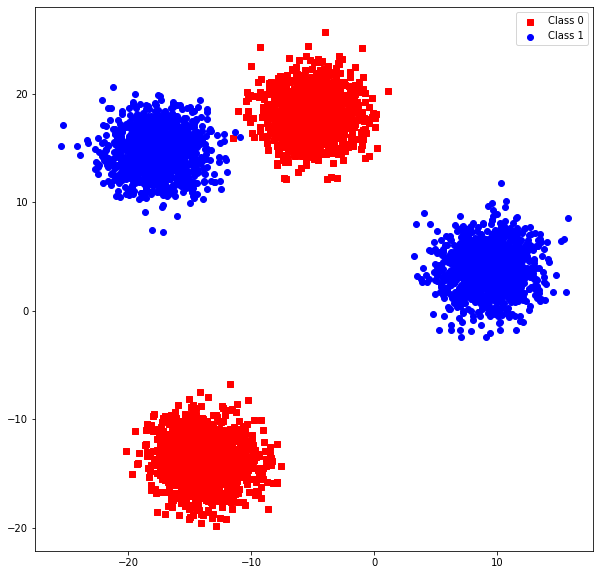

In [20]:
_,ax = plt.subplots(figsize=(10,10))
ax.scatter(X['a'][y==0], X['b'][y==0], color = 'r',label = 'Class 0', marker='s')
ax.scatter(X['a'][y==1], X['b'][y==1], color = 'b',label = 'Class 1', marker=None)
ax.legend()